In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from proj1_helpers import *
from helpers2 import *

In [98]:
#data_folder = Path("../data/")
DATA_TRAIN_PATH = "../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [99]:
print(y)
print(np.shape(y))
print(np.shape(tX))
print(tX.dtype)
print(y.dtype)

[ 1. -1. -1. ...  1. -1. -1.]
(250000,)
(250000, 30)
float64
float64


In [61]:
feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 
                 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 
                 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 
                 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 
                 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
                 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

for i, name in enumerate(feature_names):
    print(i, feature_names[i])


0 DER_mass_MMC
1 DER_mass_transverse_met_lep
2 DER_mass_vis
3 DER_pt_h
4 DER_deltaeta_jet_jet
5 DER_mass_jet_jet
6 DER_prodeta_jet_jet
7 DER_deltar_tau_lep
8 DER_pt_tot
9 DER_sum_pt
10 DER_pt_ratio_lep_tau
11 DER_met_phi_centrality
12 DER_lep_eta_centrality
13 PRI_tau_pt
14 PRI_tau_eta
15 PRI_tau_phi
16 PRI_lep_pt
17 PRI_lep_eta
18 PRI_lep_phi
19 PRI_met
20 PRI_met_phi
21 PRI_met_sumet
22 PRI_jet_num
23 PRI_jet_leading_pt
24 PRI_jet_leading_eta
25 PRI_jet_leading_phi
26 PRI_jet_subleading_pt
27 PRI_jet_subleading_eta
28 PRI_jet_subleading_phi
29 PRI_jet_all_pt


The training data set is composed of : 
* a y vector of length 250'000 and type float
* a tX float matrix of 250'000 rows and 30 columns

It means that our data set is composed of 250'000 different obsevations of 30 different features. In the rest of the notebook, we name the features by their index nummer. So, it means from the feature 0 from the feature  29.

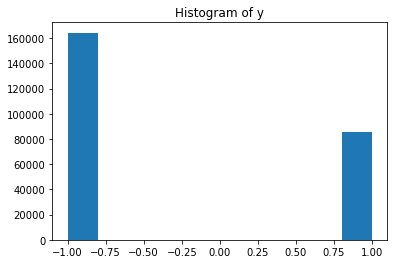

In [5]:
plt.hist(y)
plt.title('Histogram of y')
plt.show()

There is more y = -1 than y = 1 in the data, so there is more y = 'b' than y = 's'. So, we have to pay attention to normalize the data in order to compare them in the next plots.

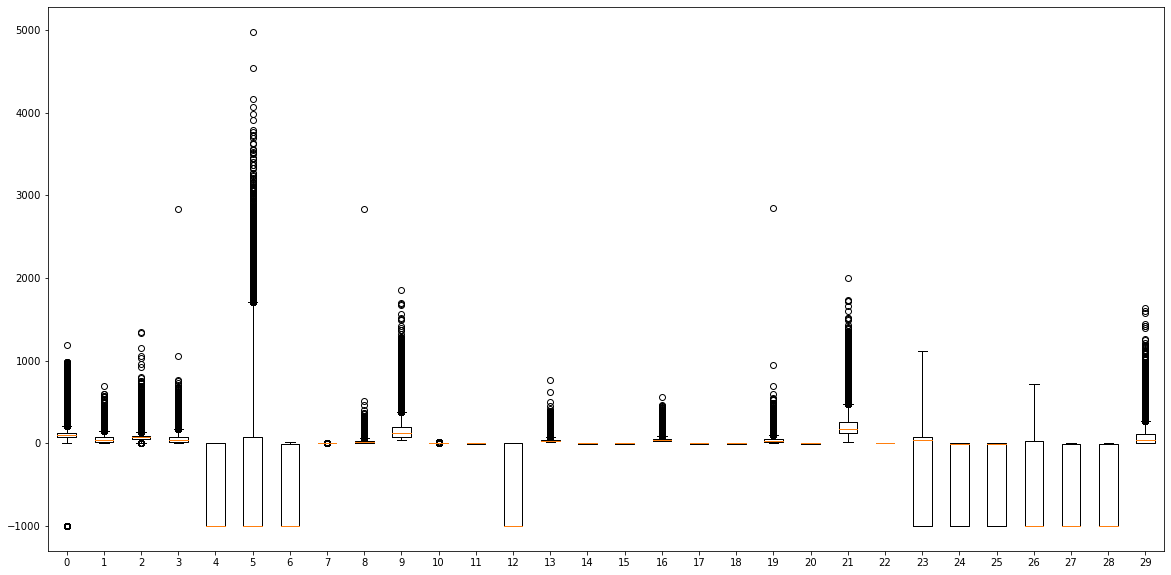

In [6]:
plt.figure(figsize=(20, 10))
ind = np.arange(30)
plt.boxplot(tX[:,], labels = ind)

plt.show()

There are many outliers depending on the feature. There are also feature that has a long interquantile range. Maybe we have to treat these feature in order to be more efficient in our futur predictions. Let's do more plots to be have a better idea :

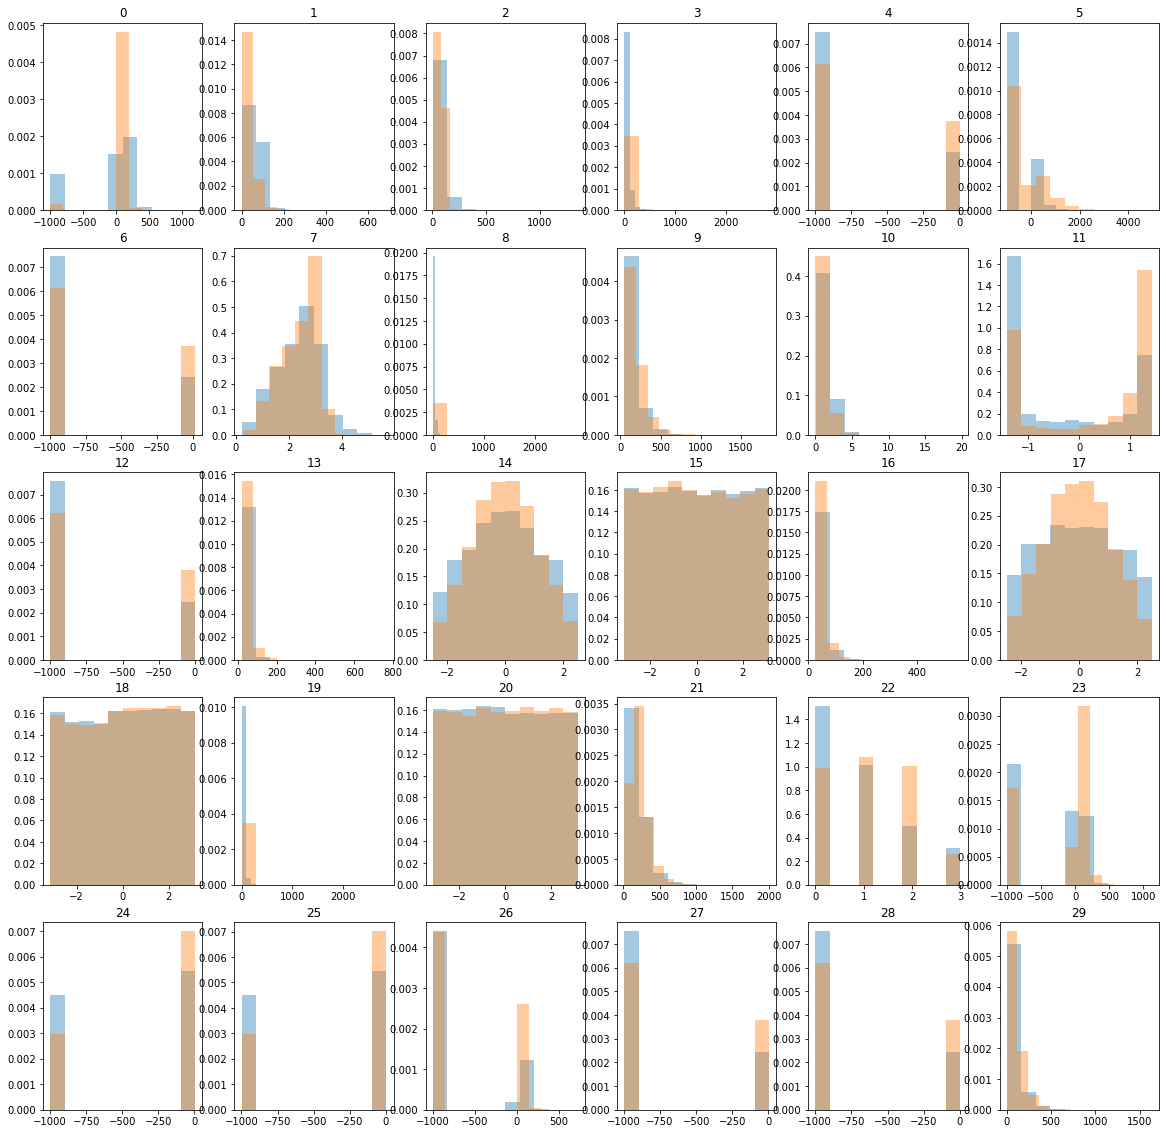

In [7]:
ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(tX_2[:,n], alpha=0.4, density=True, label=['y=-1', 'y=1'])
        axs[i,j].hist(tX_1[:,n], alpha=0.4, density=True)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

By plotting the histograms of the features with a color for each y, we can see that there are useless features as they have almost the same distribution for y=1 than for y = -1. We can cut feature 15, 18, 20. 


There are also features that are very inequally distributed with value that are about -1000 and values around 0 ; it can be problematic for the prediction with such a large gap between values of a single distribution. Moreover, there is not a big difference in the distribution of y=1 and y=-1. Maybe it can be useful to put off these big negative values of these features. The features in question are : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.


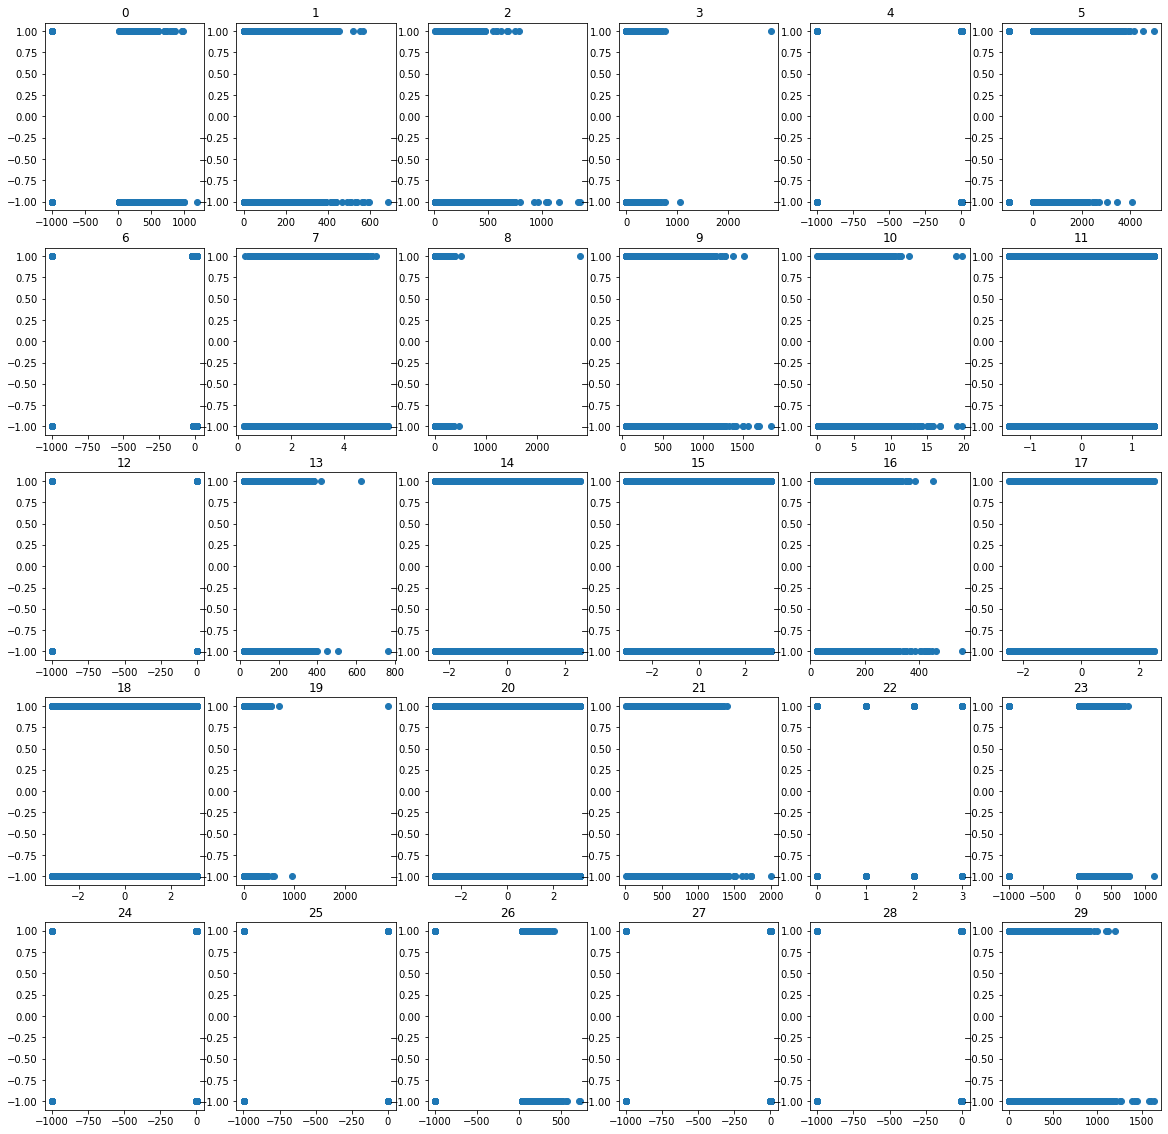

In [8]:
fig, axs = plt.subplots(5, 6, figsize=(20,20))

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].scatter(tX[:,n], y)
        axs[i,j].set_title(n)
        n = n + 1
plt.show()

#meme constat comment faire pour se debarrasser de ces valeurs ??

These plots confirm the obsevations that we made in the previous plot ; no difference of the distribution of y for features 15, 18, 20 and very large gap in the distributions of features : 0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28.

## Data filtering

### Outliers

In [38]:
def nb_outliers(tX, outlier) : 
    sum = 0
    nb_outliers = []
    for col in range(tX.shape[1]) :
        sum = np.where(tX[:,col] == outlier)[0].shape
        nb_outliers.append(sum)   
    print(nb_outliers)
    print(np.where(tX==outlier)[0].shape)

out = -999

print('number of -999 in the entire matrix :')
nb_outliers(tX, out)

ind_1 = np.where(y == 1)
ind_2 = np.where(y == -1)
tX_1 = tX[ind_1[0],:]
tX_2 = tX[ind_2[0],:]

print('number of -999 in the rows where y = 1 :')
nb_outliers(tX_1, out)
print('number of -999 in the rows where y = -1 :')
nb_outliers(tX_2, out)

number of -999 in the entire matrix :
[(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]
(0,)
number of -999 in the rows where y = 1 :
[(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]
(0,)
number of -999 in the rows where y = -1 :
[(0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,), (0,)]
(0,)


We have a problem with features  0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28. They are inequally distributed; they have a lot of -999 values and the rest is values around 0. So, here we can see how much of these -999 there are. We can see that the -999 appear only in the features that we identified with the histograms. It seems that there is a correlation between features as many features have the same number of -999. We can also see that there is more -999 in the obsevations where y=-1, so we have to take this into account when we filter the data. As there are many -999, we can't delete the rows where there is -999 because we will loose to much information.

### Mean and Standardization

In [9]:
# Changer par la valeur da la mean du feature en question sans les compter dedans
def filtering_with_mean(tX):
    index = [0,4,5,6,12,23,24,25,26,27,28]
    tX_filtered = np.copy(tX)
    arr = []
    for ind in index :
        arr = np.delete(tX_filtered[:,ind], np.where(tX_filtered[:,ind]==-999))
        mean = np.mean(arr)
        tX_filtered[np.where(tX_filtered[:,ind]==-999), ind] = mean
    return tX_filtered

In [195]:
def filtering_with_mean_bis(tX, y):
    #index = [0,4,5,6,12,23,24,25,26,27,28]
    index = np.arange(tX.shape[1])
    tX_filtered = np.copy(tX)
    
    ind_1 = np.where(y == 1)[0]
    ind_2 = np.where(y == -1)[0]
    tX_1 = tX[ind_1,:]
    tX_2 = tX[ind_2,:]
    
    ind_3 = np.where(tX[:,0]==-999)[0]
    new_ind_1 = np.intersect1d(ind_3, ind_1)
    new_ind_2 = np.intersect1d(ind_3, ind_2)
    
    arr_1 = []
    arr_2 = []
    for ind in index :
        arr_1 = np.delete(tX_1[:,ind], np.where(tX_1[:,ind]==-999))
        mean_1 = np.mean(arr_1)
        arr_2 = np.delete(tX_2[:,ind], np.where(tX_2[:,ind]==-999))
        mean_2 = np.mean(arr_2)
        tX_filtered[new_ind_1, ind] = mean_1
        tX_filtered[new_ind_2, ind] = mean_2
    return tX_filtered

In [29]:
def std(tX):
    for i in range(tX.shape[1]):
        tX[:,i] = (tX[:,i] - np.mean(tX[:,i])) / np.std(tX[:,i])
    return tX

In order to filter the data, we want to get rif of these -999, but we can't just delete the rows. So, we have the idea to replace the -999 by the mean of the rest of values of the feature. As there is a significant difference of amount of -999 in between y=1 and y=-1 in certain features, we calculate the mean for the rows where y = 1 and y = -1 separatly.

Then, we can also standardize the data. It can be a good idea because the features are not all in the same range of values and it can create disproportionality between the importance of the features.

In [90]:
def log_distribution(tX, to_log):
    tX_log = tX
    index = np.arange(tX.shape[1])
    for i in range(tX.shape[1]):
        for j in range(len(to_log)):
            if index[i] == to_log[j]:
                tX_log[:, i] = np.log(1+tX[:, to_log[j]])  
    return tX_log

In [129]:
def separate_sets(tX, y, ids):
    index1 = np.where(tX[:, 22]==0)
    index2 = np.where(tX[:, 22]==1)
    index3 = np.where(tX[:, 22]>1)
    
    set1_x = tX[index1]
    set1_y = y[index1]
    set1_ids = ids[index1]
    
    set2_x = tX[index2]
    set2_y = y[index2]
    set2_ids = ids[index2]
    
    set3_x = tX[index3]
    set3_y = y[index3]
    set3_ids = ids[index3]
    
    return set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids

In [183]:
def outliers(tX, outlier):
    outliers = []
    M = np.squeeze(tX.shape[0])
    for col in range(tX.shape[1]) :
        out_col = np.nonzero(tX[:,col] == outlier)[0].shape
        out_col = np.squeeze(out_col)
        outliers.append(out_col/M)
    print('outliers ratio for each feature', outliers)
    
    index_full = np.arange(tX.shape[1])
    index = index_full[~(outliers==np.ones(len(outliers)))]
    index = index.reshape(-1)
    X_without_outliers = tX[:, index]
    return X_without_outliers 

### Cutting features 

In [12]:
def cut(tX, to_cut):
    cut_index = 100*np.ones(tX.shape[1])
    index_full = np.arange(tX.shape[1])
    for i in range(tX.shape[1]):
        for j in range(len(to_cut)):
            if index_full[i] == to_cut[j]:
                cut_index[i] = to_cut[j]
    index = index_full[~(index_full == cut_index)]
    index = index.reshape(-1)
    tX_cut = tX[:, index]
    return tX_cut

def keep(tX, to_keep):
    keep_index = 100*np.ones(tX.shape[1])
    index_full = np.arange(tX.shape[1])
    for i in range(tX.shape[1]):
        for j in range(len(to_keep)):
            if index_full[i] == to_keep[j]:
                keep_index[i] = to_keep[j]
    index = index_full[index_full == keep_index]
    index = index.reshape(-1)
    tX_kept = tX[:, index]
    return tX_kept

As we see above in the histograms, some features seem to be useless as they have a similar distribution between the y = 1 and y = -1. So, it is useful to have function that cut or keep some parameters.

## Fonctions 

In [15]:
from implementations import *
from cross_validation import *

#### Feature engineering

In [193]:
tX_mean = filtering_with_mean_bis(tX, y)
tX_std = std(tX_mean)

to_cut = [15,18,20]
tX_mean_cut = cut(tX_std, to_cut)

to_cut1 = [0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
tX_cut = cut(tX_std, to_cut1)

to_keep = [13, 14, 17]
tX_kept = keep(tX_std, to_keep)

In [221]:
to_log = [1, 2, 5, 9, 10, 13, 16, 19, 21, 23, 26, 29]
tX_log = log_distribution(tX, to_log)
set1_x, set1_y, set1_ids, set2_x, set2_y, set2_ids, set3_x, set3_y, set3_ids = separate_sets(tX_log, y, ids)

print('Set 1')
set1_x = outliers(set1_x, -999)
set1_x = std(filtering_with_mean_bis(set1_x, set1_y))
set1_x = np.c_[np.ones(set1_x.shape[0]), set1_x]
_ = outliers(set1_x, -999)

print('\nSet 2')
set2_x = outliers(set2_x, -999)
set2_x = filtering_with_mean_bis(set2_x, set2_y)
_ = outliers(set2_x, -999)

print('\nSet 3')
set3_x = outliers(set3_x, -999)
set3_x = std(filtering_with_mean_bis(set3_x, set3_y))
set1_x = np.c_[np.ones(set1_x.shape[0]), set1_x]
_ = outliers(set3_x, -999)

Set 1
outliers ratio for each feature [0.2614574679971575, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0]
outliers ratio for each feature [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 2
outliers ratio for each feature [0.09751882802022077, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
outliers ratio for each feature [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Set 3
outliers ratio for each feature [0.06105344416415092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
outliers ratio for each feature [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

<ipython-input-29-d9e33aca35d4>:3: RuntimeWarning: invalid value encountered in true_divide
  tX[:,i] = (tX[:,i] - np.mean(tX[:,i])) / np.std(tX[:,i])


#### Choose x and generate test and train data 

In [94]:
x1 = tX_mean
x2 = tX_kept
x3 = tX_std
x4 = tX_mean_cut

### Least squares

Cross validation to get parameters

In [18]:
np.random.seed(seed=1)
degrees = np.arange(1,11)
degree_opt, _ = best_degree_selection(y, tX_log, degrees, k_fold=4, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
tX_poly = build_poly(x1, degree_opt)
w_ls, loss_ls = least_squares(y, tX_poly)
print("Least square loss {loss}".format(loss=loss_ls))
degree_ls = degree_opt

best rmses [0.8231175887967075, 0.8979280274561516, 3.8156436509961016, 5.897661698062343, 510.1260411941516, 8994.2125337868, 675850.9495906193, 7011082.216144496, 537245683.3080721, 9413700696.528532]
Cross validation finished: optimal degree 1
Least square loss 0.3386372049426108


In [222]:
np.random.seed(seed=1)
degrees = np.arange(1,11)
degree_opt, _ = best_degree_selection(set1_y, set1_x, degrees, k_fold=4, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
tX_poly = build_poly(set1_x, degree_opt)
w_ls1, loss_ls1 = least_squares(set1_y, tX_poly)
print("Least square loss {loss}".format(loss=loss_ls1))
degree_ls1 = degree_opt

LinAlgError: Singular matrix

In [62]:
#je commente sinon pas le bon w_ls pour la submission
""""w_ls, loss_ls = least_squares(y, x1)
print("Least square loss {loss}".format(loss=loss_ls))
w_ls, loss_ls = least_squares(y, build_poly(x1, 8))
print("Least square mse loss {loss} with degree 8".format(loss=loss_ls))
w_ls, loss_ls = least_squares(y, build_poly(x1, 8))
loss_ls = np.sqrt(2*loss_ls)
print("Least square rmse loss {loss} with degree 8".format(loss=loss_ls))"""

'"w_ls, loss_ls = least_squares(y, x1)\nprint("Least square loss {loss}".format(loss=loss_ls))\nw_ls, loss_ls = least_squares(y, build_poly(x1, 8))\nprint("Least square mse loss {loss} with degree 8".format(loss=loss_ls))\nw_ls, loss_ls = least_squares(y, build_poly(x1, 8))\nloss_ls = np.sqrt(2*loss_ls)\nprint("Least square rmse loss {loss} with degree 8".format(loss=loss_ls))'

In [57]:
np.random.seed(seed=1)
degrees = np.arange(1,11)
degree_opt, _ = best_degree_selection(y, x4, degrees, k_fold=4, lambdas=0, fonction=0)
print("Cross validation finished: optimal degree {d}".format(d=degree_opt))
tX2 = build_poly(x4, degree_opt)
w_ls2, loss_ls2 = least_squares(y, tX2)
print("Least square loss {loss}".format(loss=loss_ls))
degree_ls2 = degree_opt

best rmses [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Cross validation finished: optimal degree 1
0 1 1
0 2 2
0 3 3
0 4 4
0 5 5
0 6 6
0 7 7
0 8 8
0 9 9
0 10 10
0 11 11
0 12 12
0 13 13
0 14 14
0 15 15
0 16 16
0 17 17
0 18 18
0 19 19
0 20 20
0 21 21
0 22 22
0 23 23
0 24 24
0 25 25
0 26 26
0 27 27
1 2 28
1 3 29
1 4 30
1 5 31
1 6 32
1 7 33
1 8 34
1 9 35
1 10 36
1 11 37
1 12 38
1 13 39
1 14 40
1 15 41
1 16 42
1 17 43
1 18 44
1 19 45
1 20 46
1 21 47
1 22 48
1 23 49
1 24 50
1 25 51
1 26 52
1 27 53
2 3 54
2 4 55
2 5 56
2 6 57
2 7 58
2 8 59
2 9 60
2 10 61
2 11 62
2 12 63
2 13 64
2 14 65
2 15 66
2 16 67
2 17 68
2 18 69
2 19 70
2 20 71
2 21 72
2 22 73
2 23 74
2 24 75
2 25 76
2 26 77
2 27 78
3 4 79
3 5 80
3 6 81
3 7 82
3 8 83
3 9 84
3 10 85
3 11 86
3 12 87
3 13 88
3 14 89
3 15 90
3 16 91
3 17 92
3 18 93
3 19 94
3 20 95
3 21 96
3 22 97
3 23 98
3 24 99
3 25 100
3 26 101
3 27 102
4 5 103
4 6 104
4 7 105
4 8 106
4 9 107
4 10 108
4 11 109
4 12 110
4 13 111
4 14 112
4 15 113
4 16 114
4 17 115
4 

### Ridge regression 

Cross validation to find the oprimal lambda and degree

In [58]:
degrees = np.arange(1,11)
degree_opt, lambda_opt = best_degree_selection(y, x4, degrees, k_fold=4, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
tX = build_poly(x1, degree_opt)
w_rr, loss_rr = ridge_regression(y, tX, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr))
degree_rr = degree_opt

best rmses [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Cross validation finished: optimal lambda 0.0001 and degree 1
Ridge regression loss nan


In [223]:
degrees = np.arange(1,11)
degree_opt, lambda_opt = best_degree_selection(set1_y, set1_x, degrees, k_fold=10, lambdas=np.logspace(-4, 0, 30), fonction=1)
print("Cross validation finished: optimal lambda {l} and degree {d}".format(l=lambda_opt, d=degree_opt))
tX_poly = build_poly(x1, degree_opt)
w_rr1, loss_rr1 = ridge_regression(set1_y, tX_poly, lambda_opt)
print("Ridge regression loss {loss}".format(loss=loss_rr1))
degree_rr1 = degree_opt

LinAlgError: Singular matrix

### Gradient descent

CV to find best gamma

In [ ]:
# Si tu fais ca avec tous les features, ca prend beaucoup de temps (>1h) et ne converge pas
# en prenant x_kept on converge vers loss=0.42 et gamma_opt = 2.51 
# je pense qu'il faut trouver un just milieu entre 30 et 3 features 
max_iters = 500
k_fold = 10
initial_w = np.zeros(x2.shape[1])
gammas = np.arange(0, 3, 0.01)
gamma_opt = cross_validation(y, x2, k_fold, gammas, fonction=2)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
w_gd, loss_gd = least_squares_GD(y, x2, gamma_opt, max_iters=max_iters)
print("Gradient descent regression loss {loss}".format(loss=loss_gd))

In [ ]:
k_fold = 10
gammas = np.arange(0, 3, 0.01)
gamma_opt = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=2)
w_gd, loss_gd = least_squares_GD(set1_y, set1_x, gamma_opt, max_iters=max_iters)
print("Gradient descent regression loss {loss}".format(loss=loss_gd))

In [217]:
k_fold = 10
gammas = np.arange(0, 3, 0.01)
gamma_opt = cross_validation(set3_y, set3_x, k_fold, gammas, fonction=2)
w_gd, loss_gd = least_squares_GD(set3_y, set3_x, gamma_opt, max_iters=max_iters)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("Gradient descent regression loss {loss}".format(loss=loss_gd))

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.5
Gradient Descent(2/49): loss=0.5
Gradient Descent(3/49): loss=0.5
Gradient Descent(4/49): loss=0.5
Gradient Descent(5/49): loss=0.5
Gradient Descent(6/49): loss=0.5
Gradient Descent(7/49): loss=0.5
Gradient Descent(8/49): loss=0.5
Gradient Descent(9/49): loss=0.5
Gradient Descent(10/49): loss=0.5
Gradient Descent(11/49): loss=0.5
Gradient Descent(12/49): loss=0.5
Gradient Descent(13/49): loss=0.5
Gradient Descent(14/49): loss=0.5
Gradient Descent(15/49): loss=0.5
Gradient Descent(16/49): loss=0.5
Gradient Descent(17/49): loss=0.5
Gradient Descent(18/49): loss=0.5
Gradient Descent(19/49): loss=0.5
Gradient Descent(20/49): loss=0.5
Gradient Descent(21/49): loss=0.5
Gradient Descent(22/49): loss=0.5
Gradient Descent(23/49): loss=0.5
Gradient Descent(24/49): loss=0.5
Gradient Descent(25/49): loss=0.5
Gradient Descent(26/49): loss=0.5
Gradient Descent(27/49): loss=0.5
Gradient Descent(28/49): loss=0.5
Gradient Descent(29/49):

Gradient Descent(46/49): loss=0.39886206219021036
Gradient Descent(47/49): loss=0.3982649479178996
Gradient Descent(48/49): loss=0.3976897917322227
Gradient Descent(49/49): loss=0.3971354514803838
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.49413642631629345
Gradient Descent(2/49): loss=0.48860589924345954
Gradient Descent(3/49): loss=0.48338808662401894
Gradient Descent(4/49): loss=0.478463933367628
Gradient Descent(5/49): loss=0.47381557965054294
Gradient Descent(6/49): loss=0.4694262844643921
Gradient Descent(7/49): loss=0.4652803541541558
Gradient Descent(8/49): loss=0.461363075610596
Gradient Descent(9/49): loss=0.45766065380581167
Gradient Descent(10/49): loss=0.4541601533822859
Gradient Descent(11/49): loss=0.45084944402586735
Gradient Descent(12/49): loss=0.4477171493717443
Gradient Descent(13/49): loss=0.4447525992097034
Gradient Descent(14/49): loss=0.44194578477096985
Gradient Descent(15/49): loss=0.43928731689376255
Gradient Descent(16/49): loss=0.436768

Gradient Descent(6/49): loss=0.44720119524788743
Gradient Descent(7/49): loss=0.4414140405361766
Gradient Descent(8/49): loss=0.43623121520369174
Gradient Descent(9/49): loss=0.43158206235447866
Gradient Descent(10/49): loss=0.4274045059462808
Gradient Descent(11/49): loss=0.42364398736889175
Gradient Descent(12/49): loss=0.4202525358085233
Gradient Descent(13/49): loss=0.4171879552960511
Gradient Descent(14/49): loss=0.4144131135722714
Gradient Descent(15/49): loss=0.4118953198362451
Gradient Descent(16/49): loss=0.4096057801164972
Gradient Descent(17/49): loss=0.4075191204557555
Gradient Descent(18/49): loss=0.40561296935903746
Gradient Descent(19/49): loss=0.40386759204860617
Gradient Descent(20/49): loss=0.40226557002016616
Gradient Descent(21/49): loss=0.40079152022192543
Gradient Descent(22/49): loss=0.39943184889837907
Gradient Descent(23/49): loss=0.39817453576809847
Gradient Descent(24/49): loss=0.3970089447516754
Gradient Descent(25/49): loss=0.3959256579428744
Gradient Desce

Gradient Descent(24/49): loss=0.3880436815038882
Gradient Descent(25/49): loss=0.3872642735861371
Gradient Descent(26/49): loss=0.3865337509397112
Gradient Descent(27/49): loss=0.38584633134330565
Gradient Descent(28/49): loss=0.3851970867617161
Gradient Descent(29/49): loss=0.3845818042831328
Gradient Descent(30/49): loss=0.38399687091386053
Gradient Descent(31/49): loss=0.38343917801318733
Gradient Descent(32/49): loss=0.38290604190976224
Gradient Descent(33/49): loss=0.3823951378615506
Gradient Descent(34/49): loss=0.3819044450294846
Gradient Descent(35/49): loss=0.3814322005508979
Gradient Descent(36/49): loss=0.38097686113955187
Gradient Descent(37/49): loss=0.3805370709182549
Gradient Descent(38/49): loss=0.38011163441893536
Gradient Descent(39/49): loss=0.3796994938727396
Gradient Descent(40/49): loss=0.3792997100667387
Gradient Descent(41/49): loss=0.37891144617027095
Gradient Descent(42/49): loss=0.37853395403781
Gradient Descent(43/49): loss=0.37816656258061887
Gradient Desce

Gradient Descent(17/49): loss=0.3890430531503597
Gradient Descent(18/49): loss=0.38793085807488703
Gradient Descent(19/49): loss=0.38691556654528186
Gradient Descent(20/49): loss=0.38598176956566344
Gradient Descent(21/49): loss=0.385117074093056
Gradient Descent(22/49): loss=0.38431145614744483
Gradient Descent(23/49): loss=0.3835567597425155
Gradient Descent(24/49): loss=0.3828463078141526
Gradient Descent(25/49): loss=0.3821745993016471
Gradient Descent(26/49): loss=0.38153707261349495
Gradient Descent(27/49): loss=0.38092992034157364
Gradient Descent(28/49): loss=0.3803499436204298
Gradient Descent(29/49): loss=0.37979443722514233
Gradient Descent(30/49): loss=0.3792610985613631
Gradient Descent(31/49): loss=0.3787479552763772
Gradient Descent(32/49): loss=0.3782533074257019
Gradient Descent(33/49): loss=0.37777568105357917
Gradient Descent(34/49): loss=0.37731379075446675
Gradient Descent(35/49): loss=0.37686650932710614
Gradient Descent(36/49): loss=0.3764328430516489
Gradient De

Gradient Descent(7/49): loss=0.40575737894778785
Gradient Descent(8/49): loss=0.4016723669894701
Gradient Descent(9/49): loss=0.3983743237374851
Gradient Descent(10/49): loss=0.3956651513029204
Gradient Descent(11/49): loss=0.39340081363516105
Gradient Descent(12/49): loss=0.3914760257942402
Gradient Descent(13/49): loss=0.3898133687667562
Gradient Descent(14/49): loss=0.3883555346975207
Gradient Descent(15/49): loss=0.3870597896924038
Gradient Descent(16/49): loss=0.38589400994508766
Gradient Descent(17/49): loss=0.38483383595364906
Gradient Descent(18/49): loss=0.38386062276815847
Gradient Descent(19/49): loss=0.38295995814362616
Gradient Descent(20/49): loss=0.38212058679221744
Gradient Descent(21/49): loss=0.38133362579771696
Gradient Descent(22/49): loss=0.3805919894117675
Gradient Descent(23/49): loss=0.37988996493290594
Gradient Descent(24/49): loss=0.37922289801919373
Gradient Descent(25/49): loss=0.37858695760699024
Gradient Descent(26/49): loss=0.3779789590151555
Gradient Des

Gradient Descent(45/49): loss=0.37042172776417503
Gradient Descent(46/49): loss=0.37009882736711813
Gradient Descent(47/49): loss=0.36978364297071337
Gradient Descent(48/49): loss=0.36947589450305884
Gradient Descent(49/49): loss=0.3691753197970952
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.46754918338840273
Gradient Descent(2/49): loss=0.44520168266102034
Gradient Descent(3/49): loss=0.42958763740389305
Gradient Descent(4/49): loss=0.4184912583267776
Gradient Descent(5/49): loss=0.4104489319694311
Gradient Descent(6/49): loss=0.40448939287074726
Gradient Descent(7/49): loss=0.3999648389657038
Gradient Descent(8/49): loss=0.39644072914060263
Gradient Descent(9/49): loss=0.3936236466690701
Gradient Descent(10/49): loss=0.39131394623671223
Gradient Descent(11/49): loss=0.389374581898206
Gradient Descent(12/49): loss=0.38771052432278985
Gradient Descent(13/49): loss=0.38625512346952906
Gradient Descent(14/49): loss=0.38496103727590036
Gradient Descent(15/49): loss=0.3

Gradient Descent(33/49): loss=0.37229251843401634
Gradient Descent(34/49): loss=0.3718497513054695
Gradient Descent(35/49): loss=0.37142069533988087
Gradient Descent(36/49): loss=0.3710046481314533
Gradient Descent(37/49): loss=0.37060097176293366
Gradient Descent(38/49): loss=0.3702090842077464
Gradient Descent(39/49): loss=0.3698284521235501
Gradient Descent(40/49): loss=0.36945858478207194
Gradient Descent(41/49): loss=0.3690990289319488
Gradient Descent(42/49): loss=0.36874936443154577
Gradient Descent(43/49): loss=0.3684092005202115
Gradient Descent(44/49): loss=0.36807817262124326
Gradient Descent(45/49): loss=0.3677559395895416
Gradient Descent(46/49): loss=0.3674421813326633
Gradient Descent(47/49): loss=0.3671365967466236
Gradient Descent(48/49): loss=0.36683890191799845
Gradient Descent(49/49): loss=0.3665488285521545
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4627371561864058
Gradient Descent(2/49): loss=0.4387633421293793
Gradient Descent(3/49): loss=0.

Gradient Descent(15/49): loss=0.3818755507580326
Gradient Descent(16/49): loss=0.38086666599376995
Gradient Descent(17/49): loss=0.3799301832915191
Gradient Descent(18/49): loss=0.3790550821704067
Gradient Descent(19/49): loss=0.37823282627544963
Gradient Descent(20/49): loss=0.37745668281317846
Gradient Descent(21/49): loss=0.37672125373764115
Gradient Descent(22/49): loss=0.37602214662041195
Gradient Descent(23/49): loss=0.3753557392105426
Gradient Descent(24/49): loss=0.37471900794800783
Gradient Descent(25/49): loss=0.3741094009250964
Gradient Descent(26/49): loss=0.3735247422977839
Gradient Descent(27/49): loss=0.37296315933950225
Gradient Descent(28/49): loss=0.3724230260653556
Gradient Descent(29/49): loss=0.3719029191678483
Gradient Descent(30/49): loss=0.3714015832261797
Gradient Descent(31/49): loss=0.37091790298722466
Gradient Descent(32/49): loss=0.3704508810984825
Gradient Descent(33/49): loss=0.36999962008534587
Gradient Descent(34/49): loss=0.3695633076613174
Gradient De

Gradient Descent(45/49): loss=0.36085764584696645
Gradient Descent(46/49): loss=0.36056923905769017
Gradient Descent(47/49): loss=0.3602899214203751
Gradient Descent(48/49): loss=0.3600193593233682
Gradient Descent(49/49): loss=0.3597572347990052
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4584164524398245
Gradient Descent(2/49): loss=0.43344316647761705
Gradient Descent(3/49): loss=0.4179715165594702
Gradient Descent(4/49): loss=0.4080136053379354
Gradient Descent(5/49): loss=0.4013128233269203
Gradient Descent(6/49): loss=0.3965791613420868
Gradient Descent(7/49): loss=0.39306583378930476
Gradient Descent(8/49): loss=0.390333713783851
Gradient Descent(9/49): loss=0.3881195961673771
Gradient Descent(10/49): loss=0.38626208088993685
Gradient Descent(11/49): loss=0.38465956140557733
Gradient Descent(12/49): loss=0.3832461861444695
Gradient Descent(13/49): loss=0.3819779412271898
Gradient Descent(14/49): loss=0.38082447550618626
Gradient Descent(15/49): loss=0.3797642

Gradient Descent(24/49): loss=0.3681083525668084
Gradient Descent(25/49): loss=0.36750338536053345
Gradient Descent(26/49): loss=0.3669242738887327
Gradient Descent(27/49): loss=0.3663693713727845
Gradient Descent(28/49): loss=0.36583721206848774
Gradient Descent(29/49): loss=0.365326481088855
Gradient Descent(30/49): loss=0.36483599050922916
Gradient Descent(31/49): loss=0.3643646602685626
Gradient Descent(32/49): loss=0.36391150276506506
Gradient Descent(33/49): loss=0.3634756103220451
Gradient Descent(34/49): loss=0.3630561449022526
Gradient Descent(35/49): loss=0.3626523295979934
Gradient Descent(36/49): loss=0.362263441534765
Gradient Descent(37/49): loss=0.3618888059087112
Gradient Descent(38/49): loss=0.3615277909403213
Gradient Descent(39/49): loss=0.3611798035738894
Gradient Descent(40/49): loss=0.3608442857881884
Gradient Descent(41/49): loss=0.3605207114114391
Gradient Descent(42/49): loss=0.3602085833550186
Gradient Descent(43/49): loss=0.3599074311970092
Gradient Descent(4

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4481173947745179
Gradient Descent(2/49): loss=0.42131330399268746
Gradient Descent(3/49): loss=0.40663248818120956
Gradient Descent(4/49): loss=0.3979779269930371
Gradient Descent(5/49): loss=0.3924304823182664
Gradient Descent(6/49): loss=0.38856240971404515
Gradient Descent(7/49): loss=0.38565547141665285
Gradient Descent(8/49): loss=0.3833349650898796
Gradient Descent(9/49): loss=0.381396485980005
Gradient Descent(10/49): loss=0.37972267948388594
Gradient Descent(11/49): loss=0.37824241670669007
Gradient Descent(12/49): loss=0.37691023198131274
Gradient Descent(13/49): loss=0.37569561159805887
Gradient Descent(14/49): loss=0.3745771865532307
Gradient Descent(15/49): loss=0.37353944114128146
Gradient Descent(16/49): loss=0.37257076003745837
Gradient Descent(17/49): loss=0.37166221749904355
Gradient Descent(18/49): loss=0.37080679637953623
Gradient Descent(19/49): loss=0.36999886698769646
Gradient Descent(20/49): loss=0.3

Gradient Descent(36/49): loss=0.36063802562465813
Gradient Descent(37/49): loss=0.36029566922384815
Gradient Descent(38/49): loss=0.35996800568480825
Gradient Descent(39/49): loss=0.3596543169474059
Gradient Descent(40/49): loss=0.35935392677180966
Gradient Descent(41/49): loss=0.3590661974728974
Gradient Descent(42/49): loss=0.35879052702068776
Gradient Descent(43/49): loss=0.3585263464519733
Gradient Descent(44/49): loss=0.3582731175481787
Gradient Descent(45/49): loss=0.35803033074231766
Gradient Descent(46/49): loss=0.3577975032242242
Gradient Descent(47/49): loss=0.3575741772183259
Gradient Descent(48/49): loss=0.357359918412358
Gradient Descent(49/49): loss=0.35715431451879454
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.44389423840163456
Gradient Descent(2/49): loss=0.4170369948744651
Gradient Descent(3/49): loss=0.4031387870372789
Gradient Descent(4/49): loss=0.39520436831470845
Gradient Descent(5/49): loss=0.39015892563495674
Gradient Descent(6/49): loss=0.3

Gradient Descent(13/49): loss=0.3741742051395981
Gradient Descent(14/49): loss=0.37303834179272466
Gradient Descent(15/49): loss=0.37198309699170606
Gradient Descent(16/49): loss=0.37099843512910335
Gradient Descent(17/49): loss=0.37007642701653043
Gradient Descent(18/49): loss=0.3692106620680157
Gradient Descent(19/49): loss=0.3683958501233792
Gradient Descent(20/49): loss=0.36762754563636224
Gradient Descent(21/49): loss=0.36690195275486065
Gradient Descent(22/49): loss=0.366215784972215
Gradient Descent(23/49): loss=0.3655661622603789
Gradient Descent(24/49): loss=0.36495053437989083
Gradient Descent(25/49): loss=0.3643666227643532
Gradient Descent(26/49): loss=0.3638123757891871
Gradient Descent(27/49): loss=0.36328593382954627
Gradient Descent(28/49): loss=0.3627856015817622
Gradient Descent(29/49): loss=0.3623098258492911
Gradient Descent(30/49): loss=0.3618571774942091
Gradient Descent(31/49): loss=0.3614263366039171
Gradient Descent(32/49): loss=0.361016080168884
Gradient Desce

Gradient Descent(44/49): loss=0.3576279433192874
Gradient Descent(45/49): loss=0.3574242795578691
Gradient Descent(46/49): loss=0.35722998809618145
Gradient Descent(47/49): loss=0.3570445803900069
Gradient Descent(48/49): loss=0.3568675955168808
Gradient Descent(49/49): loss=0.3566985984472191
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4371751352712309
Gradient Descent(2/49): loss=0.4114180908872521
Gradient Descent(3/49): loss=0.39931655126061
Gradient Descent(4/49): loss=0.39261145672235176
Gradient Descent(5/49): loss=0.3882606091008603
Gradient Descent(6/49): loss=0.3850721422837372
Gradient Descent(7/49): loss=0.38253717207325183
Gradient Descent(8/49): loss=0.380414353692204
Gradient Descent(9/49): loss=0.3785760040016384
Gradient Descent(10/49): loss=0.3769476348349534
Gradient Descent(11/49): loss=0.37548223893739385
Gradient Descent(12/49): loss=0.3741482986431653
Gradient Descent(13/49): loss=0.3729236526557401
Gradient Descent(14/49): loss=0.371792096641

Gradient Descent(26/49): loss=0.36269074319533373
Gradient Descent(27/49): loss=0.3622048239130153
Gradient Descent(28/49): loss=0.36174570421908153
Gradient Descent(29/49): loss=0.36131168239201045
Gradient Descent(30/49): loss=0.360901188000937
Gradient Descent(31/49): loss=0.3605127680634623
Gradient Descent(32/49): loss=0.36014507529078443
Gradient Descent(33/49): loss=0.35979685800826516
Gradient Descent(34/49): loss=0.35946695143526713
Gradient Descent(35/49): loss=0.35915427007903467
Gradient Descent(36/49): loss=0.35885780105053416
Gradient Descent(37/49): loss=0.358576598150392
Gradient Descent(38/49): loss=0.3583097766037926
Gradient Descent(39/49): loss=0.35805650834687214
Gradient Descent(40/49): loss=0.35781601778553507
Gradient Descent(41/49): loss=0.3575875779620185
Gradient Descent(42/49): loss=0.3573705070758845
Gradient Descent(43/49): loss=0.3571641653151437
Gradient Descent(44/49): loss=0.3569679519604303
Gradient Descent(45/49): loss=0.3567813027309641
Gradient Des

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.43037577296977275
Gradient Descent(2/49): loss=0.4061324297739267
Gradient Descent(3/49): loss=0.39569243971955687
Gradient Descent(4/49): loss=0.3899684644543507
Gradient Descent(5/49): loss=0.38614463725239667
Gradient Descent(6/49): loss=0.38324552822012325
Gradient Descent(7/49): loss=0.38087921635979033
Gradient Descent(8/49): loss=0.3788612878811512
Gradient Descent(9/49): loss=0.37709231090285483
Gradient Descent(10/49): loss=0.37551286515657734
Gradient Descent(11/49): loss=0.37408463983380263
Gradient Descent(12/49): loss=0.37278143092176963
Gradient Descent(13/49): loss=0.37158441610450105
Gradient Descent(14/49): loss=0.37047949625634446
Gradient Descent(15/49): loss=0.36945572198623544
Gradient Descent(16/49): loss=0.3685043242543639
Gradient Descent(17/49): loss=0.36761809599890566
Gradient Descent(18/49): loss=0.36679098485636874
Gradient Descent(19/49): loss=0.36601781673534406
Gradient Descent(20/49): loss=

Gradient Descent(33/49): loss=0.3598937156361572
Gradient Descent(34/49): loss=0.3595809933494764
Gradient Descent(35/49): loss=0.35928510894329874
Gradient Descent(36/49): loss=0.3590050419176056
Gradient Descent(37/49): loss=0.35873984038791923
Gradient Descent(38/49): loss=0.35848861567001883
Gradient Descent(39/49): loss=0.3582505374168246
Gradient Descent(40/49): loss=0.3580248292310064
Gradient Descent(41/49): loss=0.3578107646905095
Gradient Descent(42/49): loss=0.35760766373494185
Gradient Descent(43/49): loss=0.35741488936934096
Gradient Descent(44/49): loss=0.35723184464869595
Gradient Descent(45/49): loss=0.3570579699121633
Gradient Descent(46/49): loss=0.3568927402404307
Gradient Descent(47/49): loss=0.3567356631133913
Gradient Descent(48/49): loss=0.35658627624836337
Gradient Descent(49/49): loss=0.3564441456016298
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.42709745436761143
Gradient Descent(2/49): loss=0.4037969115808165
Gradient Descent(3/49): loss=0

Gradient Descent(15/49): loss=0.3692861081993977
Gradient Descent(16/49): loss=0.3683562597169607
Gradient Descent(17/49): loss=0.36749142269659824
Gradient Descent(18/49): loss=0.3666855599195764
Gradient Descent(19/49): loss=0.36593349261727337
Gradient Descent(20/49): loss=0.3652307150673827
Gradient Descent(21/49): loss=0.3645732613561738
Gradient Descent(22/49): loss=0.36395760723535
Gradient Descent(23/49): loss=0.36338059617876534
Gradient Descent(24/49): loss=0.3628393825106622
Gradient Descent(25/49): loss=0.3623313868307831
Gradient Descent(26/49): loss=0.3618542604680862
Gradient Descent(27/49): loss=0.3614058566810443
Gradient Descent(28/49): loss=0.36098420698207856
Gradient Descent(29/49): loss=0.36058750141347
Gradient Descent(30/49): loss=0.3602140719143272
Gradient Descent(31/49): loss=0.3598623781384381
Gradient Descent(32/49): loss=0.3595309952404768
Gradient Descent(33/49): loss=0.3592186032623727
Gradient Descent(34/49): loss=0.35892397783557645
Gradient Descent(35

Gradient Descent(47/49): loss=0.35294951992572976
Gradient Descent(48/49): loss=0.3528267452095842
Gradient Descent(49/49): loss=0.35271048994278864
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.42454763575292603
Gradient Descent(2/49): loss=0.4023766698639512
Gradient Descent(3/49): loss=0.3933120490384255
Gradient Descent(4/49): loss=0.3881931118213151
Gradient Descent(5/49): loss=0.38463154963859536
Gradient Descent(6/49): loss=0.38186014146973585
Gradient Descent(7/49): loss=0.3795665224876613
Gradient Descent(8/49): loss=0.3775964463466099
Gradient Descent(9/49): loss=0.3758632157059184
Gradient Descent(10/49): loss=0.37431362706800686
Gradient Descent(11/49): loss=0.37291275066750784
Gradient Descent(12/49): loss=0.3716363052353494
Gradient Descent(13/49): loss=0.3704665516589403
Gradient Descent(14/49): loss=0.36938996495204335
Gradient Descent(15/49): loss=0.3683958564841815
Gradient Descent(16/49): loss=0.3674755256804972
Gradient Descent(17/49): loss=0.36662

Gradient Descent(24/49): loss=0.3584472618728681
Gradient Descent(25/49): loss=0.35797154768138123
Gradient Descent(26/49): loss=0.3575276104842043
Gradient Descent(27/49): loss=0.35711308080914533
Gradient Descent(28/49): loss=0.3567257885987876
Gradient Descent(29/49): loss=0.3563637425448577
Gradient Descent(30/49): loss=0.3560251123477138
Gradient Descent(31/49): loss=0.3557082133351466
Gradient Descent(32/49): loss=0.35541149301017605
Gradient Descent(33/49): loss=0.3551335191962324
Gradient Descent(34/49): loss=0.3548729695208655
Gradient Descent(35/49): loss=0.3546286220333691
Gradient Descent(36/49): loss=0.35439934679258894
Gradient Descent(37/49): loss=0.3541840982923488
Gradient Descent(38/49): loss=0.3539819086159249
Gradient Descent(39/49): loss=0.35379188122969113
Gradient Descent(40/49): loss=0.3536131853407631
Gradient Descent(41/49): loss=0.35344505075515636
Gradient Descent(42/49): loss=0.3532867631823734
Gradient Descent(43/49): loss=0.35313765993994367
Gradient Desc

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4164260327618294
Gradient Descent(2/49): loss=0.3961985257864751
Gradient Descent(3/49): loss=0.38819313110729375
Gradient Descent(4/49): loss=0.3834731614472273
Gradient Descent(5/49): loss=0.380064717656221
Gradient Descent(6/49): loss=0.3773533956511891
Gradient Descent(7/49): loss=0.37507967330070924
Gradient Descent(8/49): loss=0.37311109903386913
Gradient Descent(9/49): loss=0.37137183634709436
Gradient Descent(10/49): loss=0.3698145966603987
Gradient Descent(11/49): loss=0.36840768460180584
Gradient Descent(12/49): loss=0.3671284964658836
Gradient Descent(13/49): loss=0.36596005580067414
Gradient Descent(14/49): loss=0.364889066983411
Gradient Descent(15/49): loss=0.36390476518331627
Gradient Descent(16/49): loss=0.362998203695612
Gradient Descent(17/49): loss=0.36216179246173297
Gradient Descent(18/49): loss=0.3613889871669273
Gradient Descent(19/49): loss=0.36067407226931203
Gradient Descent(20/49): loss=0.3600120

Gradient Descent(27/49): loss=0.3570527240700909
Gradient Descent(28/49): loss=0.3567049836542343
Gradient Descent(29/49): loss=0.3563821417962413
Gradient Descent(30/49): loss=0.3560822058995049
Gradient Descent(31/49): loss=0.3558033556879383
Gradient Descent(32/49): loss=0.3555439266756289
Gradient Descent(33/49): loss=0.35530239552471965
Gradient Descent(34/49): loss=0.3550773670139682
Gradient Descent(35/49): loss=0.3548675623935042
Gradient Descent(36/49): loss=0.3546718089419834
Gradient Descent(37/49): loss=0.3544890305739115
Gradient Descent(38/49): loss=0.3543182393697304
Gradient Descent(39/49): loss=0.3541585279210031
Gradient Descent(40/49): loss=0.3540090623989148
Gradient Descent(41/49): loss=0.35386907626723
Gradient Descent(42/49): loss=0.3537378645714591
Gradient Descent(43/49): loss=0.35361477874480246
Gradient Descent(44/49): loss=0.3534992218788086
Gradient Descent(45/49): loss=0.35339064441291873
Gradient Descent(46/49): loss=0.35328854020236244
Gradient Descent(4

Gradient Descent(3/49): loss=0.3879107210383426
Gradient Descent(4/49): loss=0.3833316037730014
Gradient Descent(5/49): loss=0.37992005759498537
Gradient Descent(6/49): loss=0.3771664470669239
Gradient Descent(7/49): loss=0.37484174169489276
Gradient Descent(8/49): loss=0.3728253253143161
Gradient Descent(9/49): loss=0.3710464409994984
Gradient Descent(10/49): loss=0.3694596711216013
Gradient Descent(11/49): loss=0.36803356247704305
Gradient Descent(12/49): loss=0.36674495360531956
Gradient Descent(13/49): loss=0.3655759525187159
Gradient Descent(14/49): loss=0.3645122214457415
Gradient Descent(15/49): loss=0.36354194449778376
Gradient Descent(16/49): loss=0.36265517280952847
Gradient Descent(17/49): loss=0.3618433895600421
Gradient Descent(18/49): loss=0.3610992092475335
Gradient Descent(19/49): loss=0.3604161623816724
Gradient Descent(20/49): loss=0.35978853650065323
Gradient Descent(21/49): loss=0.359211255510726
Gradient Descent(22/49): loss=0.3586797858382068
Gradient Descent(23/4

Gradient Descent(39/49): loss=0.3546877388244925
Gradient Descent(40/49): loss=0.35455997095476527
Gradient Descent(41/49): loss=0.3544405165551746
Gradient Descent(42/49): loss=0.35432871848437014
Gradient Descent(43/49): loss=0.35422397637447206
Gradient Descent(44/49): loss=0.35412574148091064
Gradient Descent(45/49): loss=0.3540335120195344
Gradient Descent(46/49): loss=0.3539468289421891
Gradient Descent(47/49): loss=0.353865272107332
Gradient Descent(48/49): loss=0.35378845680693016
Gradient Descent(49/49): loss=0.3537160306149896
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4106907125459579
Gradient Descent(2/49): loss=0.39406067010106727
Gradient Descent(3/49): loss=0.38705727027734993
Gradient Descent(4/49): loss=0.3825596617141981
Gradient Descent(5/49): loss=0.3791775834798908
Gradient Descent(6/49): loss=0.376434950742884
Gradient Descent(7/49): loss=0.37411421188052735
Gradient Descent(8/49): loss=0.3721001325699129
Gradient Descent(9/49): loss=0.3703245

Gradient Descent(16/49): loss=0.36242879284483054
Gradient Descent(17/49): loss=0.3616630263089954
Gradient Descent(18/49): loss=0.36096518533894945
Gradient Descent(19/49): loss=0.36032844276908055
Gradient Descent(20/49): loss=0.359746771123616
Gradient Descent(21/49): loss=0.359214822834747
Gradient Descent(22/49): loss=0.35872783503161
Gradient Descent(23/49): loss=0.35828155229091524
Gradient Descent(24/49): loss=0.3578721628533918
Gradient Descent(25/49): loss=0.3574962451741749
Gradient Descent(26/49): loss=0.35715072257483044
Gradient Descent(27/49): loss=0.35683282437029384
Gradient Descent(28/49): loss=0.35654005225980295
Gradient Descent(29/49): loss=0.3562701510619918
Gradient Descent(30/49): loss=0.35602108308199387
Gradient Descent(31/49): loss=0.3557910055493701
Gradient Descent(32/49): loss=0.35557825067742416
Gradient Descent(33/49): loss=0.3553813079786501
Gradient Descent(34/49): loss=0.3551988085355416
Gradient Descent(35/49): loss=0.3550295109761855
Gradient Descen

Gradient Descent(27/49): loss=0.35648453649547207
Gradient Descent(28/49): loss=0.3562077205927876
Gradient Descent(29/49): loss=0.3559531156081057
Gradient Descent(30/49): loss=0.3557186775234472
Gradient Descent(31/49): loss=0.3555025641974774
Gradient Descent(32/49): loss=0.3553031141815444
Gradient Descent(33/49): loss=0.3551188279580408
Gradient Descent(34/49): loss=0.35494835128222246
Gradient Descent(35/49): loss=0.35479046036007944
Gradient Descent(36/49): loss=0.3546440486358922
Gradient Descent(37/49): loss=0.3545081149962883
Gradient Descent(38/49): loss=0.35438175322476617
Gradient Descent(39/49): loss=0.3542641425631172
Gradient Descent(40/49): loss=0.3541545392549438
Gradient Descent(41/49): loss=0.354052268962294
Gradient Descent(42/49): loss=0.3539567199598692
Gradient Descent(43/49): loss=0.3538673370227585
Gradient Descent(44/49): loss=0.35378361593354507
Gradient Descent(45/49): loss=0.3537050985431924
Gradient Descent(46/49): loss=0.35363136832755837
Gradient Descen

Gradient Descent(15/49): loss=0.36216168285518435
Gradient Descent(16/49): loss=0.3613572070033333
Gradient Descent(17/49): loss=0.3606296764370153
Gradient Descent(18/49): loss=0.3599707890850302
Gradient Descent(19/49): loss=0.3593732735261141
Gradient Descent(20/49): loss=0.35883072877739164
Gradient Descent(21/49): loss=0.35833749768768475
Gradient Descent(22/49): loss=0.35788856466786756
Gradient Descent(23/49): loss=0.35747947155569015
Gradient Descent(24/49): loss=0.3571062473479699
Gradient Descent(25/49): loss=0.3567653487855174
Gradient Descent(26/49): loss=0.35645360960606814
Gradient Descent(27/49): loss=0.35616819684326906
Gradient Descent(28/49): loss=0.35590657294018463
Gradient Descent(29/49): loss=0.3556664627227028
Gradient Descent(30/49): loss=0.35544582447891326
Gradient Descent(31/49): loss=0.35524282453900724
Gradient Descent(32/49): loss=0.3550558148622573
Gradient Descent(33/49): loss=0.35488331322370315
Gradient Descent(34/49): loss=0.35472398566041674
Gradient

Gradient Descent(45/49): loss=0.3543216048377857
Gradient Descent(46/49): loss=0.3542509861553072
Gradient Descent(47/49): loss=0.3541845925002719
Gradient Descent(48/49): loss=0.35412209166094566
Gradient Descent(49/49): loss=0.35406318134042963
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4036869320116589
Gradient Descent(2/49): loss=0.39094323476567044
Gradient Descent(3/49): loss=0.3847799869895513
Gradient Descent(4/49): loss=0.38057944133886706
Gradient Descent(5/49): loss=0.3773315686795229
Gradient Descent(6/49): loss=0.37465766333085077
Gradient Descent(7/49): loss=0.3723823373737381
Gradient Descent(8/49): loss=0.3704096991084281
Gradient Descent(9/49): loss=0.3686798147668556
Gradient Descent(10/49): loss=0.3671513270476084
Gradient Descent(11/49): loss=0.3657936221288059
Gradient Descent(12/49): loss=0.3645828881873947
Gradient Descent(13/49): loss=0.3634999381746148
Gradient Descent(14/49): loss=0.3625289119189759
Gradient Descent(15/49): loss=0.36165645

Gradient Descent(12/49): loss=0.36405353622176956
Gradient Descent(13/49): loss=0.36298742751247093
Gradient Descent(14/49): loss=0.3620345062253216
Gradient Descent(15/49): loss=0.3611810121025898
Gradient Descent(16/49): loss=0.3604151941105001
Gradient Descent(17/49): loss=0.3597269222169767
Gradient Descent(18/49): loss=0.35910740189036844
Gradient Descent(19/49): loss=0.3585489568393953
Gradient Descent(20/49): loss=0.3580448588555092
Gradient Descent(21/49): loss=0.35758919133721934
Gradient Descent(22/49): loss=0.35717673768782876
Gradient Descent(23/49): loss=0.3568028886167482
Gradient Descent(24/49): loss=0.356463564172168
Gradient Descent(25/49): loss=0.35615514750316546
Gradient Descent(26/49): loss=0.3558744281322116
Gradient Descent(27/49): loss=0.3556185530568342
Gradient Descent(28/49): loss=0.3553849843781907
Gradient Descent(29/49): loss=0.35517146242799297
Gradient Descent(30/49): loss=0.35497597356744554
Gradient Descent(31/49): loss=0.354796721984482
Gradient Desce

Gradient Descent(35/49): loss=0.3540570958065197
Gradient Descent(36/49): loss=0.3539458082619642
Gradient Descent(37/49): loss=0.35384285290026357
Gradient Descent(38/49): loss=0.35374743942112585
Gradient Descent(39/49): loss=0.3536588612872714
Gradient Descent(40/49): loss=0.3535764863540624
Gradient Descent(41/49): loss=0.3534997485840236
Gradient Descent(42/49): loss=0.35342814071641193
Gradient Descent(43/49): loss=0.3533612077782575
Gradient Descent(44/49): loss=0.35329854133738575
Gradient Descent(45/49): loss=0.3532397744101338
Gradient Descent(46/49): loss=0.35318457694710476
Gradient Descent(47/49): loss=0.3531326518295546
Gradient Descent(48/49): loss=0.3530837313171041
Gradient Descent(49/49): loss=0.3530375738945331
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.400766119090311
Gradient Descent(2/49): loss=0.38912096563784865
Gradient Descent(3/49): loss=0.38295540189424226
Gradient Descent(4/49): loss=0.37869667165305276
Gradient Descent(5/49): loss=0.37

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.3997133737202411
Gradient Descent(2/49): loss=0.3884968540906943
Gradient Descent(3/49): loss=0.38239490054584546
Gradient Descent(4/49): loss=0.37815365103710835
Gradient Descent(5/49): loss=0.37484725542414593
Gradient Descent(6/49): loss=0.3721230749299545
Gradient Descent(7/49): loss=0.36981410192104175
Gradient Descent(8/49): loss=0.3678254073136325
Gradient Descent(9/49): loss=0.36609538397086516
Gradient Descent(10/49): loss=0.3645802654267922
Gradient Descent(11/49): loss=0.3632469869071587
Gradient Descent(12/49): loss=0.3620694820805494
Gradient Descent(13/49): loss=0.36102657648005804
Gradient Descent(14/49): loss=0.36010069790465143
Gradient Descent(15/49): loss=0.35927703731517047
Gradient Descent(16/49): loss=0.3585429735301728
Gradient Descent(17/49): loss=0.3578876605362981
Gradient Descent(18/49): loss=0.3573017197769706
Gradient Descent(19/49): loss=0.3567770031577786
Gradient Descent(20/49): loss=0.35630

Gradient Descent(30/49): loss=0.35335397854697564
Gradient Descent(31/49): loss=0.3532059100057997
Gradient Descent(32/49): loss=0.35307065169439195
Gradient Descent(33/49): loss=0.35294685210435156
Gradient Descent(34/49): loss=0.3528333155122818
Gradient Descent(35/49): loss=0.35272898319831075
Gradient Descent(36/49): loss=0.3526329170065215
Gradient Descent(37/49): loss=0.3525442849431216
Gradient Descent(38/49): loss=0.3524623485503435
Gradient Descent(39/49): loss=0.35238645182972583
Gradient Descent(40/49): loss=0.3523160115187466
Gradient Descent(41/49): loss=0.3522505085506901
Gradient Descent(42/49): loss=0.3521894805498558
Gradient Descent(43/49): loss=0.352132515233347
Gradient Descent(44/49): loss=0.3520792446071949
Gradient Descent(45/49): loss=0.35202933985886253
Gradient Descent(46/49): loss=0.3519825068605644
Gradient Descent(47/49): loss=0.35193848220860535
Gradient Descent(48/49): loss=0.3518970297333011
Gradient Descent(49/49): loss=0.35185793742220384
Gradient Desc

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39628054211299213
Gradient Descent(2/49): loss=0.38570519244029194
Gradient Descent(3/49): loss=0.3798844634607774
Gradient Descent(4/49): loss=0.3757959685938834
Gradient Descent(5/49): loss=0.37258113671114634
Gradient Descent(6/49): loss=0.3699217224834668
Gradient Descent(7/49): loss=0.3676654932975698
Gradient Descent(8/49): loss=0.36572393224286737
Gradient Descent(9/49): loss=0.36403832769984734
Gradient Descent(10/49): loss=0.3625662203188329
Gradient Descent(11/49): loss=0.36127507833798805
Gradient Descent(12/49): loss=0.36013897639833825
Gradient Descent(13/49): loss=0.3591366861646823
Gradient Descent(14/49): loss=0.35825049452694785
Gradient Descent(15/49): loss=0.35746542441162027
Gradient Descent(16/49): loss=0.3567686920915388
Gradient Descent(17/49): loss=0.35614931110819187
Gradient Descent(18/49): loss=0.35559779176190787
Gradient Descent(19/49): loss=0.355105905868624
Gradient Descent(20/49): loss=0.354

Gradient Descent(44/49): loss=0.35195020056797527
Gradient Descent(45/49): loss=0.3519054453074436
Gradient Descent(46/49): loss=0.3518633952458633
Gradient Descent(47/49): loss=0.3518238193027803
Gradient Descent(48/49): loss=0.35178651086041907
Gradient Descent(49/49): loss=0.3517512848830447
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39574232885701116
Gradient Descent(2/49): loss=0.3851868945714402
Gradient Descent(3/49): loss=0.3794245410245657
Gradient Descent(4/49): loss=0.3753515396447365
Gradient Descent(5/49): loss=0.3721398966749676
Gradient Descent(6/49): loss=0.36948290623400976
Gradient Descent(7/49): loss=0.3672316999820238
Gradient Descent(8/49): loss=0.3652983855501386
Gradient Descent(9/49): loss=0.3636239923512435
Gradient Descent(10/49): loss=0.3621655324892551
Gradient Descent(11/49): loss=0.3608898934974408
Gradient Descent(12/49): loss=0.359770600905877
Gradient Descent(13/49): loss=0.3587859413869238
Gradient Descent(14/49): loss=0.3579177909

Gradient Descent(29/49): loss=0.3539587666131339
Gradient Descent(30/49): loss=0.35388454203823994
Gradient Descent(31/49): loss=0.3538269824676401
Gradient Descent(32/49): loss=0.35378499371222305
Gradient Descent(33/49): loss=0.3537576766904369
Gradient Descent(34/49): loss=0.3537443061306661
Gradient Descent(35/49): loss=0.35374431244700155
Gradient Descent(36/49): loss=0.35375726636837995
Gradient Descent(37/49): loss=0.3537828659637329
Gradient Descent(38/49): loss=0.3538209257587427
Gradient Descent(39/49): loss=0.35387136768475524
Gradient Descent(40/49): loss=0.35393421363874517
Gradient Descent(41/49): loss=0.3540095794660395
Gradient Descent(42/49): loss=0.3540976702056891
Gradient Descent(43/49): loss=0.35419877646266507
Gradient Descent(44/49): loss=0.354313271792047
Gradient Descent(45/49): loss=0.35444161099857613
Gradient Descent(46/49): loss=0.35458432927078165
Gradient Descent(47/49): loss=0.35474204208272375
Gradient Descent(48/49): loss=0.354915445808516
Gradient Des

Gradient Descent(18/49): loss=0.3591867086858315
Gradient Descent(19/49): loss=0.3594333942236091
Gradient Descent(20/49): loss=0.35986690112417785
Gradient Descent(21/49): loss=0.3605082947406366
Gradient Descent(22/49): loss=0.3613850749659065
Gradient Descent(23/49): loss=0.36253216007760064
Gradient Descent(24/49): loss=0.3639931155032167
Gradient Descent(25/49): loss=0.3658216688540687
Gradient Descent(26/49): loss=0.3680835624705244
Gradient Descent(27/49): loss=0.3708588062194836
Gradient Descent(28/49): loss=0.37424440682539617
Gradient Descent(29/49): loss=0.37835766608465576
Gradient Descent(30/49): loss=0.3833401594692893
Gradient Descent(31/49): loss=0.3893625295257731
Gradient Descent(32/49): loss=0.39663025589664846
Gradient Descent(33/49): loss=0.4053905966642269
Gradient Descent(34/49): loss=0.41594093514684305
Gradient Descent(35/49): loss=0.42863881359860867
Gradient Descent(36/49): loss=0.4439139920683593
Gradient Descent(37/49): loss=0.4622829388766647
Gradient Desc

Gradient Descent(9/49): loss=0.36506943337663283
Gradient Descent(10/49): loss=0.36424036660019254
Gradient Descent(11/49): loss=0.3638064596399314
Gradient Descent(12/49): loss=0.36380627268410426
Gradient Descent(13/49): loss=0.36430708284730723
Gradient Descent(14/49): loss=0.3654115369042362
Gradient Descent(15/49): loss=0.3672673902376677
Gradient Descent(16/49): loss=0.37008109447599496
Gradient Descent(17/49): loss=0.3741363767514638
Gradient Descent(18/49): loss=0.37981940619201904
Gradient Descent(19/49): loss=0.3876527216008013
Gradient Descent(20/49): loss=0.3983408546030949
Gradient Descent(21/49): loss=0.41283159343995696
Gradient Descent(22/49): loss=0.43239818272277314
Gradient Descent(23/49): loss=0.45874956105023934
Gradient Descent(24/49): loss=0.49417815769390994
Gradient Descent(25/49): loss=0.5417580105577252
Gradient Descent(26/49): loss=0.605610310122381
Gradient Descent(27/49): loss=0.6912592929350371
Gradient Descent(28/49): loss=0.8061092056362475
Gradient Des

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39715498444338854
Gradient Descent(2/49): loss=0.3850419980059753
Gradient Descent(3/49): loss=0.3793436569609522
Gradient Descent(4/49): loss=0.3753673515272903
Gradient Descent(5/49): loss=0.372364982524669
Gradient Descent(6/49): loss=0.370098027362785
Gradient Descent(7/49): loss=0.36848730787634987
Gradient Descent(8/49): loss=0.36754355000022254
Gradient Descent(9/49): loss=0.36735662130277613
Gradient Descent(10/49): loss=0.3681085479963295
Gradient Descent(11/49): loss=0.37010447197366136
Gradient Descent(12/49): loss=0.3738240999374641
Gradient Descent(13/49): loss=0.38000102969859
Gradient Descent(14/49): loss=0.3897423078308251
Gradient Descent(15/49): loss=0.40470717832918257
Gradient Descent(16/49): loss=0.4273734866389518
Gradient Descent(17/49): loss=0.4614341945057507
Gradient Descent(18/49): loss=0.512387195231843
Gradient Descent(19/49): loss=0.5884124102579098
Gradient Descent(20/49): loss=0.701675906019

Gradient Descent(44/49): loss=2659364.7841540286
Gradient Descent(45/49): loss=4561960.249545182
Gradient Descent(46/49): loss=7825734.146242223
Gradient Descent(47/49): loss=13424517.61991731
Gradient Descent(48/49): loss=23028852.165502686
Gradient Descent(49/49): loss=39504438.781264745
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.3974767614486434
Gradient Descent(2/49): loss=0.38470866776152435
Gradient Descent(3/49): loss=0.3790606356833808
Gradient Descent(4/49): loss=0.37523506248119326
Gradient Descent(5/49): loss=0.37251493726163537
Gradient Descent(6/49): loss=0.37076213590921137
Gradient Descent(7/49): loss=0.37006545738175073
Gradient Descent(8/49): loss=0.3707209133428075
Gradient Descent(9/49): loss=0.3733028833507973
Gradient Descent(10/49): loss=0.3788130126665998
Gradient Descent(11/49): loss=0.38893758194588635
Gradient Descent(12/49): loss=0.40647599547544894
Gradient Descent(13/49): loss=0.43604712352727804
Gradient Descent(14/49): loss=0.48525015

Gradient Descent(33/49): loss=151802.06601592214
Gradient Descent(34/49): loss=285820.58080235944
Gradient Descent(35/49): loss=538157.670507972
Gradient Descent(36/49): loss=1013271.1795136987
Gradient Descent(37/49): loss=1907839.816598516
Gradient Descent(38/49): loss=3592180.5715122973
Gradient Descent(39/49): loss=6763545.697681746
Gradient Descent(40/49): loss=12734758.312504763
Gradient Descent(41/49): loss=23977670.646078967
Gradient Descent(42/49): loss=45146415.73922788
Gradient Descent(43/49): loss=85004039.41561712
Gradient Descent(44/49): loss=160050064.0211159
Gradient Descent(45/49): loss=301350655.7175649
Gradient Descent(46/49): loss=567398821.7425947
Gradient Descent(47/49): loss=1068328264.3972883
Gradient Descent(48/49): loss=2011504495.4813898
Gradient Descent(49/49): loss=3787366178.052221
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.39797035375081385
Gradient Descent(2/49): loss=0.3844381508134799
Gradient Descent(3/49): loss=0.3788320428509720

Gradient Descent(23/49): loss=2098.8351603633505
Gradient Descent(24/49): loss=4319.166974951665
Gradient Descent(25/49): loss=8888.757529518043
Gradient Descent(26/49): loss=18293.278567068293
Gradient Descent(27/49): loss=37648.40761829236
Gradient Descent(28/49): loss=77482.54879031073
Gradient Descent(29/49): loss=159463.85695808433
Gradient Descent(30/49): loss=328186.8338977058
Gradient Descent(31/49): loss=675429.9259088648
Gradient Descent(32/49): loss=1390079.27073528
Gradient Descent(33/49): loss=2860875.0842992957
Gradient Descent(34/49): loss=5887870.548269958
Gradient Descent(35/49): loss=12117628.244241828
Gradient Descent(36/49): loss=24938883.31785691
Gradient Descent(37/49): loss=51325877.75400696
Gradient Descent(38/49): loss=105632064.73606722
Gradient Descent(39/49): loss=217397804.1674659
Gradient Descent(40/49): loss=447419118.5854855
Gradient Descent(41/49): loss=920818260.0018295
Gradient Descent(42/49): loss=1895105132.7672224
Gradient Descent(43/49): loss=3900

Gradient Descent(18/49): loss=263.71671791097424
Gradient Descent(19/49): loss=590.5670505513756
Gradient Descent(20/49): loss=1323.0633869027831
Gradient Descent(21/49): loss=2964.642484681551
Gradient Descent(22/49): loss=6643.543515576426
Gradient Descent(23/49): loss=14888.234262063523
Gradient Descent(24/49): loss=33365.1988135824
Gradient Descent(25/49): loss=74773.44885482243
Gradient Descent(26/49): loss=167572.41269815475
Gradient Descent(27/49): loss=375541.78280303214
Gradient Descent(28/49): loss=841616.5867260961
Gradient Descent(29/49): loss=1886124.836637142
Gradient Descent(30/49): loss=4226945.397738786
Gradient Descent(31/49): loss=9472898.121947898
Gradient Descent(32/49): loss=21229467.78027581
Gradient Descent(33/49): loss=47576813.51453403
Gradient Descent(34/49): loss=106623172.05391735
Gradient Descent(35/49): loss=238950446.760184
Gradient Descent(36/49): loss=535505696.9794079
Gradient Descent(37/49): loss=1200108037.107592
Gradient Descent(38/49): loss=268953

Gradient Descent(46/49): loss=378863870875.117
Gradient Descent(47/49): loss=832650583076.0372
Gradient Descent(48/49): loss=1829963337215.6853
Gradient Descent(49/49): loss=4021814052159.4585
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.40052341097430294
Gradient Descent(2/49): loss=0.3848242672182036
Gradient Descent(3/49): loss=0.37964254843437306
Gradient Descent(4/49): loss=0.37812306907910104
Gradient Descent(5/49): loss=0.38135227111458436
Gradient Descent(6/49): loss=0.394481923168748
Gradient Descent(7/49): loss=0.43065817581746924
Gradient Descent(8/49): loss=0.5221251199807307
Gradient Descent(9/49): loss=0.7474637325454627
Gradient Descent(10/49): loss=1.2978902098462863
Gradient Descent(11/49): loss=2.638506162615362
Gradient Descent(12/49): loss=5.900449107123296
Gradient Descent(13/49): loss=13.834559438851274
Gradient Descent(14/49): loss=33.13058376060653
Gradient Descent(15/49): loss=80.05719218915092
Gradient Descent(16/49): loss=194.17780287158638

Gradient Descent(29/49): loss=6278561.423862379
Gradient Descent(30/49): loss=14978263.246659627
Gradient Descent(31/49): loss=35732448.726871334
Gradient Descent(32/49): loss=85244055.41395485
Gradient Descent(33/49): loss=203359950.59422317
Gradient Descent(34/49): loss=485139630.70844597
Gradient Descent(35/49): loss=1157358962.4425788
Gradient Descent(36/49): loss=2761019062.325771
Gradient Descent(37/49): loss=6586743189.186133
Gradient Descent(38/49): loss=15713468419.743456
Gradient Descent(39/49): loss=37486369620.13774
Gradient Descent(40/49): loss=89428245233.40463
Gradient Descent(41/49): loss=213341839356.3372
Gradient Descent(42/49): loss=508952627899.7746
Gradient Descent(43/49): loss=1214167733004.167
Gradient Descent(44/49): loss=2896543220441.2363
Gradient Descent(45/49): loss=6910052375651.598
Gradient Descent(46/49): loss=16484761386359.229
Gradient Descent(47/49): loss=39326381797443.33
Gradient Descent(48/49): loss=93817815680246.56
Gradient Descent(49/49): loss=22

Gradient Descent(17/49): loss=705.6239628998923
Gradient Descent(18/49): loss=1820.7836568589087
Gradient Descent(19/49): loss=4699.22047207631
Gradient Descent(20/49): loss=12129.005934976063
Gradient Descent(21/49): loss=31306.675220316232
Gradient Descent(22/49): loss=80807.83443056222
Gradient Descent(23/49): loss=208579.60444575473
Gradient Descent(24/49): loss=538382.4907222535
Gradient Descent(25/49): loss=1389665.553580312
Gradient Descent(26/49): loss=3586986.690241453
Gradient Descent(27/49): loss=9258684.375658896
Gradient Descent(28/49): loss=23898399.116126116
Gradient Descent(29/49): loss=61686246.700336374
Gradient Descent(30/49): loss=159223763.6777693
Gradient Descent(31/49): loss=410986375.9014744
Gradient Descent(32/49): loss=1060832864.4925525
Gradient Descent(33/49): loss=2738208448.595924
Gradient Descent(34/49): loss=7067829212.179781
Gradient Descent(35/49): loss=18243391879.305782
Gradient Descent(36/49): loss=47089613695.623
Gradient Descent(37/49): loss=12154

Gradient Descent(43/49): loss=607279143325703.9
Gradient Descent(44/49): loss=1655546418422766.0
Gradient Descent(45/49): loss=4513301623603299.0
Gradient Descent(46/49): loss=1.2304029243122466e+16
Gradient Descent(47/49): loss=3.3542880188617244e+16
Gradient Descent(48/49): loss=9.144360673368904e+16
Gradient Descent(49/49): loss=2.492908529454007e+17
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4035052609427499
Gradient Descent(2/49): loss=0.3853419699375532
Gradient Descent(3/49): loss=0.37940753053305876
Gradient Descent(4/49): loss=0.37785381149994324
Gradient Descent(5/49): loss=0.3821776969807922
Gradient Descent(6/49): loss=0.4006016429737884
Gradient Descent(7/49): loss=0.45699442584460415
Gradient Descent(8/49): loss=0.6181893622777405
Gradient Descent(9/49): loss=1.0704897260342463
Gradient Descent(10/49): loss=2.332791932163514
Gradient Descent(11/49): loss=5.850047733770357
Gradient Descent(12/49): loss=15.645747329552435
Gradient Descent(13/49): loss=4

Gradient Descent(19/49): loss=79460.81187254605
Gradient Descent(20/49): loss=238018.73600415303
Gradient Descent(21/49): loss=712968.1905298986
Gradient Descent(22/49): loss=2135646.9081207435
Gradient Descent(23/49): loss=6397184.033200511
Gradient Descent(24/49): loss=19162328.01307738
Gradient Descent(25/49): loss=57399446.6960613
Gradient Descent(26/49): loss=171936129.35882628
Gradient Descent(27/49): loss=515022955.1244354
Gradient Descent(28/49): loss=1542716155.9169793
Gradient Descent(29/49): loss=4621101088.355615
Gradient Descent(30/49): loss=13842193321.870947
Gradient Descent(31/49): loss=41463346571.096176
Gradient Descent(32/49): loss=124200628391.60309
Gradient Descent(33/49): loss=372034516472.92377
Gradient Descent(34/49): loss=1114404035147.202
Gradient Descent(35/49): loss=3338121326286.2915
Gradient Descent(36/49): loss=9999114896902.83
Gradient Descent(37/49): loss=29951667105130.883
Gradient Descent(38/49): loss=89718177221314.64
Gradient Descent(39/49): loss=26

Gradient Descent(9/49): loss=2.9379533807012854
Gradient Descent(10/49): loss=8.640565800044802
Gradient Descent(11/49): loss=26.972266500734694
Gradient Descent(12/49): loss=85.89477025433825
Gradient Descent(13/49): loss=275.2801635322144
Gradient Descent(14/49): loss=883.9872085841441
Gradient Descent(15/49): loss=2840.4395502324924
Gradient Descent(16/49): loss=9128.69216402595
Gradient Descent(17/49): loss=29339.823485432782
Gradient Descent(18/49): loss=94300.60649639984
Gradient Descent(19/49): loss=303091.6543096612
Gradient Descent(20/49): loss=974168.8720807185
Gradient Descent(21/49): loss=3131084.2982716565
Gradient Descent(22/49): loss=10063645.904619412
Gradient Descent(23/49): loss=32345655.592910726
Gradient Descent(24/49): loss=103962466.7997857
Gradient Descent(25/49): loss=334146714.95203704
Gradient Descent(26/49): loss=1073984012.9895985
Gradient Descent(27/49): loss=3451901841.690489
Gradient Descent(28/49): loss=11094789291.473825
Gradient Descent(29/49): loss=35

Gradient Descent(49/49): loss=8.238112274356864e+21
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4084197957014531
Gradient Descent(2/49): loss=0.38701693597288883
Gradient Descent(3/49): loss=0.3804571883441038
Gradient Descent(4/49): loss=0.3826533678980603
Gradient Descent(5/49): loss=0.4033567940547298
Gradient Descent(6/49): loss=0.4835433213681143
Gradient Descent(7/49): loss=0.7662899153439922
Gradient Descent(8/49): loss=1.744592833952678
Gradient Descent(9/49): loss=5.11495269795723
Gradient Descent(10/49): loss=16.71437880192482
Gradient Descent(11/49): loss=56.625196439473136
Gradient Descent(12/49): loss=193.94055983665555
Gradient Descent(13/49): loss=666.3748585522811
Gradient Descent(14/49): loss=2291.78211497212
Gradient Descent(15/49): loss=7883.980864649393
Gradient Descent(16/49): loss=27123.885311691236
Gradient Descent(17/49): loss=93318.58270543294
Gradient Descent(18/49): loss=321060.76921444165
Gradient Descent(19/49): loss=1104605.4547120358
G

Gradient Descent(36/49): loss=1.2230304451687312e+16
Gradient Descent(37/49): loss=4.404582059012158e+16
Gradient Descent(38/49): loss=1.5862518542533542e+17
Gradient Descent(39/49): loss=5.712675825788757e+17
Gradient Descent(40/49): loss=2.0573444880802609e+18
Gradient Descent(41/49): loss=7.409253512210081e+18
Gradient Descent(42/49): loss=2.668344456956746e+19
Gradient Descent(43/49): loss=9.60968892377404e+19
Gradient Descent(44/49): loss=3.460802107874386e+20
Gradient Descent(45/49): loss=1.2463620128469106e+21
Gradient Descent(46/49): loss=4.488607607852877e+21
Gradient Descent(47/49): loss=1.6165125420706003e+22
Gradient Descent(48/49): loss=5.821655682487895e+22
Gradient Descent(49/49): loss=2.0965921391511126e+23
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.41039556021104173
Gradient Descent(2/49): loss=0.3880089827478831
Gradient Descent(3/49): loss=0.38121603432855056
Gradient Descent(4/49): loss=0.38545212669985196
Gradient Descent(5/49): loss=0.41630538

Gradient Descent(20/49): loss=54873471.94814723
Gradient Descent(21/49): loss=210668732.94546443
Gradient Descent(22/49): loss=808793641.4613801
Gradient Descent(23/49): loss=3105098444.9371443
Gradient Descent(24/49): loss=11921009094.016928
Gradient Descent(25/49): loss=45766812340.567566
Gradient Descent(26/49): loss=175706695241.2418
Gradient Descent(27/49): loss=674568342732.5371
Gradient Descent(28/49): loss=2589784347105.634
Gradient Descent(29/49): loss=9942629292899.828
Gradient Descent(30/49): loss=38171470673425.03
Gradient Descent(31/49): loss=146546867075962.62
Gradient Descent(32/49): loss=562618727308598.25
Gradient Descent(33/49): loss=2159990442881793.5
Gradient Descent(34/49): loss=8292576281026340.0
Gradient Descent(35/49): loss=3.183663224217621e+16
Gradient Descent(36/49): loss=1.222263284864359e+17
Gradient Descent(37/49): loss=4.692479801768467e+17
Gradient Descent(38/49): loss=1.8015240220889833e+18
Gradient Descent(39/49): loss=6.916361794334142e+18
Gradient De

Gradient Descent(1/49): loss=0.4134401462141953
Gradient Descent(2/49): loss=0.3891783957414928
Gradient Descent(3/49): loss=0.3836572585090403
Gradient Descent(4/49): loss=0.4013868884086309
Gradient Descent(5/49): loss=0.4948556437774492
Gradient Descent(6/49): loss=0.8897444001546297
Gradient Descent(7/49): loss=2.5119783564254567
Gradient Descent(8/49): loss=9.14520791290701
Gradient Descent(9/49): loss=36.244794164236296
Gradient Descent(10/49): loss=146.93979101844866
Gradient Descent(11/49): loss=599.0861283645596
Gradient Descent(12/49): loss=2445.917214423598
Gradient Descent(13/49): loss=9989.449553402883
Gradient Descent(14/49): loss=40801.61488850164
Gradient Descent(15/49): loss=166656.37863376254
Gradient Descent(16/49): loss=680720.2623760651
Gradient Descent(17/49): loss=2780455.4499126277
Gradient Descent(18/49): loss=11356992.326166252
Gradient Descent(19/49): loss=46388545.45678561
Gradient Descent(20/49): loss=189477735.46723583
Gradient Descent(21/49): loss=7739370

Gradient Descent(34/49): loss=5.723696892729229e+17
Gradient Descent(35/49): loss=2.4818256954200745e+18
Gradient Descent(36/49): loss=1.0761329430759016e+19
Gradient Descent(37/49): loss=4.666170204097332e+19
Gradient Descent(38/49): loss=2.0232764468088462e+20
Gradient Descent(39/49): loss=8.773035275517708e+20
Gradient Descent(40/49): loss=3.804035185941415e+21
Gradient Descent(41/49): loss=1.6494500753078349e+22
Gradient Descent(42/49): loss=7.1521040630429075e+22
Gradient Descent(43/49): loss=3.101190711640598e+23
Gradient Descent(44/49): loss=1.3446929386363002e+24
Gradient Descent(45/49): loss=5.830660760175452e+24
Gradient Descent(46/49): loss=2.528205802487989e+25
Gradient Descent(47/49): loss=1.0962436064521722e+26
Gradient Descent(48/49): loss=4.7533711199644096e+26
Gradient Descent(49/49): loss=2.06108723199179e+27
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.41606045562984495
Gradient Descent(2/49): loss=0.3912507251516028
Gradient Descent(3/49): loss=0.

Gradient Descent(18/49): loss=104785319.56574582
Gradient Descent(19/49): loss=481655032.640016
Gradient Descent(20/49): loss=2213970162.1159496
Gradient Descent(21/49): loss=10176710609.817389
Gradient Descent(22/49): loss=46778154745.81384
Gradient Descent(23/49): loss=215019945576.4134
Gradient Descent(24/49): loss=988358289186.9869
Gradient Descent(25/49): loss=4543076714055.076
Gradient Descent(26/49): loss=20882655870445.25
Gradient Descent(27/49): loss=95988983600988.17
Gradient Descent(28/49): loss=441221893896706.7
Gradient Descent(29/49): loss=2028115647760538.2
Gradient Descent(30/49): loss=9322413818508318.0
Gradient Descent(31/49): loss=4.285130362239522e+16
Gradient Descent(32/49): loss=1.9696982540006458e+17
Gradient Descent(33/49): loss=9.053893076394989e+17
Gradient Descent(34/49): loss=4.161702416717802e+18
Gradient Descent(35/49): loss=1.912963501907298e+19
Gradient Descent(36/49): loss=8.7931067462423e+19
Gradient Descent(37/49): loss=4.041829662391492e+20
Gradient 

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.422921252157338
Gradient Descent(2/49): loss=0.39808182306590556
Gradient Descent(3/49): loss=0.39520337419767376
Gradient Descent(4/49): loss=0.44251839532264586
Gradient Descent(5/49): loss=0.707653246263068
Gradient Descent(6/49): loss=2.0190302604988237
Gradient Descent(7/49): loss=8.412839505161369
Gradient Descent(8/49): loss=39.527085508470144
Gradient Descent(9/49): loss=190.89684046194165
Gradient Descent(10/49): loss=927.27479569329
Gradient Descent(11/49): loss=4509.55532402724
Gradient Descent(12/49): loss=21936.367270714145
Gradient Descent(13/49): loss=106713.01140600088
Gradient Descent(14/49): loss=519128.0419632962
Gradient Descent(15/49): loss=2525413.597741004
Gradient Descent(16/49): loss=12285440.342004528
Gradient Descent(17/49): loss=59765282.76069162
Gradient Descent(18/49): loss=290741641.23976475
Gradient Descent(19/49): loss=1414378019.506847
Gradient Descent(20/49): loss=6880559575.394107
Gradie

Gradient Descent(32/49): loss=2.3232724875863503e+19
Gradient Descent(33/49): loss=1.2381697266066919e+20
Gradient Descent(34/49): loss=6.598727786244232e+20
Gradient Descent(35/49): loss=3.516739867020114e+21
Gradient Descent(36/49): loss=1.8742187422960956e+22
Gradient Descent(37/49): loss=9.988500789938818e+22
Gradient Descent(38/49): loss=5.323292622097034e+23
Gradient Descent(39/49): loss=2.8370067677239785e+24
Gradient Descent(40/49): loss=1.5119603545184724e+25
Gradient Descent(41/49): loss=8.057873317904292e+25
Gradient Descent(42/49): loss=4.294379956018773e+26
Gradient Descent(43/49): loss=2.288655887115973e+27
Gradient Descent(44/49): loss=1.2197210827349921e+28
Gradient Descent(45/49): loss=6.500407195521925e+28
Gradient Descent(46/49): loss=3.4643406845803026e+29
Gradient Descent(47/49): loss=1.846293011783411e+30
Gradient Descent(48/49): loss=9.839672814318363e+30
Gradient Descent(49/49): loss=5.243975927705738e+31
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): 

Gradient Descent(7/49): loss=23.341650982750128
Gradient Descent(8/49): loss=129.53727981504073
Gradient Descent(9/49): loss=726.5308056229683
Gradient Descent(10/49): loss=4082.5633872956832
Gradient Descent(11/49): loss=22948.65210103227
Gradient Descent(12/49): loss=129005.1940385998
Gradient Descent(13/49): loss=725206.6565009998
Gradient Descent(14/49): loss=4076779.0870821048
Gradient Descent(15/49): loss=22917789.14249019
Gradient Descent(16/49): loss=128833345.86201712
Gradient Descent(17/49): loss=724242250.2702632
Gradient Descent(18/49): loss=4071359278.475983
Gradient Descent(19/49): loss=22887323093.521175
Gradient Descent(20/49): loss=128662081282.62117
Gradient Descent(21/49): loss=723279480632.452
Gradient Descent(22/49): loss=4065947028758.159
Gradient Descent(23/49): loss=22856897898191.062
Gradient Descent(24/49): loss=128491044726652.23
Gradient Descent(25/49): loss=722317991202704.0
Gradient Descent(26/49): loss=4060541974151111.0
Gradient Descent(27/49): loss=2.28

Gradient Descent(47/49): loss=5.640111168656388e+30
Gradient Descent(48/49): loss=3.1183374531736647e+31
Gradient Descent(49/49): loss=1.7240845403729934e+32
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.43216444086906003
Gradient Descent(2/49): loss=0.40965783098911285
Gradient Descent(3/49): loss=0.4158659805064299
Gradient Descent(4/49): loss=0.5377674241351986
Gradient Descent(5/49): loss=1.3145055220919601
Gradient Descent(6/49): loss=5.95038402994601
Gradient Descent(7/49): loss=33.42636724327595
Gradient Descent(8/49): loss=196.14159618197144
Gradient Descent(9/49): loss=1159.6656246847883
Gradient Descent(10/49): loss=6865.143409766792
Gradient Descent(11/49): loss=40649.90729522075
Gradient Descent(12/49): loss=240705.0325138099
Gradient Descent(13/49): loss=1425323.4117074555
Gradient Descent(14/49): loss=8439993.486804329
Gradient Descent(15/49): loss=49977080.1196471
Gradient Descent(16/49): loss=295937267.4674891
Gradient Descent(17/49): loss=1752380621.1

Gradient Descent(28/49): loss=1.8828205699546656e+17
Gradient Descent(29/49): loss=1.0966619245635456e+18
Gradient Descent(30/49): loss=6.387583585919463e+18
Gradient Descent(31/49): loss=3.720492446507325e+19
Gradient Descent(32/49): loss=2.1670266789198378e+20
Gradient Descent(33/49): loss=1.2621997476594175e+21
Gradient Descent(34/49): loss=7.351770139653401e+21
Gradient Descent(35/49): loss=4.282089604797162e+22
Gradient Descent(36/49): loss=2.4941328462666743e+23
Gradient Descent(37/49): loss=1.452725007869358e+24
Gradient Descent(38/49): loss=8.461497757218311e+24
Gradient Descent(39/49): loss=4.928458167070292e+25
Gradient Descent(40/49): loss=2.870614706934256e+26
Gradient Descent(41/49): loss=1.6720094837622865e+27
Gradient Descent(42/49): loss=9.738735424987135e+27
Gradient Descent(43/49): loss=5.672394122100975e+28
Gradient Descent(44/49): loss=3.303925373502701e+29
Gradient Descent(45/49): loss=1.924394292551766e+30
Gradient Descent(46/49): loss=1.1208768281832372e+31
Gradi

Gradient Descent(36/49): loss=1.551874905362219e+24
Gradient Descent(37/49): loss=9.509864970283183e+24
Gradient Descent(38/49): loss=5.8276302710049465e+25
Gradient Descent(39/49): loss=3.5711626486450305e+26
Gradient Descent(40/49): loss=2.188402844725883e+27
Gradient Descent(41/49): loss=1.3410498154211591e+28
Gradient Descent(42/49): loss=8.21793214067204e+28
Gradient Descent(43/49): loss=5.035935868458584e+29
Gradient Descent(44/49): loss=3.086013566078535e+30
Gradient Descent(45/49): loss=1.8911042512810854e+31
Gradient Descent(46/49): loss=1.1588657057518401e+32
Gradient Descent(47/49): loss=7.101510786927309e+32
Gradient Descent(48/49): loss=4.351794621804697e+33
Gradient Descent(49/49): loss=2.666772887992969e+34
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.43941118106325666
Gradient Descent(2/49): loss=0.4200411898329872
Gradient Descent(3/49): loss=0.4344503135531333
Gradient Descent(4/49): loss=0.624098166955954
Gradient Descent(5/49): loss=1.933190876235

Gradient Descent(29/49): loss=2.010741750291705e+19
Gradient Descent(30/49): loss=1.2947372039398911e+20
Gradient Descent(31/49): loss=8.33694544325693e+20
Gradient Descent(32/49): loss=5.368244545096908e+21
Gradient Descent(33/49): loss=3.456667635899038e+22
Gradient Descent(34/49): loss=2.225783688633435e+23
Gradient Descent(35/49): loss=1.433204910167162e+24
Gradient Descent(36/49): loss=9.228553183388613e+24
Gradient Descent(37/49): loss=5.942359899444071e+25
Gradient Descent(38/49): loss=3.826346391770289e+26
Gradient Descent(39/49): loss=2.463823625220622e+27
Gradient Descent(40/49): loss=1.586481262974959e+28
Gradient Descent(41/49): loss=1.0215515315326741e+29
Gradient Descent(42/49): loss=6.577874923148361e+29
Gradient Descent(43/49): loss=4.2355610235018425e+30
Gradient Descent(44/49): loss=2.727321117139894e+31
Gradient Descent(45/49): loss=1.7561499963580883e+32
Gradient Descent(46/49): loss=1.1308029664445105e+33
Gradient Descent(47/49): loss=7.281356100398625e+33
Gradient

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.44326931628720634
Gradient Descent(2/49): loss=0.424333964263117
Gradient Descent(3/49): loss=0.4273903327340975
Gradient Descent(4/49): loss=0.5408041295939938
Gradient Descent(5/49): loss=1.37705077320416
Gradient Descent(6/49): loss=7.081730524016558
Gradient Descent(7/49): loss=45.67464431100962
Gradient Descent(8/49): loss=306.51442799547794
Gradient Descent(9/49): loss=2069.2745338392274
Gradient Descent(10/49): loss=13981.892507639792
Gradient Descent(11/49): loss=94486.47402255468
Gradient Descent(12/49): loss=638530.326720806
Gradient Descent(13/49): loss=4315137.327831878
Gradient Descent(14/49): loss=29161367.909552738
Gradient Descent(15/49): loss=197070305.082951
Gradient Descent(16/49): loss=1331786136.0867524
Gradient Descent(17/49): loss=9000109447.528143
Gradient Descent(18/49): loss=60822055349.83551
Gradient Descent(19/49): loss=411030825641.8478
Gradient Descent(20/49): loss=2777715068272.487
Gradient D

Gradient Descent(1/49): loss=0.4472705983369203
Gradient Descent(2/49): loss=0.43102712035427376
Gradient Descent(3/49): loss=0.4383455999529585
Gradient Descent(4/49): loss=0.5794433125156373
Gradient Descent(5/49): loss=1.6491232571070722
Gradient Descent(6/49): loss=9.283313018910798
Gradient Descent(7/49): loss=63.412612069193294
Gradient Descent(8/49): loss=446.9255726842276
Gradient Descent(9/49): loss=3163.933415475258
Gradient Descent(10/49): loss=22412.46108513527
Gradient Descent(11/49): loss=158777.692351357
Gradient Descent(12/49): loss=1124850.2261661487
Gradient Descent(13/49): loss=7968941.773552635
Gradient Descent(14/49): loss=56455558.86336145
Gradient Descent(15/49): loss=399956521.71064764
Gradient Descent(16/49): loss=2833471552.377922
Gradient Descent(17/49): loss=20073584521.436222
Gradient Descent(18/49): loss=142210284496.6547
Gradient Descent(19/49): loss=1007481498647.5446
Gradient Descent(20/49): loss=7137451230841.582
Gradient Descent(21/49): loss=505649087

Gradient Descent(28/49): loss=1.5995807161364123e+20
Gradient Descent(29/49): loss=1.1654257540164565e+21
Gradient Descent(30/49): loss=8.491082534462268e+21
Gradient Descent(31/49): loss=6.186450089898456e+22
Gradient Descent(32/49): loss=4.507336321307735e+23
Gradient Descent(33/49): loss=3.2839642150437337e+24
Gradient Descent(34/49): loss=2.3926372910549727e+25
Gradient Descent(35/49): loss=1.7432325176755295e+26
Gradient Descent(36/49): loss=1.2700878741806372e+27
Gradient Descent(37/49): loss=9.253631926804919e+27
Gradient Descent(38/49): loss=6.742029868762062e+28
Gradient Descent(39/49): loss=4.912121760496035e+29
Gradient Descent(40/49): loss=3.5788836091836355e+30
Gradient Descent(41/49): loss=2.6075102598413064e+31
Gradient Descent(42/49): loss=1.8997850999487553e+32
Gradient Descent(43/49): loss=1.3841492712695245e+33
Gradient Descent(44/49): loss=1.0084662761107394e+34
Gradient Descent(45/49): loss=7.347503995142653e+34
Gradient Descent(46/49): loss=5.353259324331682e+35
G

Gradient Descent(43/49): loss=1.0482188152670387e+34
Gradient Descent(44/49): loss=7.987397281486623e+34
Gradient Descent(45/49): loss=6.086373799352987e+35
Gradient Descent(46/49): loss=4.637799363168232e+36
Gradient Descent(47/49): loss=3.5339898011670585e+37
Gradient Descent(48/49): loss=2.69289008358938e+38
Gradient Descent(49/49): loss=2.051974513310443e+39
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4564651089979701
Gradient Descent(2/49): loss=0.4496229375048283
Gradient Descent(3/49): loss=0.4842252137150779
Gradient Descent(4/49): loss=0.8095030631896875
Gradient Descent(5/49): loss=3.3385264995858863
Gradient Descent(6/49): loss=22.657520814256344
Gradient Descent(7/49): loss=169.95139535607584
Gradient Descent(8/49): loss=1292.7235861786141
Gradient Descent(9/49): loss=9851.032927595457
Gradient Descent(10/49): loss=75086.39618448091
Gradient Descent(11/49): loss=572340.1228636164
Gradient Descent(12/49): loss=4362634.937268549
Gradient Descent(13/49): lo

Gradient Descent(31/49): loss=1.0757655824300526e+24
Gradient Descent(32/49): loss=8.5675182097541e+24
Gradient Descent(33/49): loss=6.823267956635961e+25
Gradient Descent(34/49): loss=5.434127418025305e+26
Gradient Descent(35/49): loss=4.32780025392604e+27
Gradient Descent(36/49): loss=3.446708845242393e+28
Gradient Descent(37/49): loss=2.744997727909206e+29
Gradient Descent(38/49): loss=2.1861470940974603e+30
Gradient Descent(39/49): loss=1.7410721577066685e+31
Gradient Descent(40/49): loss=1.386609467645594e+32
Gradient Descent(41/49): loss=1.1043113906875273e+33
Gradient Descent(42/49): loss=8.794860240445999e+33
Gradient Descent(43/49): loss=7.004325709329064e+34
Gradient Descent(44/49): loss=5.578323850645029e+35
Gradient Descent(45/49): loss=4.442639916249025e+36
Gradient Descent(46/49): loss=3.538168445198361e+37
Gradient Descent(47/49): loss=2.8178371829799355e+38
Gradient Descent(48/49): loss=2.244157256153175e+39
Gradient Descent(49/49): loss=1.787272103854879e+40
Gradient D

Gradient Descent(21/49): loss=2597185527895999.5
Gradient Descent(22/49): loss=2.159781676062663e+16
Gradient Descent(23/49): loss=1.796043000453193e+17
Gradient Descent(24/49): loss=1.4935632129992077e+18
Gradient Descent(25/49): loss=1.2420254251494525e+19
Gradient Descent(26/49): loss=1.0328502625743924e+20
Gradient Descent(27/49): loss=8.589032424771786e+20
Gradient Descent(28/49): loss=7.142514328253453e+21
Gradient Descent(29/49): loss=5.939610937102929e+22
Gradient Descent(30/49): loss=4.939293988476946e+23
Gradient Descent(31/49): loss=4.107444976270582e+24
Gradient Descent(32/49): loss=3.415691447492126e+25
Gradient Descent(33/49): loss=2.8404392832705536e+26
Gradient Descent(34/49): loss=2.3620679578274104e+27
Gradient Descent(35/49): loss=1.9642613275545327e+28
Gradient Descent(36/49): loss=1.633451124952012e+29
Gradient Descent(37/49): loss=1.358354176289138e+30
Gradient Descent(38/49): loss=1.1295875585480922e+31
Gradient Descent(39/49): loss=9.393485695405549e+31
Gradient

Gradient Descent(1/49): loss=0.47111092282462014
Gradient Descent(2/49): loss=0.4829455989355385
Gradient Descent(3/49): loss=0.5644065774385737
Gradient Descent(4/49): loss=1.2035100002836214
Gradient Descent(5/49): loss=6.649000586668186
Gradient Descent(6/49): loss=53.76181475800652
Gradient Descent(7/49): loss=462.31719307108045
Gradient Descent(8/49): loss=4006.426229521877
Gradient Descent(9/49): loss=34752.04553771073
Gradient Descent(10/49): loss=301476.08128242363
Gradient Descent(11/49): loss=2615359.2806697246
Gradient Descent(12/49): loss=22688751.0947596
Gradient Descent(13/49): loss=196829375.4964341
Gradient Descent(14/49): loss=1707533565.9202716
Gradient Descent(15/49): loss=14813189752.892954
Gradient Descent(16/49): loss=128507336619.11188
Gradient Descent(17/49): loss=1114826437874.7822
Gradient Descent(18/49): loss=9671338767811.469
Gradient Descent(19/49): loss=83900767315994.42
Gradient Descent(20/49): loss=727855669748810.1
Gradient Descent(21/49): loss=63142911

Gradient Descent(25/49): loss=2.4088055166827476e+20
Gradient Descent(26/49): loss=2.252061474592979e+21
Gradient Descent(27/49): loss=2.105516966903391e+22
Gradient Descent(28/49): loss=1.9685082969235052e+23
Gradient Descent(29/49): loss=1.8404149555516222e+24
Gradient Descent(30/49): loss=1.7206568110033367e+25
Gradient Descent(31/49): loss=1.608691481408252e+26
Gradient Descent(32/49): loss=1.5040118783747326e+27
Gradient Descent(33/49): loss=1.4061439103986308e+28
Gradient Descent(34/49): loss=1.3146443357134798e+29
Gradient Descent(35/49): loss=1.2290987548589896e+30
Gradient Descent(36/49): loss=1.1491197338754108e+31
Gradient Descent(37/49): loss=1.0743450496241191e+32
Gradient Descent(38/49): loss=1.0044360492872635e+33
Gradient Descent(39/49): loss=9.390761166170969e+33
Gradient Descent(40/49): loss=8.779692379882217e+34
Gradient Descent(41/49): loss=8.20838661758773e+35
Gradient Descent(42/49): loss=7.674256448686633e+36
Gradient Descent(43/49): loss=7.17488280998096e+37
Gra

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4804569092362369
Gradient Descent(2/49): loss=0.5072564758672972
Gradient Descent(3/49): loss=0.641504164112008
Gradient Descent(4/49): loss=1.723133766492221
Gradient Descent(5/49): loss=11.934597165194178
Gradient Descent(6/49): loss=110.91630960773674
Gradient Descent(7/49): loss=1073.9384028456204
Gradient Descent(8/49): loss=10448.173451893706
Gradient Descent(9/49): loss=101704.82376709642
Gradient Descent(10/49): loss=990081.3191532826
Gradient Descent(11/49): loss=9638368.515396046
Gradient Descent(12/49): loss=93828892.83271003
Gradient Descent(13/49): loss=913418294.4473699
Gradient Descent(14/49): loss=8892069032.993038
Gradient Descent(15/49): loss=86563726944.22452
Gradient Descent(16/49): loss=842692380854.299
Gradient Descent(17/49): loss=8203556776470.661
Gradient Descent(18/49): loss=79861103902226.94
Gradient Descent(19/49): loss=777442771503438.4
Gradient Descent(20/49): loss=7568355975932738.0
Gradient 

Gradient Descent(41/49): loss=1.2422811682190766e+36
Gradient Descent(42/49): loss=1.1908282448907185e+37
Gradient Descent(43/49): loss=1.141506403789757e+38
Gradient Descent(44/49): loss=1.0942273795433848e+39
Gradient Descent(45/49): loss=1.048906562562678e+40
Gradient Descent(46/49): loss=1.0054628476268929e+41
Gradient Descent(47/49): loss=9.638184887394039e+41
Gradient Descent(48/49): loss=9.238989599948247e+42
Gradient Descent(49/49): loss=8.856328222089962e+43
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.4858696060331432
Gradient Descent(2/49): loss=0.5222361666702785
Gradient Descent(3/49): loss=0.6842707881848641
Gradient Descent(4/49): loss=1.9715954186355251
Gradient Descent(5/49): loss=14.49575346361866
Gradient Descent(6/49): loss=140.62648078162107
Gradient Descent(7/49): loss=1417.1384224576354
Gradient Descent(8/49): loss=14344.788705524434
Gradient Descent(9/49): loss=145279.1080520783
Gradient Descent(10/49): loss=1471429.110411295
Gradient Descent(

Gradient Descent(22/49): loss=6.645384315023854e+17
Gradient Descent(23/49): loss=6.628087188910886e+18
Gradient Descent(24/49): loss=6.610835085110932e+19
Gradient Descent(25/49): loss=6.593627886436338e+20
Gradient Descent(26/49): loss=6.576465476004411e+21
Gradient Descent(27/49): loss=6.55934773723677e+22
Gradient Descent(28/49): loss=6.542274553858647e+23
Gradient Descent(29/49): loss=6.525245809897716e+24
Gradient Descent(30/49): loss=6.508261389683616e+25
Gradient Descent(31/49): loss=6.49132117784707e+26
Gradient Descent(32/49): loss=6.47442505931899e+27
Gradient Descent(33/49): loss=6.457572919329629e+28
Gradient Descent(34/49): loss=6.440764643408478e+29
Gradient Descent(35/49): loss=6.42400011738264e+30
Gradient Descent(36/49): loss=6.407279227376568e+31
Gradient Descent(37/49): loss=6.390601859810996e+32
Gradient Descent(38/49): loss=6.37396790140219e+33
Gradient Descent(39/49): loss=6.357377239161564e+34
Gradient Descent(40/49): loss=6.3408297603942935e+35
Gradient Descent

Gradient Descent(16/49): loss=1258246485259.7102
Gradient Descent(17/49): loss=13047798149779.666
Gradient Descent(18/49): loss=135303407205401.05
Gradient Descent(19/49): loss=1403072900981066.2
Gradient Descent(20/49): loss=1.4549623000103e+16
Gradient Descent(21/49): loss=1.5087707081870848e+17
Gradient Descent(22/49): loss=1.5645690956165898e+18
Gradient Descent(23/49): loss=1.6224310570688762e+19
Gradient Descent(24/49): loss=1.682432909045972e+20
Gradient Descent(25/49): loss=1.7446537904388233e+21
Gradient Descent(26/49): loss=1.809175766906844e+22
Gradient Descent(27/49): loss=1.8760839391176332e+23
Gradient Descent(28/49): loss=1.9454665549897244e+24
Gradient Descent(29/49): loss=2.0174151260863873e+25
Gradient Descent(30/49): loss=2.0920245483138972e+26
Gradient Descent(31/49): loss=2.1693932270836213e+27
Gradient Descent(32/49): loss=2.2496232071030917e+28
Gradient Descent(33/49): loss=2.3328203069667813e+29
Gradient Descent(34/49): loss=2.4190942587245886e+30
Gradient Desce

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.49656704089296805
Gradient Descent(2/49): loss=0.5504029872669397
Gradient Descent(3/49): loss=0.7102010127202723
Gradient Descent(4/49): loss=1.696337147414538
Gradient Descent(5/49): loss=11.156421907349381
Gradient Descent(6/49): loss=111.27601127599378
Gradient Descent(7/49): loss=1187.1532701470242
Gradient Descent(8/49): loss=12773.805965378217
Gradient Descent(9/49): loss=137594.9199717422
Gradient Descent(10/49): loss=1482331.274044002
Gradient Descent(11/49): loss=15969680.181728391
Gradient Descent(12/49): loss=172047457.3233907
Gradient Descent(13/49): loss=1853533535.829623
Gradient Descent(14/49): loss=19968831772.290806
Gradient Descent(15/49): loss=215131928980.3173
Gradient Descent(16/49): loss=2317699274418.913
Gradient Descent(17/49): loss=24969468515431.6
Gradient Descent(18/49): loss=269005718229258.1
Gradient Descent(19/49): loss=2898102392347718.0
Gradient Descent(20/49): loss=3.1222375241022028e+16
G

Gradient Descent(48/49): loss=1.0730747964081058e+46
Gradient Descent(49/49): loss=1.1797692917408096e+47
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.5024250473544637
Gradient Descent(2/49): loss=0.5690009112632827
Gradient Descent(3/49): loss=0.7628157683441782
Gradient Descent(4/49): loss=1.937381141998196
Gradient Descent(5/49): loss=13.431738514848197
Gradient Descent(6/49): loss=139.33070711186005
Gradient Descent(7/49): loss=1543.188050452427
Gradient Descent(8/49): loss=17237.983805273976
Gradient Descent(9/49): loss=192767.78715118137
Gradient Descent(10/49): loss=2155989.361151678
Gradient Descent(11/49): loss=24113904.06195094
Gradient Descent(12/49): loss=269705411.27191013
Gradient Descent(13/49): loss=3016559958.2704487
Gradient Descent(14/49): loss=33739161714.802044
Gradient Descent(15/49): loss=377360655154.18854
Gradient Descent(16/49): loss=4220646186211.0493
Gradient Descent(17/49): loss=47206442931191.69
Gradient Descent(18/49): loss=527987458779

Gradient Descent(29/49): loss=5.1584975792016005e+26
Gradient Descent(30/49): loss=5.884271044242667e+27
Gradient Descent(31/49): loss=6.712157016747468e+28
Gradient Descent(32/49): loss=7.656522189193217e+29
Gradient Descent(33/49): loss=8.733754572090579e+30
Gradient Descent(34/49): loss=9.962547882794189e+31
Gradient Descent(35/49): loss=1.1364225946323003e+33
Gradient Descent(36/49): loss=1.2963112737668541e+34
Gradient Descent(37/49): loss=1.4786954487108784e+35
Gradient Descent(38/49): loss=1.686740117352087e+36
Gradient Descent(39/49): loss=1.9240555761263948e+37
Gradient Descent(40/49): loss=2.194760071180801e+38
Gradient Descent(41/49): loss=2.5035512642244716e+39
Gradient Descent(42/49): loss=2.8557877532499545e+40
Gradient Descent(43/49): loss=3.257582062789731e+41
Gradient Descent(44/49): loss=3.715906717413794e+42
Gradient Descent(45/49): loss=4.2387152392089827e+43
Gradient Descent(46/49): loss=4.835080168968099e+44
Gradient Descent(47/49): loss=5.515350506232994e+45
Grad

Gradient Descent(17/49): loss=196611300694376.0
Gradient Descent(18/49): loss=2325363051601650.5
Gradient Descent(19/49): loss=2.750255607221978e+16
Gradient Descent(20/49): loss=3.2527849360344877e+17
Gradient Descent(21/49): loss=3.847136903315538e+18
Gradient Descent(22/49): loss=4.5500894291817595e+19
Gradient Descent(23/49): loss=5.381486111323195e+20
Gradient Descent(24/49): loss=6.364796388534473e+21
Gradient Descent(25/49): loss=7.527778057860821e+22
Gradient Descent(26/49): loss=8.903260847509885e+23
Gradient Descent(27/49): loss=1.0530073164953088e+25
Gradient Descent(28/49): loss=1.2454138181324205e+26
Gradient Descent(29/49): loss=1.4729770193406937e+27
Gradient Descent(30/49): loss=1.7421207858118804e+28
Gradient Descent(31/49): loss=2.0604427581065023e+29
Gradient Descent(32/49): loss=2.4369288249177628e+30
Gradient Descent(33/49): loss=2.882206785095307e+31
Gradient Descent(34/49): loss=3.4088463590354154e+32
Gradient Descent(35/49): loss=4.031714018439129e+33
Gradient D

Gradient Descent(3/49): loss=1.0580083768662008
Gradient Descent(4/49): loss=3.817213278726125
Gradient Descent(5/49): loss=33.37267684727468
Gradient Descent(6/49): loss=387.60836134911324
Gradient Descent(7/49): loss=4713.945186574323
Gradient Descent(8/49): loss=57705.90159669248
Gradient Descent(9/49): loss=707074.8978603624
Gradient Descent(10/49): loss=8665044.593380589
Gradient Descent(11/49): loss=106190375.30327243
Gradient Descent(12/49): loss=1301370197.8732185
Gradient Descent(13/49): loss=15948386846.856258
Gradient Descent(14/49): loss=195448659758.86642
Gradient Descent(15/49): loss=2395237799150.0654
Gradient Descent(16/49): loss=29353816653822.8
Gradient Descent(17/49): loss=359733197540617.9
Gradient Descent(18/49): loss=4408556984046451.0
Gradient Descent(19/49): loss=5.40271924152894e+16
Gradient Descent(20/49): loss=6.621072452605661e+17
Gradient Descent(21/49): loss=8.114173338063982e+18
Gradient Descent(22/49): loss=9.943979533744466e+19
Gradient Descent(23/49): 

Gradient Descent(30/49): loss=1.5735065950598967e+29
Gradient Descent(31/49): loss=1.996252939116286e+30
Gradient Descent(32/49): loss=2.5325764820061854e+31
Gradient Descent(33/49): loss=3.2129914559075008e+32
Gradient Descent(34/49): loss=4.076210202961757e+33
Gradient Descent(35/49): loss=5.171345721501851e+34
Gradient Descent(36/49): loss=6.560705959635e+35
Gradient Descent(37/49): loss=8.323338838055755e+36
Gradient Descent(38/49): loss=1.0559529696853116e+38
Gradient Descent(39/49): loss=1.3396507049420031e+39
Gradient Descent(40/49): loss=1.6995681273441547e+40
Gradient Descent(41/49): loss=2.1561828085696953e+41
Gradient Descent(42/49): loss=2.7354739296249622e+42
Gradient Descent(43/49): loss=3.4704003713958785e+43
Gradient Descent(44/49): loss=4.402775916579723e+44
Gradient Descent(45/49): loss=5.5856482529758986e+45
Gradient Descent(46/49): loss=7.086317131990301e+46
Gradient Descent(47/49): loss=8.990163401067168e+47
Gradient Descent(48/49): loss=1.1405506763594022e+49
Grad

Gradient Descent(29/49): loss=3.355456675733686e+28
Gradient Descent(30/49): loss=4.4055803047556824e+29
Gradient Descent(31/49): loss=5.784350595856642e+30
Gradient Descent(32/49): loss=7.5946207993688385e+31
Gradient Descent(33/49): loss=9.971433116021537e+32
Gradient Descent(34/49): loss=1.3092092549973799e+34
Gradient Descent(35/49): loss=1.7189393474612646e+35
Gradient Descent(36/49): loss=2.2568985584023146e+36
Gradient Descent(37/49): loss=2.9632174692151114e+37
Gradient Descent(38/49): loss=3.890585926944616e+38
Gradient Descent(39/49): loss=5.1081835917189154e+39
Gradient Descent(40/49): loss=6.706840588198576e+40
Gradient Descent(41/49): loss=8.805813234361735e+41
Gradient Descent(42/49): loss=1.1561680302183687e+43
Gradient Descent(43/49): loss=1.5180023451813688e+44
Gradient Descent(44/49): loss=1.993076317411119e+45
Gradient Descent(45/49): loss=2.61682942693375e+46
Gradient Descent(46/49): loss=3.4357922924705216e+47
Gradient Descent(47/49): loss=4.5110577538986884e+48
Gr

Gradient Descent(21/49): loss=7.717090877503277e+19
Gradient Descent(22/49): loss=1.0479924216378946e+21
Gradient Descent(23/49): loss=1.423189299237356e+22
Gradient Descent(24/49): loss=1.9327122407031614e+23
Gradient Descent(25/49): loss=2.6246519752259367e+24
Gradient Descent(26/49): loss=3.5643164284773312e+25
Gradient Descent(27/49): loss=4.8403947350846664e+26
Gradient Descent(28/49): loss=6.573328059272572e+27
Gradient Descent(29/49): loss=8.926677293822899e+28
Gradient Descent(30/49): loss=1.212256056437704e+30
Gradient Descent(31/49): loss=1.6462617589938332e+31
Gradient Descent(32/49): loss=2.2356479596311356e+32
Gradient Descent(33/49): loss=3.0360431882093885e+33
Gradient Descent(34/49): loss=4.122991815846305e+34
Gradient Descent(35/49): loss=5.599084222369588e+35
Gradient Descent(36/49): loss=7.603639669789676e+36
Gradient Descent(37/49): loss=1.0325855788526024e+38
Gradient Descent(38/49): loss=1.402266577532128e+39
Gradient Descent(39/49): loss=1.9042988733667392e+40
Gr

Gradient Descent(18/49): loss=5.59910958915623e+16
Gradient Descent(19/49): loss=7.860197097587864e+17
Gradient Descent(20/49): loss=1.103437920427476e+19
Gradient Descent(21/49): loss=1.5490390751287135e+20
Gradient Descent(22/49): loss=2.1745872711590072e+21
Gradient Descent(23/49): loss=3.0527504927489914e+22
Gradient Descent(24/49): loss=4.285542224301058e+23
Gradient Descent(25/49): loss=6.016172038917278e+24
Gradient Descent(26/49): loss=8.445681808152752e+25
Gradient Descent(27/49): loss=1.185630010962909e+27
Gradient Descent(28/49): loss=1.6644227841249512e+28
Gradient Descent(29/49): loss=2.3365663644633612e+29
Gradient Descent(30/49): loss=3.2801415767759795e+30
Gradient Descent(31/49): loss=4.604760612551917e+31
Gradient Descent(32/49): loss=6.464300336618325e+32
Gradient Descent(33/49): loss=9.074777682926557e+33
Gradient Descent(34/49): loss=1.2739443668488616e+35
Gradient Descent(35/49): loss=1.788401111885452e+36
Gradient Descent(36/49): loss=2.5106108400199833e+37
Gradi

Gradient Descent(2/49): loss=0.7999065491151479
Gradient Descent(3/49): loss=1.6829686565031359
Gradient Descent(4/49): loss=8.07373512072326
Gradient Descent(5/49): loss=85.61613567246458
Gradient Descent(6/49): loss=1174.7935135881673
Gradient Descent(7/49): loss=16889.24078634599
Gradient Descent(8/49): loss=244618.2438850279
Gradient Descent(9/49): loss=3547157.0892145173
Gradient Descent(10/49): loss=51446280.4495249
Gradient Descent(11/49): loss=746175011.4110664
Gradient Descent(12/49): loss=10822548436.649166
Gradient Descent(13/49): loss=156970743883.85718
Gradient Descent(14/49): loss=2276711228912.7256
Gradient Descent(15/49): loss=33021529981995.707
Gradient Descent(16/49): loss=478945872486401.06
Gradient Descent(17/49): loss=6946654168300203.0
Gradient Descent(18/49): loss=1.0075460904915875e+17
Gradient Descent(19/49): loss=1.461349737419253e+18
Gradient Descent(20/49): loss=2.1195487484032963e+19
Gradient Descent(21/49): loss=3.074203786968452e+20
Gradient Descent(22/49

Gradient Descent(12/49): loss=15910927394.802164
Gradient Descent(13/49): loss=238304271119.18936
Gradient Descent(14/49): loss=3569178104810.25
Gradient Descent(15/49): loss=53457005104853.88
Gradient Descent(16/49): loss=800646905699662.2
Gradient Descent(17/49): loss=1.1991608335345748e+16
Gradient Descent(18/49): loss=1.796031052626945e+17
Gradient Descent(19/49): loss=2.6899874077312527e+18
Gradient Descent(20/49): loss=4.0289015288393286e+19
Gradient Descent(21/49): loss=6.034246659459805e+20
Gradient Descent(22/49): loss=9.037732117938898e+21
Gradient Descent(23/49): loss=1.353617219269204e+23
Gradient Descent(24/49): loss=2.0273665477041177e+24
Gradient Descent(25/49): loss=3.0364678139723804e+25
Gradient Descent(26/49): loss=4.547839065279882e+26
Gradient Descent(27/49): loss=6.81148012454248e+27
Gradient Descent(28/49): loss=1.0201825706904792e+29
Gradient Descent(29/49): loss=1.5279681633226552e+30
Gradient Descent(30/49): loss=2.2884989169609654e+31
Gradient Descent(31/49):

Gradient Descent(26/49): loss=2.4311110592308394e+27
Gradient Descent(27/49): loss=3.878201781151011e+28
Gradient Descent(28/49): loss=6.186656507614069e+29
Gradient Descent(29/49): loss=9.869192193461588e+30
Gradient Descent(30/49): loss=1.5743714627053818e+32
Gradient Descent(31/49): loss=2.5114978551366955e+33
Gradient Descent(32/49): loss=4.0064378869757707e+34
Gradient Descent(33/49): loss=6.391223671310292e+35
Gradient Descent(34/49): loss=1.0195525593821714e+37
Gradient Descent(35/49): loss=1.6264294207209306e+38
Gradient Descent(36/49): loss=2.594542710176298e+39
Gradient Descent(37/49): loss=4.1389142308708985e+40
Gradient Descent(38/49): loss=6.602555025714565e+41
Gradient Descent(39/49): loss=1.0532649491124322e+43
Gradient Descent(40/49): loss=1.680208720273046e+44
Gradient Descent(41/49): loss=2.6803335153804645e+45
Gradient Descent(42/49): loss=4.275771019986296e+46
Gradient Descent(43/49): loss=6.820874234660294e+47
Gradient Descent(44/49): loss=1.08809206825116e+49
Grad

Gradient Descent(47/49): loss=1.2076387761898637e+52
Gradient Descent(48/49): loss=1.898524036891782e+53
Gradient Descent(49/49): loss=2.9846619616073215e+54
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.5795406281879135
Gradient Descent(2/49): loss=0.9043669747400092
Gradient Descent(3/49): loss=2.233045527840924
Gradient Descent(4/49): loss=13.21476990078913
Gradient Descent(5/49): loss=165.35296436816114
Gradient Descent(6/49): loss=2594.223741268148
Gradient Descent(7/49): loss=42366.827340964
Gradient Descent(8/49): loss=696316.3785786477
Gradient Descent(9/49): loss=11455699.077523224
Gradient Descent(10/49): loss=188497279.52243507
Gradient Descent(11/49): loss=3101697247.6597605
Gradient Descent(12/49): loss=51038210173.01805
Gradient Descent(13/49): loss=839830685040.1084
Gradient Descent(14/49): loss=13819364881137.756
Gradient Descent(15/49): loss=227396845708176.72
Gradient Descent(16/49): loss=3741801885319965.5
Gradient Descent(17/49): loss=6.15711326640

Gradient Descent(11/49): loss=1435774652.9137464
Gradient Descent(12/49): loss=23283859531.438393
Gradient Descent(13/49): loss=377593300852.1661
Gradient Descent(14/49): loss=6123414963106.108
Gradient Descent(15/49): loss=99303171242765.6
Gradient Descent(16/49): loss=1610395496308971.0
Gradient Descent(17/49): loss=2.6115718406760004e+16
Gradient Descent(18/49): loss=4.235175455796844e+17
Gradient Descent(19/49): loss=6.868166849739486e+18
Gradient Descent(20/49): loss=1.1138078308300231e+20
Gradient Descent(21/49): loss=1.806257639279905e+21
Gradient Descent(22/49): loss=2.9292006835919526e+22
Gradient Descent(23/49): loss=4.750272861503948e+23
Gradient Descent(24/49): loss=7.703498222276532e+24
Gradient Descent(25/49): loss=1.2492731805268995e+26
Gradient Descent(26/49): loss=2.0259412471475893e+27
Gradient Descent(27/49): loss=3.2854606989664375e+28
Gradient Descent(28/49): loss=5.3280182826874485e+29
Gradient Descent(29/49): loss=8.640425627243806e+30
Gradient Descent(30/49): lo

Gradient Descent(27/49): loss=7.755965120593002e+28
Gradient Descent(28/49): loss=1.2756981724140738e+30
Gradient Descent(29/49): loss=2.098263467920498e+31
Gradient Descent(30/49): loss=3.451215715452706e+32
Gradient Descent(31/49): loss=5.676546390235761e+33
Gradient Descent(32/49): loss=9.336761760854263e+34
Gradient Descent(33/49): loss=1.5357069983415087e+36
Gradient Descent(34/49): loss=2.525924988943189e+37
Gradient Descent(35/49): loss=4.154631747239518e+38
Gradient Descent(36/49): loss=6.833522385156876e+39
Gradient Descent(37/49): loss=1.1239751445953702e+41
Gradient Descent(38/49): loss=1.848710012880363e+42
Gradient Descent(39/49): loss=3.0407511484202144e+43
Gradient Descent(40/49): loss=5.001415842505833e+44
Gradient Descent(41/49): loss=8.226309621773461e+45
Gradient Descent(42/49): loss=1.353060255821046e+47
Gradient Descent(43/49): loss=2.2255083264028974e+48
Gradient Descent(44/49): loss=3.660507571322616e+49
Gradient Descent(45/49): loss=6.020788833159498e+50
Gradien

Gradient Descent(16/49): loss=5273307844088168.0
Gradient Descent(17/49): loss=8.93923233871014e+16
Gradient Descent(18/49): loss=1.5153652542707438e+18
Gradient Descent(19/49): loss=2.568824443657777e+19
Gradient Descent(20/49): loss=4.354632656232781e+20
Gradient Descent(21/49): loss=7.381907945310522e+21
Gradient Descent(22/49): loss=1.2513699596463541e+23
Gradient Descent(23/49): loss=2.1213035810072628e+24
Gradient Descent(24/49): loss=3.5960020041283497e+25
Gradient Descent(25/49): loss=6.095888645770896e+26
Gradient Descent(26/49): loss=1.0333658974320987e+28
Gradient Descent(27/49): loss=1.7517463655056768e+29
Gradient Descent(28/49): loss=2.96953415696019e+30
Gradient Descent(29/49): loss=5.03390975028944e+31
Gradient Descent(30/49): loss=8.53340828380946e+32
Gradient Descent(31/49): loss=1.446570569406846e+34
Gradient Descent(32/49): loss=2.452204726034622e+35
Gradient Descent(33/49): loss=4.1569406605942786e+36
Gradient Descent(34/49): loss=7.046783440322895e+37
Gradient Des

Gradient Descent(36/49): loss=6.432863903507826e+40
Gradient Descent(37/49): loss=1.1230597396243205e+42
Gradient Descent(38/49): loss=1.9606557789560486e+43
Gradient Descent(39/49): loss=3.422944432893353e+44
Gradient Descent(40/49): loss=5.975831513328771e+45
Gradient Descent(41/49): loss=1.0432702889514331e+47
Gradient Descent(42/49): loss=1.821358071058623e+48
Gradient Descent(43/49): loss=3.179756251224862e+49
Gradient Descent(44/49): loss=5.551269669520201e+50
Gradient Descent(45/49): loss=9.691495985537962e+51
Gradient Descent(46/49): loss=1.6919569761382946e+53
Gradient Descent(47/49): loss=2.9538457358647064e+54
Gradient Descent(48/49): loss=5.156871453788508e+55
Gradient Descent(49/49): loss=9.002949229206673e+56
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6095576974075003
Gradient Descent(2/49): loss=1.063937696056521
Gradient Descent(3/49): loss=2.911253537802665
Gradient Descent(4/49): loss=16.648205312304054
Gradient Descent(5/49): loss=201.50930616350

Gradient Descent(17/49): loss=2.6711514035968653e+17
Gradient Descent(18/49): loss=4.801959613361779e+18
Gradient Descent(19/49): loss=8.632538050144362e+19
Gradient Descent(20/49): loss=1.55188129821673e+21
Gradient Descent(21/49): loss=2.789834866372062e+22
Gradient Descent(22/49): loss=5.015318240235391e+23
Gradient Descent(23/49): loss=9.016095308733551e+24
Gradient Descent(24/49): loss=1.6208338279318335e+26
Gradient Descent(25/49): loss=2.913791622437008e+27
Gradient Descent(26/49): loss=5.238156726909702e+28
Gradient Descent(27/49): loss=9.416694620297063e+29
Gradient Descent(28/49): loss=1.6928500271171795e+31
Gradient Descent(29/49): loss=3.04325597235967e+32
Gradient Descent(30/49): loss=5.470896278434516e+33
Gradient Descent(31/49): loss=9.835093190067873e+34
Gradient Descent(32/49): loss=1.7680660194310853e+36
Gradient Descent(33/49): loss=3.178472627207785e+37
Gradient Descent(34/49): loss=5.713976814711848e+38
Gradient Descent(35/49): loss=1.0272081867115669e+40
Gradient 

Gradient Descent(39/49): loss=3.3076177615691127e+45
Gradient Descent(40/49): loss=6.120306636846594e+46
Gradient Descent(41/49): loss=1.1324813212775288e+48
Gradient Descent(42/49): loss=2.0955060246838433e+49
Gradient Descent(43/49): loss=3.877455121761127e+50
Gradient Descent(44/49): loss=7.174714863222572e+51
Gradient Descent(45/49): loss=1.3275855361845506e+53
Gradient Descent(46/49): loss=2.4565204185616228e+54
Gradient Descent(47/49): loss=4.5454642298628876e+55
Gradient Descent(48/49): loss=8.410776848767654e+56
Gradient Descent(49/49): loss=1.5563023625839835e+58
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6272569334435647
Gradient Descent(2/49): loss=1.1731219874294503
Gradient Descent(3/49): loss=3.508591577918009
Gradient Descent(4/49): loss=21.385871740497784
Gradient Descent(5/49): loss=271.2595948331733
Gradient Descent(6/49): loss=4638.114598844238
Gradient Descent(7/49): loss=84643.14943865368
Gradient Descent(8/49): loss=1562851.2157547702
Gradient

Gradient Descent(7/49): loss=113504.70779070118
Gradient Descent(8/49): loss=2155817.8485452593
Gradient Descent(9/49): loss=41025310.726569556
Gradient Descent(10/49): loss=780977105.2194798
Gradient Descent(11/49): loss=14867921117.11057
Gradient Descent(12/49): loss=283052266662.877
Gradient Descent(13/49): loss=5388697432701.299
Gradient Descent(14/49): loss=102589070798992.44
Gradient Descent(15/49): loss=1953072731754064.8
Gradient Descent(16/49): loss=3.7182256371535016e+16
Gradient Descent(17/49): loss=7.078692813956536e+17
Gradient Descent(18/49): loss=1.3476291343898202e+19
Gradient Descent(19/49): loss=2.565592732553047e+20
Gradient Descent(20/49): loss=4.884330489312538e+21
Gradient Descent(21/49): loss=9.298702801174184e+22
Gradient Descent(22/49): loss=1.7702707458838782e+24
Gradient Descent(23/49): loss=3.370210426917557e+25
Gradient Descent(24/49): loss=6.416147557153833e+26
Gradient Descent(25/49): loss=1.2214949294078116e+28
Gradient Descent(26/49): loss=2.32546064328

Gradient Descent(46/49): loss=1.4114744569771255e+56
Gradient Descent(47/49): loss=2.8499185992161694e+57
Gradient Descent(48/49): loss=5.754291891015106e+58
Gradient Descent(49/49): loss=1.1618533657806473e+60
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6417144724267221
Gradient Descent(2/49): loss=1.2855154835633535
Gradient Descent(3/49): loss=4.268342463638571
Gradient Descent(4/49): loss=28.890876631630174
Gradient Descent(5/49): loss=394.61606104825734
Gradient Descent(6/49): loss=7155.5642987244255
Gradient Descent(7/49): loss=138159.27448912335
Gradient Descent(8/49): loss=2698443.414329989
Gradient Descent(9/49): loss=52811549.18007379
Gradient Descent(10/49): loss=1033949571.1575518
Gradient Descent(11/49): loss=20244029643.911804
Gradient Descent(12/49): loss=396368683161.23944
Gradient Descent(13/49): loss=7760729352748.844
Gradient Descent(14/49): loss=151951813936556.38
Gradient Descent(15/49): loss=2975152730404709.5
Gradient Descent(16/49): loss=5.82

Gradient Descent(33/49): loss=3.7850228250039704e+39
Gradient Descent(34/49): loss=7.856187084167152e+40
Gradient Descent(35/49): loss=1.6306288853454493e+42
Gradient Descent(36/49): loss=3.3845306040148275e+43
Gradient Descent(37/49): loss=7.024926095974683e+44
Gradient Descent(38/49): loss=1.458092492807269e+46
Gradient Descent(39/49): loss=3.0264143544502147e+47
Gradient Descent(40/49): loss=6.281620603633833e+48
Gradient Descent(41/49): loss=1.3038121283681918e+50
Gradient Descent(42/49): loss=2.706190286463004e+51
Gradient Descent(43/49): loss=5.616964060391701e+52
Gradient Descent(44/49): loss=1.1658561267311262e+54
Gradient Descent(45/49): loss=2.4198490387736e+55
Gradient Descent(46/49): loss=5.022634642639868e+56
Gradient Descent(47/49): loss=1.0424972115711361e+58
Gradient Descent(48/49): loss=2.1638054795130263e+59
Gradient Descent(49/49): loss=4.491191056630517e+60
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6509706448715878
Gradient Descent(2/49): loss=

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6573953627569454
Gradient Descent(2/49): loss=1.394176871353476
Gradient Descent(3/49): loss=5.102054819858434
Gradient Descent(4/49): loss=39.7767468062136
Gradient Descent(5/49): loss=617.7844656917841
Gradient Descent(6/49): loss=12359.62043798182
Gradient Descent(7/49): loss=260670.65211491103
Gradient Descent(8/49): loss=5549103.687575896
Gradient Descent(9/49): loss=118316447.18279485
Gradient Descent(10/49): loss=2523394210.268279
Gradient Descent(11/49): loss=53820174662.69382
Gradient Descent(12/49): loss=1147911767271.293
Gradient Descent(13/49): loss=24483443065532.363
Gradient Descent(14/49): loss=522199647517013.3
Gradient Descent(15/49): loss=1.1137832275119834e+16
Gradient Descent(16/49): loss=2.3755532810487654e+17
Gradient Descent(17/49): loss=5.066743023236964e+18
Gradient Descent(18/49): loss=1.0806697148487587e+20
Gradient Descent(19/49): loss=2.3049265125012343e+21
Gradient Descent(20/49): loss=4.91610

Gradient Descent(45/49): loss=2.3603095937032213e+55
Gradient Descent(46/49): loss=4.963167264770068e+56
Gradient Descent(47/49): loss=1.0436355198403051e+58
Gradient Descent(48/49): loss=2.1945162034001924e+59
Gradient Descent(49/49): loss=4.6145433682852924e+60
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.666897949153413
Gradient Descent(2/49): loss=1.4644824038529112
Gradient Descent(3/49): loss=5.576632658839202
Gradient Descent(4/49): loss=44.63061370025484
Gradient Descent(5/49): loss=708.3021367146567
Gradient Descent(6/49): loss=14528.36356636502
Gradient Descent(7/49): loss=314611.8584548621
Gradient Descent(8/49): loss=6879057.104681318
Gradient Descent(9/49): loss=150662653.79920503
Gradient Descent(10/49): loss=3300701071.438239
Gradient Descent(11/49): loss=72314933124.12486
Gradient Descent(12/49): loss=1584358345605.8809
Gradient Descent(13/49): loss=34711986215849.344
Gradient Descent(14/49): loss=760511209987912.0
Gradient Descent(15/49): loss=1.6662

Gradient Descent(31/49): loss=1.6439555968632594e+37
Gradient Descent(32/49): loss=3.551050153673275e+38
Gradient Descent(33/49): loss=7.670497437986526e+39
Gradient Descent(34/49): loss=1.656876934990515e+41
Gradient Descent(35/49): loss=3.578961077684901e+42
Gradient Descent(36/49): loss=7.730786834603676e+43
Gradient Descent(37/49): loss=1.6698998336338853e+45
Gradient Descent(38/49): loss=3.607091378963715e+46
Gradient Descent(39/49): loss=7.79155010027212e+47
Gradient Descent(40/49): loss=1.6830250910496892e+49
Gradient Descent(41/49): loss=3.6354427817950627e+50
Gradient Descent(42/49): loss=7.85279095955883e+51
Gradient Descent(43/49): loss=1.6962535117683806e+53
Gradient Descent(44/49): loss=3.664017024016392e+54
Gradient Descent(45/49): loss=7.914513166304822e+55
Gradient Descent(46/49): loss=1.709585906643774e+57
Gradient Descent(47/49): loss=3.6928158571244256e+58
Gradient Descent(48/49): loss=7.976720503856446e+59
Gradient Descent(49/49): loss=1.7230230929032274e+61
Gradien

Gradient Descent(44/49): loss=9.376824590075819e+54
Gradient Descent(45/49): loss=2.046862462576223e+56
Gradient Descent(46/49): loss=4.4680860780288e+57
Gradient Descent(47/49): loss=9.753363289269256e+58
Gradient Descent(48/49): loss=2.129056911419988e+60
Gradient Descent(49/49): loss=4.6475079391868344e+61
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.6740058509783418
Gradient Descent(2/49): loss=1.5105333376560695
Gradient Descent(3/49): loss=5.424400903672266
Gradient Descent(4/49): loss=34.12996072246575
Gradient Descent(5/49): loss=443.53829121541287
Gradient Descent(6/49): loss=8637.268613528178
Gradient Descent(7/49): loss=186921.5585786074
Gradient Descent(8/49): loss=4127994.323830757
Gradient Descent(9/49): loss=91493673.97985679
Gradient Descent(10/49): loss=2029179308.664067
Gradient Descent(11/49): loss=45008921826.36118
Gradient Descent(12/49): loss=998355892812.5526
Gradient Descent(13/49): loss=22144897447432.895
Gradient Descent(14/49): loss=4912043

Gradient Descent(25/49): loss=6.532887109217607e+29
Gradient Descent(26/49): loss=1.4639457345318374e+31
Gradient Descent(27/49): loss=3.280535967979747e+32
Gradient Descent(28/49): loss=7.351308168980872e+33
Gradient Descent(29/49): loss=1.6473445901160476e+35
Gradient Descent(30/49): loss=3.6915119543421104e+36
Gradient Descent(31/49): loss=8.272258634176085e+37
Gradient Descent(32/49): loss=1.8537191198909792e+39
Gradient Descent(33/49): loss=4.153973814663747e+40
Gradient Descent(34/49): loss=9.308583089938181e+41
Gradient Descent(35/49): loss=2.0859476493665888e+43
Gradient Descent(36/49): loss=4.674371549200958e+44
Gradient Descent(37/49): loss=1.0474735253597701e+46
Gradient Descent(38/49): loss=2.347269092285165e+47
Gradient Descent(39/49): loss=5.259963195446507e+48
Gradient Descent(40/49): loss=1.1786979562073896e+50
Gradient Descent(41/49): loss=2.6413281240640146e+51
Gradient Descent(42/49): loss=5.918916056679916e+52
Gradient Descent(43/49): loss=1.3263618013546393e+54
Gra

Gradient Descent(49/49): loss=6.480592387751478e+62
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.705072816858113
Gradient Descent(2/49): loss=1.7447885645108956
Gradient Descent(3/49): loss=7.213317550808807
Gradient Descent(4/49): loss=54.89588609589713
Gradient Descent(5/49): loss=824.9143053063895
Gradient Descent(6/49): loss=17169.2474939704
Gradient Descent(7/49): loss=387338.6956435278
Gradient Descent(8/49): loss=8876139.180895088
Gradient Descent(9/49): loss=203988636.72789004
Gradient Descent(10/49): loss=4690455363.224425
Gradient Descent(11/49): loss=107861210259.64981
Gradient Descent(12/49): loss=2480407630751.84
Gradient Descent(13/49): loss=57040350795381.76
Gradient Descent(14/49): loss=1311721277960499.0
Gradient Descent(15/49): loss=3.0164837075793788e+16
Gradient Descent(16/49): loss=6.936819796476881e+17
Gradient Descent(17/49): loss=1.5952172700746486e+19
Gradient Descent(18/49): loss=3.668421863295838e+20
Gradient Descent(19/49): loss=8.43604142

Gradient Descent(27/49): loss=1.4370473891554442e+33
Gradient Descent(28/49): loss=3.389231113182729e+34
Gradient Descent(29/49): loss=7.993395085819962e+35
Gradient Descent(30/49): loss=1.8852171145688228e+37
Gradient Descent(31/49): loss=4.446225328418865e+38
Gradient Descent(32/49): loss=1.0486282730143162e+40
Gradient Descent(33/49): loss=2.4731568324631315e+41
Gradient Descent(34/49): loss=5.832862679142708e+42
Gradient Descent(35/49): loss=1.3756623351642526e+44
Gradient Descent(36/49): loss=3.244456392153016e+45
Gradient Descent(37/49): loss=7.651948455305899e+46
Gradient Descent(38/49): loss=1.8046879996375543e+48
Gradient Descent(39/49): loss=4.2562999411964987e+49
Gradient Descent(40/49): loss=1.0038349672114246e+51
Gradient Descent(41/49): loss=2.3675132281985716e+52
Gradient Descent(42/49): loss=5.5837055579621465e+53
Gradient Descent(43/49): loss=1.316899411022103e+55
Gradient Descent(44/49): loss=3.1058658819812266e+56
Gradient Descent(45/49): loss=7.325087091783332e+57
G

Gradient Descent(37/49): loss=1.946059319842976e+47
Gradient Descent(38/49): loss=4.706981531178549e+48
Gradient Descent(39/49): loss=1.1384891975771996e+50
Gradient Descent(40/49): loss=2.7536918180246422e+51
Gradient Descent(41/49): loss=6.660422114494094e+52
Gradient Descent(42/49): loss=1.6109726750419056e+54
Gradient Descent(43/49): loss=3.896499223501359e+55
Gradient Descent(44/49): loss=9.424558488151404e+56
Gradient Descent(45/49): loss=2.2795411368457657e+58
Gradient Descent(46/49): loss=5.5135822023970285e+59
Gradient Descent(47/49): loss=1.3335836853838704e+61
Gradient Descent(48/49): loss=3.2255716531238533e+62
Gradient Descent(49/49): loss=7.801769475337688e+63
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.7262815225293225
Gradient Descent(2/49): loss=1.92632126843296
Gradient Descent(3/49): loss=8.566753797875096
Gradient Descent(4/49): loss=68.50845985375364
Gradient Descent(5/49): loss=1070.5757617445963
Gradient Descent(6/49): loss=23323.141825249928


Gradient Descent(14/49): loss=4150937829384434.0
Gradient Descent(15/49): loss=1.0293249021663941e+17
Gradient Descent(16/49): loss=2.5524587968101033e+18
Gradient Descent(17/49): loss=6.329435849220055e+19
Gradient Descent(18/49): loss=1.5695359411908793e+21
Gradient Descent(19/49): loss=3.892042086725397e+22
Gradient Descent(20/49): loss=9.65125500327636e+23
Gradient Descent(21/49): loss=2.393260942794443e+25
Gradient Descent(22/49): loss=5.93466646396352e+26
Gradient Descent(23/49): loss=1.471643371966613e+28
Gradient Descent(24/49): loss=3.6492939028740474e+29
Gradient Descent(25/49): loss=9.049302462292202e+30
Gradient Descent(26/49): loss=2.2439923238178944e+32
Gradient Descent(27/49): loss=5.564519000592715e+33
Gradient Descent(28/49): loss=1.3798564005458358e+35
Gradient Descent(29/49): loss=3.4216860180089354e+36
Gradient Descent(30/49): loss=8.484893936214162e+37
Gradient Descent(31/49): loss=2.1040336468597473e+39
Gradient Descent(32/49): loss=5.217457778963417e+40
Gradient 

Gradient Descent(46/49): loss=2.2245877522387304e+61
Gradient Descent(47/49): loss=5.826392905136547e+62
Gradient Descent(48/49): loss=1.5259840503420073e+64
Gradient Descent(49/49): loss=3.9966877617285905e+65
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.7420078852365823
Gradient Descent(2/49): loss=2.1046993030868917
Gradient Descent(3/49): loss=10.22055503185478
Gradient Descent(4/49): loss=89.43385837867258
Gradient Descent(5/49): loss=1499.6956172096066
Gradient Descent(6/49): loss=34483.33600719747
Gradient Descent(7/49): loss=859219.2305045497
Gradient Descent(8/49): loss=21755799.45581468
Gradient Descent(9/49): loss=552541488.6321485
Gradient Descent(10/49): loss=14041105987.979559
Gradient Descent(11/49): loss=356848397067.3679
Gradient Descent(12/49): loss=9069320806513.932
Gradient Descent(13/49): loss=230498115402459.97
Gradient Descent(14/49): loss=5858147357780105.0
Gradient Descent(15/49): loss=1.4888579372737126e+17
Gradient Descent(16/49): loss=3.78

Gradient Descent(17/49): loss=1.4538022699399335e+20
Gradient Descent(18/49): loss=3.785778100729164e+21
Gradient Descent(19/49): loss=9.858366661497614e+22
Gradient Descent(20/49): loss=2.5671708866636846e+24
Gradient Descent(21/49): loss=6.685048941333982e+25
Gradient Descent(22/49): loss=1.740822147066299e+27
Gradient Descent(23/49): loss=4.533193061579227e+28
Gradient Descent(24/49): loss=1.18046748016057e+30
Gradient Descent(25/49): loss=3.0739998336431e+31
Gradient Descent(26/49): loss=8.004858359971368e+32
Gradient Descent(27/49): loss=2.084507509138802e+34
Gradient Descent(28/49): loss=5.428167945337156e+35
Gradient Descent(29/49): loss=1.4135236795072918e+37
Gradient Descent(30/49): loss=3.680890518953482e+38
Gradient Descent(31/49): loss=9.58523384429228e+39
Gradient Descent(32/49): loss=2.496045654622932e+41
Gradient Descent(33/49): loss=6.49983507045258e+42
Gradient Descent(34/49): loss=1.6925914742319637e+44
Gradient Descent(35/49): loss=4.407597835314411e+45
Gradient Desc

Gradient Descent(16/49): loss=8.198540114361953e+18
Gradient Descent(17/49): loss=2.1868369318692196e+20
Gradient Descent(18/49): loss=5.833057720705047e+21
Gradient Descent(19/49): loss=1.5558801794268758e+23
Gradient Descent(20/49): loss=4.150075738535231e+24
Gradient Descent(21/49): loss=1.1069701165571469e+26
Gradient Descent(22/49): loss=2.9526758453439026e+27
Gradient Descent(23/49): loss=7.875817528656e+28
Gradient Descent(24/49): loss=2.100755551697307e+30
Gradient Descent(25/49): loss=5.603448622228716e+31
Gradient Descent(26/49): loss=1.4946354151765895e+33
Gradient Descent(27/49): loss=3.9867145661659078e+34
Gradient Descent(28/49): loss=1.0633959874556807e+36
Gradient Descent(29/49): loss=2.836448427318262e+37
Gradient Descent(30/49): loss=7.565798419162949e+38
Gradient Descent(31/49): loss=2.0180626295937598e+40
Gradient Descent(32/49): loss=5.382877723318216e+41
Gradient Descent(33/49): loss=1.4358014542902296e+43
Gradient Descent(34/49): loss=3.829783848166583e+44
Gradie

Gradient Descent(22/49): loss=4.976848462682083e+27
Gradient Descent(23/49): loss=1.3593791164928814e+29
Gradient Descent(24/49): loss=3.71301556841301e+30
Gradient Descent(25/49): loss=1.0141751071508122e+32
Gradient Descent(26/49): loss=2.770123445520567e+33
Gradient Descent(27/49): loss=7.566330359833452e+34
Gradient Descent(28/49): loss=2.066671620960202e+36
Gradient Descent(29/49): loss=5.644918191195982e+37
Gradient Descent(30/49): loss=1.5418560482526233e+39
Gradient Descent(31/49): loss=4.211434059825618e+40
Gradient Descent(32/49): loss=1.150313407036879e+42
Gradient Descent(33/49): loss=3.141972343889953e+43
Gradient Descent(34/49): loss=8.582000478633593e+44
Gradient Descent(35/49): loss=2.344092313813398e+46
Gradient Descent(36/49): loss=6.402666591967024e+47
Gradient Descent(37/49): loss=1.7488278616980328e+49
Gradient Descent(38/49): loss=4.77675800531057e+50
Gradient Descent(39/49): loss=1.3047262993136174e+52
Gradient Descent(40/49): loss=3.563736564063007e+53
Gradient 

Gradient Descent(48/49): loss=1.4781648699754858e+66
Gradient Descent(49/49): loss=4.2584514925860363e+67
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.7869360786741632
Gradient Descent(2/49): loss=2.5533641332562986
Gradient Descent(3/49): loss=14.142073016494326
Gradient Descent(4/49): loss=135.43923756776994
Gradient Descent(5/49): loss=2447.483087952901
Gradient Descent(6/49): loss=61351.53075658484
Gradient Descent(7/49): loss=1677863.44211093
Gradient Descent(8/49): loss=46716415.29369853
Gradient Descent(9/49): loss=1305228399.4169214
Gradient Descent(10/49): loss=36491407701.74869
Gradient Descent(11/49): loss=1020350514237.5929
Gradient Descent(12/49): loss=28531103099328.324
Gradient Descent(13/49): loss=797792076609720.0
Gradient Descent(14/49): loss=2.230803160891199e+16
Gradient Descent(15/49): loss=6.237820242048547e+17
Gradient Descent(16/49): loss=1.74423289679065e+19
Gradient Descent(17/49): loss=4.8772620857741266e+20
Gradient Descent(18/49): loss=1.

Gradient Descent(15/49): loss=1.4319532334070848e+18
Gradient Descent(16/49): loss=4.2218371709950394e+19
Gradient Descent(17/49): loss=1.2447270442460614e+21
Gradient Descent(18/49): loss=3.6698369758500246e+22
Gradient Descent(19/49): loss=1.0819804625490695e+24
Gradient Descent(20/49): loss=3.1900101532180064e+25
Gradient Descent(21/49): loss=9.40512803133015e+26
Gradient Descent(22/49): loss=2.7729201174026576e+28
Gradient Descent(23/49): loss=8.175418720387209e+29
Gradient Descent(24/49): loss=2.4103641080098688e+31
Gradient Descent(25/49): loss=7.10649244019042e+32
Gradient Descent(26/49): loss=2.095211865902758e+34
Gradient Descent(27/49): loss=6.17732700057859e+35
Gradient Descent(28/49): loss=1.8212654048537488e+37
Gradient Descent(29/49): loss=5.369648837768116e+38
Gradient Descent(30/49): loss=1.5831371179677066e+40
Gradient Descent(31/49): loss=4.667573634719964e+41
Gradient Descent(32/49): loss=1.3761438215472315e+43
Gradient Descent(33/49): loss=4.057293929967585e+44
Grad

Gradient Descent(1/49): loss=0.8059390703724962
Gradient Descent(2/49): loss=2.751775622038762
Gradient Descent(3/49): loss=16.408731703280548
Gradient Descent(4/49): loss=176.8517069443955
Gradient Descent(5/49): loss=3619.568095149332
Gradient Descent(6/49): loss=99711.96726049719
Gradient Descent(7/49): loss=2955259.9884834327
Gradient Descent(8/49): loss=88853402.31220156
Gradient Descent(9/49): loss=2678633094.011645
Gradient Descent(10/49): loss=80791663278.07607
Gradient Descent(11/49): loss=2437021177915.7793
Gradient Descent(12/49): loss=73512182506266.88
Gradient Descent(13/49): loss=2217484875852898.8
Gradient Descent(14/49): loss=6.689016421337748e+16
Gradient Descent(15/49): loss=2.0177339578065902e+18
Gradient Descent(16/49): loss=6.086470934085136e+19
Gradient Descent(17/49): loss=1.8359768600306505e+21
Gradient Descent(18/49): loss=5.538202793153213e+22
Gradient Descent(19/49): loss=1.6705924159223088e+24
Gradient Descent(20/49): loss=5.039322546384578e+25
Gradient Desc

Gradient Descent(10/49): loss=101282618529.96408
Gradient Descent(11/49): loss=3124957041716.5317
Gradient Descent(12/49): loss=96418588092425.58
Gradient Descent(13/49): loss=2974944625556491.5
Gradient Descent(14/49): loss=9.179040044240029e+16
Gradient Descent(15/49): loss=2.8321463436839813e+18
Gradient Descent(16/49): loss=8.738444365860941e+19
Gradient Descent(17/49): loss=2.6962028425518514e+21
Gradient Descent(18/49): loss=8.318997602893683e+22
Gradient Descent(19/49): loss=2.5667846659633413e+24
Gradient Descent(20/49): loss=7.919684361118326e+25
Gradient Descent(21/49): loss=2.4435785834211453e+27
Gradient Descent(22/49): loss=7.539538220329216e+28
Gradient Descent(23/49): loss=2.3262864129471802e+30
Gradient Descent(24/49): loss=7.177639156296399e+31
Gradient Descent(25/49): loss=2.2146242857830663e+33
Gradient Descent(26/49): loss=6.833111306351656e+34
Gradient Descent(27/49): loss=2.108321958931367e+36
Gradient Descent(28/49): loss=6.505120849385587e+37
Gradient Descent(29

Gradient Descent(12/49): loss=126079852984412.19
Gradient Descent(13/49): loss=3978055799473716.5
Gradient Descent(14/49): loss=1.2551519948370837e+17
Gradient Descent(15/49): loss=3.9602428765066665e+18
Gradient Descent(16/49): loss=1.2495318531802733e+20
Gradient Descent(17/49): loss=3.9425103638691227e+21
Gradient Descent(18/49): loss=1.2439369145568132e+23
Gradient Descent(19/49): loss=3.9248572731558176e+24
Gradient Descent(20/49): loss=1.2383670292902742e+26
Gradient Descent(21/49): loss=3.9072832271617473e+27
Gradient Descent(22/49): loss=1.2328220839360179e+29
Gradient Descent(23/49): loss=3.8897878712125934e+30
Gradient Descent(24/49): loss=1.227301966779059e+32
Gradient Descent(25/49): loss=3.872370852938438e+33
Gradient Descent(26/49): loss=1.2218065666464128e+35
Gradient Descent(27/49): loss=3.855031821571383e+36
Gradient Descent(28/49): loss=1.2163357728645231e+38
Gradient Descent(29/49): loss=3.837770427915308e+39
Gradient Descent(30/49): loss=1.2108894752552437e+41
Gradi

Gradient Descent(20/49): loss=1.9268379077403732e+26
Gradient Descent(21/49): loss=6.215420047841246e+27
Gradient Descent(22/49): loss=2.004914176535353e+29
Gradient Descent(23/49): loss=6.467271438346761e+30
Gradient Descent(24/49): loss=2.086154128030309e+32
Gradient Descent(25/49): loss=6.729327951341643e+33
Gradient Descent(26/49): loss=2.1706859559538997e+35
Gradient Descent(27/49): loss=7.002003102607348e+36
Gradient Descent(28/49): loss=2.2586430485001772e+38
Gradient Descent(29/49): loss=7.285727163757498e+39
Gradient Descent(30/49): loss=2.350164198807912e+41
Gradient Descent(31/49): loss=7.580947841189702e+42
Gradient Descent(32/49): loss=2.4453938239715467e+44
Gradient Descent(33/49): loss=7.888130982549529e+45
Gradient Descent(34/49): loss=2.5444821929255938e+47
Gradient Descent(35/49): loss=8.207761311821902e+48
Gradient Descent(36/49): loss=2.647585663564153e+50
Gradient Descent(37/49): loss=8.540343194208349e+51
Gradient Descent(38/49): loss=2.7548669294678897e+53
Gradie

Gradient Descent(39/49): loss=2.8252177594761676e+54
Gradient Descent(40/49): loss=8.988953084006117e+55
Gradient Descent(41/49): loss=2.8600017565176082e+57
Gradient Descent(42/49): loss=9.099624807072881e+58
Gradient Descent(43/49): loss=2.895214013096178e+60
Gradient Descent(44/49): loss=9.211659117102825e+61
Gradient Descent(45/49): loss=2.9308598019306936e+63
Gradient Descent(46/49): loss=9.325072790226295e+64
Gradient Descent(47/49): loss=2.9669444606573467e+66
Gradient Descent(48/49): loss=9.43988280912062e+67
Gradient Descent(49/49): loss=3.0034733926292133e+69
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.8545149640905674
Gradient Descent(2/49): loss=3.314756556094155
Gradient Descent(3/49): loss=22.209336770987388
Gradient Descent(4/49): loss=259.5209043138519
Gradient Descent(5/49): loss=5701.568877511441
Gradient Descent(6/49): loss=170412.34774484893
Gradient Descent(7/49): loss=5510049.60305743
Gradient Descent(8/49): loss=180996900.80424473
Gradient Des

Gradient Descent(12/49): loss=98483648586849.78
Gradient Descent(13/49): loss=3202764890662838.5
Gradient Descent(14/49): loss=1.041565723648323e+17
Gradient Descent(15/49): loss=3.3872592079022444e+18
Gradient Descent(16/49): loss=1.1015652059197979e+20
Gradient Descent(17/49): loss=3.582382811281253e+21
Gradient Descent(18/49): loss=1.1650210595654972e+23
Gradient Descent(19/49): loss=3.78874660046853e+24
Gradient Descent(20/49): loss=1.2321323023146904e+26
Gradient Descent(21/49): loss=4.0069980141771855e+27
Gradient Descent(22/49): loss=1.3031095001326195e+29
Gradient Descent(23/49): loss=4.237821839014526e+30
Gradient Descent(24/49): loss=1.3781753519103575e+32
Gradient Descent(25/49): loss=4.481942310852273e+33
Gradient Descent(26/49): loss=1.4575653852728588e+35
Gradient Descent(27/49): loss=4.740125385374739e+36
Gradient Descent(28/49): loss=1.5415286954601015e+38
Gradient Descent(29/49): loss=5.013181141281198e+39
Gradient Descent(30/49): loss=1.6303287268873145e+41
Gradient D

Gradient Descent(33/49): loss=1.1067558364943027e+46
Gradient Descent(34/49): loss=3.62145760656049e+47
Gradient Descent(35/49): loss=1.1849908320932594e+49
Gradient Descent(36/49): loss=3.877453292843389e+50
Gradient Descent(37/49): loss=1.2687561482331363e+52
Gradient Descent(38/49): loss=4.151544950007411e+53
Gradient Descent(39/49): loss=1.3584427154054598e+55
Gradient Descent(40/49): loss=4.445011756490575e+56
Gradient Descent(41/49): loss=1.4544690984221638e+58
Gradient Descent(42/49): loss=4.759223314035115e+59
Gradient Descent(43/49): loss=1.5572834498461582e+61
Gradient Descent(44/49): loss=5.095646039581533e+62
Gradient Descent(45/49): loss=1.6673656015074548e+64
Gradient Descent(46/49): loss=5.455850008998415e+65
Gradient Descent(47/49): loss=1.7852293038656692e+67
Gradient Descent(48/49): loss=5.841516284583037e+68
Gradient Descent(49/49): loss=1.911424623669347e+70
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.8625459394609377
Gradient Descent(2/49): loss

Gradient Descent(44/49): loss=1.3089204058558516e+63
Gradient Descent(45/49): loss=4.3757903334521767e+64
Gradient Descent(46/49): loss=1.4628499148359575e+66
Gradient Descent(47/49): loss=4.8903848453986e+67
Gradient Descent(48/49): loss=1.6348815892562428e+69
Gradient Descent(49/49): loss=5.465495856433375e+70
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.8751556710561845
Gradient Descent(2/49): loss=3.562301338483845
Gradient Descent(3/49): loss=23.339760162619196
Gradient Descent(4/49): loss=225.98642340286617
Gradient Descent(5/49): loss=4039.3725064429364
Gradient Descent(6/49): loss=113449.80692577756
Gradient Descent(7/49): loss=3696909.69321898
Gradient Descent(8/49): loss=124503782.03085935
Gradient Descent(9/49): loss=4220514569.4090414
Gradient Descent(10/49): loss=143251268348.61023
Gradient Descent(11/49): loss=4863374147416.174
Gradient Descent(12/49): loss=165119111185861.75
Gradient Descent(13/49): loss=5606101337314196.0
Gradient Descent(14/49): loss

Gradient Descent(7/49): loss=4289215.210380032
Gradient Descent(8/49): loss=147512749.71237418
Gradient Descent(9/49): loss=5107328167.534354
Gradient Descent(10/49): loss=177061734771.30493
Gradient Descent(11/49): loss=6139958343357.165
Gradient Descent(12/49): loss=212925350677887.3
Gradient Descent(13/49): loss=7384029549023837.0
Gradient Descent(14/49): loss=2.5607092805698445e+17
Gradient Descent(15/49): loss=8.880292660282815e+18
Gradient Descent(16/49): loss=3.079600004990767e+20
Gradient Descent(17/49): loss=1.0679756489086548e+22
Gradient Descent(18/49): loss=3.703636796129432e+23
Gradient Descent(19/49): loss=1.2843856073366265e+25
Gradient Descent(20/49): loss=4.454125712909179e+26
Gradient Descent(21/49): loss=1.5446479432221209e+28
Gradient Descent(22/49): loss=5.35669045351336e+29
Gradient Descent(23/49): loss=1.8576487115196831e+31
Gradient Descent(24/49): loss=6.442147003562502e+32
Gradient Descent(25/49): loss=2.2340745996889166e+34
Gradient Descent(26/49): loss=7.747

Gradient Descent(27/49): loss=5.027641561048308e+37
Gradient Descent(28/49): loss=1.753221173819266e+39
Gradient Descent(29/49): loss=6.113770138552361e+40
Gradient Descent(30/49): loss=2.131972044669616e+42
Gradient Descent(31/49): loss=7.4345366218315445e+43
Gradient Descent(32/49): loss=2.5925450063731428e+45
Gradient Descent(33/49): loss=9.040630172340696e+46
Gradient Descent(34/49): loss=3.152616201921906e+48
Gradient Descent(35/49): loss=1.0993690403384046e+50
Gradient Descent(36/49): loss=3.8336803766909036e+51
Gradient Descent(37/49): loss=1.3368673021845975e+53
Gradient Descent(38/49): loss=4.6618758165568256e+54
Gradient Descent(39/49): loss=1.6256726522881212e+56
Gradient Descent(40/49): loss=5.668987498576183e+57
Gradient Descent(41/49): loss=1.9768690341059877e+59
Gradient Descent(42/49): loss=6.893666953734869e+60
Gradient Descent(43/49): loss=2.4039348712094823e+62
Gradient Descent(44/49): loss=8.382915658387015e+63
Gradient Descent(45/49): loss=2.9232603502387784e+65
Gr

Gradient Descent(15/49): loss=2.1233350434076246e+19
Gradient Descent(16/49): loss=7.559837381744063e+20
Gradient Descent(17/49): loss=2.6915743761758524e+22
Gradient Descent(18/49): loss=9.582974175940025e+23
Gradient Descent(19/49): loss=3.411883948463072e+25
Gradient Descent(20/49): loss=1.214753568692478e+27
Gradient Descent(21/49): loss=4.324960212507377e+28
Gradient Descent(22/49): loss=1.5398416042504387e+30
Gradient Descent(23/49): loss=5.482390703445985e+31
Gradient Descent(24/49): loss=1.95192854526526e+33
Gradient Descent(25/49): loss=6.949568631485147e+34
Gradient Descent(26/49): loss=2.4742967298098406e+36
Gradient Descent(27/49): loss=8.809387505594681e+37
Gradient Descent(28/49): loss=3.136459232587342e+39
Gradient Descent(29/49): loss=1.116692450120375e+41
Gradient Descent(30/49): loss=3.9758273125302624e+42
Gradient Descent(31/49): loss=1.4155377174223563e+44
Gradient Descent(32/49): loss=5.0398240968119264e+45
Gradient Descent(33/49): loss=1.7943588937395236e+47
Gradi

Gradient Descent(11/49): loss=16567812239645.357
Gradient Descent(12/49): loss=602120449367591.2
Gradient Descent(13/49): loss=2.1882916604043028e+16
Gradient Descent(14/49): loss=7.952940871246227e+17
Gradient Descent(15/49): loss=2.8903500633017856e+19
Gradient Descent(16/49): loss=1.0504446308964008e+21
Gradient Descent(17/49): loss=3.817648080241425e+22
Gradient Descent(18/49): loss=1.3874540812471993e+24
Gradient Descent(19/49): loss=5.042447046215492e+25
Gradient Descent(20/49): loss=1.8325847723669772e+27
Gradient Descent(21/49): loss=6.660192793697729e+28
Gradient Descent(22/49): loss=2.4205247537941043e+30
Gradient Descent(23/49): loss=8.79695267872582e+31
Gradient Descent(24/49): loss=3.19709089157028e+33
Gradient Descent(25/49): loss=1.1619239687035019e+35
Gradient Descent(26/49): loss=4.2227992723240897e+36
Gradient Descent(27/49): loss=1.5346988421487056e+38
Gradient Descent(28/49): loss=5.577581088281957e+39
Gradient Descent(29/49): loss=2.0270694120551278e+41
Gradient De

Gradient Descent(49/49): loss=9.644978908176722e+72
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.9627711860163861
Gradient Descent(2/49): loss=4.687847890592724
Gradient Descent(3/49): loss=36.83237608081366
Gradient Descent(4/49): loss=442.1904004683188
Gradient Descent(5/49): loss=9644.599802201481
Gradient Descent(6/49): loss=307726.1340875312
Gradient Descent(7/49): loss=11043088.654734652
Gradient Descent(8/49): loss=406844318.2514493
Gradient Descent(9/49): loss=15069618460.487074
Gradient Descent(10/49): loss=558786050683.0674
Gradient Descent(11/49): loss=20724437876929.88
Gradient Descent(12/49): loss=768667888751700.8
Gradient Descent(13/49): loss=2.851008230526984e+16
Gradient Descent(14/49): loss=1.0574478382992998e+18
Gradient Descent(15/49): loss=3.922108343748733e+19
Gradient Descent(16/49): loss=1.454722811373228e+21
Gradient Descent(17/49): loss=5.395614556411125e+22
Gradient Descent(18/49): loss=2.0012511176744135e+24
Gradient Descent(19/49): loss=7

Gradient Descent(37/49): loss=3.0084439237437524e+54
Gradient Descent(38/49): loss=1.1382316588797245e+56
Gradient Descent(39/49): loss=4.306449919345035e+57
Gradient Descent(40/49): loss=1.629326575407362e+59
Gradient Descent(41/49): loss=6.164486152279262e+60
Gradient Descent(42/49): loss=2.3323064936900065e+62
Gradient Descent(43/49): loss=8.824180063243819e+63
Gradient Descent(44/49): loss=3.338590103796984e+65
Gradient Descent(45/49): loss=1.263141028547189e+67
Gradient Descent(46/49): loss=4.779039080552674e+68
Gradient Descent(47/49): loss=1.8081286267550543e+70
Gradient Descent(48/49): loss=6.840975927974606e+71
Gradient Descent(49/49): loss=2.5882534546846145e+73
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.9769727452280141
Gradient Descent(2/49): loss=4.896451660406641
Gradient Descent(3/49): loss=39.44910896711759
Gradient Descent(4/49): loss=482.73511244199324
Gradient Descent(5/49): loss=10699.45409198419
Gradient Descent(6/49): loss=347560.9125481142
Gr

Gradient Descent(33/49): loss=2.8354877352410845e+48
Gradient Descent(34/49): loss=1.0944057245126414e+50
Gradient Descent(35/49): loss=4.224048917440231e+51
Gradient Descent(36/49): loss=1.6303450226261697e+53
Gradient Descent(37/49): loss=6.292599694637965e+54
Gradient Descent(38/49): loss=2.4287381117141878e+56
Gradient Descent(39/49): loss=9.374136448437016e+57
Gradient Descent(40/49): loss=3.618110727133757e+59
Gradient Descent(41/49): loss=1.3964726570608814e+61
Gradient Descent(42/49): loss=5.389928692048718e+62
Gradient Descent(43/49): loss=2.0803365650218777e+64
Gradient Descent(44/49): loss=8.029420185375444e+65
Gradient Descent(45/49): loss=3.099094136848814e+67
Gradient Descent(46/49): loss=1.1961491922597024e+69
Gradient Descent(47/49): loss=4.616745497116068e+70
Gradient Descent(48/49): loss=1.7819130860152093e+72
Gradient Descent(49/49): loss=6.877602952330089e+73
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=0.9913497779213999
Gradient Descent(2/49): los

Gradient Descent(10/49): loss=1116239806949.4482
Gradient Descent(11/49): loss=43940046095201.5
Gradient Descent(12/49): loss=1729746899791867.8
Gradient Descent(13/49): loss=6.809394212874565e+16
Gradient Descent(14/49): loss=2.6806195294397117e+18
Gradient Descent(15/49): loss=1.0552662199158499e+20
Gradient Descent(16/49): loss=4.15421459592595e+21
Gradient Descent(17/49): loss=1.635369240768348e+23
Gradient Descent(18/49): loss=6.437877726482209e+24
Gradient Descent(19/49): loss=2.534367689789576e+26
Gradient Descent(20/49): loss=9.97692075050536e+27
Gradient Descent(21/49): loss=3.927565367307215e+29
Gradient Descent(22/49): loss=1.5461453589043408e+31
Gradient Descent(23/49): loss=6.0866344600216966e+32
Gradient Descent(24/49): loss=2.396095479417538e+34
Gradient Descent(25/49): loss=9.432591334661779e+35
Gradient Descent(26/49): loss=3.7132818809192086e+37
Gradient Descent(27/49): loss=1.4617894317646105e+39
Gradient Descent(28/49): loss=5.754554626727512e+40
Gradient Descent(29

Gradient Descent(2/49): loss=5.4973756520177535
Gradient Descent(3/49): loss=48.42207332159117
Gradient Descent(4/49): loss=650.7544650141137
Gradient Descent(5/49): loss=15681.41501533858
Gradient Descent(6/49): loss=544353.9266940003
Gradient Descent(7/49): loss=21157074.484574124
Gradient Descent(8/49): loss=843647319.4912161
Gradient Descent(9/49): loss=33820886495.21287
Gradient Descent(10/49): loss=1357322737460.0637
Gradient Descent(11/49): loss=54485108098343.16
Gradient Descent(12/49): loss=2187218442027605.2
Gradient Descent(13/49): loss=8.780323141785949e+16
Gradient Descent(14/49): loss=3.5247608287880146e+18
Gradient Descent(15/49): loss=1.4149756716969042e+20
Gradient Descent(16/49): loss=5.680261453209156e+21
Gradient Descent(17/49): loss=2.2802774161626914e+23
Gradient Descent(18/49): loss=9.153918625376678e+24
Gradient Descent(19/49): loss=3.6747382428479335e+26
Gradient Descent(20/49): loss=1.475182564744287e+28
Gradient Descent(21/49): loss=5.9219554035440685e+29
Gra

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.023132377932565
Gradient Descent(2/49): loss=5.733441297588278
Gradient Descent(3/49): loss=51.706532609417145
Gradient Descent(4/49): loss=707.6727293338816
Gradient Descent(5/49): loss=17322.93264117331
Gradient Descent(6/49): loss=611897.0517159351
Gradient Descent(7/49): loss=24233139.539066598
Gradient Descent(8/49): loss=985058723.3651723
Gradient Descent(9/49): loss=40260718037.5343
Gradient Descent(10/49): loss=1647352172101.9434
Gradient Descent(11/49): loss=67420287142760.99
Gradient Descent(12/49): loss=2759402142314436.5
Gradient Descent(13/49): loss=1.1293889411080333e+17
Gradient Descent(14/49): loss=4.622457304476198e+18
Gradient Descent(15/49): loss=1.8919186499002273e+20
Gradient Descent(16/49): loss=7.74340622716376e+21
Gradient Descent(17/49): loss=3.1692874845817315e+23
Gradient Descent(18/49): loss=1.2971530743888789e+25
Gradient Descent(19/49): loss=5.309098993829855e+26
Gradient Descent(20/49): loss=

Gradient Descent(43/49): loss=2.1330038440628058e+66
Gradient Descent(44/49): loss=9.16087685581256e+67
Gradient Descent(45/49): loss=3.934435702071294e+69
Gradient Descent(46/49): loss=1.6897710270946207e+71
Gradient Descent(47/49): loss=7.257269759180814e+72
Gradient Descent(48/49): loss=3.116869890240611e+74
Gradient Descent(49/49): loss=1.3386408711621073e+76
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.0378866398787299
Gradient Descent(2/49): loss=5.977585592422708
Gradient Descent(3/49): loss=55.17656056643112
Gradient Descent(4/49): loss=768.9294269727084
Gradient Descent(5/49): loss=19118.12299239186
Gradient Descent(6/49): loss=687053.5020874079
Gradient Descent(7/49): loss=27720385.808520664
Gradient Descent(8/49): loss=1148466081.5835528
Gradient Descent(9/49): loss=47846723477.81287
Gradient Descent(10/49): loss=1995644883857.5854
Gradient Descent(11/49): loss=83256126190921.86
Gradient Descent(12/49): loss=3473521576587700.0
Gradient Descent(13/49): loss

Gradient Descent(9/49): loss=56768946604.02301
Gradient Descent(10/49): loss=2413175329201.6206
Gradient Descent(11/49): loss=102605697523175.83
Gradient Descent(12/49): loss=4362902996514069.5
Gradient Descent(13/49): loss=1.8551714363484774e+17
Gradient Descent(14/49): loss=7.888482145501751e+18
Gradient Descent(15/49): loss=3.354308718155488e+20
Gradient Descent(16/49): loss=1.4263058164330592e+22
Gradient Descent(17/49): loss=6.064880992478787e+23
Gradient Descent(18/49): loss=2.57888463790179e+25
Gradient Descent(19/49): loss=1.0965830968364875e+27
Gradient Descent(20/49): loss=4.662847150209105e+28
Gradient Descent(21/49): loss=1.9827173708618392e+30
Gradient Descent(22/49): loss=8.430832163492812e+31
Gradient Descent(23/49): loss=3.584925013199609e+33
Gradient Descent(24/49): loss=1.5243675951608287e+35
Gradient Descent(25/49): loss=6.481855426879795e+36
Gradient Descent(26/49): loss=2.7561888555194193e+38
Gradient Descent(27/49): loss=1.171975693223122e+40
Gradient Descent(28/4

Gradient Descent(48/49): loss=1.90778873049111e+75
Gradient Descent(49/49): loss=8.508785872494359e+76
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.0679106096618065
Gradient Descent(2/49): loss=6.490842167622914
Gradient Descent(3/49): loss=62.70687306256256
Gradient Descent(4/49): loss=905.6016859745313
Gradient Descent(5/49): loss=23221.281971646567
Gradient Descent(6/49): loss=863369.7676134122
Gradient Descent(7/49): loss=36134955.54860702
Gradient Descent(8/49): loss=1554331060.521184
Gradient Descent(9/49): loss=67246674710.45015
Gradient Descent(10/49): loss=2912850418450.999
Gradient Descent(11/49): loss=126203909413848.4
Gradient Descent(12/49): loss=5468264751962204.0
Gradient Descent(13/49): loss=2.3693586839397347e+17
Gradient Descent(14/49): loss=1.0266278155205272e+19
Gradient Descent(15/49): loss=4.448314000081327e+20
Gradient Descent(16/49): loss=1.927426761448412e+22
Gradient Descent(17/49): loss=8.351420315242823e+23
Gradient Descent(18/49): loss=3.

Gradient Descent(33/49): loss=6.4144056756615534e+50
Gradient Descent(34/49): loss=2.914574285640156e+52
Gradient Descent(35/49): loss=1.3243227348009118e+54
Gradient Descent(36/49): loss=6.017450694434301e+55
Gradient Descent(37/49): loss=2.734206089529387e+57
Gradient Descent(38/49): loss=1.2423671284808674e+59
Gradient Descent(39/49): loss=5.645061240410778e+60
Gradient Descent(40/49): loss=2.564999964781262e+62
Gradient Descent(41/49): loss=1.1654833382904297e+64
Gradient Descent(42/49): loss=5.295717077908309e+65
Gradient Descent(43/49): loss=2.4062651475040558e+67
Gradient Descent(44/49): loss=1.0933574952949794e+69
Gradient Descent(45/49): loss=4.967992050908032e+70
Gradient Descent(46/49): loss=2.2573536216739504e+72
Gradient Descent(47/49): loss=1.0256951543135578e+74
Gradient Descent(48/49): loss=4.660548260941781e+75
Gradient Descent(49/49): loss=2.1176574736871186e+77
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.0831803174987185
Gradient Descent(2/49): lo

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.0986218406325454
Gradient Descent(2/49): loss=7.038629910635972
Gradient Descent(3/49): loss=71.08292192570715
Gradient Descent(4/49): loss=1063.2143869859888
Gradient Descent(5/49): loss=28103.899966634155
Gradient Descent(6/49): loss=1080364.443693626
Gradient Descent(7/49): loss=46872969.54976748
Gradient Descent(8/49): loss=2091851890.3973072
Gradient Descent(9/49): loss=93917504326.34561
Gradient Descent(10/49): loss=4221874947623.8936
Gradient Descent(11/49): loss=189835256346869.22
Gradient Descent(12/49): loss=8536340611344943.0
Gradient Descent(13/49): loss=3.838587438901592e+17
Gradient Descent(14/49): loss=1.7261246030030416e+19
Gradient Descent(15/49): loss=7.761989580917262e+20
Gradient Descent(16/49): loss=3.4903904458748327e+22
Gradient Descent(17/49): loss=1.5695493517361903e+24
Gradient Descent(18/49): loss=7.0579071774983684e+25
Gradient Descent(19/49): loss=3.1737806597169007e+27
Gradient Descent(20/49):

Gradient Descent(23/49): loss=3.9774462813019555e+34
Gradient Descent(24/49): loss=1.8748377043960775e+36
Gradient Descent(25/49): loss=8.837369933440484e+37
Gradient Descent(26/49): loss=4.1656462934019636e+39
Gradient Descent(27/49): loss=1.9635490165543244e+41
Gradient Descent(28/49): loss=9.25552595888497e+42
Gradient Descent(29/49): loss=4.3627513269781704e+44
Gradient Descent(30/49): loss=2.0564578637239014e+46
Gradient Descent(31/49): loss=9.69346778745029e+47
Gradient Descent(32/49): loss=4.5691827391096857e+49
Gradient Descent(33/49): loss=2.153762859810312e+51
Gradient Descent(34/49): loss=1.0152131619936635e+53
Gradient Descent(35/49): loss=4.78538182414348e+54
Gradient Descent(36/49): loss=2.2556720164928385e+56
Gradient Descent(37/49): loss=1.0632497955164829e+58
Gradient Descent(38/49): loss=5.01181075706006e+59
Gradient Descent(39/49): loss=2.3624031878963335e+61
Gradient Descent(40/49): loss=1.1135593686016776e+63
Gradient Descent(41/49): loss=5.248953581478825e+64
Grad

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.1224854958140762
Gradient Descent(2/49): loss=7.462473157536487
Gradient Descent(3/49): loss=79.34267163676328
Gradient Descent(4/49): loss=1307.2556409926879
Gradient Descent(5/49): loss=38939.78864674761
Gradient Descent(6/49): loss=1640747.6165160302
Gradient Descent(7/49): loss=76560992.42929403
Gradient Descent(8/49): loss=3653720486.594729
Gradient Descent(9/49): loss=175168534349.97342
Gradient Descent(10/49): loss=8405764197580.835
Gradient Descent(11/49): loss=403439538288280.0
Gradient Descent(12/49): loss=1.9364030103730316e+16
Gradient Descent(13/49): loss=9.294290617427684e+17
Gradient Descent(14/49): loss=4.461053058688268e+19
Gradient Descent(15/49): loss=2.1412070155749936e+21
Gradient Descent(16/49): loss=1.027732173171561e+23
Gradient Descent(17/49): loss=4.932887967311552e+24
Gradient Descent(18/49): loss=2.3676775322242637e+26
Gradient Descent(19/49): loss=1.1364330461995283e+28
Gradient Descent(20/49):

Gradient Descent(35/49): loss=3.068581239320323e+54
Gradient Descent(36/49): loss=1.4532902742364953e+56
Gradient Descent(37/49): loss=6.882831042981288e+57
Gradient Descent(38/49): loss=3.259731658984336e+59
Gradient Descent(39/49): loss=1.5438197483316406e+61
Gradient Descent(40/49): loss=7.311581641298122e+62
Gradient Descent(41/49): loss=3.462789367420656e+64
Gradient Descent(42/49): loss=1.6399885539666122e+66
Gradient Descent(43/49): loss=7.767040301226607e+67
Gradient Descent(44/49): loss=3.67849610260788e+69
Gradient Descent(45/49): loss=1.7421479807133868e+71
Gradient Descent(46/49): loss=8.250870741855698e+72
Gradient Descent(47/49): loss=3.907639807436622e+74
Gradient Descent(48/49): loss=1.850671200943919e+76
Gradient Descent(49/49): loss=8.764840319942698e+77
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.1382933286765347
Gradient Descent(2/49): loss=7.761937715383838
Gradient Descent(3/49): loss=84.28504166485287
Gradient Descent(4/49): loss=1411.94581238

Gradient Descent(49/49): loss=1.6236072710937644e+78
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.130994464717411
Gradient Descent(2/49): loss=7.617495892526071
Gradient Descent(3/49): loss=77.51847163955277
Gradient Descent(4/49): loss=1062.3893377351874
Gradient Descent(5/49): loss=25060.819044719083
Gradient Descent(6/49): loss=950713.7927468044
Gradient Descent(7/49): loss=43301954.30304183
Gradient Descent(8/49): loss=2062910689.3923726
Gradient Descent(9/49): loss=99223373331.15685
Gradient Descent(10/49): loss=4781957739665.241
Gradient Descent(11/49): loss=230554319378288.38
Gradient Descent(12/49): loss=1.1116722040325674e+16
Gradient Descent(13/49): loss=5.360281313073345e+17
Gradient Descent(14/49): loss=2.584639168214892e+19
Gradient Descent(15/49): loss=1.2462712248591327e+21
Gradient Descent(16/49): loss=6.009319249514268e+22
Gradient Descent(17/49): loss=2.8975971033170793e+24
Gradient Descent(18/49): loss=1.39717473399669e+26
Gradient Descent(19/49): 

Gradient Descent(32/49): loss=9.01516582128731e+49
Gradient Descent(33/49): loss=4.3587313328872306e+51
Gradient Descent(34/49): loss=2.1073976018757494e+53
Gradient Descent(35/49): loss=1.0189030507300919e+55
Gradient Descent(36/49): loss=4.926281712871968e+56
Gradient Descent(37/49): loss=2.381801830624357e+58
Gradient Descent(38/49): loss=1.151574410684363e+60
Gradient Descent(39/49): loss=5.567732824335661e+61
Gradient Descent(40/49): loss=2.6919362323067632e+63
Gradient Descent(41/49): loss=1.3015209076003806e+65
Gradient Descent(42/49): loss=6.292707281068712e+66
Gradient Descent(43/49): loss=3.042453232520243e+68
Gradient Descent(44/49): loss=1.4709919369554837e+70
Gradient Descent(45/49): loss=7.112080657343826e+71
Gradient Descent(46/49): loss=3.4386110491707933e+73
Gradient Descent(47/49): loss=1.6625297879981512e+75
Gradient Descent(48/49): loss=8.03814463589217e+76
Gradient Descent(49/49): loss=3.886352572685156e+78
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): l

Gradient Descent(16/49): loss=1.3411398195947867e+23
Gradient Descent(17/49): loss=6.599759156675764e+24
Gradient Descent(18/49): loss=3.247746471524302e+26
Gradient Descent(19/49): loss=1.5982184963428795e+28
Gradient Descent(20/49): loss=7.864845316812114e+29
Gradient Descent(21/49): loss=3.870296333203543e+31
Gradient Descent(22/49): loss=1.9045757549673572e+33
Gradient Descent(23/49): loss=9.372431705804883e+34
Gradient Descent(24/49): loss=4.61218073636151e+36
Gradient Descent(25/49): loss=2.2696576312944476e+38
Gradient Descent(26/49): loss=1.1169002382497965e+40
Gradient Descent(27/49): loss=5.496274526175924e+41
Gradient Descent(28/49): loss=2.704720854427328e+43
Gradient Descent(29/49): loss=1.3309951796501401e+45
Gradient Descent(30/49): loss=6.549837353278195e+46
Gradient Descent(31/49): loss=3.223179919079529e+48
Gradient Descent(32/49): loss=1.5861292777839757e+50
Gradient Descent(33/49): loss=7.805354181289005e+51
Gradient Descent(34/49): loss=3.8410207004365845e+53
Gradi

Gradient Descent(33/49): loss=1.517556132374416e+52
Gradient Descent(34/49): loss=7.597674968327665e+53
Gradient Descent(35/49): loss=3.803791088375409e+55
Gradient Descent(36/49): loss=1.9043755759913465e+57
Gradient Descent(37/49): loss=9.534294208521595e+58
Gradient Descent(38/49): loss=4.773363363859e+60
Gradient Descent(39/49): loss=2.389793864664481e+62
Gradient Descent(40/49): loss=1.196455052810181e+64
Gradient Descent(41/49): loss=5.990076025222155e+65
Gradient Descent(42/49): loss=2.998943479211071e+67
Gradient Descent(43/49): loss=1.5014270192286787e+69
Gradient Descent(44/49): loss=7.516924242476809e+70
Gradient Descent(45/49): loss=3.763363076825568e+72
Gradient Descent(46/49): loss=1.8841352115779118e+74
Gradient Descent(47/49): loss=9.432960421406061e+75
Gradient Descent(48/49): loss=4.722630401737178e+77
Gradient Descent(49/49): loss=2.3643943062455654e+79
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.2110529512133128
Gradient Descent(2/49): loss=9.026

Gradient Descent(23/49): loss=2.286043943997055e+35
Gradient Descent(24/49): loss=1.164542309723987e+37
Gradient Descent(25/49): loss=5.932339116658537e+38
Gradient Descent(26/49): loss=3.0220153532574106e+40
Gradient Descent(27/49): loss=1.5394562946812586e+42
Gradient Descent(28/49): loss=7.842202656843545e+43
Gradient Descent(29/49): loss=3.9949261777344615e+45
Gradient Descent(30/49): loss=2.035070485155224e+47
Gradient Descent(31/49): loss=1.0366929688544607e+49
Gradient Descent(32/49): loss=5.281056943786002e+50
Gradient Descent(33/49): loss=2.690243233184834e+52
Gradient Descent(34/49): loss=1.3704470015633099e+54
Gradient Descent(35/49): loss=6.981246011240632e+55
Gradient Descent(36/49): loss=3.556342989832273e+57
Gradient Descent(37/49): loss=1.8116501611553407e+59
Gradient Descent(38/49): loss=9.228795748323048e+60
Gradient Descent(39/49): loss=4.701275819717168e+62
Gradient Descent(40/49): loss=2.3948947333755582e+64
Gradient Descent(41/49): loss=1.2199924028909844e+66
Grad

Gradient Descent(38/49): loss=1.7742024424787594e+61
Gradient Descent(39/49): loss=9.1948324769571e+62
Gradient Descent(40/49): loss=4.765236607452044e+64
Gradient Descent(41/49): loss=2.4695914778118364e+66
Gradient Descent(42/49): loss=1.279869725197529e+68
Gradient Descent(43/49): loss=6.6329452793892386e+69
Gradient Descent(44/49): loss=3.43753447817371e+71
Gradient Descent(45/49): loss=1.7815077301106836e+73
Gradient Descent(46/49): loss=9.232692246712346e+74
Gradient Descent(47/49): loss=4.7848574935573284e+76
Gradient Descent(48/49): loss=2.47976003335363e+78
Gradient Descent(49/49): loss=1.285139595337548e+80
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.2452466945345595
Gradient Descent(2/49): loss=9.73921295107143
Gradient Descent(3/49): loss=114.45653945352004
Gradient Descent(4/49): loss=1891.5333848422574
Gradient Descent(5/49): loss=54165.02855788775
Gradient Descent(6/49): loss=2328684.0691222595
Gradient Descent(7/49): loss=115481822.04698096
Gradient 

Gradient Descent(5/49): loss=63655.81277093616
Gradient Descent(6/49): loss=2823360.7915557246
Gradient Descent(7/49): loss=142884952.61369172
Gradient Descent(8/49): loss=7465826078.161734
Gradient Descent(9/49): loss=392827962906.6564
Gradient Descent(10/49): loss=20700204139766.188
Gradient Descent(11/49): loss=1091150024126996.2
Gradient Descent(12/49): loss=5.752061315484543e+16
Gradient Descent(13/49): loss=3.032276099789564e+18
Gradient Descent(14/49): loss=1.5985097637950125e+20
Gradient Descent(15/49): loss=8.426789057574284e+21
Gradient Descent(16/49): loss=4.4423115268330154e+23
Gradient Descent(17/49): loss=2.3418329492946796e+25
Gradient Descent(18/49): loss=1.2345333196249134e+27
Gradient Descent(19/49): loss=6.5080326062784626e+28
Gradient Descent(20/49): loss=3.430809662467474e+30
Gradient Descent(21/49): loss=1.808604174695508e+32
Gradient Descent(22/49): loss=9.534335572594946e+33
Gradient Descent(23/49): loss=5.02617190001743e+35
Gradient Descent(24/49): loss=2.64962

Gradient Descent(19/49): loss=8.973850834059371e+28
Gradient Descent(20/49): loss=4.8113770122419987e+30
Gradient Descent(21/49): loss=2.579644924282236e+32
Gradient Descent(22/49): loss=1.3830901046685695e+34
Gradient Descent(23/49): loss=7.415509861961551e+35
Gradient Descent(24/49): loss=3.9758643581690916e+37
Gradient Descent(25/49): loss=2.131680449330479e+39
Gradient Descent(26/49): loss=1.1429116108354054e+41
Gradient Descent(27/49): loss=6.127780318070704e+42
Gradient Descent(28/49): loss=3.2854414348882776e+44
Gradient Descent(29/49): loss=1.7615065915873002e+46
Gradient Descent(30/49): loss=9.444409628659531e+47
Gradient Descent(31/49): loss=5.063669568987488e+49
Gradient Descent(32/49): loss=2.7149128968403403e+51
Gradient Descent(33/49): loss=1.4556147349290128e+53
Gradient Descent(34/49): loss=7.804354456485193e+54
Gradient Descent(35/49): loss=4.184345419217671e+56
Gradient Descent(36/49): loss=2.2434586595152112e+58
Gradient Descent(37/49): loss=1.202842082261672e+60
Gra

Gradient Descent(18/49): loss=2.2634221905080114e+27
Gradient Descent(19/49): loss=1.2340654175423001e+29
Gradient Descent(20/49): loss=6.728384397824135e+30
Gradient Descent(21/49): loss=3.6684567903972615e+32
Gradient Descent(22/49): loss=2.0001198545593176e+34
Gradient Descent(23/49): loss=1.0905074425534572e+36
Gradient Descent(24/49): loss=5.945676103131448e+37
Gradient Descent(25/49): loss=3.241707754013846e+39
Gradient Descent(26/49): loss=1.7674472978605754e+41
Gradient Descent(27/49): loss=9.636494674286256e+42
Gradient Descent(28/49): loss=5.254019722112879e+44
Gradient Descent(29/49): loss=2.864602137332219e+46
Gradient Descent(30/49): loss=1.561841378453816e+48
Gradient Descent(31/49): loss=8.515487926439393e+49
Gradient Descent(32/49): loss=4.642823248614508e+51
Gradient Descent(33/49): loss=2.5313649557235283e+53
Gradient Descent(34/49): loss=1.3801534531768643e+55
Gradient Descent(35/49): loss=7.524887116767578e+56
Gradient Descent(36/49): loss=4.1027268373495753e+58
Gra

Gradient Descent(14/49): loss=3.232783263102737e+20
Gradient Descent(15/49): loss=1.792134685649345e+22
Gradient Descent(16/49): loss=9.934928979373889e+23
Gradient Descent(17/49): loss=5.5075557531183675e+25
Gradient Descent(18/49): loss=3.053184440877868e+27
Gradient Descent(19/49): loss=1.692572106665392e+29
Gradient Descent(20/49): loss=9.382991406611366e+30
Gradient Descent(21/49): loss=5.201582100739209e+32
Gradient Descent(22/49): loss=2.8835640126507023e+34
Gradient Descent(23/49): loss=1.5985408389301388e+36
Gradient Descent(24/49): loss=8.861716967330811e+37
Gradient Descent(25/49): loss=4.9126069035338076e+39
Gradient Descent(26/49): loss=2.7233668912716983e+41
Gradient Descent(27/49): loss=1.5097335020108404e+43
Gradient Descent(28/49): loss=8.369402060364998e+44
Gradient Descent(29/49): loss=4.639685795853861e+46
Gradient Descent(30/49): loss=2.5720695611209187e+48
Gradient Descent(31/49): loss=1.4258598789505336e+50
Gradient Descent(32/49): loss=7.904437831435931e+51
Grad

Gradient Descent(46/49): loss=1.6769835612918198e+77
Gradient Descent(47/49): loss=9.723828187020262e+78
Gradient Descent(48/49): loss=5.638268423922757e+80
Gradient Descent(49/49): loss=3.2692958173241864e+82
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.3149968333916198
Gradient Descent(2/49): loss=11.548841842297017
Gradient Descent(3/49): loss=151.76726942409542
Gradient Descent(4/49): loss=2814.5406568923527
Gradient Descent(5/49): loss=89747.65452500245
Gradient Descent(6/49): loss=4227502.845464045
Gradient Descent(7/49): loss=228232925.40690374
Gradient Descent(8/49): loss=12741837218.901693
Gradient Descent(9/49): loss=716645972071.5559
Gradient Descent(10/49): loss=40371172328229.11
Gradient Descent(11/49): loss=2275028847206103.5
Gradient Descent(12/49): loss=1.2821367215387318e+17
Gradient Descent(13/49): loss=7.22584427867488e+18
Gradient Descent(14/49): loss=4.0723427109344405e+20
Gradient Descent(15/49): loss=2.2950933443248887e+22
Gradient Descent(16/4

Gradient Descent(21/49): loss=1.953178878231248e+33
Gradient Descent(22/49): loss=1.1511771393626734e+35
Gradient Descent(23/49): loss=6.784881922300677e+36
Gradient Descent(24/49): loss=3.998917379914502e+38
Gradient Descent(25/49): loss=2.3569076653821364e+40
Gradient Descent(26/49): loss=1.389129410634623e+42
Gradient Descent(27/49): loss=8.187340335104844e+43
Gradient Descent(28/49): loss=4.8255073465192953e+45
Gradient Descent(29/49): loss=2.8440885804478766e+47
Gradient Descent(30/49): loss=1.6762672342150051e+49
Gradient Descent(31/49): loss=9.87969172204988e+50
Gradient Descent(32/49): loss=5.822956300189856e+52
Gradient Descent(33/49): loss=3.431971465085984e+54
Gradient Descent(34/49): loss=2.0227574328147607e+56
Gradient Descent(35/49): loss=1.1921857957244912e+58
Gradient Descent(36/49): loss=7.026581380790699e+59
Gradient Descent(37/49): loss=4.1413717625172316e+61
Gradient Descent(38/49): loss=2.4408683463429988e+63
Gradient Descent(39/49): loss=1.438614697212733e+65
Grad

Gradient Descent(3/49): loss=166.8006448191185
Gradient Descent(4/49): loss=3379.041843096058
Gradient Descent(5/49): loss=121053.28601469919
Gradient Descent(6/49): loss=6245291.419853809
Gradient Descent(7/49): loss=361651540.9574437
Gradient Descent(8/49): loss=21509238978.160057
Gradient Descent(9/49): loss=1286518897699.9355
Gradient Descent(10/49): loss=77040218725475.73
Gradient Descent(11/49): loss=4614497174882760.0
Gradient Descent(12/49): loss=2.7640956961764826e+17
Gradient Descent(13/49): loss=1.6557176276858784e+19
Gradient Descent(14/49): loss=9.917915453499952e+20
Gradient Descent(15/49): loss=5.940933942447197e+22
Gradient Descent(16/49): loss=3.558681207357179e+24
Gradient Descent(17/49): loss=2.1316870879078524e+26
Gradient Descent(18/49): loss=1.2769027608108512e+28
Gradient Descent(19/49): loss=7.648780494720263e+29
Gradient Descent(20/49): loss=4.581699160007355e+31
Gradient Descent(21/49): loss=2.744485504326637e+33
Gradient Descent(22/49): loss=1.643975394381971

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.359302653953492
Gradient Descent(2/49): loss=12.583905036195924
Gradient Descent(3/49): loss=175.98704331574524
Gradient Descent(4/49): loss=3619.433362089135
Gradient Descent(5/49): loss=131432.55223073342
Gradient Descent(6/49): loss=6881142.94345951
Gradient Descent(7/49): loss=404757304.85228014
Gradient Descent(8/49): loss=24460267626.01493
Gradient Descent(9/49): loss=1486685286800.3235
Gradient Descent(10/49): loss=90468112391577.34
Gradient Descent(11/49): loss=5506549367957731.0
Gradient Descent(12/49): loss=3.351859585934247e+17
Gradient Descent(13/49): loss=2.0403125904392258e+19
Gradient Descent(14/49): loss=1.2419627122851064e+21
Gradient Descent(15/49): loss=7.559979233013038e+22
Gradient Descent(16/49): loss=4.6018524412286754e+24
Gradient Descent(17/49): loss=2.8012042959086253e+26
Gradient Descent(18/49): loss=1.7051275848955269e+28
Gradient Descent(19/49): loss=1.0379321806173748e+30
Gradient Descent(20/4

Gradient Descent(30/49): loss=1.6145711552839378e+49
Gradient Descent(31/49): loss=9.699403803050603e+50
Gradient Descent(32/49): loss=5.82683728906875e+52
Gradient Descent(33/49): loss=3.500424715032843e+54
Gradient Descent(34/49): loss=2.1028514402829228e+56
Gradient Descent(35/49): loss=1.2632707570911326e+58
Gradient Descent(36/49): loss=7.588995471343707e+59
Gradient Descent(37/49): loss=4.5590267914292753e+61
Gradient Descent(38/49): loss=2.738797955994824e+63
Gradient Descent(39/49): loss=1.645310410954985e+65
Gradient Descent(40/49): loss=9.884067360542392e+66
Gradient Descent(41/49): loss=5.937772406790661e+68
Gradient Descent(42/49): loss=3.567068077216154e+70
Gradient Descent(43/49): loss=2.142886893566857e+72
Gradient Descent(44/49): loss=1.2873217273173885e+74
Gradient Descent(45/49): loss=7.733479702538173e+75
Gradient Descent(46/49): loss=4.645824508392221e+77
Gradient Descent(47/49): loss=2.790940972624991e+79
Gradient Descent(48/49): loss=1.6766349005664026e+81
Gradien

Gradient Descent(13/49): loss=1.149262741528867e+19
Gradient Descent(14/49): loss=7.015100238688723e+20
Gradient Descent(15/49): loss=4.282022079599016e+22
Gradient Descent(16/49): loss=2.6137498597176993e+24
Gradient Descent(17/49): loss=1.595435177839732e+26
Gradient Descent(18/49): loss=9.738550240904585e+27
Gradient Descent(19/49): loss=5.944419573799318e+29
Gradient Descent(20/49): loss=3.628478902027153e+31
Gradient Descent(21/49): loss=2.2148266925426184e+33
Gradient Descent(22/49): loss=1.3519321485812053e+35
Gradient Descent(23/49): loss=8.252205648998328e+36
Gradient Descent(24/49): loss=5.037153539464869e+38
Gradient Descent(25/49): loss=3.074682922283662e+40
Gradient Descent(26/49): loss=1.8767891426211734e+42
Gradient Descent(27/49): loss=1.1455937327171915e+44
Gradient Descent(28/49): loss=6.99271415545364e+45
Gradient Descent(29/49): loss=4.268358831180293e+47
Gradient Descent(30/49): loss=2.6054099605239067e+49
Gradient Descent(31/49): loss=1.5903445166816212e+51
Gradie

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.3859697587001851
Gradient Descent(2/49): loss=13.250467269217312
Gradient Descent(3/49): loss=181.26636828393438
Gradient Descent(4/49): loss=3192.912451026568
Gradient Descent(5/49): loss=92804.45276823273
Gradient Descent(6/49): loss=4373946.692028879
Gradient Descent(7/49): loss=253098003.94236642
Gradient Descent(8/49): loss=15457093603.162485
Gradient Descent(9/49): loss=955418154048.3577
Gradient Descent(10/49): loss=59207837989012.47
Gradient Descent(11/49): loss=3671155925572318.5
Gradient Descent(12/49): loss=2.2765484573877466e+17
Gradient Descent(13/49): loss=1.4117625482963894e+19
Gradient Descent(14/49): loss=8.754849394056087e+20
Gradient Descent(15/49): loss=5.4292042751310595e+22
Gradient Descent(16/49): loss=3.366850146454691e+24
Gradient Descent(17/49): loss=2.0879082636802536e+26
Gradient Descent(18/49): loss=1.2947891274517861e+28
Gradient Descent(19/49): loss=8.029466224479578e+29
Gradient Descent(20/4

Gradient Descent(33/49): loss=1.6541726389060196e+55
Gradient Descent(34/49): loss=1.0266642711116222e+57
Gradient Descent(35/49): loss=6.372004353029752e+58
Gradient Descent(36/49): loss=3.9547922935963326e+60
Gradient Descent(37/49): loss=2.4545466730656155e+62
Gradient Descent(38/49): loss=1.523417394135441e+64
Gradient Descent(39/49): loss=9.455108685531397e+65
Gradient Descent(40/49): loss=5.868324767681085e+67
Gradient Descent(41/49): loss=3.642182943034418e+69
Gradient Descent(42/49): loss=2.2605252973708296e+71
Gradient Descent(43/49): loss=1.4029977900550322e+73
Gradient Descent(44/49): loss=8.707722940277223e+74
Gradient Descent(45/49): loss=5.404458890961953e+76
Gradient Descent(46/49): loss=3.3542840194187967e+78
Gradient Descent(47/49): loss=2.081840478376878e+80
Gradient Descent(48/49): loss=1.2920968386449657e+82
Gradient Descent(49/49): loss=8.019414829218613e+83
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.4043184566591203
Gradient Descent(2/49): los

Gradient Descent(15/49): loss=1.1191533184202422e+23
Gradient Descent(16/49): loss=7.055182157457966e+24
Gradient Descent(17/49): loss=4.447612014504623e+26
Gradient Descent(18/49): loss=2.803790515577917e+28
Gradient Descent(19/49): loss=1.767519569088142e+30
Gradient Descent(20/49): loss=1.1142506585770912e+32
Gradient Descent(21/49): loss=7.024276007870031e+33
Gradient Descent(22/49): loss=4.4281287209443376e+35
Gradient Descent(23/49): loss=2.7915081849532837e+37
Gradient Descent(24/49): loss=1.7597767449286904e+39
Gradient Descent(25/49): loss=1.109369554667597e+41
Gradient Descent(26/49): loss=6.993505354415273e+42
Gradient Descent(27/49): loss=4.408730790966296e+44
Gradient Descent(28/49): loss=2.779279660512867e+46
Gradient Descent(29/49): loss=1.7520678393809334e+48
Gradient Descent(30/49): loss=1.1045098330358215e+50
Gradient Descent(31/49): loss=6.962869495418122e+51
Gradient Descent(32/49): loss=4.389417835870991e+53
Gradient Descent(33/49): loss=2.7671047045390246e+55
Grad

Gradient Descent(47/49): loss=9.745798322362343e+80
Gradient Descent(48/49): loss=6.23789157494949e+82
Gradient Descent(49/49): loss=3.9926222576905085e+84
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.4846146905939934
Gradient Descent(2/49): loss=15.498249993233314
Gradient Descent(3/49): loss=231.9619258792085
Gradient Descent(4/49): loss=4702.754625919995
Gradient Descent(5/49): loss=160806.08121842612
Gradient Descent(6/49): loss=8348756.430442068
Gradient Descent(7/49): loss=507486844.5919311
Gradient Descent(8/49): loss=32115620659.217464
Gradient Descent(9/49): loss=2050932834348.3967
Gradient Descent(10/49): loss=131234897743537.61
Gradient Descent(11/49): loss=8401072431949921.0
Gradient Descent(12/49): loss=5.3784954509285466e+17
Gradient Descent(13/49): loss=3.4434652739444597e+19
Gradient Descent(14/49): loss=2.2046138120880238e+21
Gradient Descent(15/49): loss=1.411463836783785e+23
Gradient Descent(16/49): loss=9.036641994976189e+24
Gradient Descent(17/49

Gradient Descent(22/49): loss=9.549615870906139e+35
Gradient Descent(23/49): loss=6.206882302666439e+37
Gradient Descent(24/49): loss=4.034234302194885e+39
Gradient Descent(25/49): loss=2.6220968291951505e+41
Gradient Descent(26/49): loss=1.7042618912676407e+43
Gradient Descent(27/49): loss=1.1077045522071178e+45
Gradient Descent(28/49): loss=7.199652713396655e+46
Gradient Descent(29/49): loss=4.6794968107910977e+48
Gradient Descent(30/49): loss=3.0414925933105543e+50
Gradient Descent(31/49): loss=1.9768529756939448e+52
Gradient Descent(32/49): loss=1.2848782522453656e+54
Gradient Descent(33/49): loss=8.351213486240787e+55
Gradient Descent(34/49): loss=5.427966935458095e+57
Gradient Descent(35/49): loss=3.527969330561198e+59
Gradient Descent(36/49): loss=2.2930441075595793e+61
Gradient Descent(37/49): loss=1.4903903029047488e+63
Gradient Descent(38/49): loss=9.686962617376447e+64
Gradient Descent(39/49): loss=6.296152394950591e+66
Gradient Descent(40/49): loss=4.0922564219803856e+68
Gr

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.501197894659278
Gradient Descent(2/49): loss=16.338647352311778
Gradient Descent(3/49): loss=256.7515958634211
Gradient Descent(4/49): loss=5542.862857600464
Gradient Descent(5/49): loss=202070.05403218497
Gradient Descent(6/49): loss=10975386.605195971
Gradient Descent(7/49): loss=690270138.9159135
Gradient Descent(8/49): loss=45062630126.74859
Gradient Descent(9/49): loss=2966777143483.2354
Gradient Descent(10/49): loss=195687118907729.56
Gradient Descent(11/49): loss=1.2912689025149662e+16
Gradient Descent(12/49): loss=8.521378990481441e+17
Gradient Descent(13/49): loss=5.623562655685938e+19
Gradient Descent(14/49): loss=3.711205870841446e+21
Gradient Descent(15/49): loss=2.4491701598661745e+23
Gradient Descent(16/49): loss=1.616303676602685e+25
Gradient Descent(17/49): loss=1.0666623879858312e+27
Gradient Descent(18/49): loss=7.03932483410356e+28
Gradient Descent(19/49): loss=4.645527468068942e+30
Gradient Descent(20/4

Gradient Descent(23/49): loss=2.473521733301302e+38
Gradient Descent(24/49): loss=1.704586564071769e+40
Gradient Descent(25/49): loss=1.1746876185867561e+42
Gradient Descent(26/49): loss=8.095165304863471e+43
Gradient Descent(27/49): loss=5.5786491894675205e+45
Gradient Descent(28/49): loss=3.844433758560785e+47
Gradient Descent(29/49): loss=2.649327896772231e+49
Gradient Descent(30/49): loss=1.8257404719188354e+51
Gradient Descent(31/49): loss=1.2581788290016715e+53
Gradient Descent(32/49): loss=8.670531163086426e+54
Gradient Descent(33/49): loss=5.9751530479737605e+56
Gradient Descent(34/49): loss=4.117677830247278e+58
Gradient Descent(35/49): loss=2.8376295264035375e+60
Gradient Descent(36/49): loss=1.955505423461845e+62
Gradient Descent(37/49): loss=1.347604197661169e+64
Gradient Descent(38/49): loss=9.286791290709156e+65
Gradient Descent(39/49): loss=6.399838515409244e+67
Gradient Descent(40/49): loss=4.410342791303039e+69
Gradient Descent(41/49): loss=3.0393147405149806e+71
Gradi

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.5291799045126535
Gradient Descent(2/49): loss=17.093128618581723
Gradient Descent(3/49): loss=279.4667807202859
Gradient Descent(4/49): loss=6555.52725375776
Gradient Descent(5/49): loss=267876.81973822066
Gradient Descent(6/49): loss=15928474.775572892
Gradient Descent(7/49): loss=1072804592.5577391
Gradient Descent(8/49): loss=74435172252.86412
Gradient Descent(9/49): loss=5197993968519.247
Gradient Descent(10/49): loss=363485742006318.75
Gradient Descent(11/49): loss=2.542520266831724e+16
Gradient Descent(12/49): loss=1.7785575678270285e+18
Gradient Descent(13/49): loss=1.2441622236213333e+20
Gradient Descent(14/49): loss=8.703366488737018e+21
Gradient Descent(15/49): loss=6.088324342963012e+23
Gradient Descent(16/49): loss=4.259006882053912e+25
Gradient Descent(17/49): loss=2.9793320888674854e+27
Gradient Descent(18/49): loss=2.0841524771272446e+29
Gradient Descent(19/49): loss=1.4579413852709518e+31
Gradient Descent(2

Gradient Descent(29/49): loss=1.5212347466529415e+49
Gradient Descent(30/49): loss=1.0503315090351945e+51
Gradient Descent(31/49): loss=7.251979231341059e+52
Gradient Descent(32/49): loss=5.0071051205644924e+54
Gradient Descent(33/49): loss=3.457139201396565e+56
Gradient Descent(34/49): loss=2.3869703491436818e+58
Gradient Descent(35/49): loss=1.6480757978705266e+60
Gradient Descent(36/49): loss=1.13790849412977e+62
Gradient Descent(37/49): loss=7.856651633897931e+63
Gradient Descent(38/49): loss=5.424599184808543e+65
Gradient Descent(39/49): loss=3.7453965998522797e+67
Gradient Descent(40/49): loss=2.585996718332741e+69
Gradient Descent(41/49): loss=1.785492897465485e+71
Gradient Descent(42/49): loss=1.2327876769136482e+73
Gradient Descent(43/49): loss=8.511741819345357e+74
Gradient Descent(44/49): loss=5.876904040813864e+76
Gradient Descent(45/49): loss=4.057688994564735e+78
Gradient Descent(46/49): loss=2.801617971344573e+80
Gradient Descent(47/49): loss=1.9343678798140845e+82
Gradi

Gradient Descent(15/49): loss=3.3987917792378674e+23
Gradient Descent(16/49): loss=2.3818699638371113e+25
Gradient Descent(17/49): loss=1.6692122512812364e+27
Gradient Descent(18/49): loss=1.1697824060197575e+29
Gradient Descent(19/49): loss=8.19782433495499e+30
Gradient Descent(20/49): loss=5.7450277523936876e+32
Gradient Descent(21/49): loss=4.026110164308605e+34
Gradient Descent(22/49): loss=2.821494299807515e+36
Gradient Descent(23/49): loss=1.9773006100201373e+38
Gradient Descent(24/49): loss=1.385690448730588e+40
Gradient Descent(25/49): loss=9.710905918772745e+41
Gradient Descent(26/49): loss=6.805393935539477e+43
Gradient Descent(27/49): loss=4.769213810253059e+45
Gradient Descent(28/49): loss=3.3422606513820637e+47
Gradient Descent(29/49): loss=2.3422531901929126e+49
Gradient Descent(30/49): loss=1.6414488812235914e+51
Gradient Descent(31/49): loss=1.1503258661153855e+53
Gradient Descent(32/49): loss=8.061473088749122e+54
Gradient Descent(33/49): loss=5.649472925449136e+56
Gra

Gradient Descent(48/49): loss=4.396306217553313e+84
Gradient Descent(49/49): loss=3.080925771945828e+86
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.5571845929509782
Gradient Descent(2/49): loss=17.918519408091907
Gradient Descent(3/49): loss=286.6379303679707
Gradient Descent(4/49): loss=5793.093256361788
Gradient Descent(5/49): loss=189257.4964314791
Gradient Descent(6/49): loss=10047233.894671008
Gradient Descent(7/49): loss=662252903.9985942
Gradient Descent(8/49): loss=46298753087.702194
Gradient Descent(9/49): loss=3280591419492.7803
Gradient Descent(10/49): loss=233136258474493.28
Gradient Descent(11/49): loss=1.6578420354694336e+16
Gradient Descent(12/49): loss=1.179060103971944e+18
Gradient Descent(13/49): loss=8.385743358209286e+19
Gradient Descent(14/49): loss=5.964169191649712e+21
Gradient Descent(15/49): loss=4.241885479990043e+23
Gradient Descent(16/49): loss=3.0169495825312315e+25
Gradient Descent(17/49): loss=2.145740474976723e+27
Gradient Descent(18/

Gradient Descent(21/49): loss=8.829047201611008e+34
Gradient Descent(22/49): loss=6.278858713601389e+36
Gradient Descent(23/49): loss=4.4652685443130766e+38
Gradient Descent(24/49): loss=3.175517093523186e+40
Gradient Descent(25/49): loss=2.2582984004632328e+42
Gradient Descent(26/49): loss=1.606009829371387e+44
Gradient Descent(27/49): loss=1.1421287689476865e+46
Gradient Descent(28/49): loss=8.122354552266418e+47
Gradient Descent(29/49): loss=5.776287688953669e+49
Gradient Descent(30/49): loss=4.107860504100871e+51
Gradient Descent(31/49): loss=2.9213430545402963e+53
Gradient Descent(32/49): loss=2.0775401778593158e+55
Gradient Descent(33/49): loss=1.4774619447420013e+57
Gradient Descent(34/49): loss=1.0507107498686674e+59
Gradient Descent(35/49): loss=7.472226840213925e+60
Gradient Descent(36/49): loss=5.313943343455034e+62
Gradient Descent(37/49): loss=3.7790600394355366e+64
Gradient Descent(38/49): loss=2.687513557939645e+66
Gradient Descent(39/49): loss=1.9112501650511473e+68
Gra

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.6466578452520244
Gradient Descent(2/49): loss=20.16241175057015
Gradient Descent(3/49): loss=345.10700817777644
Gradient Descent(4/49): loss=7863.295313766165
Gradient Descent(5/49): loss=297877.2073005016
Gradient Descent(6/49): loss=17216633.65988519
Gradient Descent(7/49): loss=1174403862.05102
Gradient Descent(8/49): loss=83665351313.05338
Gradient Descent(9/49): loss=6020115764933.841
Gradient Descent(10/49): loss=434136771852084.7
Gradient Descent(11/49): loss=3.1322803673190884e+16
Gradient Descent(12/49): loss=2.260171761375154e+18
Gradient Descent(13/49): loss=1.6309196110244246e+20
Gradient Descent(14/49): loss=1.1768630606445918e+22
Gradient Descent(15/49): loss=8.49219204285985e+23
Gradient Descent(16/49): loss=6.127929946862429e+25
Gradient Descent(17/49): loss=4.42188864007251e+27
Gradient Descent(18/49): loss=3.190816402000143e+29
Gradient Descent(19/49): loss=2.302479815177728e+31
Gradient Descent(20/49): l

Gradient Descent(36/49): loss=1.6481373304843942e+63
Gradient Descent(37/49): loss=1.20629269535711e+65
Gradient Descent(38/49): loss=8.829009815852158e+66
Gradient Descent(39/49): loss=6.46206469030615e+68
Gradient Descent(40/49): loss=4.729667418279105e+70
Gradient Descent(41/49): loss=3.4617037989556806e+72
Gradient Descent(42/49): loss=2.533665082959421e+74
Gradient Descent(43/49): loss=1.8544217314446008e+76
Gradient Descent(44/49): loss=1.3572748747191306e+78
Gradient Descent(45/49): loss=9.934067608821538e+79
Gradient Descent(46/49): loss=7.270870557966845e+81
Gradient Descent(47/49): loss=5.321642730090172e+83
Gradient Descent(48/49): loss=3.894978066373556e+85
Gradient Descent(49/49): loss=2.8507840354915967e+87
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.6677028702521863
Gradient Descent(2/49): loss=20.81338503201534
Gradient Descent(3/49): loss=362.0339867104571
Gradient Descent(4/49): loss=8366.61728891567
Gradient Descent(5/49): loss=320921.4688730567
G

Gradient Descent(31/49): loss=1.2246853589743304e+54
Gradient Descent(32/49): loss=9.093272439915816e+55
Gradient Descent(33/49): loss=6.75174264643658e+57
Gradient Descent(34/49): loss=5.01315990089613e+59
Gradient Descent(35/49): loss=3.7222645334707837e+61
Gradient Descent(36/49): loss=2.763776446599595e+63
Gradient Descent(37/49): loss=2.0521003217513024e+65
Gradient Descent(38/49): loss=1.5236817491924598e+67
Gradient Descent(39/49): loss=1.1313316645459706e+69
Gradient Descent(40/49): loss=8.400122505127158e+70
Gradient Descent(41/49): loss=6.237079745263088e+72
Gradient Descent(42/49): loss=4.631023383888443e+74
Gradient Descent(43/49): loss=3.438528679773526e+76
Gradient Descent(44/49): loss=2.553102954038129e+78
Gradient Descent(45/49): loss=1.8956755347892943e+80
Gradient Descent(46/49): loss=1.4075365537119907e+82
Gradient Descent(47/49): loss=1.0450940119642355e+84
Gradient Descent(48/49): loss=7.759809086045203e+85
Gradient Descent(49/49): loss=5.761647886461134e+87
Gradie

Gradient Descent(16/49): loss=1.3386284942939503e+26
Gradient Descent(17/49): loss=1.0082022290927982e+28
Gradient Descent(18/49): loss=7.59338197060301e+29
Gradient Descent(19/49): loss=5.7190361464133265e+31
Gradient Descent(20/49): loss=4.3073527172309456e+33
Gradient Descent(21/49): loss=3.244128373764632e+35
Gradient Descent(22/49): loss=2.4433496852212217e+37
Gradient Descent(23/49): loss=1.840234724553467e+39
Gradient Descent(24/49): loss=1.3859922965348352e+41
Gradient Descent(25/49): loss=1.0438747951137806e+43
Gradient Descent(26/49): loss=7.862053711252614e+44
Gradient Descent(27/49): loss=5.921389121373178e+46
Gradient Descent(28/49): loss=4.459757006815186e+48
Gradient Descent(29/49): loss=3.358913280677e+50
Gradient Descent(30/49): loss=2.52980115505565e+52
Gradient Descent(31/49): loss=1.9053465657889804e+54
Gradient Descent(32/49): loss=1.4350319702039765e+56
Gradient Descent(33/49): loss=1.0808095453515343e+58
Gradient Descent(34/49): loss=8.140231699207009e+59
Gradien

Gradient Descent(9/49): loss=11069281293457.748
Gradient Descent(10/49): loss=845066686866880.0
Gradient Descent(11/49): loss=6.4545785072506616e+16
Gradient Descent(12/49): loss=4.930494688624973e+18
Gradient Descent(13/49): loss=3.766372506562594e+20
Gradient Descent(14/49): loss=2.877122203453795e+22
Gradient Descent(15/49): loss=2.1978287464712875e+24
Gradient Descent(16/49): loss=1.6789180654521087e+26
Gradient Descent(17/49): loss=1.2825230521966288e+28
Gradient Descent(18/49): loss=9.797174944057896e+29
Gradient Descent(19/49): loss=7.484047713017751e+31
Gradient Descent(20/49): loss=5.717053183790946e+33
Gradient Descent(21/49): loss=4.367248628577368e+35
Gradient Descent(22/49): loss=3.3361348882467054e+37
Gradient Descent(23/49): loss=2.5484685987021273e+39
Gradient Descent(24/49): loss=1.9467714634266815e+41
Gradient Descent(25/49): loss=1.4871358951582924e+43
Gradient Descent(26/49): loss=1.1360209517226406e+45
Gradient Descent(27/49): loss=8.678047560781089e+46
Gradient De

Gradient Descent(21/49): loss=1.094552929792958e+36
Gradient Descent(22/49): loss=8.720022540108253e+37
Gradient Descent(23/49): loss=6.947018369830164e+39
Gradient Descent(24/49): loss=5.534511408521068e+41
Gradient Descent(25/49): loss=4.4092033301766783e+43
Gradient Descent(26/49): loss=3.512699237896524e+45
Gradient Descent(27/49): loss=2.798477414609193e+47
Gradient Descent(28/49): loss=2.2294752011753395e+49
Gradient Descent(29/49): loss=1.7761657273728262e+51
Gradient Descent(30/49): loss=1.4150256927867125e+53
Gradient Descent(31/49): loss=1.1273146871312127e+55
Gradient Descent(32/49): loss=8.981027060498075e+56
Gradient Descent(33/49): loss=7.154953978880422e+58
Gradient Descent(34/49): loss=5.700168376628664e+60
Gradient Descent(35/49): loss=4.541177989100293e+62
Gradient Descent(36/49): loss=3.617840064732545e+64
Gradient Descent(37/49): loss=2.882240415460428e+66
Gradient Descent(38/49): loss=2.296207036207849e+68
Gradient Descent(39/49): loss=1.8293292692893583e+70
Gradie

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.7341215514655408
Gradient Descent(2/49): loss=23.45789080593395
Gradient Descent(3/49): loss=449.7467480512775
Gradient Descent(4/49): loss=12103.295558509702
Gradient Descent(5/49): loss=559749.7604029998
Gradient Descent(6/49): loss=37980841.303089336
Gradient Descent(7/49): loss=2942853767.2238483
Gradient Descent(8/49): loss=235565854316.5277
Gradient Descent(9/49): loss=18992656275110.273
Gradient Descent(10/49): loss=1533681714019046.0
Gradient Descent(11/49): loss=1.2388823885858022e+17
Gradient Descent(12/49): loss=1.0008203110328703e+19
Gradient Descent(13/49): loss=8.085164038165704e+20
Gradient Descent(14/49): loss=6.5316513882852374e+22
Gradient Descent(15/49): loss=5.276640020843712e+24
Gradient Descent(16/49): loss=4.262771004634135e+26
Gradient Descent(17/49): loss=3.4437098532565636e+28
Gradient Descent(18/49): loss=2.7820255002442857e+30
Gradient Descent(19/49): loss=2.247479092450021e+32
Gradient Descent(

Gradient Descent(35/49): loss=2.551501848880979e+62
Gradient Descent(36/49): loss=2.0346620913115722e+64
Gradient Descent(37/49): loss=1.6225149229799718e+66
Gradient Descent(38/49): loss=1.2938535035051974e+68
Gradient Descent(39/49): loss=1.0317667127880906e+70
Gradient Descent(40/49): loss=8.227689972114756e+71
Gradient Descent(41/49): loss=6.561064767665304e+73
Gradient Descent(42/49): loss=5.232036091709275e+75
Gradient Descent(43/49): loss=4.172219393391179e+77
Gradient Descent(44/49): loss=3.3270822986434275e+79
Gradient Descent(45/49): loss=2.653138672304848e+81
Gradient Descent(46/49): loss=2.1157110593115295e+83
Gradient Descent(47/49): loss=1.6871463724150325e+85
Gradient Descent(48/49): loss=1.3453930154713046e+87
Gradient Descent(49/49): loss=1.0728662288429604e+89
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.7555529825273954
Gradient Descent(2/49): loss=24.181748885392683
Gradient Descent(3/49): loss=470.7273718568642
Gradient Descent(4/49): loss=12837.

Gradient Descent(4/49): loss=10093.18273098452
Gradient Descent(5/49): loss=368527.9800901864
Gradient Descent(6/49): loss=21882770.834345546
Gradient Descent(7/49): loss=1629287697.5878108
Gradient Descent(8/49): loss=129258585434.68158
Gradient Descent(9/49): loss=10407449263711.35
Gradient Descent(10/49): loss=840727780184724.8
Gradient Descent(11/49): loss=6.79641177983134e+16
Gradient Descent(12/49): loss=5.495061769389907e+18
Gradient Descent(13/49): loss=4.4430427816426884e+20
Gradient Descent(14/49): loss=3.5924580048626675e+22
Gradient Descent(15/49): loss=2.9047156520062703e+24
Gradient Descent(16/49): loss=2.3486359671960758e+26
Gradient Descent(17/49): loss=1.8990125043075588e+28
Gradient Descent(18/49): loss=1.5354650974447792e+30
Gradient Descent(19/49): loss=1.2415152976081624e+32
Gradient Descent(20/49): loss=1.0038393175102241e+34
Gradient Descent(21/49): loss=8.116640829997116e+35
Gradient Descent(22/49): loss=6.562789205069714e+37
Gradient Descent(23/49): loss=5.3064

Gradient Descent(46/49): loss=6.183159950434483e+83
Gradient Descent(47/49): loss=4.9949125994030726e+85
Gradient Descent(48/49): loss=4.035016411619987e+87
Gradient Descent(49/49): loss=3.259588054451476e+89
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.7634586448667398
Gradient Descent(2/49): loss=24.483274546918768
Gradient Descent(3/49): loss=459.3707701047003
Gradient Descent(4/49): loss=10711.042552355304
Gradient Descent(5/49): loss=395819.68976779544
Gradient Descent(6/49): loss=23788226.922343273
Gradient Descent(7/49): loss=1794456908.1365218
Gradient Descent(8/49): loss=144305688944.92355
Gradient Descent(9/49): loss=11779331461811.975
Gradient Descent(10/49): loss=964718471279292.0
Gradient Descent(11/49): loss=7.906747702869982e+16
Gradient Descent(12/49): loss=6.481339849921535e+18
Gradient Descent(13/49): loss=5.313087593293497e+20
Gradient Descent(14/49): loss=4.355444712400161e+22
Gradient Descent(15/49): loss=3.5704155769793635e+24
Gradient Descent(1

Gradient Descent(27/49): loss=5.158243592241729e+47
Gradient Descent(28/49): loss=4.2243230072591637e+49
Gradient Descent(29/49): loss=3.459492470750786e+51
Gradient Descent(30/49): loss=2.8331375547313957e+53
Gradient Descent(31/49): loss=2.3201866955609574e+55
Gradient Descent(32/49): loss=1.9001076362381223e+57
Gradient Descent(33/49): loss=1.5560855668200706e+59
Gradient Descent(34/49): loss=1.274350065799301e+61
Gradient Descent(35/49): loss=1.0436239014293236e+63
Gradient Descent(36/49): loss=8.546716297702902e+64
Gradient Descent(37/49): loss=6.999299208592026e+66
Gradient Descent(38/49): loss=5.732048158023503e+68
Gradient Descent(39/49): loss=4.694237966790687e+70
Gradient Descent(40/49): loss=3.844327451787769e+72
Gradient Descent(41/49): loss=3.148296626869317e+74
Gradient Descent(42/49): loss=2.5782849601293542e+76
Gradient Descent(43/49): loss=2.111476180133509e+78
Gradient Descent(44/49): loss=1.7291849924329556e+80
Gradient Descent(45/49): loss=1.416109149697478e+82
Grad

Gradient Descent(15/49): loss=6.948671407361664e+24
Gradient Descent(16/49): loss=5.768389119997482e+26
Gradient Descent(17/49): loss=4.7885866842713505e+28
Gradient Descent(18/49): loss=3.975210811148404e+30
Gradient Descent(19/49): loss=3.299992688962401e+32
Gradient Descent(20/49): loss=2.7394652191068946e+34
Gradient Descent(21/49): loss=2.274147367997487e+36
Gradient Descent(22/49): loss=1.88786709738159e+38
Gradient Descent(23/49): loss=1.5671993062374475e+40
Gradient Descent(24/49): loss=1.30099924347563e+42
Gradient Descent(25/49): loss=1.0800151740677449e+44
Gradient Descent(26/49): loss=8.965668366574631e+45
Gradient Descent(27/49): loss=7.442785174642051e+47
Gradient Descent(28/49): loss=6.178574635036994e+49
Gradient Descent(29/49): loss=5.129099339154258e+51
Gradient Descent(30/49): loss=4.25788496293776e+53
Gradient Descent(31/49): loss=3.534652608346775e+55
Gradient Descent(32/49): loss=2.9342664657318993e+57
Gradient Descent(33/49): loss=2.4358602233179313e+59
Gradient 

Gradient Descent(32/49): loss=4.932964926267232e+57
Gradient Descent(33/49): loss=4.149572188281698e+59
Gradient Descent(34/49): loss=3.490588237121396e+61
Gradient Descent(35/49): loss=2.9362560014110282e+63
Gradient Descent(36/49): loss=2.4699559845340575e+65
Gradient Descent(37/49): loss=2.0777079936503207e+67
Gradient Descent(38/49): loss=1.7477519979745643e+69
Gradient Descent(39/49): loss=1.4701955499807002e+71
Gradient Descent(40/49): loss=1.2367171988290864e+73
Gradient Descent(41/49): loss=1.040317004020156e+75
Gradient Descent(42/49): loss=8.751066693971339e+76
Gradient Descent(43/49): loss=7.361330054819412e+78
Gradient Descent(44/49): loss=6.192294273487697e+80
Gradient Descent(45/49): loss=5.2089103577641205e+82
Gradient Descent(46/49): loss=4.38169536473591e+84
Gradient Descent(47/49): loss=3.685848469388834e+86
Gradient Descent(48/49): loss=3.1005074083041497e+88
Gradient Descent(49/49): loss=2.608123005811726e+90
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): 

Gradient Descent(3/49): loss=597.8294784333215
Gradient Descent(4/49): loss=16556.777633841917
Gradient Descent(5/49): loss=753473.4632522037
Gradient Descent(6/49): loss=51613052.29539729
Gradient Descent(7/49): loss=4157904661.0146246
Gradient Descent(8/49): loss=349825526234.3548
Gradient Descent(9/49): loss=29734657582347.477
Gradient Descent(10/49): loss=2533278814495984.0
Gradient Descent(11/49): loss=2.1593880281393437e+17
Gradient Descent(12/49): loss=1.840897804724995e+19
Gradient Descent(13/49): loss=1.5694237583277852e+21
Gradient Descent(14/49): loss=1.3379915399164802e+23
Gradient Descent(15/49): loss=1.1406885913099184e+25
Gradient Descent(16/49): loss=9.724806314857742e+26
Gradient Descent(17/49): loss=8.290769720371143e+28
Gradient Descent(18/49): loss=7.068198727033782e+30
Gradient Descent(19/49): loss=6.025910151073529e+32
Gradient Descent(20/49): loss=5.137319220851004e+34
Gradient Descent(21/49): loss=4.3797614169318507e+36
Gradient Descent(22/49): loss=3.7339143715

Gradient Descent(33/49): loss=2.6008156779909413e+60
Gradient Descent(34/49): loss=2.3103531845156615e+62
Gradient Descent(35/49): loss=2.0523299218670268e+64
Gradient Descent(36/49): loss=1.8231230343570276e+66
Gradient Descent(37/49): loss=1.619514271555114e+68
Gradient Descent(38/49): loss=1.4386448014440706e+70
Gradient Descent(39/49): loss=1.2779750701021545e+72
Gradient Descent(40/49): loss=1.1352491443080477e+74
Gradient Descent(41/49): loss=1.0084630364104889e+76
Gradient Descent(42/49): loss=8.958365667178267e+77
Gradient Descent(43/49): loss=7.957883683325502e+79
Gradient Descent(44/49): loss=7.069136834786485e+81
Gradient Descent(45/49): loss=6.27964639564228e+83
Gradient Descent(46/49): loss=5.578327280390613e+85
Gradient Descent(47/49): loss=4.955332400363145e+87
Gradient Descent(48/49): loss=4.4019144026217514e+89
Gradient Descent(49/49): loss=3.9103028500345985e+91
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.9023150253680754
Gradient Descent(2/49): lo

Gradient Descent(15/49): loss=2.672275519694019e+25
Gradient Descent(16/49): loss=2.4053817765997778e+27
Gradient Descent(17/49): loss=2.1651441530047926e+29
Gradient Descent(18/49): loss=1.948900290415509e+31
Gradient Descent(19/49): loss=1.754253795847646e+33
Gradient Descent(20/49): loss=1.5790476283519592e+35
Gradient Descent(21/49): loss=1.421340183913062e+37
Gradient Descent(22/49): loss=1.2793837767595402e+39
Gradient Descent(23/49): loss=1.1516052713966492e+41
Gradient Descent(24/49): loss=1.0365886493173722e+43
Gradient Descent(25/49): loss=9.330593169225879e+44
Gradient Descent(26/49): loss=8.398699807000678e+46
Gradient Descent(27/49): loss=7.559879331226655e+48
Gradient Descent(28/49): loss=6.8048360836838765e+50
Gradient Descent(29/49): loss=6.125202810385659e+52
Gradient Descent(30/49): loss=5.513447937168476e+54
Gradient Descent(31/49): loss=4.962792106136631e+56
Gradient Descent(32/49): loss=4.4671330480325204e+58
Gradient Descent(33/49): loss=4.020977957982363e+60
Grad

Gradient Descent(45/49): loss=3.4567874129989126e+83
Gradient Descent(46/49): loss=3.0716175384874215e+85
Gradient Descent(47/49): loss=2.729364920522653e+87
Gradient Descent(48/49): loss=2.425247536855726e+89
Gradient Descent(49/49): loss=2.1550161983830986e+91
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.9331392654215758
Gradient Descent(2/49): loss=30.60350784543455
Gradient Descent(3/49): loss=669.9482592211061
Gradient Descent(4/49): loss=20258.317014290104
Gradient Descent(5/49): loss=1041133.2628263118
Gradient Descent(6/49): loss=78971665.26522242
Gradient Descent(7/49): loss=6885354167.73101
Gradient Descent(8/49): loss=621663623216.9414
Gradient Descent(9/49): loss=56571569381505.29
Gradient Descent(10/49): loss=5156904644765963.0
Gradient Descent(11/49): loss=4.702653426790813e+17
Gradient Descent(12/49): loss=4.288765647032248e+19
Gradient Descent(13/49): loss=3.9113742629691117e+21
Gradient Descent(14/49): loss=3.5672053485749254e+23
Gradient Descent(15/

Gradient Descent(24/49): loss=5.660914589139733e+42
Gradient Descent(25/49): loss=5.096604984474901e+44
Gradient Descent(26/49): loss=4.588548715716392e+46
Gradient Descent(27/49): loss=4.131138155819217e+48
Gradient Descent(28/49): loss=3.7193246753622727e+50
Gradient Descent(29/49): loss=3.3485629187377026e+52
Gradient Descent(30/49): loss=3.0147606351824976e+54
Gradient Descent(31/49): loss=2.7142335109152043e+56
Gradient Descent(32/49): loss=2.4436645038418697e+58
Gradient Descent(33/49): loss=2.2000672319910593e+60
Gradient Descent(34/49): loss=1.9807530115820237e+62
Gradient Descent(35/49): loss=1.7833011809100738e+64
Gradient Descent(36/49): loss=1.6055323825029981e+66
Gradient Descent(37/49): loss=1.445484508651686e+68
Gradient Descent(38/49): loss=1.3013910448163229e+70
Gradient Descent(39/49): loss=1.1716615718752278e+72
Gradient Descent(40/49): loss=1.0548642120115797e+74
Gradient Descent(41/49): loss=9.49709824486186e+75
Gradient Descent(42/49): loss=8.550377768581211e+77
G

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.9406309916401012
Gradient Descent(2/49): loss=30.94032097312938
Gradient Descent(3/49): loss=653.5253915064201
Gradient Descent(4/49): loss=16972.2541847605
Gradient Descent(5/49): loss=688992.0449881835
Gradient Descent(6/49): loss=45478384.07143571
Gradient Descent(7/49): loss=3796907286.6900434
Gradient Descent(8/49): loss=339219404160.72504
Gradient Descent(9/49): loss=30797418126614.22
Gradient Descent(10/49): loss=2806217054416232.5
Gradient Descent(11/49): loss=2.5590481024568266e+17
Gradient Descent(12/49): loss=2.3340674155408814e+19
Gradient Descent(13/49): loss=2.128950650184517e+21
Gradient Descent(14/49): loss=1.9418765648045773e+23
Gradient Descent(15/49): loss=1.7712444226507452e+25
Gradient Descent(16/49): loss=1.6156063790608888e+27
Gradient Descent(17/49): loss=1.4736442863659004e+29
Gradient Descent(18/49): loss=1.344156322502251e+31
Gradient Descent(19/49): loss=1.2260463699371806e+33
Gradient Descent(2

Gradient Descent(35/49): loss=4.284468627174926e+64
Gradient Descent(36/49): loss=3.901647562713966e+66
Gradient Descent(37/49): loss=3.5530318992368935e+68
Gradient Descent(38/49): loss=3.2355653538869515e+70
Gradient Descent(39/49): loss=2.9464647253861972e+72
Gradient Descent(40/49): loss=2.683195493954619e+74
Gradient Descent(41/49): loss=2.443449601398087e+76
Gradient Descent(42/49): loss=2.225125216565224e+78
Gradient Descent(43/49): loss=2.026308308778426e+80
Gradient Descent(44/49): loss=1.8452558676956343e+82
Gradient Descent(45/49): loss=1.6803806224916738e+84
Gradient Descent(46/49): loss=1.530237126394722e+86
Gradient Descent(47/49): loss=1.393509084581423e+88
Gradient Descent(48/49): loss=1.2689978143361562e+90
Gradient Descent(49/49): loss=1.1556117363050371e+92
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=1.9635371040643181
Gradient Descent(2/49): loss=31.830248865044283
Gradient Descent(3/49): loss=682.0041633800292
Gradient Descent(4/49): loss=17945.26

Gradient Descent(13/49): loss=3.970934343986072e+21
Gradient Descent(14/49): loss=3.662997067050707e+23
Gradient Descent(15/49): loss=3.37894510445863e+25
Gradient Descent(16/49): loss=3.116921465505965e+27
Gradient Descent(17/49): loss=2.8752169461292582e+29
Gradient Descent(18/49): loss=2.652255673821809e+31
Gradient Descent(19/49): loss=2.4465841433355398e+33
Gradient Descent(20/49): loss=2.256861597177274e+35
Gradient Descent(21/49): loss=2.0818512552652464e+37
Gradient Descent(22/49): loss=1.9204122462282852e+39
Gradient Descent(23/49): loss=1.771492168893968e+41
Gradient Descent(24/49): loss=1.6341202315408877e+43
Gradient Descent(25/49): loss=1.5074009233696035e+45
Gradient Descent(26/49): loss=1.3905081767656609e+47
Gradient Descent(27/49): loss=1.2826799822638493e+49
Gradient Descent(28/49): loss=1.1832134211014205e+51
Gradient Descent(29/49): loss=1.0914600829769148e+53
Gradient Descent(30/49): loss=1.0068218391429597e+55
Gradient Descent(31/49): loss=9.28746943278414e+56
Gra

Gradient Descent(41/49): loss=7.627203124884242e+76
Gradient Descent(42/49): loss=7.124481821350442e+78
Gradient Descent(43/49): loss=6.654895692649482e+80
Gradient Descent(44/49): loss=6.216260745774402e+82
Gradient Descent(45/49): loss=5.806536938232715e+84
Gradient Descent(46/49): loss=5.423818690034825e+86
Gradient Descent(47/49): loss=5.066326021052634e+88
Gradient Descent(48/49): loss=4.732396272529187e+90
Gradient Descent(49/49): loss=4.420476374237464e+92
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.0765192856355834
Gradient Descent(2/49): loss=35.51571972301573
Gradient Descent(3/49): loss=808.0687545162292
Gradient Descent(4/49): loss=23740.25478150001
Gradient Descent(5/49): loss=1126797.0755709105
Gradient Descent(6/49): loss=82201739.31233425
Gradient Descent(7/49): loss=7192032382.6341715
Gradient Descent(8/49): loss=661641025348.4194
Gradient Descent(9/49): loss=61600686374824.59
Gradient Descent(10/49): loss=5750938403327748.0
Gradient Descent(11/49):

Gradient Descent(46/49): loss=9.735236291340355e+86
Gradient Descent(47/49): loss=9.209946447187563e+88
Gradient Descent(48/49): loss=8.712999974691214e+90
Gradient Descent(49/49): loss=8.242867533953223e+92
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.1008983067891327
Gradient Descent(2/49): loss=36.51583015129911
Gradient Descent(3/49): loss=842.4188563383225
Gradient Descent(4/49): loss=25062.495502121637
Gradient Descent(5/49): loss=1203000.4513778223
Gradient Descent(6/49): loss=88776430.77215667
Gradient Descent(7/49): loss=7863014188.746203
Gradient Descent(8/49): loss=732527416320.0548
Gradient Descent(9/49): loss=69070726827990.28
Gradient Descent(10/49): loss=6530790609559228.0
Gradient Descent(11/49): loss=6.178894504218976e+17
Gradient Descent(12/49): loss=5.8467944728740856e+19
Gradient Descent(13/49): loss=5.532723241532995e+21
Gradient Descent(14/49): loss=5.2355613979035697e+23
Gradient Descent(15/49): loss=4.954368337425309e+25
Gradient Descent(16/49

Gradient Descent(23/49): loss=4.662519531819602e+41
Gradient Descent(24/49): loss=4.467031526146065e+43
Gradient Descent(25/49): loss=4.2797398529732285e+45
Gradient Descent(26/49): loss=4.100300860184842e+47
Gradient Descent(27/49): loss=3.9283853041565313e+49
Gradient Descent(28/49): loss=3.7636777456417557e+51
Gradient Descent(29/49): loss=3.605875970987549e+53
Gradient Descent(30/49): loss=3.4546904376183967e+55
Gradient Descent(31/49): loss=3.309843742768294e+57
Gradient Descent(32/49): loss=3.1710701144890147e+59
Gradient Descent(33/49): loss=3.038114923997842e+61
Gradient Descent(34/49): loss=2.910734218472473e+63
Gradient Descent(35/49): loss=2.7886942734338153e+65
Gradient Descent(36/49): loss=2.6717711638968376e+67
Gradient Descent(37/49): loss=2.5597503535017543e+69
Gradient Descent(38/49): loss=2.452426300872107e+71
Gradient Descent(39/49): loss=2.3496020824771097e+73
Gradient Descent(40/49): loss=2.2510890313065145e+75
Gradient Descent(41/49): loss=2.1567063906949177e+77
G

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.1139666041678185
Gradient Descent(2/49): loss=37.99462625961122
Gradient Descent(3/49): loss=912.756407854636
Gradient Descent(4/49): loss=28694.891969976517
Gradient Descent(5/49): loss=1463468.0218612524
Gradient Descent(6/49): loss=112767093.95767644
Gradient Descent(7/49): loss=10293594714.253183
Gradient Descent(8/49): loss=984339268404.9867
Gradient Descent(9/49): loss=95181294868038.42
Gradient Descent(10/49): loss=9227260449864100.0
Gradient Descent(11/49): loss=8.950534166366264e+17
Gradient Descent(12/49): loss=8.683271315298286e+19
Gradient Descent(13/49): loss=8.424246832895421e+21
Gradient Descent(14/49): loss=8.173006241174273e+23
Gradient Descent(15/49): loss=7.92927117384792e+25
Gradient Descent(16/49): loss=7.69280756510658e+27
Gradient Descent(17/49): loss=7.463396301487848e+29
Gradient Descent(18/49): loss=7.240826569286197e+31
Gradient Descent(19/49): loss=7.024894232545839e+33
Gradient Descent(20/49): 

Gradient Descent(24/49): loss=1.6402218651576847e+44
Gradient Descent(25/49): loss=1.6564413932614946e+46
Gradient Descent(26/49): loss=1.6728213100893153e+48
Gradient Descent(27/49): loss=1.6893632016639845e+50
Gradient Descent(28/49): loss=1.706068669691911e+52
Gradient Descent(29/49): loss=1.7229393317182706e+54
Gradient Descent(30/49): loss=1.7399768212834287e+56
Gradient Descent(31/49): loss=1.7571827880812487e+58
Gradient Descent(32/49): loss=1.7745588981188147e+60
Gradient Descent(33/49): loss=1.7921068338777082e+62
Gradient Descent(34/49): loss=1.809828294476847e+64
Gradient Descent(35/49): loss=1.8277249958372508e+66
Gradient Descent(36/49): loss=1.8457986708478987e+68
Gradient Descent(37/49): loss=1.8640510695336704e+70
Gradient Descent(38/49): loss=1.8824839592248297e+72
Gradient Descent(39/49): loss=1.901099124727995e+74
Gradient Descent(40/49): loss=1.9198983684991236e+76
Gradient Descent(41/49): loss=1.9388835108179536e+78
Gradient Descent(42/49): loss=1.95805638996438e+8

Gradient Descent(37/49): loss=6.297114489904423e+69
Gradient Descent(38/49): loss=6.278222780575571e+71
Gradient Descent(39/49): loss=6.259387747472346e+73
Gradient Descent(40/49): loss=6.2406092205627685e+75
Gradient Descent(41/49): loss=6.221887030324827e+77
Gradient Descent(42/49): loss=6.203221007745385e+79
Gradient Descent(43/49): loss=6.184610984318284e+81
Gradient Descent(44/49): loss=6.166056792042542e+83
Gradient Descent(45/49): loss=6.14755826342173e+85
Gradient Descent(46/49): loss=6.129115231461493e+87
Gradient Descent(47/49): loss=6.110727529668772e+89
Gradient Descent(48/49): loss=6.092394992049577e+91
Gradient Descent(49/49): loss=6.074117453108383e+93
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.145960356776131
Gradient Descent(2/49): loss=39.29375349030431
Gradient Descent(3/49): loss=973.7092754115055
Gradient Descent(4/49): loss=32885.34115130743
Gradient Descent(5/49): loss=1868619.4397594065
Gradient Descent(6/49): loss=157475351.52874112
Gradien

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.128606098627465
Gradient Descent(2/49): loss=38.61598820634881
Gradient Descent(3/49): loss=911.842609996505
Gradient Descent(4/49): loss=26237.159311778672
Gradient Descent(5/49): loss=1165595.747325676
Gradient Descent(6/49): loss=84136927.32765324
Gradient Descent(7/49): loss=7734685164.042101
Gradient Descent(8/49): loss=763604127931.1317
Gradient Descent(9/49): loss=76692354644415.34
Gradient Descent(10/49): loss=7732786466197149.0
Gradient Descent(11/49): loss=7.803735527206378e+17
Gradient Descent(12/49): loss=7.876892277546787e+19
Gradient Descent(13/49): loss=7.951087207758967e+21
Gradient Descent(14/49): loss=8.026060746031696e+23
Gradient Descent(15/49): loss=8.101759281068223e+25
Gradient Descent(16/49): loss=8.17817585742801e+27
Gradient Descent(17/49): loss=8.255314126407854e+29
Gradient Descent(18/49): loss=8.3331801888253e+31
Gradient Descent(19/49): loss=8.411780749559471e+33
Gradient Descent(20/49): loss=

Gradient Descent(29/49): loss=1.3969701724346055e+54
Gradient Descent(30/49): loss=1.4070531381721894e+56
Gradient Descent(31/49): loss=1.4172088801222258e+58
Gradient Descent(32/49): loss=1.4274379235644333e+60
Gradient Descent(33/49): loss=1.4377407975697843e+62
Gradient Descent(34/49): loss=1.448118035028031e+64
Gradient Descent(35/49): loss=1.4585701726751629e+66
Gradient Descent(36/49): loss=1.4690977511210948e+68
Gradient Descent(37/49): loss=1.4797013148778806e+70
Gradient Descent(38/49): loss=1.4903814123876254e+72
Gradient Descent(39/49): loss=1.5011385960509177e+74
Gradient Descent(40/49): loss=1.5119734222555213e+76
Gradient Descent(41/49): loss=1.5228864514050416e+78
Gradient Descent(42/49): loss=1.5338782479478354e+80
Gradient Descent(43/49): loss=1.5449493804064136e+82
Gradient Descent(44/49): loss=1.5561004214066543e+84
Gradient Descent(45/49): loss=1.567331947707593e+86
Gradient Descent(46/49): loss=1.5786445402310398e+88
Gradient Descent(47/49): loss=1.5900387840918196

Gradient Descent(14/49): loss=1.4887158326820476e+24
Gradient Descent(15/49): loss=1.517939876647047e+26
Gradient Descent(16/49): loss=1.547738246588803e+28
Gradient Descent(17/49): loss=1.5781217330890016e+30
Gradient Descent(18/49): loss=1.6091017097519719e+32
Gradient Descent(19/49): loss=1.6406898599518038e+34
Gradient Descent(20/49): loss=1.672898116573259e+36
Gradient Descent(21/49): loss=1.705738651451154e+38
Gradient Descent(22/49): loss=1.7392238764591064e+40
Gradient Descent(23/49): loss=1.7733664473823112e+42
Gradient Descent(24/49): loss=1.8081792685101066e+44
Gradient Descent(25/49): loss=1.8436754974688304e+46
Gradient Descent(26/49): loss=1.879868550184309e+48
Gradient Descent(27/49): loss=1.9167721059502644e+50
Gradient Descent(28/49): loss=1.9544001125976658e+52
Gradient Descent(29/49): loss=1.992766791766368e+54
Gradient Descent(30/49): loss=2.0318866442801664e+56
Gradient Descent(31/49): loss=2.0717744556274258e+58
Gradient Descent(32/49): loss=2.1124453015491703e+60

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.2764647123531816
Gradient Descent(2/49): loss=44.12732582122455
Gradient Descent(3/49): loss=1118.7007832702252
Gradient Descent(4/49): loss=36269.305827761804
Gradient Descent(5/49): loss=1880400.7948967014
Gradient Descent(6/49): loss=150123429.6041257
Gradient Descent(7/49): loss=14456738084.567608
Gradient Descent(8/49): loss=1467602452785.4082
Gradient Descent(9/49): loss=150895478661839.5
Gradient Descent(10/49): loss=1.5560559293475462e+16
Gradient Descent(11/49): loss=1.6057139013706214e+18
Gradient Descent(12/49): loss=1.6572134246679423e+20
Gradient Descent(13/49): loss=1.7104253390893928e+22
Gradient Descent(14/49): loss=1.7653601761403227e+24
Gradient Descent(15/49): loss=1.822062774299539e+26
Gradient Descent(16/49): loss=1.8805874341717704e+28
Gradient Descent(17/49): loss=1.94099209492562e+30
Gradient Descent(18/49): loss=2.0033370041226192e+32
Gradient Descent(19/49): loss=2.0676844501350123e+34
Gradient De

Gradient Descent(40/49): loss=7.100910165357744e+76
Gradient Descent(41/49): loss=7.416267829183935e+78
Gradient Descent(42/49): loss=7.74563080413496e+80
Gradient Descent(43/49): loss=8.089621078391805e+82
Gradient Descent(44/49): loss=8.448888263177322e+84
Gradient Descent(45/49): loss=8.82411081951982e+86
Gradient Descent(46/49): loss=9.215997339499155e+88
Gradient Descent(47/49): loss=9.625287884392094e+90
Gradient Descent(48/49): loss=1.005275538224701e+93
Gradient Descent(49/49): loss=1.0499207087526912e+95
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.3022475213607896
Gradient Descent(2/49): loss=45.305579830641236
Gradient Descent(3/49): loss=1163.7211909526463
Gradient Descent(4/49): loss=38184.28132059632
Gradient Descent(5/49): loss=2001152.882223272
Gradient Descent(6/49): loss=161527950.66456234
Gradient Descent(7/49): loss=15737428269.299326
Gradient Descent(8/49): loss=1616854357454.1238
Gradient Descent(9/49): loss=168259210753032.9
Gradient Descent(10

Gradient Descent(15/49): loss=2.870021615606164e+26
Gradient Descent(16/49): loss=3.033753000512027e+28
Gradient Descent(17/49): loss=3.2068253708980663e+30
Gradient Descent(18/49): loss=3.389771408511674e+32
Gradient Descent(19/49): loss=3.5831543442896766e+34
Gradient Descent(20/49): loss=3.787569579902161e+36
Gradient Descent(21/49): loss=4.003646493554942e+38
Gradient Descent(22/49): loss=4.2320503711355955e+40
Gradient Descent(23/49): loss=4.473484452963378e+42
Gradient Descent(24/49): loss=4.728692098624292e+44
Gradient Descent(25/49): loss=4.998459075630982e+46
Gradient Descent(26/49): loss=5.283615978724987e+48
Gradient Descent(27/49): loss=5.58504078721806e+50
Gradient Descent(28/49): loss=5.903661568230763e+52
Gradient Descent(29/49): loss=6.240459334150426e+54
Gradient Descent(30/49): loss=6.596471063102669e+56
Gradient Descent(31/49): loss=6.972792891738914e+58
Gradient Descent(32/49): loss=7.370583490169474e+60
Gradient Descent(33/49): loss=7.791067629431739e+62
Gradient D

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.3137847810689616
Gradient Descent(2/49): loss=47.001802720880406
Gradient Descent(3/49): loss=1254.9947220047957
Gradient Descent(4/49): loss=43438.18831983458
Gradient Descent(5/49): loss=2416645.2439238606
Gradient Descent(6/49): loss=203593213.0989637
Gradient Descent(7/49): loss=20425770616.882427
Gradient Descent(8/49): loss=2151698056660.6152
Gradient Descent(9/49): loss=229357902304149.62
Gradient Descent(10/49): loss=2.4515575926959972e+16
Gradient Descent(11/49): loss=2.6220856312410757e+18
Gradient Descent(12/49): loss=2.804887031844997e+20
Gradient Descent(13/49): loss=3.0005341122052386e+22
Gradient Descent(14/49): loss=3.209853032125082e+24
Gradient Descent(15/49): loss=3.4337803247581564e+26
Gradient Descent(16/49): loss=3.673330860494438e+28
Gradient Descent(17/49): loss=3.9295935156051967e+30
Gradient Descent(18/49): loss=4.2037339199480045e+32
Gradient Descent(19/49): loss=4.496999216102298e+34
Gradient De

Gradient Descent(1/49): loss=2.3395352220177243
Gradient Descent(2/49): loss=48.2319349271927
Gradient Descent(3/49): loss=1304.4461104595625
Gradient Descent(4/49): loss=45682.16031547581
Gradient Descent(5/49): loss=2568626.462885923
Gradient Descent(6/49): loss=218762039.2571128
Gradient Descent(7/49): loss=22201299777.41283
Gradient Descent(8/49): loss=2366424898345.2646
Gradient Descent(9/49): loss=255254363579166.66
Gradient Descent(10/49): loss=2.760957045510701e+16
Gradient Descent(11/49): loss=2.988306498797717e+18
Gradient Descent(12/49): loss=3.234856674308799e+20
Gradient Descent(13/49): loss=3.5018683186414004e+22
Gradient Descent(14/49): loss=3.7909495828441065e+24
Gradient Descent(15/49): loss=4.103902150467202e+26
Gradient Descent(16/49): loss=4.4426916191575865e+28
Gradient Descent(17/49): loss=4.8094496441507846e+30
Gradient Descent(18/49): loss=5.206484802471335e+32
Gradient Descent(19/49): loss=5.636296487953011e+34
Gradient Descent(20/49): loss=6.101590486324246e+3

Gradient Descent(12/49): loss=5.378273929803388e+20
Gradient Descent(13/49): loss=6.055711481531244e+22
Gradient Descent(14/49): loss=6.818511556691932e+24
Gradient Descent(15/49): loss=7.677405224493818e+26
Gradient Descent(16/49): loss=8.644491528079091e+28
Gradient Descent(17/49): loss=9.73339763282072e+30
Gradient Descent(18/49): loss=1.0959468271183046e+33
Gradient Descent(19/49): loss=1.2339981334411575e+35
Gradient Descent(20/49): loss=1.389439119276042e+37
Gradient Descent(21/49): loss=1.5644602808652984e+39
Gradient Descent(22/49): loss=1.761528041439107e+41
Gradient Descent(23/49): loss=1.9834195081516663e+43
Gradient Descent(24/49): loss=2.2332616074101097e+45
Gradient Descent(25/49): loss=2.5145751499546833e+47
Gradient Descent(26/49): loss=2.831324446625368e+49
Gradient Descent(27/49): loss=3.187973173998427e+51
Gradient Descent(28/49): loss=3.5895472771575994e+53
Gradient Descent(29/49): loss=4.0417057960337537e+55
Gradient Descent(30/49): loss=4.550820613408434e+57
Gradi

Gradient Descent(30/49): loss=1.6851028164319162e+57
Gradient Descent(31/49): loss=1.873267919327787e+59
Gradient Descent(32/49): loss=2.0824442659308695e+61
Gradient Descent(33/49): loss=2.3149780530403295e+63
Gradient Descent(34/49): loss=2.573477462871243e+65
Gradient Descent(35/49): loss=2.8608419173599985e+67
Gradient Descent(36/49): loss=3.180294599119058e+69
Gradient Descent(37/49): loss=3.535418603807122e+71
Gradient Descent(38/49): loss=3.930197129412983e+73
Gradient Descent(39/49): loss=4.369058153230451e+75
Gradient Descent(40/49): loss=4.856924097636974e+77
Gradient Descent(41/49): loss=5.399267041745579e+79
Gradient Descent(42/49): loss=6.002170098203329e+81
Gradient Descent(43/49): loss=6.672395643561156e+83
Gradient Descent(44/49): loss=7.417461167509998e+85
Gradient Descent(45/49): loss=8.245723591737696e+87
Gradient Descent(46/49): loss=9.166473004153667e+89
Gradient Descent(47/49): loss=1.0190036859842331e+92
Gradient Descent(48/49): loss=1.1327895817496198e+94
Gradie

Gradient Descent(4/49): loss=41711.004787821315
Gradient Descent(5/49): loss=2042196.024661783
Gradient Descent(6/49): loss=162260821.98918146
Gradient Descent(7/49): loss=16532764681.252073
Gradient Descent(8/49): loss=1815807229612.8281
Gradient Descent(9/49): loss=203124432240433.9
Gradient Descent(10/49): loss=2.281879190116072e+16
Gradient Descent(11/49): loss=2.565909195760822e+18
Gradient Descent(12/49): loss=2.8859230341015424e+20
Gradient Descent(13/49): loss=3.246008811296252e+22
Gradient Descent(14/49): loss=3.651064564391567e+24
Gradient Descent(15/49): loss=4.106675947713133e+26
Gradient Descent(16/49): loss=4.61914511425757e+28
Gradient Descent(17/49): loss=5.19556562046887e+30
Gradient Descent(18/49): loss=5.843917488245648e+32
Gradient Descent(19/49): loss=6.573176884423906e+34
Gradient Descent(20/49): loss=7.393440189109655e+36
Gradient Descent(21/49): loss=8.316063725327405e+38
Gradient Descent(22/49): loss=9.353820971049051e+40
Gradient Descent(23/49): loss=1.0521079

Gradient Descent(14/49): loss=4.299041621804812e+24
Gradient Descent(15/49): loss=4.892271785641721e+26
Gradient Descent(16/49): loss=5.5673657779180286e+28
Gradient Descent(17/49): loss=6.335618127753336e+30
Gradient Descent(18/49): loss=7.209883429239643e+32
Gradient Descent(19/49): loss=8.204790498618273e+34
Gradient Descent(20/49): loss=9.336986913998645e+36
Gradient Descent(21/49): loss=1.0625417514002926e+39
Gradient Descent(22/49): loss=1.2091641382359555e+41
Gradient Descent(23/49): loss=1.3760192588154212e+43
Gradient Descent(24/49): loss=1.5658990709077687e+45
Gradient Descent(25/49): loss=1.7819808004598944e+47
Gradient Descent(26/49): loss=2.0278801055597197e+49
Gradient Descent(27/49): loss=2.307711576614003e+51
Gradient Descent(28/49): loss=2.6261575850749707e+53
Gradient Descent(29/49): loss=2.988546632749523e+55
Gradient Descent(30/49): loss=3.400942512695189e+57
Gradient Descent(31/49): loss=3.870245773617418e+59
Gradient Descent(32/49): loss=4.4043091855536977e+61
Gra

Gradient Descent(10/49): loss=2.879800199655902e+16
Gradient Descent(11/49): loss=3.3144767309097467e+18
Gradient Descent(12/49): loss=3.8156136611433375e+20
Gradient Descent(13/49): loss=4.392743053098389e+22
Gradient Descent(14/49): loss=5.05722409343799e+24
Gradient Descent(15/49): loss=5.82223498515523e+26
Gradient Descent(16/49): loss=6.702973743209583e+28
Gradient Descent(17/49): loss=7.71694429418641e+30
Gradient Descent(18/49): loss=8.884300213683334e+32
Gradient Descent(19/49): loss=1.0228244214994133e+35
Gradient Descent(20/49): loss=1.177548905036222e+37
Gradient Descent(21/49): loss=1.3556788390085887e+39
Gradient Descent(22/49): loss=1.5607548075707332e+41
Gradient Descent(23/49): loss=1.796852985609458e+43
Gradient Descent(24/49): loss=2.0686661583521747e+45
Gradient Descent(25/49): loss=2.3815969970766708e+47
Gradient Descent(26/49): loss=2.7418654448351717e+49
Gradient Descent(27/49): loss=3.156632346618426e+51
Gradient Descent(28/49): loss=3.6341417812780326e+53
Gradie

Gradient Descent(39/49): loss=2.4633042341401004e+76
Gradient Descent(40/49): loss=2.8277355048666085e+78
Gradient Descent(41/49): loss=3.246082223487323e+80
Gradient Descent(42/49): loss=3.72632086116469e+82
Gradient Descent(43/49): loss=4.277607960723074e+84
Gradient Descent(44/49): loss=4.91045472126158e+86
Gradient Descent(45/49): loss=5.636927411525571e+88
Gradient Descent(46/49): loss=6.470877433250086e+90
Gradient Descent(47/49): loss=7.428205421012128e+92
Gradient Descent(48/49): loss=8.527164414090784e+94
Gradient Descent(49/49): loss=9.788707880810057e+96
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.4308239345097635
Gradient Descent(2/49): loss=52.73291507278831
Gradient Descent(3/49): loss=1455.3009665630764
Gradient Descent(4/49): loss=48403.64281131929
Gradient Descent(5/49): loss=2445621.7947510416
Gradient Descent(6/49): loss=200427412.3026515
Gradient Descent(7/49): loss=21108856782.097153
Gradient Descent(8/49): loss=2399277052940.8374
Gradient Desce

Gradient Descent(4/49): loss=50834.54213153307
Gradient Descent(5/49): loss=2595263.097926971
Gradient Descent(6/49): loss=214875264.21414313
Gradient Descent(7/49): loss=22878709422.035168
Gradient Descent(8/49): loss=2629988794315.0396
Gradient Descent(9/49): loss=308079567688082.2
Gradient Descent(10/49): loss=3.624679384978957e+16
Gradient Descent(11/49): loss=4.2688408012800435e+18
Gradient Descent(12/49): loss=5.0286231853472704e+20
Gradient Descent(13/49): loss=5.9239407821096525e+22
Gradient Descent(14/49): loss=6.978746759328557e+24
Gradient Descent(15/49): loss=8.221391580759173e+26
Gradient Descent(16/49): loss=9.68530927961472e+28
Gradient Descent(17/49): loss=1.1409896723531263e+31
Gradient Descent(18/49): loss=1.3441568420206273e+33
Gradient Descent(19/49): loss=1.5835004231085849e+35
Gradient Descent(20/49): loss=1.865462061938834e+37
Gradient Descent(21/49): loss=2.197630423739523e+39
Gradient Descent(22/49): loss=2.5889454298174487e+41
Gradient Descent(23/49): loss=3.0

Gradient Descent(31/49): loss=1.660622366337136e+60
Gradient Descent(32/49): loss=1.9504325081592994e+62
Gradient Descent(33/49): loss=2.2908200238658822e+64
Gradient Descent(34/49): loss=2.690611625776049e+66
Gradient Descent(35/49): loss=3.1601744551473596e+68
Gradient Descent(36/49): loss=3.711684916281968e+70
Gradient Descent(37/49): loss=4.359444427289681e+72
Gradient Descent(38/49): loss=5.120250275355935e+74
Gradient Descent(39/49): loss=6.01383119329774e+76
Gradient Descent(40/49): loss=7.063358952500777e+78
Gradient Descent(41/49): loss=8.296049238541167e+80
Gradient Descent(42/49): loss=9.743867391014143e+82
Gradient Descent(43/49): loss=1.144435730836691e+85
Gradient Descent(44/49): loss=1.3441615012367126e+87
Gradient Descent(45/49): loss=1.5787432118062476e+89
Gradient Descent(46/49): loss=1.8542638860963316e+91
Gradient Descent(47/49): loss=2.177868150797791e+93
Gradient Descent(48/49): loss=2.5579475056512812e+95
Gradient Descent(49/49): loss=3.004357926475404e+97
Gradie

Gradient Descent(37/49): loss=6.633493071086763e+72
Gradient Descent(38/49): loss=7.880062309803984e+74
Gradient Descent(39/49): loss=9.360887445114962e+76
Gradient Descent(40/49): loss=1.1119989958847171e+79
Gradient Descent(41/49): loss=1.3209663871067189e+81
Gradient Descent(42/49): loss=1.5692030319483476e+83
Gradient Descent(43/49): loss=1.8640884276163306e+85
Gradient Descent(44/49): loss=2.214388830015749e+87
Gradient Descent(45/49): loss=2.630517854117425e+89
Gradient Descent(46/49): loss=3.1248460464738807e+91
Gradient Descent(47/49): loss=3.712068632751928e+93
Gradient Descent(48/49): loss=4.409642372560979e+95
Gradient Descent(49/49): loss=5.238304508252058e+97
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.5101762388680724
Gradient Descent(2/49): loss=56.80199568294005
Gradient Descent(3/49): loss=1626.83254865195
Gradient Descent(4/49): loss=56019.285582174656
Gradient Descent(5/49): loss=2919565.3969155825
Gradient Descent(6/49): loss=246677305.8195285
Gr

Gradient Descent(27/49): loss=1.6075184842750644e+52
Gradient Descent(28/49): loss=1.931269496134646e+54
Gradient Descent(29/49): loss=2.3202233151193167e+56
Gradient Descent(30/49): loss=2.78751165634722e+58
Gradient Descent(31/49): loss=3.3489109361321305e+60
Gradient Descent(32/49): loss=4.023374909521107e+62
Gradient Descent(33/49): loss=4.8336745799695786e+64
Gradient Descent(34/49): loss=5.807166985545966e+66
Gradient Descent(35/49): loss=6.97671881714187e+68
Gradient Descent(36/49): loss=8.381816051546794e+70
Gradient Descent(37/49): loss=1.0069897062405734e+73
Gradient Descent(38/49): loss=1.20979542170619e+75
Gradient Descent(39/49): loss=1.4534458031804064e+77
Gradient Descent(40/49): loss=1.7461668848139006e+79
Gradient Descent(41/49): loss=2.097841407604373e+81
Gradient Descent(42/49): loss=2.52034247684669e+83
Gradient Descent(43/49): loss=3.0279344175264536e+85
Gradient Descent(44/49): loss=3.637754361189955e+87
Gradient Descent(45/49): loss=4.3703908234469984e+89
Gradien

Gradient Descent(17/49): loss=3.1053588943490138e+31
Gradient Descent(18/49): loss=3.7728605493107817e+33
Gradient Descent(19/49): loss=4.583842738266608e+35
Gradient Descent(20/49): loss=5.569146806897085e+37
Gradient Descent(21/49): loss=6.766243507612238e+39
Gradient Descent(22/49): loss=8.220657992236418e+41
Gradient Descent(23/49): loss=9.987701115187306e+43
Gradient Descent(24/49): loss=1.2134572884672263e+46
Gradient Descent(25/49): loss=1.4742918054452443e+48
Gradient Descent(26/49): loss=1.7911931044141428e+50
Gradient Descent(27/49): loss=2.176212826694831e+52
Gradient Descent(28/49): loss=2.643993132510443e+54
Gradient Descent(29/49): loss=3.21232353702265e+56
Gradient Descent(30/49): loss=3.902817439133064e+58
Gradient Descent(31/49): loss=4.7417340711946915e+60
Gradient Descent(32/49): loss=5.760977128082852e+62
Gradient Descent(33/49): loss=6.999308053125817e+64
Gradient Descent(34/49): loss=8.503820121718596e+66
Gradient Descent(35/49): loss=1.0331729381485258e+69
Gradie

Gradient Descent(37/49): loss=2.5130844996568382e+73
Gradient Descent(38/49): loss=3.0867225380460583e+75
Gradient Descent(39/49): loss=3.7912995079084874e+77
Gradient Descent(40/49): loss=4.656703601148964e+79
Gradient Descent(41/49): loss=5.7196453046562975e+81
Gradient Descent(42/49): loss=7.025214661075769e+83
Gradient Descent(43/49): loss=8.628793990776773e+85
Gradient Descent(44/49): loss=1.0598407212778962e+88
Gradient Descent(45/49): loss=1.3017605422953687e+90
Gradient Descent(46/49): loss=1.598901113588019e+92
Gradient Descent(47/49): loss=1.9638671537279894e+94
Gradient Descent(48/49): loss=2.412140541222648e+96
Gradient Descent(49/49): loss=2.962737056610397e+98
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.681631563051804
Gradient Descent(2/49): loss=64.4307112197606
Gradient Descent(3/49): loss=1970.9177776744625
Gradient Descent(4/49): loss=75976.44406024966
Gradient Descent(5/49): loss=4605548.2532875165
Gradient Descent(6/49): loss=430858036.73864937


Gradient Descent(47/49): loss=1.2413121550918215e+95
Gradient Descent(48/49): loss=1.5844234472728095e+97
Gradient Descent(49/49): loss=2.0223741868395417e+99
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.661942106562297
Gradient Descent(2/49): loss=64.972511687974
Gradient Descent(3/49): loss=2036.4525443284895
Gradient Descent(4/49): loss=81688.2255162083
Gradient Descent(5/49): loss=5196758.801492566
Gradient Descent(6/49): loss=501974288.7893767
Gradient Descent(7/49): loss=58182317674.86204
Gradient Descent(8/49): loss=7105299295942.904
Gradient Descent(9/49): loss=878948674686792.6
Gradient Descent(10/49): loss=1.090605033756938e+17
Gradient Descent(11/49): loss=1.3541958434949081e+19
Gradient Descent(12/49): loss=1.6817751540602684e+21
Gradient Descent(13/49): loss=2.0886771886456426e+23
Gradient Descent(14/49): loss=2.5940519674303086e+25
Gradient Descent(15/49): loss=3.221713709894816e+27
Gradient Descent(16/49): loss=4.001247670065152e+29
Gradient Descent(17

Gradient Descent(17/49): loss=9.897776241394755e+31
Gradient Descent(18/49): loss=1.277362057353663e+34
Gradient Descent(19/49): loss=1.6485054735192204e+36
Gradient Descent(20/49): loss=2.1274863165070335e+38
Gradient Descent(21/49): loss=2.745637245607931e+40
Gradient Descent(22/49): loss=3.54339476887011e+42
Gradient Descent(23/49): loss=4.572944407804508e+44
Gradient Descent(24/49): loss=5.901634427139629e+46
Gradient Descent(25/49): loss=7.616381439532304e+48
Gradient Descent(26/49): loss=9.82935607900284e+50
Gradient Descent(27/49): loss=1.2685320672931981e+53
Gradient Descent(28/49): loss=1.6371098908387177e+55
Gradient Descent(29/49): loss=2.1127796953536096e+57
Gradient Descent(30/49): loss=2.7266575482061593e+59
Gradient Descent(31/49): loss=3.5189004331781363e+61
Gradient Descent(32/49): loss=4.54133313028905e+63
Gradient Descent(33/49): loss=5.860838347629449e+65
Gradient Descent(34/49): loss=7.563731871583389e+67
Gradient Descent(35/49): loss=9.761408937058624e+69
Gradient

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.696222704264334
Gradient Descent(2/49): loss=66.7723356603625
Gradient Descent(3/49): loss=2149.37854333171
Gradient Descent(4/49): loss=92052.44851468678
Gradient Descent(5/49): loss=6498936.040631955
Gradient Descent(6/49): loss=686134393.7057235
Gradient Descent(7/49): loss=84769216076.03543
Gradient Descent(8/49): loss=10920679193718.467
Gradient Descent(9/49): loss=1420794617136402.8
Gradient Descent(10/49): loss=1.8526116017170557e+17
Gradient Descent(11/49): loss=2.4168896480268403e+19
Gradient Descent(12/49): loss=3.1533974931666806e+21
Gradient Descent(13/49): loss=4.114449720004829e+23
Gradient Descent(14/49): loss=5.3684302181378485e+25
Gradient Descent(15/49): loss=7.004601470914506e+27
Gradient Descent(16/49): loss=9.139441918578778e+29
Gradient Descent(17/49): loss=1.1924933125234974e+32
Gradient Descent(18/49): loss=1.555937807015476e+34
Gradient Descent(19/49): loss=2.0301518188894123e+36
Gradient Descent(2

Gradient Descent(37/49): loss=8.281679833569934e+73
Gradient Descent(38/49): loss=1.0669332959198768e+76
Gradient Descent(39/49): loss=1.3745359405565752e+78
Gradient Descent(40/49): loss=1.770822092727753e+80
Gradient Descent(41/49): loss=2.281359687708809e+82
Gradient Descent(42/49): loss=2.9390880349170675e+84
Gradient Descent(43/49): loss=3.786443024978671e+86
Gradient Descent(44/49): loss=4.8780950454975415e+88
Gradient Descent(45/49): loss=6.284476252760035e+90
Gradient Descent(46/49): loss=8.09632477496684e+92
Gradient Descent(47/49): loss=1.0430539033853942e+95
Gradient Descent(48/49): loss=1.3437719898927259e+97
Gradient Descent(49/49): loss=1.731188728558974e+99
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.7243002059254766
Gradient Descent(2/49): loss=68.36775540038732
Gradient Descent(3/49): loss=2226.460708828035
Gradient Descent(4/49): loss=96376.34148852242
Gradient Descent(5/49): loss=6871179.082185983
Gradient Descent(6/49): loss=732801672.392037
Grad

Gradient Descent(9/49): loss=760338866684732.9
Gradient Descent(10/49): loss=9.88905952103653e+16
Gradient Descent(11/49): loss=1.2875693052983527e+19
Gradient Descent(12/49): loss=1.6768482801722138e+21
Gradient Descent(13/49): loss=2.183944617582524e+23
Gradient Descent(14/49): loss=2.8444292958709356e+25
Gradient Descent(15/49): loss=3.7046737412534095e+27
Gradient Descent(16/49): loss=4.825086352970624e+29
Gradient Descent(17/49): loss=6.284348803641019e+31
Gradient Descent(18/49): loss=8.184939797999035e+33
Gradient Descent(19/49): loss=1.0660331268747167e+36
Gradient Descent(20/49): loss=1.3884361495812968e+38
Gradient Descent(21/49): loss=1.808344312866381e+40
Gradient Descent(22/49): loss=2.3552463360971638e+42
Gradient Descent(23/49): loss=3.0675492849228595e+44
Gradient Descent(24/49): loss=3.995275768509942e+46
Gradient Descent(25/49): loss=5.203576856912181e+48
Gradient Descent(26/49): loss=6.777307418731258e+50
Gradient Descent(27/49): loss=8.826985189423686e+52
Gradient D

Gradient Descent(40/49): loss=3.8357273727559014e+80
Gradient Descent(41/49): loss=4.978272748466001e+82
Gradient Descent(42/49): loss=6.461147300026308e+84
Gradient Descent(43/49): loss=8.385724636220666e+86
Gradient Descent(44/49): loss=1.0883574450350796e+89
Gradient Descent(45/49): loss=1.4125457006386145e+91
Gradient Descent(46/49): loss=1.8332996806286686e+93
Gradient Descent(47/49): loss=2.3793833484279827e+95
Gradient Descent(48/49): loss=3.088128568720966e+97
Gradient Descent(49/49): loss=4.007987222088984e+99
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.729209281470692
Gradient Descent(2/49): loss=68.8148789579421
Gradient Descent(3/49): loss=2168.5585187546744
Gradient Descent(4/49): loss=81688.02376760323
Gradient Descent(5/49): loss=4614670.193956168
Gradient Descent(6/49): loss=421985492.0426922
Gradient Descent(7/49): loss=49945830682.96569
Gradient Descent(8/49): loss=6406178346678.757
Gradient Descent(9/49): loss=838320671571959.9
Gradient Descent(10

Gradient Descent(23/49): loss=5.84446917320387e+44
Gradient Descent(24/49): loss=7.667680515620615e+46
Gradient Descent(25/49): loss=1.0059651740359656e+49
Gradient Descent(26/49): loss=1.319781033275837e+51
Gradient Descent(27/49): loss=1.7314933168178181e+53
Gradient Descent(28/49): loss=2.2716413030601412e+55
Gradient Descent(29/49): loss=2.9802911507927376e+57
Gradient Descent(30/49): loss=3.9100078571067183e+59
Gradient Descent(31/49): loss=5.1297543324147175e+61
Gradient Descent(32/49): loss=6.730006811392772e+63
Gradient Descent(33/49): loss=8.829466041909421e+65
Gradient Descent(34/49): loss=1.1583862062852504e+68
Gradient Descent(35/49): loss=1.5197505676365206e+70
Gradient Descent(36/49): loss=1.993844345952768e+72
Gradient Descent(37/49): loss=2.615834045760793e+74
Gradient Descent(38/49): loss=3.431856538275336e+76
Gradient Descent(39/49): loss=4.502441322067033e+78
Gradient Descent(40/49): loss=5.90700037503424e+80
Gradient Descent(41/49): loss=7.749718638117821e+82
Gradie

Gradient Descent(39/49): loss=7.460031405090182e+78
Gradient Descent(40/49): loss=9.890299155512642e+80
Gradient Descent(41/49): loss=1.31122795701353e+83
Gradient Descent(42/49): loss=1.7383890297146218e+85
Gradient Descent(43/49): loss=2.304707127748417e+87
Gradient Descent(44/49): loss=3.05551568371687e+89
Gradient Descent(45/49): loss=4.050916483501606e+91
Gradient Descent(46/49): loss=5.370590779080496e+93
Gradient Descent(47/49): loss=7.120177726155364e+95
Gradient Descent(48/49): loss=9.439730736795916e+97
Gradient Descent(49/49): loss=1.2514928673181387e+100
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.884220884806471
Gradient Descent(2/49): loss=76.0125775797449
Gradient Descent(3/49): loss=2523.435589302956
Gradient Descent(4/49): loss=104969.2897912536
Gradient Descent(5/49): loss=6818865.438432357
Gradient Descent(6/49): loss=684031391.1325899
Gradient Descent(7/49): loss=83875531691.27293
Gradient Descent(8/49): loss=10910700224547.975
Gradient Descent(9

Gradient Descent(9/49): loss=1741723492754758.8
Gradient Descent(10/49): loss=2.3316195266250064e+17
Gradient Descent(11/49): loss=3.123659204965277e+19
Gradient Descent(12/49): loss=4.1854935870113243e+21
Gradient Descent(13/49): loss=5.6085144669490555e+23
Gradient Descent(14/49): loss=7.5154202655527535e+25
Gradient Descent(15/49): loss=1.0070700984932585e+28
Gradient Descent(16/49): loss=1.3494797337800798e+30
Gradient Descent(17/49): loss=1.8083108485995973e+32
Gradient Descent(18/49): loss=2.4231473370793046e+34
Gradient Descent(19/49): loss=3.247031926620601e+36
Gradient Descent(20/49): loss=4.351042212195847e+38
Gradient Descent(21/49): loss=5.830422603638143e+40
Gradient Descent(22/49): loss=7.81280118240464e+42
Gradient Descent(23/49): loss=1.0469200342186924e+45
Gradient Descent(24/49): loss=1.4028791114286414e+47
Gradient Descent(25/49): loss=1.8798664052253633e+49
Gradient Descent(26/49): loss=2.519032233573709e+51
Gradient Descent(27/49): loss=3.375518268822419e+53
Gradie

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.8906252533452603
Gradient Descent(2/49): loss=78.3475998975459
Gradient Descent(3/49): loss=2693.5877907982936
Gradient Descent(4/49): loss=117732.67532454769
Gradient Descent(5/49): loss=8101094.4389367895
Gradient Descent(6/49): loss=847374583.4756956
Gradient Descent(7/49): loss=106801636559.0316
Gradient Descent(8/49): loss=14210604287577.54
Gradient Descent(9/49): loss=1916477489142443.2
Gradient Descent(10/49): loss=2.59293833322254e+17
Gradient Descent(11/49): loss=3.5108365008655524e+19
Gradient Descent(12/49): loss=4.75452071907186e+21
Gradient Descent(13/49): loss=6.439040865531066e+23
Gradient Descent(14/49): loss=8.720470665880981e+25
Gradient Descent(15/49): loss=1.181026611674282e+28
Gradient Descent(16/49): loss=1.599483190010748e+30
Gradient Descent(17/49): loss=2.1662058930132163e+32
Gradient Descent(18/49): loss=2.933727683469661e+34
Gradient Descent(19/49): loss=3.973194888902304e+36
Gradient Descent(20/

Gradient Descent(48/49): loss=1.6721760690174752e+99
Gradient Descent(49/49): loss=2.3519422130471178e+101
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.9199838155292515
Gradient Descent(2/49): loss=80.1548220006614
Gradient Descent(3/49): loss=2786.919863029551
Gradient Descent(4/49): loss=123096.03295887909
Gradient Descent(5/49): loss=8551881.51664186
Gradient Descent(6/49): loss=903272620.6150771
Gradient Descent(7/49): loss=115017125621.47284
Gradient Descent(8/49): loss=15464688247962.438
Gradient Descent(9/49): loss=2107700317859112.0
Gradient Descent(10/49): loss=2.8819268718627216e+17
Gradient Descent(11/49): loss=3.943569114621106e+19
Gradient Descent(12/49): loss=5.397272273764728e+21
Gradient Descent(13/49): loss=7.387162702421162e+23
Gradient Descent(14/49): loss=1.011079610283209e+26
Gradient Descent(15/49): loss=1.3838660825920082e+28
Gradient Descent(16/49): loss=1.8941005039564615e+30
Gradient Descent(17/49): loss=2.5924598009660268e+32
Gradient Desce

Gradient Descent(35/49): loss=2.8641863557563936e+71
Gradient Descent(36/49): loss=4.0710450104172896e+73
Gradient Descent(37/49): loss=5.786427773295938e+75
Gradient Descent(38/49): loss=8.224607266657917e+77
Gradient Descent(39/49): loss=1.1690142405809748e+80
Gradient Descent(40/49): loss=1.6615921592040664e+82
Gradient Descent(41/49): loss=2.3617235852972005e+84
Gradient Descent(42/49): loss=3.356863633745644e+86
Gradient Descent(43/49): loss=4.771317662115746e+88
Gradient Descent(44/49): loss=6.7817685544217795e+90
Gradient Descent(45/49): loss=9.63934660878357e+92
Gradient Descent(46/49): loss=1.370099883218273e+95
Gradient Descent(47/49): loss=1.9474076057024168e+97
Gradient Descent(48/49): loss=2.767970736439742e+99
Gradient Descent(49/49): loss=3.934287806698376e+101
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.949514193010157
Gradient Descent(2/49): loss=81.99329481087064
Gradient Descent(3/49): loss=2882.933766318362
Gradient Descent(4/49): loss=128672.297

Gradient Descent(13/49): loss=1.433740922557773e+24
Gradient Descent(14/49): loss=2.059257595850103e+26
Gradient Descent(15/49): loss=2.957680782738082e+28
Gradient Descent(16/49): loss=4.2480739187846724e+30
Gradient Descent(17/49): loss=6.101447279632557e+32
Gradient Descent(18/49): loss=8.76342084647393e+34
Gradient Descent(19/49): loss=1.2586775187683027e+37
Gradient Descent(20/49): loss=1.8078203995837732e+39
Gradient Descent(21/49): loss=2.596546414048457e+41
Gradient Descent(22/49): loss=3.7293822340785646e+43
Gradient Descent(23/49): loss=5.35645801390415e+45
Gradient Descent(24/49): loss=7.693403532789947e+47
Gradient Descent(25/49): loss=1.1049924738462687e+50
Gradient Descent(26/49): loss=1.5870847825062162e+52
Gradient Descent(27/49): loss=2.2795070251431737e+54
Gradient Descent(28/49): loss=3.2740231240020804e+56
Gradient Descent(29/49): loss=4.702432279552663e+58
Gradient Descent(30/49): loss=6.754035786023588e+60
Gradient Descent(31/49): loss=9.700724367098642e+62
Gradie

Gradient Descent(44/49): loss=3.3432462165644165e+90
Gradient Descent(45/49): loss=4.7414656087108543e+92
Gradient Descent(46/49): loss=6.724451225638321e+94
Gradient Descent(47/49): loss=9.53676521515115e+96
Gradient Descent(48/49): loss=1.35252510155999e+99
Gradient Descent(49/49): loss=1.9181809650127278e+101
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.984666263874931
Gradient Descent(2/49): loss=84.05461248458725
Gradient Descent(3/49): loss=3030.07845131934
Gradient Descent(4/49): loss=144037.41536545096
Gradient Descent(5/49): loss=11192963.691065382
Gradient Descent(6/49): loss=1304371676.5300794
Gradient Descent(7/49): loss=178743328953.712
Gradient Descent(8/49): loss=25592361477815.207
Gradient Descent(9/49): loss=3702687659469344.5
Gradient Descent(10/49): loss=5.369868507475377e+17
Gradient Descent(11/49): loss=7.791969698538047e+19
Gradient Descent(12/49): loss=1.1307973769484751e+22
Gradient Descent(13/49): loss=1.6410983045677477e+24
Gradient Descent(

Gradient Descent(18/49): loss=4.571772355539238e+34
Gradient Descent(19/49): loss=6.551543780072241e+36
Gradient Descent(20/49): loss=9.388640260019248e+38
Gradient Descent(21/49): loss=1.3454319918485176e+41
Gradient Descent(22/49): loss=1.928061140665814e+43
Gradient Descent(23/49): loss=2.762993436137772e+45
Gradient Descent(24/49): loss=3.959486847783512e+47
Gradient Descent(25/49): loss=5.674112682550669e+49
Gradient Descent(26/49): loss=8.131244267755518e+51
Gradient Descent(27/49): loss=1.1652418103228626e+54
Gradient Descent(28/49): loss=1.6698409638348094e+56
Gradient Descent(29/49): loss=2.3929529646110467e+58
Gradient Descent(30/49): loss=3.4292031485982556e+60
Gradient Descent(31/49): loss=4.914193637846084e+62
Gradient Descent(32/49): loss=7.042248027830687e+64
Gradient Descent(33/49): loss=1.0091840277425742e+67
Gradient Descent(34/49): loss=1.446203538736283e+69
Gradient Descent(35/49): loss=2.072471043890604e+71
Gradient Descent(36/49): loss=2.969938955838902e+73
Gradie

Gradient Descent(46/49): loss=1.4567885304053144e+95
Gradient Descent(47/49): loss=2.079387175146316e+97
Gradient Descent(48/49): loss=2.9680704741408726e+99
Gradient Descent(49/49): loss=4.236557022550006e+101
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=2.9885341287169367
Gradient Descent(2/49): loss=84.51846457397174
Gradient Descent(3/49): loss=2950.050789237689
Gradient Descent(4/49): loss=122390.40175437994
Gradient Descent(5/49): loss=7543952.993586638
Gradient Descent(6/49): loss=751314488.2694994
Gradient Descent(7/49): loss=97350181814.77048
Gradient Descent(8/49): loss=13712128526434.592
Gradient Descent(9/49): loss=1972565680122630.5
Gradient Descent(10/49): loss=2.8518395865981408e+17
Gradient Descent(11/49): loss=4.127843945663096e+19
Gradient Descent(12/49): loss=5.976383826267281e+21
Gradient Descent(13/49): loss=8.653281182712514e+23
Gradient Descent(14/49): loss=1.2529375782155912e+26
Gradient Descent(15/49): loss=1.814176385865234e+28
Gradient Descen

Gradient Descent(24/49): loss=7.427477210081825e+47
Gradient Descent(25/49): loss=1.0711517122844028e+50
Gradient Descent(26/49): loss=1.5447586822249796e+52
Gradient Descent(27/49): loss=2.2277697537546384e+54
Gradient Descent(28/49): loss=3.212772410895683e+56
Gradient Descent(29/49): loss=4.633291455194607e+58
Gradient Descent(30/49): loss=6.681889335197366e+60
Gradient Descent(31/49): loss=9.636269489968558e+62
Gradient Descent(32/49): loss=1.3896921218698496e+65
Gradient Descent(33/49): loss=2.004140913241971e+67
Gradient Descent(34/49): loss=2.8902666546932714e+69
Gradient Descent(35/49): loss=4.1681906097702925e+71
Gradient Descent(36/49): loss=6.011145349224327e+73
Gradient Descent(37/49): loss=8.668957778658932e+75
Gradient Descent(38/49): loss=1.2501915126352346e+78
Gradient Descent(39/49): loss=1.802960469034583e+80
Gradient Descent(40/49): loss=2.600134795387777e+82
Gradient Descent(41/49): loss=3.74977769634989e+84
Gradient Descent(42/49): loss=5.407732244106993e+86
Gradie

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.157326960606135
Gradient Descent(2/49): loss=93.13183001098565
Gradient Descent(3/49): loss=3418.308159530659
Gradient Descent(4/49): loss=156199.2842047552
Gradient Descent(5/49): loss=11055210.750883913
Gradient Descent(6/49): loss=1208869088.142709
Gradient Descent(7/49): loss=162320866314.0082
Gradient Descent(8/49): loss=23175326070486.945
Gradient Descent(9/49): loss=3360310940906487.0
Gradient Descent(10/49): loss=4.8903409813920474e+17
Gradient Descent(11/49): loss=7.123265928457759e+19
Gradient Descent(12/49): loss=1.037788827965188e+22
Gradient Descent(13/49): loss=1.512028650100734e+24
Gradient Descent(14/49): loss=2.203007881002516e+26
Gradient Descent(15/49): loss=3.20976517891207e+28
Gradient Descent(16/49): loss=4.676605652411863e+30
Gradient Descent(17/49): loss=6.813783101643588e+32
Gradient Descent(18/49): loss=9.927636680085983e+34
Gradient Descent(19/49): loss=1.4464500764328957e+37
Gradient Descent(20/

Gradient Descent(27/49): loss=4.229186958002312e+54
Gradient Descent(28/49): loss=6.223392518643663e+56
Gradient Descent(29/49): loss=9.157933859562399e+58
Gradient Descent(30/49): loss=1.347621129872107e+61
Gradient Descent(31/49): loss=1.983070349193925e+63
Gradient Descent(32/49): loss=2.9181554983672483e+65
Gradient Descent(33/49): loss=4.2941651142696396e+67
Gradient Descent(34/49): loss=6.319010086654832e+69
Gradient Descent(35/49): loss=9.29863836454696e+71
Gradient Descent(36/49): loss=1.3683262765671202e+74
Gradient Descent(37/49): loss=2.0135386771063364e+76
Gradient Descent(38/49): loss=2.9629906796606058e+78
Gradient Descent(39/49): loss=4.360141609185484e+80
Gradient Descent(40/49): loss=6.416096743958879e+82
Gradient Descent(41/49): loss=9.441504684415352e+84
Gradient Descent(42/49): loss=1.3893495416784106e+87
Gradient Descent(43/49): loss=2.044475127093115e+89
Gradient Descent(44/49): loss=3.008514718515652e+91
Gradient Descent(45/49): loss=4.427131781443805e+93
Gradien

Gradient Descent(4/49): loss=174299.6596711967
Gradient Descent(5/49): loss=13055988.474824924
Gradient Descent(6/49): loss=1488110877.4079218
Gradient Descent(7/49): loss=205255946484.61707
Gradient Descent(8/49): loss=29949360860431.645
Gradient Descent(9/49): loss=4432224695683058.5
Gradient Descent(10/49): loss=6.581634910901181e+17
Gradient Descent(11/49): loss=9.78132105404718e+19
Gradient Descent(12/49): loss=1.4539341143595322e+22
Gradient Descent(13/49): loss=2.1612835341539404e+24
Gradient Descent(14/49): loss=3.212798294256228e+26
Gradient Descent(15/49): loss=4.775911720483742e+28
Gradient Descent(16/49): loss=7.099526503924905e+30
Gradient Descent(17/49): loss=1.0553646466814606e+33
Gradient Descent(18/49): loss=1.5688293789420984e+35
Gradient Descent(19/49): loss=2.33210923632414e+37
Gradient Descent(20/49): loss=3.4667463355956055e+39
Gradient Descent(21/49): loss=5.153416475378416e+41
Gradient Descent(22/49): loss=7.660699341884862e+43
Gradient Descent(23/49): loss=1.13

Gradient Descent(31/49): loss=8.935376800856955e+63
Gradient Descent(32/49): loss=1.3786702722752549e+66
Gradient Descent(33/49): loss=2.1271981719598479e+68
Gradient Descent(34/49): loss=3.282127825474615e+70
Gradient Descent(35/49): loss=5.064108837979103e+72
Gradient Descent(36/49): loss=7.813589136854986e+74
Gradient Descent(37/49): loss=1.2055857635149663e+77
Gradient Descent(38/49): loss=1.8601400812520567e+79
Gradient Descent(39/49): loss=2.870074636409293e+81
Gradient Descent(40/49): loss=4.428337683587389e+83
Gradient Descent(41/49): loss=6.83263577577687e+85
Gradient Descent(42/49): loss=1.0542310677311949e+88
Gradient Descent(43/49): loss=1.6266096725217456e+90
Gradient Descent(44/49): loss=2.509752470523736e+92
Gradient Descent(45/49): loss=3.8723841187632685e+94
Gradient Descent(46/49): loss=5.974835741518775e+96
Gradient Descent(47/49): loss=9.218781258077087e+98
Gradient Descent(48/49): loss=1.4223977287561465e+101
Gradient Descent(49/49): loss=2.194666780923984e+103
Gra

Gradient Descent(2/49): loss=98.01960629807945
Gradient Descent(3/49): loss=3810.8085974175174
Gradient Descent(4/49): loss=194290.3886345702
Gradient Descent(5/49): loss=16105708.883180587
Gradient Descent(6/49): loss=2005468350.3752122
Gradient Descent(7/49): loss=294567969212.2287
Gradient Descent(8/49): loss=45266944133180.36
Gradient Descent(9/49): loss=7031922250413318.0
Gradient Descent(10/49): loss=1.0950978238233413e+18
Gradient Descent(11/49): loss=1.7063998420720383e+20
Gradient Descent(12/49): loss=2.6592899248976376e+22
Gradient Descent(13/49): loss=4.1444186078452624e+24
Gradient Descent(14/49): loss=6.458988704107769e+26
Gradient Descent(15/49): loss=1.0066213040935695e+29
Gradient Descent(16/49): loss=1.5688010314454445e+31
Gradient Descent(17/49): loss=2.444948133568356e+33
Gradient Descent(18/49): loss=3.810407673422047e+35
Gradient Descent(19/49): loss=5.938451822683209e+37
Gradient Descent(20/49): loss=9.254970362101827e+39
Gradient Descent(21/49): loss=1.4423704861

Gradient Descent(27/49): loss=7.987696652721937e+54
Gradient Descent(28/49): loss=1.2292600899409178e+57
Gradient Descent(29/49): loss=1.8917598331762067e+59
Gradient Descent(30/49): loss=2.911308433181842e+61
Gradient Descent(31/49): loss=4.4803344718897326e+63
Gradient Descent(32/49): loss=6.894974352842882e+65
Gradient Descent(33/49): loss=1.061096478948991e+68
Gradient Descent(34/49): loss=1.6329658096171183e+70
Gradient Descent(35/49): loss=2.513039472169218e+72
Gradient Descent(36/49): loss=3.8674216884928006e+74
Gradient Descent(37/49): loss=5.95173720200819e+76
Gradient Descent(38/49): loss=9.159377635794491e+78
Gradient Descent(39/49): loss=1.4095749833642785e+81
Gradient Descent(40/49): loss=2.1692539741583526e+83
Gradient Descent(41/49): loss=3.3383557880480436e+85
Gradient Descent(42/49): loss=5.137535530812094e+87
Gradient Descent(43/49): loss=7.906368585653171e+89
Gradient Descent(44/49): loss=1.2167441731020348e+92
Gradient Descent(45/49): loss=1.872498564592839e+94
Grad

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.199683647317934
Gradient Descent(2/49): loss=98.48910485750606
Gradient Descent(3/49): loss=3709.0074536369407
Gradient Descent(4/49): loss=165379.15310619088
Gradient Descent(5/49): loss=10883118.297681587
Gradient Descent(6/49): loss=1155425206.208892
Gradient Descent(7/49): loss=160181515380.34354
Gradient Descent(8/49): loss=24195107810823.52
Gradient Descent(9/49): loss=3735367131177493.5
Gradient Descent(10/49): loss=5.796949537409434e+17
Gradient Descent(11/49): loss=9.007312435075164e+19
Gradient Descent(12/49): loss=1.3999562589674205e+22
Gradient Descent(13/49): loss=2.176018082883883e+24
Gradient Descent(14/49): loss=3.3823398613141256e+26
Gradient Descent(15/49): loss=5.257430633742551e+28
Gradient Descent(16/49): loss=8.172035097928768e+30
Gradient Descent(17/49): loss=1.2702434963216196e+33
Gradient Descent(18/49): loss=1.9744391624906387e+35
Gradient Descent(19/49): loss=3.0690257884054946e+37
Gradient Desce

Gradient Descent(35/49): loss=4.935241307155343e+72
Gradient Descent(36/49): loss=7.638102862195174e+74
Gradient Descent(37/49): loss=1.1821228528155052e+77
Gradient Descent(38/49): loss=1.8295307936545067e+79
Gradient Descent(39/49): loss=2.83150174870396e+81
Gradient Descent(40/49): loss=4.382217659697695e+83
Gradient Descent(41/49): loss=6.782207224755136e+85
Gradient Descent(42/49): loss=1.0496588351271651e+88
Gradient Descent(43/49): loss=1.6245207992746254e+90
Gradient Descent(44/49): loss=2.5142148467279624e+92
Gradient Descent(45/49): loss=3.8911636578183e+94
Gradient Descent(46/49): loss=6.022219871794458e+96
Gradient Descent(47/49): loss=9.320382120491278e+98
Gradient Descent(48/49): loss=1.442483415108024e+101
Gradient Descent(49/49): loss=2.2324818617544145e+103
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.2305230367743096
Gradient Descent(2/49): loss=100.61847809878778
Gradient Descent(3/49): loss=3829.6393775783235
Gradient Descent(4/49): loss=172490.34

Gradient Descent(15/49): loss=9.208231118770654e+28
Gradient Descent(16/49): loss=1.4392864012964036e+31
Gradient Descent(17/49): loss=2.24966734411782e+33
Gradient Descent(18/49): loss=3.5163281967026746e+35
Gradient Descent(19/49): loss=5.496174415894979e+37
Gradient Descent(20/49): loss=8.590760471220298e+39
Gradient Descent(21/49): loss=1.3427733533852691e+42
Gradient Descent(22/49): loss=2.0988133528155456e+44
Gradient Descent(23/49): loss=3.28053686720863e+46
Gradient Descent(24/49): loss=5.127622293212733e+48
Gradient Descent(25/49): loss=8.014697424896566e+50
Gradient Descent(26/49): loss=1.2527321853970312e+53
Gradient Descent(27/49): loss=1.9580750777375713e+55
Gradient Descent(28/49): loss=3.0605568011665413e+57
Gradient Descent(29/49): loss=4.783783849590632e+59
Gradient Descent(30/49): loss=7.477262931660519e+61
Gradient Descent(31/49): loss=1.168728828623155e+64
Gradient Descent(32/49): loss=1.8267741650105375e+66
Gradient Descent(33/49): loss=2.855327744316287e+68
Gradie

Gradient Descent(42/49): loss=2.618134419126609e+88
Gradient Descent(43/49): loss=4.1316515542770635e+90
Gradient Descent(44/49): loss=6.52011769955444e+92
Gradient Descent(45/49): loss=1.0289332064325314e+95
Gradient Descent(46/49): loss=1.6237491285960607e+97
Gradient Descent(47/49): loss=2.562422143763692e+99
Gradient Descent(48/49): loss=4.043732573718209e+101
Gradient Descent(49/49): loss=6.381373641945095e+103
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.412020113631997
Gradient Descent(2/49): loss=110.653225078646
Gradient Descent(3/49): loss=4422.35634805886
Gradient Descent(4/49): loss=218924.01040194652
Gradient Descent(5/49): loss=16674474.589789456
Gradient Descent(6/49): loss=1962570483.6756878
Gradient Descent(7/49): loss=284706527644.4815
Gradient Descent(8/49): loss=44000759643944.56
Gradient Descent(9/49): loss=6910275509365761.0
Gradient Descent(10/49): loss=1.0894648469513819e+18
Gradient Descent(11/49): loss=1.719222867323776e+20
Gradient Descent(

Gradient Descent(24/49): loss=8.988109040092423e+48
Gradient Descent(25/49): loss=1.4323596357299118e+51
Gradient Descent(26/49): loss=2.282631548991531e+53
Gradient Descent(27/49): loss=3.637638661743592e+55
Gradient Descent(28/49): loss=5.7969999754266056e+57
Gradient Descent(29/49): loss=9.238193190686231e+59
Gradient Descent(30/49): loss=1.4722134516166062e+62
Gradient Descent(31/49): loss=2.346143236435033e+64
Gradient Descent(32/49): loss=3.738851917040709e+66
Gradient Descent(33/49): loss=5.958295060790992e+68
Gradient Descent(34/49): loss=9.495235654998916e+70
Gradient Descent(35/49): loss=1.51317615566344e+73
Gradient Descent(36/49): loss=2.4114220660368028e+75
Gradient Descent(37/49): loss=3.842881318744863e+77
Gradient Descent(38/49): loss=6.124078002748528e+79
Gradient Descent(39/49): loss=9.759430040373399e+81
Gradient Descent(40/49): loss=1.5552786014514342e+84
Gradient Descent(41/49): loss=2.4785172065644873e+86
Gradient Descent(42/49): loss=3.9498052230019e+88
Gradient 

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.4130876908536223
Gradient Descent(2/49): loss=113.56907502903393
Gradient Descent(3/49): loss=4689.239397423372
Gradient Descent(4/49): loss=243282.5364073468
Gradient Descent(5/49): loss=19596636.59416837
Gradient Descent(6/49): loss=2403476510.6096287
Gradient Descent(7/49): loss=357975984438.9083
Gradient Descent(8/49): loss=56500363391428.67
Gradient Descent(9/49): loss=9049676259181400.0
Gradient Descent(10/49): loss=1.4546597316734605e+18
Gradient Descent(11/49): loss=2.340239018613763e+20
Gradient Descent(12/49): loss=3.7657154133032465e+22
Gradient Descent(13/49): loss=6.059766596094375e+24
Gradient Descent(14/49): loss=9.751453148815083e+26
Gradient Descent(15/49): loss=1.5692205371856056e+29
Gradient Descent(16/49): loss=2.5252182261803506e+31
Gradient Descent(17/49): loss=4.063627734191778e+33
Gradient Descent(18/49): loss=6.539264928753659e+35
Gradient Descent(19/49): loss=1.0523106197184993e+38
Gradient Descen

Gradient Descent(37/49): loss=2.228410200197669e+78
Gradient Descent(38/49): loss=3.7203211837481977e+80
Gradient Descent(39/49): loss=6.211060113177417e+82
Gradient Descent(40/49): loss=1.036933797491055e+85
Gradient Descent(41/49): loss=1.731156486632628e+87
Gradient Descent(42/49): loss=2.890158261271307e+89
Gradient Descent(43/49): loss=4.82510670739118e+91
Gradient Descent(44/49): loss=8.055494762930262e+93
Gradient Descent(45/49): loss=1.3448613639195976e+96
Gradient Descent(46/49): loss=2.2452402259470608e+98
Gradient Descent(47/49): loss=3.748418838889533e+100
Gradient Descent(48/49): loss=6.257969026817665e+102
Gradient Descent(49/49): loss=1.0447652203191789e+105
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.445367113085177
Gradient Descent(2/49): loss=115.95769712927282
Gradient Descent(3/49): loss=4837.24544641908
Gradient Descent(4/49): loss=253395.6642394143
Gradient Descent(5/49): loss=20593879.58608425
Gradient Descent(6/49): loss=2548551516.216096
Gra

Gradient Descent(14/49): loss=1.9370582452978156e+27
Gradient Descent(15/49): loss=3.2652325765654224e+29
Gradient Descent(16/49): loss=5.504092595309972e+31
Gradient Descent(17/49): loss=9.278064368131693e+33
Gradient Descent(18/49): loss=1.5639722390312765e+36
Gradient Descent(19/49): loss=2.6363356397027095e+38
Gradient Descent(20/49): loss=4.443982725099652e+40
Gradient Descent(21/49): loss=7.491072900033761e+42
Gradient Descent(22/49): loss=1.2627450795417718e+45
Gradient Descent(23/49): loss=2.128567105415721e+47
Gradient Descent(24/49): loss=3.5880543077751143e+49
Gradient Descent(25/49): loss=6.048263022949493e+51
Gradient Descent(26/49): loss=1.019535448934392e+54
Gradient Descent(27/49): loss=1.7185967734700316e+56
Gradient Descent(28/49): loss=2.896981044522377e+58
Gradient Descent(29/49): loss=4.883343959372579e+60
Gradient Descent(30/49): loss=8.231689423936876e+62
Gradient Descent(31/49): loss=1.3875883275046327e+65
Gradient Descent(32/49): loss=2.339011188916126e+67
Grad

Gradient Descent(44/49): loss=3.845593271068781e+93
Gradient Descent(45/49): loss=6.401343239841444e+95
Gradient Descent(46/49): loss=1.0655623823388762e+98
Gradient Descent(47/49): loss=1.7737264635160935e+100
Gradient Descent(48/49): loss=2.952530625632442e+102
Gradient Descent(49/49): loss=4.914758433505345e+104
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.4816216691147512
Gradient Descent(2/49): loss=118.4611746359801
Gradient Descent(3/49): loss=5054.7605610118335
Gradient Descent(4/49): loss=281052.7760888377
Gradient Descent(5/49): loss=25243603.68251736
Gradient Descent(6/49): loss=3412019048.305747
Gradient Descent(7/49): loss=546047834245.61664
Gradient Descent(8/49): loss=91574537412934.1
Gradient Descent(9/49): loss=1.5531966708786082e+16
Gradient Descent(10/49): loss=2.641321821412238e+18
Gradient Descent(11/49): loss=4.4944877051228796e+20
Gradient Descent(12/49): loss=7.648916608408304e+22
Gradient Descent(13/49): loss=1.3017682500621425e+25
Gradient D

Gradient Descent(23/49): loss=1.0798612011364797e+47
Gradient Descent(24/49): loss=1.81486306494483e+49
Gradient Descent(25/49): loss=3.050140093042438e+51
Gradient Descent(26/49): loss=5.126201952582051e+53
Gradient Descent(27/49): loss=8.615324430048457e+55
Gradient Descent(28/49): loss=1.447929982501108e+58
Gradient Descent(29/49): loss=2.4334559322147373e+60
Gradient Descent(30/49): loss=4.0897749515499936e+62
Gradient Descent(31/49): loss=6.873458825737881e+64
Gradient Descent(32/49): loss=1.1551842531386305e+67
Gradient Descent(33/49): loss=1.9414543573063796e+69
Gradient Descent(34/49): loss=3.2628950847130613e+71
Gradient Descent(35/49): loss=5.483767513657012e+73
Gradient Descent(36/49): loss=9.21626511521262e+75
Gradient Descent(37/49): loss=1.5489267636227844e+78
Gradient Descent(38/49): loss=2.6031956427846617e+80
Gradient Descent(39/49): loss=4.375047106012411e+82
Gradient Descent(40/49): loss=7.352899976181678e+84
Gradient Descent(41/49): loss=1.235761278671328e+87
Gradie

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.4833147050456845
Gradient Descent(2/49): loss=118.9264435196824
Gradient Descent(3/49): loss=4917.842366300557
Gradient Descent(4/49): loss=239715.8038815723
Gradient Descent(5/49): loss=17110745.570001647
Gradient Descent(6/49): loss=1966495703.373317
Gradient Descent(7/49): loss=296390668846.2022
Gradient Descent(8/49): loss=48806924613429.43
Gradient Descent(9/49): loss=8222364502163037.0
Gradient Descent(10/49): loss=1.392798436208749e+18
Gradient Descent(11/49): loss=2.3623289909987285e+20
Gradient Descent(12/49): loss=4.007967366978288e+22
Gradient Descent(13/49): loss=6.800469227302122e+24
Gradient Descent(14/49): loss=1.153880500530178e+27
Gradient Descent(15/49): loss=1.9578728777107734e+29
Gradient Descent(16/49): loss=3.322068209725292e+31
Gradient Descent(17/49): loss=5.636800885116198e+33
Gradient Descent(18/49): loss=9.564380927834016e+35
Gradient Descent(19/49): loss=1.6228599427765954e+38
Gradient Descent(2

Gradient Descent(35/49): loss=1.0468769930283275e+74
Gradient Descent(36/49): loss=1.767971497612356e+76
Gradient Descent(37/49): loss=2.985759776158529e+78
Gradient Descent(38/49): loss=5.042367172188914e+80
Gradient Descent(39/49): loss=8.515576806343304e+82
Gradient Descent(40/49): loss=1.4381151921004125e+85
Gradient Descent(41/49): loss=2.428696672912846e+87
Gradient Descent(42/49): loss=4.1015960066473206e+89
Gradient Descent(43/49): loss=6.926797400997966e+91
Gradient Descent(44/49): loss=1.1698012714249e+94
Gradient Descent(45/49): loss=1.9755666802527499e+96
Gradient Descent(46/49): loss=3.3363476373818967e+98
Gradient Descent(47/49): loss=5.634441838247644e+100
Gradient Descent(48/49): loss=9.515475687511916e+102
Gradient Descent(49/49): loss=1.606978653058383e+105
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.5156732326571523
Gradient Descent(2/49): loss=121.37972488386065
Gradient Descent(3/49): loss=5070.369106622214
Gradient Descent(4/49): loss=249551.09

Gradient Descent(4/49): loss=302704.37280786555
Gradient Descent(5/49): loss=24749612.267162185
Gradient Descent(6/49): loss=3127164324.6299515
Gradient Descent(7/49): loss=488677457538.0354
Gradient Descent(8/49): loss=81502758651211.86
Gradient Descent(9/49): loss=1.3821431790017068e+16
Gradient Descent(10/49): loss=2.3533698961488205e+18
Gradient Descent(11/49): loss=4.0109622088237213e+20
Gradient Descent(12/49): loss=6.837662295875328e+22
Gradient Descent(13/49): loss=1.1657106984988837e+25
Gradient Descent(14/49): loss=1.9873742706648192e+27
Gradient Descent(15/49): loss=3.388206849299466e+29
Gradient Descent(16/49): loss=5.776443062400922e+31
Gradient Descent(17/49): loss=9.848070661628804e+33
Gradient Descent(18/49): loss=1.678965738679487e+36
Gradient Descent(19/49): loss=2.8624144540617172e+38
Gradient Descent(20/49): loss=4.880037953239293e+40
Gradient Descent(21/49): loss=8.319819097207711e+42
Gradient Descent(22/49): loss=1.4184190877862198e+45
Gradient Descent(23/49): los

Gradient Descent(22/49): loss=1.910776936087539e+45
Gradient Descent(23/49): loss=3.28761165321359e+47
Gradient Descent(24/49): loss=5.656542204534192e+49
Gradient Descent(25/49): loss=9.732435909958916e+51
Gradient Descent(26/49): loss=1.674526686384069e+54
Gradient Descent(27/49): loss=2.881128269792566e+56
Gradient Descent(28/49): loss=4.957162029422707e+58
Gradient Descent(29/49): loss=8.529108420333914e+60
Gradient Descent(30/49): loss=1.4674866388073954e+63
Gradient Descent(31/49): loss=2.5249028725488994e+65
Gradient Descent(32/49): loss=4.344253874084189e+67
Gradient Descent(33/49): loss=7.474561468355928e+69
Gradient Descent(34/49): loss=1.2860452165910477e+72
Gradient Descent(35/49): loss=2.2127215169996175e+74
Gradient Descent(36/49): loss=3.80712625701561e+76
Gradient Descent(37/49): loss=6.5503996890269136e+78
Gradient Descent(38/49): loss=1.1270373817242413e+81
Gradient Descent(39/49): loss=1.9391385565855132e+83
Gradient Descent(40/49): loss=3.336409601502142e+85
Gradien

Gradient Descent(32/49): loss=5.864585312797211e+67
Gradient Descent(33/49): loss=1.0185454077350752e+70
Gradient Descent(34/49): loss=1.7689822762990587e+72
Gradient Descent(35/49): loss=3.0723208509857197e+74
Gradient Descent(36/49): loss=5.335924241790299e+76
Gradient Descent(37/49): loss=9.267289744490879e+78
Gradient Descent(38/49): loss=1.6095179638369285e+81
Gradient Descent(39/49): loss=2.7953675209667795e+83
Gradient Descent(40/49): loss=4.854919145262496e+85
Gradient Descent(41/49): loss=8.431893026676048e+87
Gradient Descent(42/49): loss=1.4644285082005181e+90
Gradient Descent(43/49): loss=2.5433800557545274e+92
Gradient Descent(44/49): loss=4.417274091419272e+94
Gradient Descent(45/49): loss=7.671802865079827e+96
Gradient Descent(46/49): loss=1.332418092754913e+99
Gradient Descent(47/49): loss=2.3141079158610574e+101
Gradient Descent(48/49): loss=4.0190804037931446e+103
Gradient Descent(49/49): loss=6.980230775514233e+105
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.709787841626584
Gradient Descent(2/49): loss=136.4543637434493
Gradient Descent(3/49): loss=6167.748986963396
Gradient Descent(4/49): loss=348480.9792761795
Gradient Descent(5/49): loss=30372645.82572233
Gradient Descent(6/49): loss=4032641622.1068487
Gradient Descent(7/49): loss=652569557446.0493
Gradient Descent(8/49): loss=112109963642270.47
Gradient Descent(9/49): loss=1.955714918094889e+16
Gradient Descent(10/49): loss=3.4244257426273336e+18
Gradient Descent(11/49): loss=6.001512920024756e+20
Gradient Descent(12/49): loss=1.0520289382914716e+23
Gradient Descent(13/49): loss=1.844238981468195e+25
Gradient Descent(14/49): loss=3.233047833699814e+27
Gradient Descent(15/49): loss=5.667719716144455e+29
Gradient Descent(16/49): loss=9.935847401004035e+31
Gradient Descent(17/49): loss=1.7418130323580852e+34
Gradient Descent(18/49): loss=3.053501773229035e+36
Gradient Descent(19/49): loss=5.3529701517619966e+38
Gradient Desce

Gradient Descent(24/49): loss=2.1961895793806456e+50
Gradient Descent(25/49): loss=3.9923193353406745e+52
Gradient Descent(26/49): loss=7.257394272780821e+54
Gradient Descent(27/49): loss=1.319277522826239e+57
Gradient Descent(28/49): loss=2.3982342929366697e+59
Gradient Descent(29/49): loss=4.3596041199097027e+61
Gradient Descent(30/49): loss=7.92505892285444e+63
Gradient Descent(31/49): loss=1.4406482149121286e+66
Gradient Descent(32/49): loss=2.6188666851980358e+68
Gradient Descent(33/49): loss=4.760678314003577e+70
Gradient Descent(34/49): loss=8.654147283449898e+72
Gradient Descent(35/49): loss=1.5731847493946904e+75
Gradient Descent(36/49): loss=2.859796782591239e+77
Gradient Descent(37/49): loss=5.198650470560375e+79
Gradient Descent(38/49): loss=9.450310203709557e+81
Gradient Descent(39/49): loss=1.7179143597378203e+84
Gradient Descent(40/49): loss=3.122891930293463e+86
Gradient Descent(41/49): loss=5.676915122695755e+88
Gradient Descent(42/49): loss=1.031971839872929e+91
Gradi

Gradient Descent(44/49): loss=1.0668139253878978e+95
Gradient Descent(45/49): loss=1.9151144994838405e+97
Gradient Descent(46/49): loss=3.4379599467635078e+99
Gradient Descent(47/49): loss=6.171729470345336e+101
Gradient Descent(48/49): loss=1.107931600279048e+104
Gradient Descent(49/49): loss=1.988927798593543e+106
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.746458930132907
Gradient Descent(2/49): loss=139.18696799942114
Gradient Descent(3/49): loss=6428.6822929961245
Gradient Descent(4/49): loss=384949.7336408896
Gradient Descent(5/49): loss=37037021.97481218
Gradient Descent(6/49): loss=5369778921.791432
Gradient Descent(7/49): loss=924642488516.7269
Gradient Descent(8/49): loss=167071706174327.72
Gradient Descent(9/49): loss=3.054345760067361e+16
Gradient Descent(10/49): loss=5.599194047841014e+18
Gradient Descent(11/49): loss=1.0270929253943533e+21
Gradient Descent(12/49): loss=1.8843351321213717e+23
Gradient Descent(13/49): loss=3.457175490189725e+25
Gradient 

Gradient Descent(19/49): loss=5.645521702288493e+38
Gradient Descent(20/49): loss=1.0228788711507978e+41
Gradient Descent(21/49): loss=1.8532940638075325e+43
Gradient Descent(22/49): loss=3.357874509284753e+45
Gradient Descent(23/49): loss=6.0839353239967376e+47
Gradient Descent(24/49): loss=1.1023124576149343e+50
Gradient Descent(25/49): loss=1.9972151075030356e+52
Gradient Descent(26/49): loss=3.618636583561032e+54
Gradient Descent(27/49): loss=6.556394789271907e+56
Gradient Descent(28/49): loss=1.1879146092778074e+59
Gradient Descent(29/49): loss=2.1523126112611146e+61
Gradient Descent(30/49): loss=3.8996486282880485e+63
Gradient Descent(31/49): loss=7.065543984894776e+65
Gradient Descent(32/49): loss=1.2801643573820652e+68
Gradient Descent(33/49): loss=2.3194545040198634e+70
Gradient Descent(34/49): loss=4.202483193032928e+72
Gradient Descent(35/49): loss=7.614232121007946e+74
Gradient Descent(36/49): loss=1.3795779335585516e+77
Gradient Descent(37/49): loss=2.499576115509475e+79
G

Gradient Descent(45/49): loss=3.738201983935972e+97
Gradient Descent(46/49): loss=6.739373133491523e+99
Gradient Descent(47/49): loss=1.2149998964102433e+102
Gradient Descent(48/49): loss=2.1904481604390237e+104
Gradient Descent(49/49): loss=3.94902350012272e+106
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.746909133531059
Gradient Descent(2/49): loss=139.63566644472482
Gradient Descent(3/49): loss=6252.513402956188
Gradient Descent(4/49): loss=328864.55082330585
Gradient Descent(5/49): loss=25169005.201076988
Gradient Descent(6/49): loss=3095922429.4434214
Gradient Descent(7/49): loss=501152606042.86395
Gradient Descent(8/49): loss=88837847781032.56
Gradient Descent(9/49): loss=1.6123886625905098e+16
Gradient Descent(10/49): loss=2.9431782449179725e+18
Gradient Descent(11/49): loss=5.3796086548544736e+20
Gradient Descent(12/49): loss=9.83611387561416e+22
Gradient Descent(13/49): loss=1.7985775033575576e+25
Gradient Descent(14/49): loss=3.288838076065879e+27
Gradient

Gradient Descent(17/49): loss=2.9752345128087817e+34
Gradient Descent(18/49): loss=5.413238693029022e+36
Gradient Descent(19/49): loss=9.849023109701543e+38
Gradient Descent(20/49): loss=1.7919634062897775e+41
Gradient Descent(21/49): loss=3.2603567031680755e+43
Gradient Descent(22/49): loss=5.931999390286181e+45
Gradient Descent(23/49): loss=1.079287328698098e+48
Gradient Descent(24/49): loss=1.9636905893923002e+50
Gradient Descent(25/49): loss=3.5728027452407365e+52
Gradient Descent(26/49): loss=6.500473916492412e+54
Gradient Descent(27/49): loss=1.1827174392790786e+57
Gradient Descent(28/49): loss=2.151874708128459e+59
Gradient Descent(29/49): loss=3.915191072438618e+61
Gradient Descent(30/49): loss=7.123426413164798e+63
Gradient Descent(31/49): loss=1.2960594495881852e+66
Gradient Descent(32/49): loss=2.3580928607087557e+68
Gradient Descent(33/49): loss=4.2903911093681115e+70
Gradient Descent(34/49): loss=7.806077605362979e+72
Gradient Descent(35/49): loss=1.4202632353935497e+75
Gr

Gradient Descent(43/49): loss=2.7493684354330415e+93
Gradient Descent(44/49): loss=5.0468267194582014e+95
Gradient Descent(45/49): loss=9.264113026097946e+97
Gradient Descent(46/49): loss=1.7005495716629164e+100
Gradient Descent(47/49): loss=3.121581998769093e+102
Gradient Descent(48/49): loss=5.730073581748348e+104
Gradient Descent(49/49): loss=1.0518302343234386e+107
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.9550973281811115
Gradient Descent(2/49): loss=153.02186812271447
Gradient Descent(3/49): loss=7176.811114541016
Gradient Descent(4/49): loss=413338.7035449783
Gradient Descent(5/49): loss=36193829.83589622
Gradient Descent(6/49): loss=4897299440.986601
Gradient Descent(7/49): loss=822139262059.8826
Gradient Descent(8/49): loss=147556151258817.0
Gradient Descent(9/49): loss=2.694305435052754e+16
Gradient Descent(10/49): loss=4.940418912572744e+18
Gradient Descent(11/49): loss=9.068207046380603e+20
Gradient Descent(12/49): loss=1.6648879725692635e+23
Gradient 

Gradient Descent(12/49): loss=2.038034694076669e+23
Gradient Descent(13/49): loss=3.775136836335039e+25
Gradient Descent(14/49): loss=6.992935052192514e+27
Gradient Descent(15/49): loss=1.295351579676761e+30
Gradient Descent(16/49): loss=2.3994745792803223e+32
Gradient Descent(17/49): loss=4.444723271515512e+34
Gradient Descent(18/49): loss=8.233288238754784e+36
Gradient Descent(19/49): loss=1.525112629142039e+39
Gradient Descent(20/49): loss=2.8250784742274902e+41
Gradient Descent(21/49): loss=5.233100977582174e+43
Gradient Descent(22/49): loss=9.693658457805781e+45
Gradient Descent(23/49): loss=1.7956277683636155e+48
Gradient Descent(24/49): loss=3.3261735974926992e+50
Gradient Descent(25/49): loss=6.161316390625262e+52
Gradient Descent(26/49): loss=1.1413060248576247e+55
Gradient Descent(27/49): loss=2.1141252287553427e+57
Gradient Descent(28/49): loss=3.9161499067854613e+59
Gradient Descent(29/49): loss=7.254172971316749e+61
Gradient Descent(30/49): loss=1.3437439002680736e+64
Grad

Gradient Descent(35/49): loss=1.07102092337663e+76
Gradient Descent(36/49): loss=2.056619368897835e+78
Gradient Descent(37/49): loss=3.949206907359679e+80
Gradient Descent(38/49): loss=7.583433003208133e+82
Gradient Descent(39/49): loss=1.4562026620325722e+85
Gradient Descent(40/49): loss=2.7962615243171434e+87
Gradient Descent(41/49): loss=5.369498845347909e+89
Gradient Descent(42/49): loss=1.0310737246664786e+92
Gradient Descent(43/49): loss=1.9799110798183802e+94
Gradient Descent(44/49): loss=3.8019084282800074e+96
Gradient Descent(45/49): loss=7.300584275912216e+98
Gradient Descent(46/49): loss=1.401888861216207e+101
Gradient Descent(47/49): loss=2.6919658823560174e+103
Gradient Descent(48/49): loss=5.169225972365465e+105
Gradient Descent(49/49): loss=9.926164862829701e+107
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.950176282188384
Gradient Descent(2/49): loss=156.52562437428935
Gradient Descent(3/49): loss=7569.955543745903
Gradient Descent(4/49): loss=455965.

Gradient Descent(13/49): loss=7.026217286503914e+25
Gradient Descent(14/49): loss=1.3613837482045981e+28
Gradient Descent(15/49): loss=2.637791023610405e+30
Gradient Descent(16/49): loss=5.110935559923283e+32
Gradient Descent(17/49): loss=9.902856137118267e+34
Gradient Descent(18/49): loss=1.9187595090091904e+37
Gradient Descent(19/49): loss=3.717753770471441e+39
Gradient Descent(20/49): loss=7.203452569812466e+41
Gradient Descent(21/49): loss=1.3957279622319397e+44
Gradient Descent(22/49): loss=2.704337296338175e+46
Gradient Descent(23/49): loss=5.239875112046471e+48
Gradient Descent(24/49): loss=1.015268739854575e+51
Gradient Descent(25/49): loss=1.9671663772235857e+53
Gradient Descent(26/49): loss=3.8115460505895533e+55
Gradient Descent(27/49): loss=7.385182800994056e+57
Gradient Descent(28/49): loss=1.4309396837973954e+60
Gradient Descent(29/49): loss=2.772562892269405e+62
Gradient Descent(30/49): loss=5.372067794772082e+64
Gradient Descent(31/49): loss=1.0408821553549904e+67
Gradi

Gradient Descent(42/49): loss=4.830240802128579e+91
Gradient Descent(43/49): loss=9.242539866383164e+93
Gradient Descent(44/49): loss=1.7685359111710448e+96
Gradient Descent(45/49): loss=3.384047366111705e+98
Gradient Descent(46/49): loss=6.475286424070844e+100
Gradient Descent(47/49): loss=1.2390291783041177e+103
Gradient Descent(48/49): loss=2.37085003526965e+105
Gradient Descent(49/49): loss=4.5365597422263216e+107
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=3.9871381670228323
Gradient Descent(2/49): loss=159.46146198458177
Gradient Descent(3/49): loss=7873.904390070145
Gradient Descent(4/49): loss=502023.75205792906
Gradient Descent(5/49): loss=51203367.41920909
Gradient Descent(6/49): loss=7877838214.3795185
Gradient Descent(7/49): loss=1443140635515.0852
Gradient Descent(8/49): loss=277722194258173.03
Gradient Descent(9/49): loss=5.409395532099757e+16
Gradient Descent(10/49): loss=1.0566234091522454e+19
Gradient Descent(11/49): loss=2.0652830037376369e+21
Gradie

Gradient Descent(28/49): loss=7.035982796309408e+59
Gradient Descent(29/49): loss=1.358424775824168e+62
Gradient Descent(30/49): loss=2.6226867304746957e+64
Gradient Descent(31/49): loss=5.0635749646385964e+66
Gradient Descent(32/49): loss=9.77615478226564e+68
Gradient Descent(33/49): loss=1.887464943133101e+71
Gradient Descent(34/49): loss=3.644095240818951e+73
Gradient Descent(35/49): loss=7.03559034167605e+75
Gradient Descent(36/49): loss=1.3583490053009848e+78
Gradient Descent(37/49): loss=2.622540441663472e+80
Gradient Descent(38/49): loss=5.0632925274136905e+82
Gradient Descent(39/49): loss=9.775609485702216e+84
Gradient Descent(40/49): loss=1.887359663688355e+87
Gradient Descent(41/49): loss=3.6438919796537614e+89
Gradient Descent(42/49): loss=7.03519790893324e+91
Gradient Descent(43/49): loss=1.3582732390042408e+94
Gradient Descent(44/49): loss=2.6223941610120375e+96
Gradient Descent(45/49): loss=5.063010105942732e+98
Gradient Descent(46/49): loss=9.775064219554825e+100
Gradien

Gradient Descent(22/49): loss=1.6528012604988447e+46
Gradient Descent(23/49): loss=3.21960361695131e+48
Gradient Descent(24/49): loss=6.27168413900276e+50
Gradient Descent(25/49): loss=1.2217038685265981e+53
Gradient Descent(26/49): loss=2.379839783530685e+55
Gradient Descent(27/49): loss=4.635851241190355e+57
Gradient Descent(28/49): loss=9.030488892224123e+59
Gradient Descent(29/49): loss=1.7591101480565224e+62
Gradient Descent(30/49): loss=3.4266899056373695e+64
Gradient Descent(31/49): loss=6.6750815589177345e+66
Gradient Descent(32/49): loss=1.300284386541694e+69
Gradient Descent(33/49): loss=2.5329121014638614e+71
Gradient Descent(34/49): loss=4.934031185905176e+73
Gradient Descent(35/49): loss=9.611333819840994e+75
Gradient Descent(36/49): loss=1.8722568689940733e+78
Gradient Descent(37/49): loss=3.647096073449542e+80
Gradient Descent(38/49): loss=7.104425674302879e+82
Gradient Descent(39/49): loss=1.3839192372564521e+85
Gradient Descent(40/49): loss=2.6958300966903284e+87
Gradi

Gradient Descent(49/49): loss=1.3548761222997927e+108
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.021306322230437
Gradient Descent(2/49): loss=162.9475716514784
Gradient Descent(3/49): loss=7876.441735551701
Gradient Descent(4/49): loss=445807.2321477634
Gradient Descent(5/49): loss=36500725.80706137
Gradient Descent(6/49): loss=4794623724.842003
Gradient Descent(7/49): loss=831471324492.634
Gradient Descent(8/49): loss=158246730443344.06
Gradient Descent(9/49): loss=3.0859998586346664e+16
Gradient Descent(10/49): loss=6.053790169316415e+18
Gradient Descent(11/49): loss=1.18924682893934e+21
Gradient Descent(12/49): loss=2.3370190891821998e+23
Gradient Descent(13/49): loss=4.5929007700553955e+25
Gradient Descent(14/49): loss=9.026513962584939e+27
Gradient Descent(15/49): loss=1.774005643067852e+30
Gradient Descent(16/49): loss=3.486505835696968e+32
Gradient Descent(17/49): loss=6.852134911952724e+34
Gradient Descent(18/49): loss=1.346670789202771e+37
Gradient Descent

Gradient Descent(13/49): loss=6.907242612174858e+25
Gradient Descent(14/49): loss=1.3503080606175951e+28
Gradient Descent(15/49): loss=2.639748546600934e+30
Gradient Descent(16/49): loss=5.160510101174785e+32
Gradient Descent(17/49): loss=1.0088411665876913e+35
Gradient Descent(18/49): loss=1.972209201040894e+37
Gradient Descent(19/49): loss=3.855521868520986e+39
Gradient Descent(20/49): loss=7.537257667237943e+41
Gradient Descent(21/49): loss=1.4734776541169354e+44
Gradient Descent(22/49): loss=2.880538908716224e+46
Gradient Descent(23/49): loss=5.631238710532055e+48
Gradient Descent(24/49): loss=1.1008651651728363e+51
Gradient Descent(25/49): loss=2.152109285701785e+53
Gradient Descent(26/49): loss=4.207213130301348e+55
Gradient Descent(27/49): loss=8.224787858768133e+57
Gradient Descent(28/49): loss=1.6078846786850414e+60
Gradient Descent(29/49): loss=3.1432946166436433e+62
Gradient Descent(30/49): loss=6.144906520970768e+64
Gradient Descent(31/49): loss=1.2012833907306333e+67
Gradi

Gradient Descent(35/49): loss=2.605410967398624e+76
Gradient Descent(36/49): loss=5.1370848927213025e+78
Gradient Descent(37/49): loss=1.012878257028849e+81
Gradient Descent(38/49): loss=1.9970905386737664e+83
Gradient Descent(39/49): loss=3.937660416721509e+85
Gradient Descent(40/49): loss=7.763879131745327e+87
Gradient Descent(41/49): loss=1.530802882756919e+90
Gradient Descent(42/49): loss=3.018281745622778e+92
Gradient Descent(43/49): loss=5.951141586272099e+94
Gradient Descent(44/49): loss=1.1733856930757963e+97
Gradient Descent(45/49): loss=2.3135628093457126e+99
Gradient Descent(46/49): loss=4.5616483176618956e+101
Gradient Descent(47/49): loss=8.994195139189529e+103
Gradient Descent(48/49): loss=1.7733841052281398e+106
Gradient Descent(49/49): loss=3.4965787777639346e+108
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.2434813897043675
Gradient Descent(2/49): loss=178.2883744138407
Gradient Descent(3/49): loss=9016.689258230257
Gradient Descent(4/49): loss=55790

Gradient Descent(12/49): loss=4.788666325450065e+23
Gradient Descent(13/49): loss=9.524717925874145e+25
Gradient Descent(14/49): loss=1.8945046231603802e+28
Gradient Descent(15/49): loss=3.768258348547882e+30
Gradient Descent(16/49): loss=7.495248272047926e+32
Gradient Descent(17/49): loss=1.4908414580481094e+35
Gradient Descent(18/49): loss=2.965356554284787e+37
Gradient Descent(19/49): loss=5.898239244770464e+39
Gradient Descent(20/49): loss=1.1731886418733519e+42
Gradient Descent(21/49): loss=2.333529606440558e+44
Gradient Descent(22/49): loss=4.641504554915029e+46
Gradient Descent(23/49): loss=9.232179645244279e+48
Gradient Descent(24/49): loss=1.8363256998773798e+51
Gradient Descent(25/49): loss=3.6525416592982724e+53
Gradient Descent(26/49): loss=7.265084060963773e+55
Gradient Descent(27/49): loss=1.445060764153378e+58
Gradient Descent(28/49): loss=2.8742965595068374e+60
Gradient Descent(29/49): loss=5.71711648183405e+62
Gradient Descent(30/49): loss=1.1371624392323099e+65
Gradie

Gradient Descent(40/49): loss=4.7497483643714836e+88
Gradient Descent(41/49): loss=9.789914266986709e+90
Gradient Descent(42/49): loss=2.0178420834644453e+93
Gradient Descent(43/49): loss=4.1590626462691234e+95
Gradient Descent(44/49): loss=8.572426077016071e+97
Gradient Descent(45/49): loss=1.7669002632558187e+100
Gradient Descent(46/49): loss=3.641835476031666e+102
Gradient Descent(47/49): loss=7.506346515588235e+104
Gradient Descent(48/49): loss=1.5471659382450195e+107
Gradient Descent(49/49): loss=3.1889314402080277e+109
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.235214846359663
Gradient Descent(2/49): loss=182.0973533238764
Gradient Descent(3/49): loss=9488.403857093404
Gradient Descent(4/49): loss=613425.5423088028
Gradient Descent(5/49): loss=60586928.66563788
Gradient Descent(6/49): loss=9119876162.295792
Gradient Descent(7/49): loss=1682187330567.2703
Gradient Descent(8/49): loss=330341693587488.75
Gradient Descent(9/49): loss=6.593267653057516e+16
Gradien

Gradient Descent(25/49): loss=1.1462023511618149e+54
Gradient Descent(26/49): loss=2.3830775833535404e+56
Gradient Descent(27/49): loss=4.9546738082731413e+58
Gradient Descent(28/49): loss=1.0301298085244003e+61
Gradient Descent(29/49): loss=2.141750321965944e+63
Gradient Descent(30/49): loss=4.452928556850452e+65
Gradient Descent(31/49): loss=9.258115910641569e+67
Gradient Descent(32/49): loss=1.9248615629148923e+70
Gradient Descent(33/49): loss=4.0019935720705496e+72
Gradient Descent(34/49): loss=8.320573728242483e+74
Gradient Descent(35/49): loss=1.7299364909099756e+77
Gradient Descent(36/49): loss=3.596723447595793e+79
Gradient Descent(37/49): loss=7.477973686583471e+81
Gradient Descent(38/49): loss=1.5547509079302592e+84
Gradient Descent(39/49): loss=3.232493837263391e+86
Gradient Descent(40/49): loss=6.72070127417144e+88
Gradient Descent(41/49): loss=1.397305853949808e+91
Gradient Descent(42/49): loss=2.9051486888519017e+93
Gradient Descent(43/49): loss=6.040115612827875e+95
Grad

Gradient Descent(44/49): loss=3.938316175054348e+97
Gradient Descent(45/49): loss=8.086537406531927e+99
Gradient Descent(46/49): loss=1.660407248189947e+102
Gradient Descent(47/49): loss=3.4093111689742264e+104
Gradient Descent(48/49): loss=7.000332394094045e+106
Gradient Descent(49/49): loss=1.437376971446868e+109
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.2724248760387935
Gradient Descent(2/49): loss=185.2670383271992
Gradient Descent(3/49): loss=9847.702967417976
Gradient Descent(4/49): loss=673023.2650869306
Gradient Descent(5/49): loss=73234201.5645479
Gradient Descent(6/49): loss=12032934848.034142
Gradient Descent(7/49): loss=2360461537797.4897
Gradient Descent(8/49): loss=487028855008897.2
Gradient Descent(9/49): loss=1.017450508772112e+17
Gradient Descent(10/49): loss=2.131821488982271e+19
Gradient Descent(11/49): loss=4.469803011287116e+21
Gradient Descent(12/49): loss=9.373378378826424e+23
Gradient Descent(13/49): loss=1.96571403950114e+26
Gradient Desce

Gradient Descent(43/49): loss=2.7814656931271326e+95
Gradient Descent(44/49): loss=5.760757170287845e+97
Gradient Descent(45/49): loss=1.1931235843399169e+100
Gradient Descent(46/49): loss=2.4711055255900935e+102
Gradient Descent(47/49): loss=5.117963133701888e+104
Gradient Descent(48/49): loss=1.0599930422508784e+107
Gradient Descent(49/49): loss=2.1953758170343314e+109
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.308852568965708
Gradient Descent(2/49): loss=188.70052514064463
Gradient Descent(3/49): loss=10121.106925119471
Gradient Descent(4/49): loss=697625.9580679747
Gradient Descent(5/49): loss=76517156.61384389
Gradient Descent(6/49): loss=12674153369.815874
Gradient Descent(7/49): loss=2507195497865.3555
Gradient Descent(8/49): loss=521740386542267.44
Gradient Descent(9/49): loss=1.0993643088904582e+17
Gradient Descent(10/49): loss=2.3233430259039203e+19
Gradient Descent(11/49): loss=4.9134499304956e+21
Gradient Descent(12/49): loss=1.0392746702175559e+24
Grad

Gradient Descent(15/49): loss=4.431748409988037e+30
Gradient Descent(16/49): loss=9.258028082210607e+32
Gradient Descent(17/49): loss=1.9340246546942247e+35
Gradient Descent(18/49): loss=4.0402249484172977e+37
Gradient Descent(19/49): loss=8.44012915847506e+39
Gradient Descent(20/49): loss=1.7631637193085542e+42
Gradient Descent(21/49): loss=3.683292335209679e+44
Gradient Descent(22/49): loss=7.694488198017353e+46
Gradient Descent(23/49): loss=1.607397492356443e+49
Gradient Descent(24/49): loss=3.3578928604108585e+51
Gradient Descent(25/49): loss=7.014720699544771e+53
Gradient Descent(26/49): loss=1.4653923915438473e+56
Gradient Descent(27/49): loss=3.061240715306461e+58
Gradient Descent(28/49): loss=6.395007078737158e+60
Gradient Descent(29/49): loss=1.3359326933231171e+63
Gradient Descent(30/49): loss=2.790796224485188e+65
Gradient Descent(31/49): loss=5.830041891726436e+67
Gradient Descent(32/49): loss=1.217910077456671e+70
Gradient Descent(33/49): loss=2.5442440797475622e+72
Gradie

Gradient Descent(6/49): loss=7312772962.904962
Gradient Descent(7/49): loss=1355403284416.8237
Gradient Descent(8/49): loss=276276764888005.6
Gradient Descent(9/49): loss=5.774433969966925e+16
Gradient Descent(10/49): loss=1.214329170498813e+19
Gradient Descent(11/49): loss=2.5574177468427786e+21
Gradient Descent(12/49): loss=5.387896326688023e+23
Gradient Descent(13/49): loss=1.135201856171887e+26
Gradient Descent(14/49): loss=2.391859177740318e+28
Gradient Descent(15/49): loss=5.0396477545429377e+30
Gradient Descent(16/49): loss=1.0618550814883784e+33
Gradient Descent(17/49): loss=2.2373319980616584e+35
Gradient Descent(18/49): loss=4.714065862980782e+37
Gradient Descent(19/49): loss=9.932552397188571e+39
Gradient Descent(20/49): loss=2.092792089678881e+42
Gradient Descent(21/49): loss=4.4095198890353835e+44
Gradient Descent(22/49): loss=9.29087306460967e+46
Gradient Descent(23/49): loss=1.9575900433421152e+49
Gradient Descent(24/49): loss=4.1246487291215564e+51
Gradient Descent(25/4

Gradient Descent(27/49): loss=5.347688300439983e+58
Gradient Descent(28/49): loss=1.1204924157309219e+61
Gradient Descent(29/49): loss=2.3477495006715846e+63
Gradient Descent(30/49): loss=4.919201273047624e+65
Gradient Descent(31/49): loss=1.0307122270851821e+68
Gradient Descent(32/49): loss=2.159634534337146e+70
Gradient Descent(33/49): loss=4.525047049350923e+72
Gradient Descent(34/49): loss=9.48125734853727e+74
Gradient Descent(35/49): loss=1.9865924028809467e+77
Gradient Descent(36/49): loss=4.162474690968226e+79
Gradient Descent(37/49): loss=8.721565394000728e+81
Gradient Descent(38/49): loss=1.8274153855368306e+84
Gradient Descent(39/49): loss=3.8289536802576455e+86
Gradient Descent(40/49): loss=8.022744254860285e+88
Gradient Descent(41/49): loss=1.68099253095593e+91
Gradient Descent(42/49): loss=3.522156258960658e+93
Gradient Descent(43/49): loss=7.37991661716713e+95
Gradient Descent(44/49): loss=1.5463019034939412e+98
Gradient Descent(45/49): loss=3.239941181973427e+100
Gradien

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.543095754060085
Gradient Descent(2/49): loss=206.57005703242373
Gradient Descent(3/49): loss=11234.112163406664
Gradient Descent(4/49): loss=744956.597051292
Gradient Descent(5/49): loss=74339946.8942561
Gradient Descent(6/49): loss=11457825608.65909
Gradient Descent(7/49): loss=2203479297322.668
Gradient Descent(8/49): loss=454476699799402.6
Gradient Descent(9/49): loss=9.546708314580038e+16
Gradient Descent(10/49): loss=2.0144536000172364e+19
Gradient Descent(11/49): loss=4.255383491406588e+21
Gradient Descent(12/49): loss=8.991582384077145e+23
Gradient Descent(13/49): loss=1.9000353561535277e+26
Gradient Descent(14/49): loss=4.015078665154958e+28
Gradient Descent(15/49): loss=8.48453584443799e+30
Gradient Descent(16/49): loss=1.792926639242565e+33
Gradient Descent(17/49): loss=3.788759588555316e+35
Gradient Descent(18/49): loss=8.006295229848643e+37
Gradient Descent(19/49): loss=1.6918667614854893e+40
Gradient Descent(2

Gradient Descent(49/49): loss=1.559330735344106e+110
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.581337180272459
Gradient Descent(2/49): loss=210.3286814491978
Gradient Descent(3/49): loss=11540.73326016786
Gradient Descent(4/49): loss=771818.6039736978
Gradient Descent(5/49): loss=77631522.31147206
Gradient Descent(6/49): loss=12059587150.875807
Gradient Descent(7/49): loss=2338275361391.3027
Gradient Descent(8/49): loss=486335250996822.94
Gradient Descent(9/49): loss=1.0302503203825634e+17
Gradient Descent(10/49): loss=2.1923980172476633e+19
Gradient Descent(11/49): loss=4.670636873830541e+21
Gradient Descent(12/49): loss=9.952894573879898e+23
Gradient Descent(13/49): loss=2.1210504524638527e+26
Gradient Descent(14/49): loss=4.520218820763785e+28
Gradient Descent(15/49): loss=9.633177995850995e+30
Gradient Descent(16/49): loss=2.0529582376450246e+33
Gradient Descent(17/49): loss=4.375127791349847e+35
Gradient Descent(18/49): loss=9.323981310430986e+37
Gradient Des

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.619754079966589
Gradient Descent(2/49): loss=214.13847611235622
Gradient Descent(3/49): loss=11854.299971946239
Gradient Descent(4/49): loss=799525.0962435297
Gradient Descent(5/49): loss=81053820.14841242
Gradient Descent(6/49): loss=12690207309.946457
Gradient Descent(7/49): loss=2480696406201.343
Gradient Descent(8/49): loss=520278487956280.2
Gradient Descent(9/49): loss=1.1114563545334866e+17
Gradient Descent(10/49): loss=2.3852098949783663e+19
Gradient Descent(11/49): loss=5.124400708997236e+21
Gradient Descent(12/49): loss=1.1012267883544454e+24
Gradient Descent(13/49): loss=2.366676566245067e+26
Gradient Descent(14/49): loss=5.086370154598525e+28
Gradient Descent(15/49): loss=1.0931473112645717e+31
Gradient Descent(16/49): loss=2.3493613872041342e+33
Gradient Descent(17/49): loss=5.0491824172997576e+35
Gradient Descent(18/49): loss=1.0851563590906837e+38
Gradient Descent(19/49): loss=2.3321881487745254e+40
Gradient 

Gradient Descent(11/49): loss=6.171133257577834e+21
Gradient Descent(12/49): loss=1.3370131856591545e+24
Gradient Descent(13/49): loss=2.8968947825937214e+26
Gradient Descent(14/49): loss=6.276769131606176e+28
Gradient Descent(15/49): loss=1.3600070159523272e+31
Gradient Descent(16/49): loss=2.946771921069068e+33
Gradient Descent(17/49): loss=6.384868979622485e+35
Gradient Descent(18/49): loss=1.3834309237255669e+38
Gradient Descent(19/49): loss=2.9975261060101925e+40
Gradient Descent(20/49): loss=6.494840204802987e+42
Gradient Descent(21/49): loss=1.4072587802694836e+45
Gradient Descent(22/49): loss=3.049154732928734e+47
Gradient Descent(23/49): loss=6.606705686339552e+49
Gradient Descent(24/49): loss=1.4314970491662928e+52
Gradient Descent(25/49): loss=3.101672602147648e+54
Gradient Descent(26/49): loss=6.720497912672792e+56
Gradient Descent(27/49): loss=1.456152791979822e+59
Gradient Descent(28/49): loss=3.15509502590929e+61
Gradient Descent(29/49): loss=6.836250067537873e+63
Gradie

Gradient Descent(33/49): loss=4.9878854515527047e+73
Gradient Descent(34/49): loss=1.1194238932534352e+76
Gradient Descent(35/49): loss=2.5123067980572764e+78
Gradient Descent(36/49): loss=5.638333687179764e+80
Gradient Descent(37/49): loss=1.2654030468161577e+83
Gradient Descent(38/49): loss=2.8399256938845058e+85
Gradient Descent(39/49): loss=6.373604020535515e+87
Gradient Descent(40/49): loss=1.4304187006745835e+90
Gradient Descent(41/49): loss=3.210267931059211e+92
Gradient Descent(42/49): loss=7.204757728857457e+94
Gradient Descent(43/49): loss=1.6169533212264488e+97
Gradient Descent(44/49): loss=3.628904872891475e+99
Gradient Descent(45/49): loss=8.144298541968257e+101
Gradient Descent(46/49): loss=1.8278131024100404e+104
Gradient Descent(47/49): loss=4.102134419712024e+106
Gradient Descent(48/49): loss=9.206360746182554e+108
Gradient Descent(49/49): loss=2.0661701815905233e+111
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.606976428296165
Gradient Descent(2/49)

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.64509757062285
Gradient Descent(2/49): loss=222.23678895405595
Gradient Descent(3/49): loss=12774.198481170793
Gradient Descent(4/49): loss=906763.7990716172
Gradient Descent(5/49): loss=97712818.23052111
Gradient Descent(6/49): loss=16048689923.75719
Gradient Descent(7/49): loss=3241394687965.7603
Gradient Descent(8/49): loss=698313185992381.6
Gradient Descent(9/49): loss=1.530004641316664e+17
Gradient Descent(10/49): loss=3.3663065462677385e+19
Gradient Descent(11/49): loss=7.414129378324914e+21
Gradient Descent(12/49): loss=1.6333358456896253e+24
Gradient Descent(13/49): loss=3.598465872180451e+26
Gradient Descent(14/49): loss=7.9280387544464e+28
Gradient Descent(15/49): loss=1.7466895505489986e+31
Gradient Descent(16/49): loss=3.8482747009937466e+33
Gradient Descent(17/49): loss=8.47845078143546e+35
Gradient Descent(18/49): loss=1.8679573845651197e+38
Gradient Descent(19/49): loss=4.115450953875737e+40
Gradient Descent

Gradient Descent(34/49): loss=1.968314223119175e+76
Gradient Descent(35/49): loss=4.491396034702773e+78
Gradient Descent(36/49): loss=1.0248687990770106e+81
Gradient Descent(37/49): loss=2.33859594479308e+83
Gradient Descent(38/49): loss=5.336323047328597e+85
Gradient Descent(39/49): loss=1.217668393244833e+88
Gradient Descent(40/49): loss=2.7785355248492936e+90
Gradient Descent(41/49): loss=6.340198781276136e+92
Gradient Descent(42/49): loss=1.4467376870510205e+95
Gradient Descent(43/49): loss=3.301237086311812e+97
Gradient Descent(44/49): loss=7.532924867848481e+99
Gradient Descent(45/49): loss=1.7188997815375573e+102
Gradient Descent(46/49): loss=3.922269916139198e+104
Gradient Descent(47/49): loss=8.950028070449413e+106
Gradient Descent(48/49): loss=2.042261348007412e+109
Gradient Descent(49/49): loss=4.660132214932397e+111
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.683390528246453
Gradient Descent(2/49): loss=226.18954090845648
Gradient Descent(3/49): loss=131

Gradient Descent(7/49): loss=4519432294508.3955
Gradient Descent(8/49): loss=1022314418943964.4
Gradient Descent(9/49): loss=2.342615934078991e+17
Gradient Descent(10/49): loss=5.384639714652408e+19
Gradient Descent(11/49): loss=1.2385920862861524e+22
Gradient Descent(12/49): loss=2.849537649935186e+24
Gradient Descent(13/49): loss=6.55598608148932e+26
Gradient Descent(14/49): loss=1.5083626536368847e+29
Gradient Descent(15/49): loss=3.47035968699209e+31
Gradient Descent(16/49): loss=7.984421162922347e+33
Gradient Descent(17/49): loss=1.8370138818604487e+36
Gradient Descent(18/49): loss=4.2265056309416495e+38
Gradient Descent(19/49): loss=9.724123561227143e+40
Gradient Descent(20/49): loss=2.237275599360413e+43
Gradient Descent(21/49): loss=5.147406938917349e+45
Gradient Descent(22/49): loss=1.1842885250596051e+48
Gradient Descent(23/49): loss=2.724749232498777e+50
Gradient Descent(24/49): loss=6.268960834240831e+52
Gradient Descent(25/49): loss=1.442329792134651e+55
Gradient Descent(2

Gradient Descent(37/49): loss=1.0876776097709181e+83
Gradient Descent(38/49): loss=2.4715065749182094e+85
Gradient Descent(39/49): loss=5.6159515420662e+87
Gradient Descent(40/49): loss=1.2761006603383163e+90
Gradient Descent(41/49): loss=2.899656243680405e+92
Gradient Descent(42/49): loss=6.5888268792883384e+94
Gradient Descent(43/49): loss=1.4971650429200605e+97
Gradient Descent(44/49): loss=3.4019761132106126e+99
Gradient Descent(45/49): loss=7.730237577737198e+101
Gradient Descent(46/49): loss=1.7565253552549493e+104
Gradient Descent(47/49): loss=3.9913150050385605e+106
Gradient Descent(48/49): loss=9.069379739829345e+108
Gradient Descent(49/49): loss=2.0608157652651405e+111
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.720804387560544
Gradient Descent(2/49): loss=229.70916577269807
Gradient Descent(3/49): loss=13570.594875046274
Gradient Descent(4/49): loss=1024956.5801255595
Gradient Descent(5/49): loss=122450564.18754472
Gradient Descent(6/49): loss=22117262511

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.6781975888364835
Gradient Descent(2/49): loss=226.01392973516414
Gradient Descent(3/49): loss=12846.594485701722
Gradient Descent(4/49): loss=849857.1671437402
Gradient Descent(5/49): loss=80384798.3956362
Gradient Descent(6/49): loss=12150203507.55098
Gradient Descent(7/49): loss=2439820022427.683
Gradient Descent(8/49): loss=540097875221124.75
Gradient Descent(9/49): loss=1.2270200245080966e+17
Gradient Descent(10/49): loss=2.8054502550485365e+19
Gradient Descent(11/49): loss=6.42424259202829e+21
Gradient Descent(12/49): loss=1.471640413009897e+24
Gradient Descent(13/49): loss=3.371474891562717e+26
Gradient Descent(14/49): loss=7.7240907544443355e+28
Gradient Descent(15/49): loss=1.7696077593890155e+31
Gradient Descent(16/49): loss=4.054218853981412e+33
Gradient Descent(17/49): loss=9.288326877090066e+35
Gradient Descent(18/49): loss=2.1279813773391607e+38
Gradient Descent(19/49): loss=4.875264273218578e+40
Gradient Desc

Gradient Descent(19/49): loss=7.024022652211573e+40
Gradient Descent(20/49): loss=1.599772930656085e+43
Gradient Descent(21/49): loss=3.6436007663220035e+45
Gradient Descent(22/49): loss=8.298569311105831e+47
Gradient Descent(23/49): loss=1.89006032854152e+50
Gradient Descent(24/49): loss=4.3047517127916493e+52
Gradient Descent(25/49): loss=9.804389325042049e+54
Gradient Descent(26/49): loss=2.2330219360021825e+57
Gradient Descent(27/49): loss=5.08587205317498e+59
Gradient Descent(28/49): loss=1.1583448475914218e+62
Gradient Descent(29/49): loss=2.638215770890184e+64
Gradient Descent(30/49): loss=6.008730878586243e+66
Gradient Descent(31/49): loss=1.368532747383766e+69
Gradient Descent(32/49): loss=3.116934205418105e+71
Gradient Descent(33/49): loss=7.09904739910573e+73
Gradient Descent(34/49): loss=1.6168603715518287e+76
Gradient Descent(35/49): loss=3.682518673454734e+78
Gradient Descent(36/49): loss=8.387207713754158e+80
Gradient Descent(37/49): loss=1.9102483781205848e+83
Gradient 

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.933406322862889
Gradient Descent(2/49): loss=246.51490281289082
Gradient Descent(3/49): loss=14628.276502036962
Gradient Descent(4/49): loss=1054407.8472730028
Gradient Descent(5/49): loss=113720687.1219895
Gradient Descent(6/49): loss=18935162454.21624
Gradient Descent(7/49): loss=3946305093248.43
Gradient Descent(8/49): loss=883679442351965.1
Gradient Descent(9/49): loss=2.0165402054598086e+17
Gradient Descent(10/49): loss=4.623378079281183e+19
Gradient Descent(11/49): loss=1.0612354279291197e+22
Gradient Descent(12/49): loss=2.4366101956387914e+24
Gradient Descent(13/49): loss=5.594871561381424e+26
Gradient Descent(14/49): loss=1.2846991516209986e+29
Gradient Descent(15/49): loss=2.9499490935986363e+31
Gradient Descent(16/49): loss=6.773732418379514e+33
Gradient Descent(17/49): loss=1.555398433022328e+36
Gradient Descent(18/49): loss=3.571538228426751e+38
Gradient Descent(19/49): loss=8.201040472785321e+40
Gradient Desc

Gradient Descent(39/49): loss=2.0380600667381423e+88
Gradient Descent(40/49): loss=4.716791544235358e+90
Gradient Descent(41/49): loss=1.091632324035323e+93
Gradient Descent(42/49): loss=2.5264231410336483e+95
Gradient Descent(43/49): loss=5.847036357402319e+97
Gradient Descent(44/49): loss=1.3532109332563195e+100
Gradient Descent(45/49): loss=3.1318085230753833e+102
Gradient Descent(46/49): loss=7.248112163567537e+104
Gradient Descent(47/49): loss=1.6774694094026946e+107
Gradient Descent(48/49): loss=3.882257277454696e+109
Gradient Descent(49/49): loss=8.984915900026377e+111
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.973402483892833
Gradient Descent(2/49): loss=250.80629327999344
Gradient Descent(3/49): loss=15010.200469942532
Gradient Descent(4/49): loss=1090797.6202280058
Gradient Descent(5/49): loss=118544177.71176808
Gradient Descent(6/49): loss=19888133025.71538
Gradient Descent(7/49): loss=4177629180946.128
Gradient Descent(8/49): loss=943026966834645.4
Grad

Gradient Descent(45/49): loss=4.506736615960711e+102
Gradient Descent(46/49): loss=1.051488387583216e+105
Gradient Descent(47/49): loss=2.4532781110543587e+107
Gradient Descent(48/49): loss=5.723861110831455e+109
Gradient Descent(49/49): loss=1.3354615552334515e+112
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.013574118404535
Gradient Descent(2/49): loss=255.1535729635679
Gradient Descent(3/49): loss=15400.401422210647
Gradient Descent(4/49): loss=1128282.4704535769
Gradient Descent(5/49): loss=123551192.93037702
Gradient Descent(6/49): loss=20884904603.267426
Gradient Descent(7/49): loss=4421493893984.405
Gradient Descent(8/49): loss=1006095737451474.4
Gradient Descent(9/49): loss=2.333294911462231e+17
Gradient Descent(10/49): loss=5.436954129298334e+19
Gradient Descent(11/49): loss=1.2683695251715063e+22
Gradient Descent(12/49): loss=2.959777672564438e+24
Gradient Descent(13/49): loss=6.907206572866749e+26
Gradient Descent(14/49): loss=1.6119558271961683e+29
Gradie

Gradient Descent(18/49): loss=6.058876833920683e+38
Gradient Descent(19/49): loss=1.4250591039398185e+41
Gradient Descent(20/49): loss=3.3517655371792574e+43
Gradient Descent(21/49): loss=7.883414936600893e+45
Gradient Descent(22/49): loss=1.8541938684514936e+48
Gradient Descent(23/49): loss=4.361098495541957e+50
Gradient Descent(24/49): loss=1.0257384846134722e+53
Gradient Descent(25/49): loss=2.4125560105918487e+55
Gradient Descent(26/49): loss=5.6743766481964764e+57
Gradient Descent(27/49): loss=1.33462395087376e+60
Gradient Descent(28/49): loss=3.139060377340451e+62
Gradient Descent(29/49): loss=7.383128443137954e+64
Gradient Descent(30/49): loss=1.7365255539957293e+67
Gradient Descent(31/49): loss=4.084340429540929e+69
Gradient Descent(32/49): loss=9.606444722911008e+71
Gradient Descent(33/49): loss=2.2594536818449606e+74
Gradient Descent(34/49): loss=5.3142771208864944e+76
Gradient Descent(35/49): loss=1.2499278717020395e+79
Gradient Descent(36/49): loss=2.9398536224564913e+81
Gr

Gradient Descent(38/49): loss=6.321181379673029e+86
Gradient Descent(39/49): loss=1.5393474265997697e+89
Gradient Descent(40/49): loss=3.7486513318527444e+91
Gradient Descent(41/49): loss=9.128794815892155e+93
Gradient Descent(42/49): loss=2.223063374354235e+96
Gradient Descent(43/49): loss=5.4136508335051483e+98
Gradient Descent(44/49): loss=1.3183436732038681e+101
Gradient Descent(45/49): loss=3.210458328638363e+103
Gradient Descent(46/49): loss=7.818175859163592e+105
Gradient Descent(47/49): loss=1.9038986807448212e+108
Gradient Descent(48/49): loss=4.636414237591256e+110
Gradient Descent(49/49): loss=1.1290693774801582e+113
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.995919539924228
Gradient Descent(2/49): loss=259.74452632194584
Gradient Descent(3/49): loss=16122.840469141584
Gradient Descent(4/49): loss=1231646.4084182687
Gradient Descent(5/49): loss=142153099.03255716
Gradient Descent(6/49): loss=25005795512.796898
Gradient Descent(7/49): loss=5423457649158.8

Gradient Descent(10/49): loss=1.0292782253471303e+20
Gradient Descent(11/49): loss=2.5260240516663195e+22
Gradient Descent(12/49): loss=6.200398501183204e+24
Gradient Descent(13/49): loss=1.522018831287535e+27
Gradient Descent(14/49): loss=3.736154048644709e+29
Gradient Descent(15/49): loss=9.171292528197897e+31
Gradient Descent(16/49): loss=2.251316523350831e+34
Gradient Descent(17/49): loss=5.526403981976548e+36
Gradient Descent(18/49): loss=1.356590315238291e+39
Gradient Descent(19/49): loss=3.3300810127475248e+41
Gradient Descent(20/49): loss=8.174494131460414e+43
Gradient Descent(21/49): loss=2.0066284897244533e+46
Gradient Descent(22/49): loss=4.925757889613762e+48
Gradient Descent(23/49): loss=1.2091471297200755e+51
Gradient Descent(24/49): loss=2.9681458449287194e+53
Gradient Descent(25/49): loss=7.286036198769663e+55
Gradient Descent(26/49): loss=1.7885348720481166e+58
Gradient Descent(27/49): loss=4.39039403766986e+60
Gradient Descent(28/49): loss=1.0777290455586244e+63
Gradi

Gradient Descent(25/49): loss=2.901718657421688e+55
Gradient Descent(26/49): loss=7.035008840279524e+57
Gradient Descent(27/49): loss=1.7055874543949725e+60
Gradient Descent(28/49): loss=4.135074497609403e+62
Gradient Descent(29/49): loss=1.0025191646854184e+65
Gradient Descent(30/49): loss=2.4305358371235334e+67
Gradient Descent(31/49): loss=5.892659874881857e+69
Gradient Descent(32/49): loss=1.4286331380383115e+72
Gradient Descent(33/49): loss=3.463618614407273e+74
Gradient Descent(34/49): loss=8.397294999429743e+76
Gradient Descent(35/49): loss=2.0358639664925276e+79
Gradient Descent(36/49): loss=4.935806221341779e+81
Gradient Descent(37/49): loss=1.1966508300949202e+84
Gradient Descent(38/49): loss=2.901194141243189e+86
Gradient Descent(39/49): loss=7.033737188413075e+88
Gradient Descent(40/49): loss=1.7052791515174114e+91
Gradient Descent(41/49): loss=4.1343270393870967e+93
Gradient Descent(42/49): loss=1.0023379487984457e+96
Gradient Descent(43/49): loss=2.430096492198237e+98
Gra

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=4.987703748231366
Gradient Descent(2/49): loss=259.2737700025552
Gradient Descent(3/49): loss=15773.689398756056
Gradient Descent(4/49): loss=1114315.500354501
Gradient Descent(5/49): loss=112035464.6983176
Gradient Descent(6/49): loss=17969792277.876602
Gradient Descent(7/49): loss=3838472431824.5737
Gradient Descent(8/49): loss=905535483832032.6
Gradient Descent(9/49): loss=2.1938292877711184e+17
Gradient Descent(10/49): loss=5.3500287737825305e+19
Gradient Descent(11/49): loss=1.3067759306277487e+22
Gradient Descent(12/49): loss=3.1931022679397146e+24
Gradient Descent(13/49): loss=7.803054690257574e+26
Gradient Descent(14/49): loss=1.9068921337350686e+29
Gradient Descent(15/49): loss=4.66004302364439e+31
Gradient Descent(16/49): loss=1.138817898587081e+34
Gradient Descent(17/49): loss=2.7830356953200984e+36
Gradient Descent(18/49): loss=6.801164846418441e+38
Gradient Descent(19/49): loss=1.6620643484700245e+41
Gradient De

Gradient Descent(8/49): loss=964843824929899.6
Gradient Descent(9/49): loss=2.3560346082767942e+17
Gradient Descent(10/49): loss=5.79125307913672e+19
Gradient Descent(11/49): loss=1.4257979985994254e+22
Gradient Descent(12/49): loss=3.511647561685529e+24
Gradient Descent(13/49): loss=8.64976226138356e+26
Gradient Descent(14/49): loss=2.1306255357780727e+29
Gradient Descent(15/49): loss=5.248224707252262e+31
Gradient Descent(16/49): loss=1.2927611066625667e+34
Gradient Descent(17/49): loss=3.1843754663785124e+36
Gradient Descent(18/49): loss=7.843868306120036e+38
Gradient Descent(19/49): loss=1.932129918878197e+41
Gradient Descent(20/49): loss=4.759292091564466e+43
Gradient Descent(21/49): loss=1.1723259919131552e+46
Gradient Descent(22/49): loss=2.8877156627924123e+48
Gradient Descent(23/49): loss=7.113125365440372e+50
Gradient Descent(24/49): loss=1.7521306933759144e+53
Gradient Descent(25/49): loss=4.315911514221837e+55
Gradient Descent(26/49): loss=1.0631108894461958e+58
Gradient De

Gradient Descent(25/49): loss=5.963379537699195e+55
Gradient Descent(26/49): loss=1.4599156623223922e+58
Gradient Descent(27/49): loss=3.574070252649042e+60
Gradient Descent(28/49): loss=8.749805554213246e+62
Gradient Descent(29/49): loss=2.142070295898586e+65
Gradient Descent(30/49): loss=5.244076710209242e+67
Gradient Descent(31/49): loss=1.2838206381561907e+70
Gradient Descent(32/49): loss=3.142965906175696e+72
Gradient Descent(33/49): loss=7.694404026383198e+74
Gradient Descent(34/49): loss=1.8836937812430518e+77
Gradient Descent(35/49): loss=4.6115361882832464e+79
Gradient Descent(36/49): loss=1.1289661954403349e+82
Gradient Descent(37/49): loss=2.7638613650812247e+84
Gradient Descent(38/49): loss=6.766305028654232e+86
Gradient Descent(39/49): loss=1.6564826412502612e+89
Gradient Descent(40/49): loss=4.055292702802006e+91
Gradient Descent(41/49): loss=9.927902952841568e+93
Gradient Descent(42/49): loss=2.4304844129485045e+96
Gradient Descent(43/49): loss=5.950153330109718e+98
Grad

Gradient Descent(5/49): loss=164282164.57172847
Gradient Descent(6/49): loss=29250769106.47489
Gradient Descent(7/49): loss=6535924452758.531
Gradient Descent(8/49): loss=1571538327865642.8
Gradient Descent(9/49): loss=3.8528372629599123e+17
Gradient Descent(10/49): loss=9.491712205474036e+19
Gradient Descent(11/49): loss=2.3411394641159443e+22
Gradient Descent(12/49): loss=5.776133393596531e+24
Gradient Descent(13/49): loss=1.4252081636039426e+27
Gradient Descent(14/49): loss=3.5166327718408264e+29
Gradient Descent(15/49): loss=8.677159994453735e+31
Gradient Descent(16/49): loss=2.141059069400205e+34
Gradient Descent(17/49): loss=5.28299019992927e+36
Gradient Descent(18/49): loss=1.3035598884111377e+39
Gradient Descent(19/49): loss=3.2164897996346703e+41
Gradient Descent(20/49): loss=7.9365794869307e+43
Gradient Descent(21/49): loss=1.9583240717244248e+46
Gradient Descent(22/49): loss=4.8320982320931326e+48
Gradient Descent(23/49): loss=1.1923038511872213e+51
Gradient Descent(24/49): 

Gradient Descent(30/49): loss=9.178100261530924e+67
Gradient Descent(31/49): loss=2.2818964865348105e+70
Gradient Descent(32/49): loss=5.6733435317599146e+72
Gradient Descent(33/49): loss=1.4105296633432817e+75
Gradient Descent(34/49): loss=3.506916018805031e+77
Gradient Descent(35/49): loss=8.71903674382967e+79
Gradient Descent(36/49): loss=2.167762254145909e+82
Gradient Descent(37/49): loss=5.389578377250492e+84
Gradient Descent(38/49): loss=1.3399788205081838e+87
Gradient Descent(39/49): loss=3.3315096538711396e+89
Gradient Descent(40/49): loss=8.282934329982326e+91
Gradient Descent(41/49): loss=2.059336704460067e+94
Gradient Descent(42/49): loss=5.1200063810546305e+96
Gradient Descent(43/49): loss=1.2729567382188924e+99
Gradient Descent(44/49): loss=3.16487663642931e+101
Gradient Descent(45/49): loss=7.868644568260086e+103
Gradient Descent(46/49): loss=1.956334304753911e+106
Gradient Descent(47/49): loss=4.863917640142445e+108
Gradient Descent(48/49): loss=1.2092869175068648e+111
G

Gradient Descent(4/49): loss=1550722.1774462375
Gradient Descent(5/49): loss=188505145.87681052
Gradient Descent(6/49): loss=34921263423.75642
Gradient Descent(7/49): loss=7991751191926.479
Gradient Descent(8/49): loss=1955764720385399.8
Gradient Descent(9/49): loss=4.871789315930447e+17
Gradient Descent(10/49): loss=1.2189581096537876e+20
Gradient Descent(11/49): loss=3.0532723920386222e+22
Gradient Descent(12/49): loss=7.649968585933041e+24
Gradient Descent(13/49): loss=1.9168256846058615e+27
Gradient Descent(14/49): loss=4.8030011354407395e+29
Gradient Descent(15/49): loss=1.2034955952502821e+32
Gradient Descent(16/49): loss=3.015620941375311e+34
Gradient Descent(17/49): loss=7.55629842818198e+36
Gradient Descent(18/49): loss=1.8933961019239566e+39
Gradient Descent(19/49): loss=4.744318776745251e+41
Gradient Descent(20/49): loss=1.188793021914462e+44
Gradient Descent(21/49): loss=2.9787813945768786e+46
Gradient Descent(22/49): loss=7.46398947087658e+48
Gradient Descent(23/49): loss=

Gradient Descent(27/49): loss=1.939255545612597e+61
Gradient Descent(28/49): loss=5.029616713694401e+63
Gradient Descent(29/49): loss=1.3044719322271085e+66
Gradient Descent(30/49): loss=3.3832538716821314e+68
Gradient Descent(31/49): loss=8.77474361652986e+70
Gradient Descent(32/49): loss=2.2758010027059892e+73
Gradient Descent(33/49): loss=5.902474682178514e+75
Gradient Descent(34/49): loss=1.5308547334469712e+78
Gradient Descent(35/49): loss=3.9703960475983054e+80
Gradient Descent(36/49): loss=1.0297544522260713e+83
Gradient Descent(37/49): loss=2.6707517818552233e+85
Gradient Descent(38/49): loss=6.926811595583245e+87
Gradient Descent(39/49): loss=1.7965248289519316e+90
Gradient Descent(40/49): loss=4.659433011140023e+92
Gradient Descent(41/49): loss=1.2084617832956329e+95
Gradient Descent(42/49): loss=3.1342437549686946e+97
Gradient Descent(43/49): loss=8.128915660676159e+99
Gradient Descent(44/49): loss=2.108300278612003e+102
Gradient Descent(45/49): loss=5.4680479541668503e+104


Gradient Descent(25/49): loss=3.498198528876114e+56
Gradient Descent(26/49): loss=9.143335706299578e+58
Gradient Descent(27/49): loss=2.38981827783675e+61
Gradient Descent(28/49): loss=6.2463323939291866e+63
Gradient Descent(29/49): loss=1.6326207200476745e+66
Gradient Descent(30/49): loss=4.26722474474709e+68
Gradient Descent(31/49): loss=1.1153360237673462e+71
Gradient Descent(32/49): loss=2.9151838028791236e+73
Gradient Descent(33/49): loss=7.619494415560374e+75
Gradient Descent(34/49): loss=1.9915277757587364e+78
Gradient Descent(35/49): loss=5.205309782127833e+80
Gradient Descent(36/49): loss=1.3605258363817143e+83
Gradient Descent(37/49): loss=3.556043019413756e+85
Gradient Descent(38/49): loss=9.294525409051751e+87
Gradient Descent(39/49): loss=2.4293351376202103e+90
Gradient Descent(40/49): loss=6.349618674589506e+92
Gradient Descent(41/49): loss=1.6596169333882617e+95
Gradient Descent(42/49): loss=4.337785474601119e+97
Gradient Descent(43/49): loss=1.1337786717592258e+100
Grad

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.356816039185449
Gradient Descent(2/49): loss=300.8820772862828
Gradient Descent(3/49): loss=20297.262439124588
Gradient Descent(4/49): loss=1739060.0532245962
Gradient Descent(5/49): loss=233852222.11689776
Gradient Descent(6/49): loss=47602619178.24632
Gradient Descent(7/49): loss=11663913095928.975
Gradient Descent(8/49): loss=3017557573387857.5
Gradient Descent(9/49): loss=7.913924228033846e+17
Gradient Descent(10/49): loss=2.0823519210705974e+20
Gradient Descent(11/49): loss=5.4834761935802455e+22
Gradient Descent(12/49): loss=1.4442370175959669e+25
Gradient Descent(13/49): loss=3.8039967445909517e+27
Gradient Descent(14/49): loss=1.0019506882981667e+30
Gradient Descent(15/49): loss=2.6390865825935915e+32
Gradient Descent(16/49): loss=6.951222431299928e+34
Gradient Descent(17/49): loss=1.8309175748657222e+37
Gradient Descent(18/49): loss=4.822546408967455e+39
Gradient Descent(19/49): loss=1.2702349013112123e+42
Gradien

Gradient Descent(33/49): loss=3.546107473757778e+75
Gradient Descent(34/49): loss=9.225162435575236e+77
Gradient Descent(35/49): loss=2.399916601302649e+80
Gradient Descent(36/49): loss=6.243358567863438e+82
Gradient Descent(37/49): loss=1.6242033654734823e+85
Gradient Descent(38/49): loss=4.2253484943091465e+87
Gradient Descent(39/49): loss=1.0992201024750318e+90
Gradient Descent(40/49): loss=2.859609888539493e+92
Gradient Descent(41/49): loss=7.439245967409597e+94
Gradient Descent(42/49): loss=1.9353122530949417e+97
Gradient Descent(43/49): loss=5.034695093276642e+99
Gradient Descent(44/49): loss=1.3097707949571265e+102
Gradient Descent(45/49): loss=3.4073553681800825e+104
Gradient Descent(46/49): loss=8.864200247681783e+106
Gradient Descent(47/49): loss=2.306012656172381e+109
Gradient Descent(48/49): loss=5.999068412085945e+111
Gradient Descent(49/49): loss=1.5606515305351217e+114
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.398015269978515
Gradient Descent(2/49):

Gradient Descent(17/49): loss=9.181335445074214e+36
Gradient Descent(18/49): loss=2.4069315314173995e+39
Gradient Descent(19/49): loss=6.30988764432747e+41
Gradient Descent(20/49): loss=1.6541676300024361e+44
Gradient Descent(21/49): loss=4.3364806244683764e+46
Gradient Descent(22/49): loss=1.1368294162221019e+49
Gradient Descent(23/49): loss=2.9802534211277016e+51
Gradient Descent(24/49): loss=7.812878807974786e+53
Gradient Descent(25/49): loss=2.0481840515843512e+56
Gradient Descent(26/49): loss=5.369413774710628e+58
Gradient Descent(27/49): loss=1.4076178486868554e+61
Gradient Descent(28/49): loss=3.690138423069614e+63
Gradient Descent(29/49): loss=9.67387675150481e+65
Gradient Descent(30/49): loss=2.536053683467476e+68
Gradient Descent(31/49): loss=6.648387663640972e+70
Gradient Descent(32/49): loss=1.7429070533562222e+73
Gradient Descent(33/49): loss=4.569115325888211e+75
Gradient Descent(34/49): loss=1.1978157309688616e+78
Gradient Descent(35/49): loss=3.1401320015435e+80
Gradien

Gradient Descent(1/49): loss=5.389777829025912
Gradient Descent(2/49): loss=305.86821872645896
Gradient Descent(3/49): loss=20195.107200105533
Gradient Descent(4/49): loss=1544250.2679670008
Gradient Descent(5/49): loss=167167835.00664613
Gradient Descent(6/49): loss=28808765577.072815
Gradient Descent(7/49): loss=6630472578196.771
Gradient Descent(8/49): loss=1688994273909367.2
Gradient Descent(9/49): loss=4.4218354423321306e+17
Gradient Descent(10/49): loss=1.165557809688264e+20
Gradient Descent(11/49): loss=3.077406241203675e+22
Gradient Descent(12/49): loss=8.128494836553736e+24
Gradient Descent(13/49): loss=2.1472251701590332e+27
Gradient Descent(14/49): loss=5.672248323298297e+29
Gradient Descent(15/49): loss=1.4984261550603496e+32
Gradient Descent(16/49): loss=3.9583669354159086e+34
Gradient Descent(17/49): loss=1.0456754199668539e+37
Gradient Descent(18/49): loss=2.762344141899124e+39
Gradient Descent(19/49): loss=7.297240769377508e+41
Gradient Descent(20/49): loss=1.9277005456

Gradient Descent(18/49): loss=3.967357717597889e+39
Gradient Descent(19/49): loss=1.0413733514191366e+42
Gradient Descent(20/49): loss=2.733452687207385e+44
Gradient Descent(21/49): loss=7.174913387633864e+46
Gradient Descent(22/49): loss=1.8833097925396311e+49
Gradient Descent(23/49): loss=4.943412670321045e+51
Gradient Descent(24/49): loss=1.2975735020469971e+54
Gradient Descent(25/49): loss=3.405940603197188e+56
Gradient Descent(26/49): loss=8.940095782024995e+58
Gradient Descent(27/49): loss=2.346644345963402e+61
Gradient Descent(28/49): loss=6.159598085642675e+63
Gradient Descent(29/49): loss=1.6168043803449671e+66
Gradient Descent(30/49): loss=4.243874954107319e+68
Gradient Descent(31/49): loss=1.1139550860355967e+71
Gradient Descent(32/49): loss=2.9239691252062836e+73
Gradient Descent(33/49): loss=7.674991166462747e+75
Gradient Descent(34/49): loss=2.0145728933142073e+78
Gradient Descent(35/49): loss=5.287959105687033e+80
Gradient Descent(36/49): loss=1.3880119004984872e+83
Grad

Gradient Descent(30/49): loss=5.330105062131489e+68
Gradient Descent(31/49): loss=1.4097431002066224e+71
Gradient Descent(32/49): loss=3.728586182474667e+73
Gradient Descent(33/49): loss=9.861622956766819e+75
Gradient Descent(34/49): loss=2.608270335778655e+78
Gradient Descent(35/49): loss=6.898534018515579e+80
Gradient Descent(36/49): loss=1.8245720526667983e+83
Gradient Descent(37/49): loss=4.825754524711523e+85
Gradient Descent(38/49): loss=1.2763489772155455e+88
Gradient Descent(39/49): loss=3.3757761678450927e+90
Gradient Descent(40/49): loss=8.928486596394484e+92
Gradient Descent(41/49): loss=2.3614679687985656e+95
Gradient Descent(42/49): loss=6.245774026152954e+97
Gradient Descent(43/49): loss=1.651925569230291e+100
Gradient Descent(44/49): loss=4.369127148773412e+102
Gradient Descent(45/49): loss=1.1555770064775254e+105
Gradient Descent(46/49): loss=3.056350095635186e+107
Gradient Descent(47/49): loss=8.083646398922139e+109
Gradient Descent(48/49): loss=2.1380187824727837e+112

Gradient Descent(13/49): loss=3.8778750281570925e+27
Gradient Descent(14/49): loss=1.0334322651568985e+30
Gradient Descent(15/49): loss=2.7540524209297584e+32
Gradient Descent(16/49): loss=7.339439159770198e+34
Gradient Descent(17/49): loss=1.9559316162259747e+37
Gradient Descent(18/49): loss=5.2124810404417345e+39
Gradient Descent(19/49): loss=1.3891057757247176e+42
Gradient Descent(20/49): loss=3.701912484860263e+44
Gradient Descent(21/49): loss=9.865451788399927e+46
Gradient Descent(22/49): loss=2.6291042646592895e+49
Gradient Descent(23/49): loss=7.006459899788432e+51
Gradient Descent(24/49): loss=1.8671941234115495e+54
Gradient Descent(25/49): loss=4.9759992126991055e+56
Gradient Descent(26/49): loss=1.3260843023415791e+59
Gradient Descent(27/49): loss=3.53396273140341e+61
Gradient Descent(28/49): loss=9.417872276216787e+63
Gradient Descent(29/49): loss=2.5098260777614925e+66
Gradient Descent(30/49): loss=6.688588203217878e+68
Gradient Descent(31/49): loss=1.7824825611871262e+71
G

Gradient Descent(30/49): loss=8.38612766245461e+68
Gradient Descent(31/49): loss=2.2517829903725283e+71
Gradient Descent(32/49): loss=6.046326552399438e+73
Gradient Descent(33/49): loss=1.6235163394765088e+76
Gradient Descent(34/49): loss=4.359349898991559e+78
Gradient Descent(35/49): loss=1.17054144019055e+81
Gradient Descent(36/49): loss=3.143054113459253e+83
Gradient Descent(37/49): loss=8.439503994429317e+85
Gradient Descent(38/49): loss=2.266115221083396e+88
Gradient Descent(39/49): loss=6.084810432716778e+90
Gradient Descent(40/49): loss=1.6338497556359116e+93
Gradient Descent(41/49): loss=4.38709644862288e+95
Gradient Descent(42/49): loss=1.1779917451484742e+98
Gradient Descent(43/49): loss=3.163059139202494e+100
Gradient Descent(44/49): loss=8.493220058033276e+102
Gradient Descent(45/49): loss=2.2805386741003696e+105
Gradient Descent(46/49): loss=6.12353925664285e+107
Gradient Descent(47/49): loss=1.6442489423003666e+110
Gradient Descent(48/49): loss=4.415019600508147e+112
Grad

Gradient Descent(45/49): loss=3.4810588725139406e+105
Gradient Descent(46/49): loss=9.415168521776265e+107
Gradient Descent(47/49): loss=2.5465067251053753e+110
Gradient Descent(48/49): loss=6.887499130800072e+112
Gradient Descent(49/49): loss=1.8628517179670165e+115
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.810175135660757
Gradient Descent(2/49): loss=349.02615394626184
Gradient Descent(3/49): loss=24588.313272230418
Gradient Descent(4/49): loss=2089807.030358961
Gradient Descent(5/49): loss=262969258.0047724
Gradient Descent(6/49): loss=51027845457.910645
Gradient Descent(7/49): loss=12465582187137.918
Gradient Descent(8/49): loss=3283198018599300.0
Gradient Descent(9/49): loss=8.822852294285765e+17
Gradient Descent(10/49): loss=2.3829517419327203e+20
Gradient Descent(11/49): loss=6.444134511814701e+22
Gradient Descent(12/49): loss=1.7432025231992655e+25
Gradient Descent(13/49): loss=4.7158944284540653e+27
Gradient Descent(14/49): loss=1.2758171145392908e+30
Gra

Gradient Descent(6/49): loss=57969432982.77495
Gradient Descent(7/49): loss=14393120893517.842
Gradient Descent(8/49): loss=3827597952021661.0
Gradient Descent(9/49): loss=1.0366534816983507e+18
Gradient Descent(10/49): loss=2.8205920194682123e+20
Gradient Descent(11/49): loss=7.683224183276748e+22
Gradient Descent(12/49): loss=2.0934839136761915e+25
Gradient Descent(13/49): loss=5.704612334603576e+27
Gradient Descent(14/49): loss=1.5544979607160617e+30
Gradient Descent(15/49): loss=4.236000799890778e+32
Gradient Descent(16/49): loss=1.1543097638975745e+35
Gradient Descent(17/49): loss=3.14549369098808e+37
Gradient Descent(18/49): loss=8.571469728838785e+39
Gradient Descent(19/49): loss=2.3357253805854997e+42
Gradient Descent(20/49): loss=6.364851358783256e+44
Gradient Descent(21/49): loss=1.7344219143074693e+47
Gradient Descent(22/49): loss=4.726299497008666e+49
Gradient Descent(23/49): loss=1.2879165532035265e+52
Gradient Descent(24/49): loss=3.509572444763444e+54
Gradient Descent(25

Gradient Descent(30/49): loss=4.143504838906034e+69
Gradient Descent(31/49): loss=1.1682491514981152e+72
Gradient Descent(32/49): loss=3.2938445423329946e+74
Gradient Descent(33/49): loss=9.286898993372745e+76
Gradient Descent(34/49): loss=2.61841419061089e+79
Gradient Descent(35/49): loss=7.382542739492587e+81
Gradient Descent(36/49): loss=2.0814864774208713e+84
Gradient Descent(37/49): loss=5.868690651134141e+86
Gradient Descent(38/49): loss=1.6546602791955465e+89
Gradient Descent(39/49): loss=4.665266585517442e+91
Gradient Descent(40/49): loss=1.3153583601177404e+94
Gradient Descent(41/49): loss=3.708614682176219e+96
Gradient Descent(42/49): loss=1.0456331352637307e+99
Gradient Descent(43/49): loss=2.9481322468364014e+101
Gradient Descent(44/49): loss=8.312173219954876e+103
Gradient Descent(45/49): loss=2.3435930905975045e+106
Gradient Descent(46/49): loss=6.607692632187909e+108
Gradient Descent(47/49): loss=1.8630197407834654e+111
Gradient Descent(48/49): loss=5.252730034144625e+11

Gradient Descent(49/49): loss=4.3879317808895624e+115
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.776476890115302
Gradient Descent(2/49): loss=353.0627102740033
Gradient Descent(3/49): loss=25766.235232420207
Gradient Descent(4/49): loss=2379678.493044591
Gradient Descent(5/49): loss=343405560.9590664
Gradient Descent(6/49): loss=75062110254.03319
Gradient Descent(7/49): loss=19799409955095.723
Gradient Descent(8/49): loss=5520917641000363.0
Gradient Descent(9/49): loss=1.5612227344361126e+18
Gradient Descent(10/49): loss=4.429885270313851e+20
Gradient Descent(11/49): loss=1.2579772066933787e+23
Gradient Descent(12/49): loss=3.573034690637144e+25
Gradient Descent(13/49): loss=1.0148965293521375e+28
Gradient Descent(14/49): loss=2.8827772685824766e+30
Gradient Descent(15/49): loss=8.18844717950456e+32
Gradient Descent(16/49): loss=2.3259066861242226e+35
Gradient Descent(17/49): loss=6.606677191032421e+37
Gradient Descent(18/49): loss=1.8766094668564137e+40
Gradient D

Gradient Descent(12/49): loss=1.6735680971281972e+25
Gradient Descent(13/49): loss=4.6951158738719544e+27
Gradient Descent(14/49): loss=1.3172246571109757e+30
Gradient Descent(15/49): loss=3.695523450287586e+32
Gradient Descent(16/49): loss=1.0367945312784642e+35
Gradient Descent(17/49): loss=2.908771354168903e+37
Gradient Descent(18/49): loss=8.160683000975972e+39
Gradient Descent(19/49): loss=2.2895147229208194e+42
Gradient Descent(20/49): loss=6.423332081340578e+44
Gradient Descent(21/49): loss=1.8020934595434532e+47
Gradient Descent(22/49): loss=5.055850759009016e+49
Gradient Descent(23/49): loss=1.4184406898444649e+52
Gradient Descent(24/49): loss=3.979496402373096e+54
Gradient Descent(25/49): loss=1.1164648426931101e+57
Gradient Descent(26/49): loss=3.132290166734842e+59
Gradient Descent(27/49): loss=8.78777487068895e+61
Gradient Descent(28/49): loss=2.465448060912558e+64
Gradient Descent(29/49): loss=6.916920643167138e+66
Gradient Descent(30/49): loss=1.940571855574344e+69
Gradi

Gradient Descent(42/49): loss=5.637172839856076e+98
Gradient Descent(43/49): loss=1.571140289950523e+101
Gradient Descent(44/49): loss=4.378935826223166e+103
Gradient Descent(45/49): loss=1.2204561930484723e+106
Gradient Descent(46/49): loss=3.4015417860897406e+108
Gradient Descent(47/49): loss=9.480460329849139e+110
Gradient Descent(48/49): loss=2.642305569591832e+113
Gradient Descent(49/49): loss=7.364387888543773e+115
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=5.766076314214396
Gradient Descent(2/49): loss=352.9405858127206
Gradient Descent(3/49): loss=25014.591986032454
Gradient Descent(4/49): loss=2048867.7198697107
Gradient Descent(5/49): loss=236526344.1322728
Gradient Descent(6/49): loss=43390368520.40472
Gradient Descent(7/49): loss=10655182090025.969
Gradient Descent(8/49): loss=2901225348503047.5
Gradient Descent(9/49): loss=8.124265051653829e+17
Gradient Descent(10/49): loss=2.2910283450372525e+20
Gradient Descent(11/49): loss=6.471737416645193e+22
Gradie

Gradient Descent(9/49): loss=1.2324901187056125e+18
Gradient Descent(10/49): loss=3.454654595102664e+20
Gradient Descent(11/49): loss=9.695689443291068e+22
Gradient Descent(12/49): loss=2.7220077872085732e+25
Gradient Descent(13/49): loss=7.642470095556563e+27
Gradient Descent(14/49): loss=2.145786226918455e+30
Gradient Descent(15/49): loss=6.024780263257924e+32
Gradient Descent(16/49): loss=1.6915953280269486e+35
Gradient Descent(17/49): loss=4.74954347286819e+37
Gradient Descent(18/49): loss=1.3335438109317924e+40
Gradient Descent(19/49): loss=3.744231707743772e+42
Gradient Descent(20/49): loss=1.0512793825728456e+45
Gradient Descent(21/49): loss=2.951709262854493e+47
Gradient Descent(22/49): loss=8.287604341095805e+49
Gradient Descent(23/49): loss=2.326936009022501e+52
Gradient Descent(24/49): loss=6.533409375400225e+54
Gradient Descent(25/49): loss=1.83440532533886e+57
Gradient Descent(26/49): loss=5.150515916398979e+59
Gradient Descent(27/49): loss=1.446126100848789e+62
Gradient D

Gradient Descent(32/49): loss=3.486501649905331e+74
Gradient Descent(33/49): loss=9.858826627804637e+76
Gradient Descent(34/49): loss=2.787793388244889e+79
Gradient Descent(35/49): loss=7.88308007529335e+81
Gradient Descent(36/49): loss=2.229108933808409e+84
Gradient Descent(37/49): loss=6.303280686387659e+86
Gradient Descent(38/49): loss=1.7823869802319433e+89
Gradient Descent(39/49): loss=5.040079135554065e+91
Gradient Descent(40/49): loss=1.4251898142423455e+94
Gradient Descent(41/49): loss=4.030028005496439e+96
Gradient Descent(42/49): loss=1.1395763260994073e+99
Gradient Descent(43/49): loss=3.222394983943179e+101
Gradient Descent(44/49): loss=9.11200873054662e+103
Gradient Descent(45/49): loss=2.5766147079820904e+106
Gradient Descent(46/49): loss=7.285927340185354e+108
Gradient Descent(47/49): loss=2.0602512685350013e+111
Gradient Descent(48/49): loss=5.825799642673928e+113
Gradient Descent(49/49): loss=1.6473690367250143e+116
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/4

Gradient Descent(13/49): loss=1.0149410304113774e+28
Gradient Descent(14/49): loss=2.891026174103128e+30
Gradient Descent(15/49): loss=8.235029382504079e+32
Gradient Descent(16/49): loss=2.3457339704779608e+35
Gradient Descent(17/49): loss=6.681784721386503e+37
Gradient Descent(18/49): loss=1.9032955408398483e+40
Gradient Descent(19/49): loss=5.421506569120621e+42
Gradient Descent(20/49): loss=1.544307385243047e+45
Gradient Descent(21/49): loss=4.3989346358748405e+47
Gradient Descent(22/49): loss=1.2530294240969744e+50
Gradient Descent(23/49): loss=3.569234070783284e+52
Gradient Descent(24/49): loss=1.0166905586769713e+55
Gradient Descent(25/49): loss=2.896026630946109e+57
Gradient Descent(26/49): loss=8.249285070642475e+59
Gradient Descent(27/49): loss=2.349795524998697e+62
Gradient Descent(28/49): loss=6.693354590150091e+64
Gradient Descent(29/49): loss=1.9065912413595337e+67
Gradient Descent(30/49): loss=5.430894348520516e+69
Gradient Descent(31/49): loss=1.5469814811359268e+72
Grad

Gradient Descent(32/49): loss=1.3517382630310252e+75
Gradient Descent(33/49): loss=3.983110945498014e+77
Gradient Descent(34/49): loss=1.1736867438058128e+80
Gradient Descent(35/49): loss=3.458453935716949e+82
Gradient Descent(36/49): loss=1.0190882438265863e+85
Gradient Descent(37/49): loss=3.0029049627641437e+87
Gradient Descent(38/49): loss=8.848535217650936e+89
Gradient Descent(39/49): loss=2.607361087642876e+92
Gradient Descent(40/49): loss=7.683002524296837e+94
Gradient Descent(41/49): loss=2.2639184142199044e+97
Gradient Descent(42/49): loss=6.6709942760471935e+99
Gradient Descent(43/49): loss=1.9657141508074008e+102
Gradient Descent(44/49): loss=5.79228816993373e+104
Gradient Descent(45/49): loss=1.7067894754572577e+107
Gradient Descent(46/49): loss=5.029325593040915e+109
Gradient Descent(47/49): loss=1.4819704646960046e+112
Gradient Descent(48/49): loss=4.3668607601587866e+114
Gradient Descent(49/49): loss=1.2867647063753778e+117
Gradient Descent(0/49): loss=0.5
Gradient Desce

Gradient Descent(13/49): loss=1.7972870703049968e+28
Gradient Descent(14/49): loss=5.334561087658455e+30
Gradient Descent(15/49): loss=1.5833652655455807e+33
Gradient Descent(16/49): loss=4.6996316074778024e+35
Gradient Descent(17/49): loss=1.394911278577202e+38
Gradient Descent(18/49): loss=4.140276748761719e+40
Gradient Descent(19/49): loss=1.2288875981925057e+43
Gradient Descent(20/49): loss=3.647497072851071e+45
Gradient Descent(21/49): loss=1.0826242304636447e+48
Gradient Descent(22/49): loss=3.2133685130355594e+50
Gradient Descent(23/49): loss=9.537692682570979e+52
Gradient Descent(24/49): loss=2.8309103465342153e+55
Gradient Descent(25/49): loss=8.402507458405018e+57
Gradient Descent(26/49): loss=2.4939727135836207e+60
Gradient Descent(27/49): loss=7.402433055716749e+62
Gradient Descent(28/49): loss=2.1971377171016373e+65
Gradient Descent(29/49): loss=6.5213884564379e+67
Gradient Descent(30/49): loss=1.9356323032797102e+70
Gradient Descent(31/49): loss=5.7452066205337536e+72
Gra

Gradient Descent(42/49): loss=2.9259803470980923e+99
Gradient Descent(43/49): loss=8.578016448949561e+101
Gradient Descent(44/49): loss=2.514793589486243e+104
Gradient Descent(45/49): loss=7.37255149294517e+106
Gradient Descent(46/49): loss=2.1613907297748004e+109
Gradient Descent(47/49): loss=6.336490007871337e+111
Gradient Descent(48/49): loss=1.8576514216861201e+114
Gradient Descent(49/49): loss=5.4460257969409344e+116
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=6.080379003731782
Gradient Descent(2/49): loss=393.4377346279428
Gradient Descent(3/49): loss=30283.705818476483
Gradient Descent(4/49): loss=2943039.395194458
Gradient Descent(5/49): loss=445589722.42882633
Gradient Descent(6/49): loss=102223836931.74539
Gradient Descent(7/49): loss=28346944019377.85
Gradient Descent(8/49): loss=8316501440878568.0
Gradient Descent(9/49): loss=2.4750464589852273e+18
Gradient Descent(10/49): loss=7.39149789796105e+20
Gradient Descent(11/49): loss=2.209240996742457e+23
Gradie

Gradient Descent(22/49): loss=1.5599133129174589e+50
Gradient Descent(23/49): loss=4.606367587163837e+52
Gradient Descent(24/49): loss=1.3602436861558256e+55
Gradient Descent(25/49): loss=4.016750401967445e+57
Gradient Descent(26/49): loss=1.1861318641603174e+60
Gradient Descent(27/49): loss=3.5026044896583042e+62
Gradient Descent(28/49): loss=1.0343064360437123e+65
Gradient Descent(29/49): loss=3.054269492316656e+67
Gradient Descent(30/49): loss=9.019147330629084e+69
Gradient Descent(31/49): loss=2.6633215823367273e+72
Gradient Descent(32/49): loss=7.864692293973068e+74
Gradient Descent(33/49): loss=2.322415185950226e+77
Gradient Descent(34/49): loss=6.85800803683768e+79
Gradient Descent(35/49): loss=2.0251449662342364e+82
Gradient Descent(36/49): loss=5.980179830986284e+84
Gradient Descent(37/49): loss=1.7659254723594362e+87
Gradient Descent(38/49): loss=5.214714042158806e+89
Gradient Descent(39/49): loss=1.5398861937902176e+92
Gradient Descent(40/49): loss=4.547228228921488e+94
Grad

Gradient Descent(47/49): loss=1.0441444200723404e+112
Gradient Descent(48/49): loss=3.062548214531926e+114
Gradient Descent(49/49): loss=8.982666943412778e+116
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=6.068205328992689
Gradient Descent(2/49): loss=393.15796890228245
Gradient Descent(3/49): loss=29394.346314485345
Gradient Descent(4/49): loss=2535828.32371623
Gradient Descent(5/49): loss=307342776.24931085
Gradient Descent(6/49): loss=59112266454.650185
Gradient Descent(7/49): loss=15244529427958.225
Gradient Descent(8/49): loss=4365029068792084.0
Gradient Descent(9/49): loss=1.286055237652438e+18
Gradient Descent(10/49): loss=3.8162870138544017e+20
Gradient Descent(11/49): loss=1.134448427389324e+23
Gradient Descent(12/49): loss=3.3737614978350857e+25
Gradient Descent(13/49): loss=1.0034350492563595e+28
Gradient Descent(14/49): loss=2.9845246876929836e+30
Gradient Descent(15/49): loss=8.876949870948522e+32
Gradient Descent(16/49): loss=2.6402983971231486e+35
Gradie

Gradient Descent(22/49): loss=2.537286893701897e+50
Gradient Descent(23/49): loss=7.495717575728646e+52
Gradient Descent(24/49): loss=2.2144039807051914e+55
Gradient Descent(25/49): loss=6.541848649236252e+57
Gradient Descent(26/49): loss=1.9326095925789404e+60
Gradient Descent(27/49): loss=5.709364489447735e+62
Gradient Descent(28/49): loss=1.6866750014352497e+65
Gradient Descent(29/49): loss=4.9828182553847896e+67
Gradient Descent(30/49): loss=1.4720368621737345e+70
Gradient Descent(31/49): loss=4.348728796713778e+72
Gradient Descent(32/49): loss=1.2847125390216952e+75
Gradient Descent(33/49): loss=3.7953305093820086e+77
Gradient Descent(34/49): loss=1.1212262072583882e+80
Gradient Descent(35/49): loss=3.3123550234568996e+82
Gradient Descent(36/49): loss=9.785443588807868e+84
Gradient Descent(37/49): loss=2.8908406723204325e+87
Gradient Descent(38/49): loss=8.540195155077365e+89
Gradient Descent(39/49): loss=2.5229662078976896e+92
Gradient Descent(40/49): loss=7.453411041092397e+94
G

Gradient Descent(46/49): loss=7.496723153225586e+109
Gradient Descent(47/49): loss=2.230053245664362e+112
Gradient Descent(48/49): loss=6.633748341578435e+114
Gradient Descent(49/49): loss=1.9733437820353177e+117
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=6.39171642114684
Gradient Descent(2/49): loss=426.7649518259969
Gradient Descent(3/49): loss=33202.41428709606
Gradient Descent(4/49): loss=3105324.134954608
Gradient Descent(5/49): loss=427540847.6487179
Gradient Descent(6/49): loss=90699523406.10425
Gradient Descent(7/49): loss=24298893464834.684
Gradient Descent(8/49): loss=7032036226231060.0
Gradient Descent(9/49): loss=2.0777687671327012e+18
Gradient Descent(10/49): loss=6.171570350290127e+20
Gradient Descent(11/49): loss=1.8355332152617547e+23
Gradient Descent(12/49): loss=5.460968071038416e+25
Gradient Descent(13/49): loss=1.6248448604262304e+28
Gradient Descent(14/49): loss=4.8346250593428307e+30
Gradient Descent(15/49): loss=1.4385197671796888e+33
Gradient 

Gradient Descent(23/49): loss=1.1400990313795194e+53
Gradient Descent(24/49): loss=3.4157443691380173e+55
Gradient Descent(25/49): loss=1.0233593112721632e+58
Gradient Descent(26/49): loss=3.065991382232073e+60
Gradient Descent(27/49): loss=9.185730810655288e+62
Gradient Descent(28/49): loss=2.752051131481031e+65
Gradient Descent(29/49): loss=8.24516370706237e+67
Gradient Descent(30/49): loss=2.4702565943851218e+70
Gradient Descent(31/49): loss=7.400905377871748e+72
Gradient Descent(32/49): loss=2.217316230901276e+75
Gradient Descent(33/49): loss=6.643094346967606e+77
Gradient Descent(34/49): loss=1.9902755361501327e+80
Gradient Descent(35/49): loss=5.9628788978526266e+82
Gradient Descent(36/49): loss=1.78648252991306e+85
Gradient Descent(37/49): loss=5.352313679947308e+87
Gradient Descent(38/49): loss=1.6035567798105132e+90
Gradient Descent(39/49): loss=4.804266901826301e+92
Gradient Descent(40/49): loss=1.439361596332794e+95
Gradient Descent(41/49): loss=4.3123370273415374e+97
Gradie

Gradient Descent(39/49): loss=1.8524217209223083e+93
Gradient Descent(40/49): loss=5.739895504372986e+95
Gradient Descent(41/49): loss=1.7785583071611382e+98
Gradient Descent(42/49): loss=5.511023065771633e+100
Gradient Descent(43/49): loss=1.7076401211689744e+103
Gradient Descent(44/49): loss=5.291276680616961e+105
Gradient Descent(45/49): loss=1.639549725013229e+108
Gradient Descent(46/49): loss=5.0802924568999536e+110
Gradient Descent(47/49): loss=1.5741743634781262e+113
Gradient Descent(48/49): loss=4.877721012431415e+115
Gradient Descent(49/49): loss=1.5114057773464432e+118
Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=6.3559973766613025
Gradient Descent(2/49): loss=432.59523312646024
Gradient Descent(3/49): loss=34530.160580034266
Gradient Descent(4/49): loss=3358316.4431330534
Gradient Descent(5/49): loss=486390678.4364326
Gradient Descent(6/49): loss=107293919781.95787
Gradient Descent(7/49): loss=29415348184293.844
Gradient Descent(8/49): loss=8653782375876158.

Gradient Descent(0/49): loss=0.5
Gradient Descent(1/49): loss=6.34751260028805
Gradient Descent(2/49): loss=430.722044256282
Gradient Descent(3/49): loss=34664.057141079895
Gradient Descent(4/49): loss=3515568.560085646
Gradient Descent(5/49): loss=554145674.6103758
Gradient Descent(6/49): loss=132386826670.6886
Gradient Descent(7/49): loss=38281653115318.19
Gradient Descent(8/49): loss=1.1719478817502522e+16
Gradient Descent(9/49): loss=3.640227470747128e+18
Gradient Descent(10/49): loss=1.1347028284838958e+21
Gradient Descent(11/49): loss=3.540011536652425e+23
Gradient Descent(12/49): loss=1.104627217110285e+26
Gradient Descent(13/49): loss=3.4470535398714902e+28
Gradient Descent(14/49): loss=1.0756857304047333e+31
Gradient Descent(15/49): loss=3.356788712581085e+33
Gradient Descent(16/49): loss=1.0475213839910352e+36
Gradient Descent(17/49): loss=3.268901682725052e+38
Gradient Descent(18/49): loss=1.0200955119690246e+41
Gradient Descent(19/49): loss=3.1833164903572604e+43
Gradient D

Gradient Descent(24/49): loss=3.806421836876982e+55
Gradient Descent(25/49): loss=1.173264377405418e+58
Gradient Descent(26/49): loss=3.616386617883411e+60
Gradient Descent(27/49): loss=1.1146892739496038e+63
Gradient Descent(28/49): loss=3.435838887672985e+65
Gradient Descent(29/49): loss=1.059038526514052e+68
Gradient Descent(30/49): loss=3.264304984337212e+70
Gradient Descent(31/49): loss=1.0061661369245098e+73
Gradient Descent(32/49): loss=3.101334893495408e+75
Gradient Descent(33/49): loss=9.559333959510472e+77
Gradient Descent(34/49): loss=2.946501067689024e+80
Gradient Descent(35/49): loss=9.082085194078675e+82
Gradient Descent(36/49): loss=2.799397304722433e+85
Gradient Descent(37/49): loss=8.628663024210053e+87
Gradient Descent(38/49): loss=2.659637682002815e+90
Gradient Descent(39/49): loss=8.197877909569817e+92
Gradient Descent(40/49): loss=2.526855544083154e+95
Gradient Descent(41/49): loss=7.788599697502446e+97
Gradient Descent(42/49): loss=2.4007025407518932e+100
Gradient

Gradient Descent(146/499): loss=0.35137685132343305
Gradient Descent(147/499): loss=0.35137555483167676
Gradient Descent(148/499): loss=0.35137429379041546
Gradient Descent(149/499): loss=0.35137306715391975
Gradient Descent(150/499): loss=0.35137187390902325
Gradient Descent(151/499): loss=0.3513707130740386
Gradient Descent(152/499): loss=0.3513695836977122
Gradient Descent(153/499): loss=0.35136848485821826
Gradient Descent(154/499): loss=0.35136741566218826
Gradient Descent(155/499): loss=0.35136637524377684
Gradient Descent(156/499): loss=0.3513653627637609
Gradient Descent(157/499): loss=0.35136437740867027
Gradient Descent(158/499): loss=0.3513634183899505
Gradient Descent(159/499): loss=0.3513624849431544
Gradient Descent(160/499): loss=0.35136157632716253
Gradient Descent(161/499): loss=0.35136069182343105
Gradient Descent(162/499): loss=0.3513598307352655
Gradient Descent(163/499): loss=0.3513589923871206
Gradient Descent(164/499): loss=0.35135817612392317
Gradient Descent(16

Gradient Descent(324/499): loss=0.35132469334842453
Gradient Descent(325/499): loss=0.35132465503480637
Gradient Descent(326/499): loss=0.3513246171267557
Gradient Descent(327/499): loss=0.3513245796169998
Gradient Descent(328/499): loss=0.35132454249843725
Gradient Descent(329/499): loss=0.3513245057641344
Gradient Descent(330/499): loss=0.35132446940732015
Gradient Descent(331/499): loss=0.3513244334213821
Gradient Descent(332/499): loss=0.3513243977998623
Gradient Descent(333/499): loss=0.3513243625364536
Gradient Descent(334/499): loss=0.35132432762499505
Gradient Descent(335/499): loss=0.35132429305946855
Gradient Descent(336/499): loss=0.3513242588339952
Gradient Descent(337/499): loss=0.35132422494283144
Gradient Descent(338/499): loss=0.35132419138036575
Gradient Descent(339/499): loss=0.35132415814111523
Gradient Descent(340/499): loss=0.351324125219722
Gradient Descent(341/499): loss=0.35132409261095027
Gradient Descent(342/499): loss=0.3513240603096834
Gradient Descent(343/4

### Stochastic gradient descent

cv for gamma

In [ ]:
k_fold = 10
gammas = np.arange(0, 3, 0.01)
gamma_opt = cross_validation(set1_y, set1_x, k_fold, gammas, fonction=2)
w_sgd, loss_sgd = least_squares_SGD(y, x2, gamma_opt, max_iters=500)
print("Cross validation finished: optimal gamma {g}".format(g=gamma_opt))
print("Stochastic gradient descent regression loss {loss}".format(loss=loss_gd))

## Generate predictions and save ouput in csv format for submission:

In [64]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

tX_test1 = filtering_with_mean_bis(tX_test)

tX_test2 = keep(tX_test, to_keep)
tX_test2 = standardize(filtering_with_mean(tX_test))

tX_test3 = std(tX_test)

#### Least squares submissions

In [69]:
OUTPUT_PATH = '../data/pred_ls.csv' # TODO: fill in desired name of output file for submission
tX_test_ls = build_poly(tX_test1, degree_ls)
y_pred = predict_labels(w_ls, tX_test_ls)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
OUTPUT_PATH = '../data/pred_ls2.csv' # TODO: fill in desired name of output file for submission
tX_test_ls2 = cut(tX_test1, [15,18,20]) 
tX_test_ls2 = build_poly(tX_test_ls2, degree_ls2) 
y_pred = predict_labels(w_ls2, tX_test_ls2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Ridge regression submissions

In [ ]:
OUTPUT_PATH = '../data/pred_rr.csv' # TODO: fill in desired name of output file for submission
tX_test_ls = build_poly(tX_test1, degree_rr)
y_pred = predict_labels(w_rr, tX_test1)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#### Gradient descent submissions

In [96]:
OUTPUT_PATH = '../data/pred_sg.csv' # TODO: fill in desired name of output file for submission

y_pred = predict_labels(w_gd, tX_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

ValueError: setting an array element with a sequence.

#### Stochastic gradient descent submissions

In [ ]:
OUTPUT_PATH = '../data/pred_sgd.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_sgd, tX_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)